In [93]:
import pyprob
import numpy as np
import torch

from showerSim import invMass_ginkgo

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm

import sklearn as skl
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Try a simple posterior condition

In [ ]:
jetM = 80. # parent mass -> W
jetdir = np.array([1,1,1]) # direction
jetP = 400. # magnitude
jetvec = jetP * jetdir / np.linalg.norm(jetdir)

jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))

In [ ]:
simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                     pt_cut=10.,  # minimum pT for resulting jet
                                     Delta_0=torch.tensor(jetM**2),  # parent particle mass squared -> needs tensor
                                     M_hard=jetM,  # parent particle mass
                                     minLeaves=30,  # minimum number of jet constituents
                                     maxLeaves=40)  # maximum " "

In [4]:
rate = torch.tensor([3, 1.5]) # -> Needs tensor

In [5]:
jet = simulator(rate)

2020-07-27 10:02:46,559:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:46,599:INFO:: Off-shell subjets mass = (tensor(21.5024), tensor(10.6591))


In [6]:
jet

{'root_id': 0,
 'tree': array([[ 1, 14],
        [ 2, 11],
        [ 3,  8],
        [ 4,  7],
        [ 5,  6],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [ 9, 10],
        [-1, -1],
        [-1, -1],
        [12, 13],
        [-1, -1],
        [-1, -1],
        [15, 18],
        [16, 17],
        [-1, -1],
        [-1, -1],
        [19, 20],
        [-1, -1],
        [-1, -1]]),
 'content': array([[407.92156109, 230.94010768, 230.94010768, 230.94010768],
        [140.32736066,  53.57430978,  79.43810698, 100.24367843],
        [ 70.34359164,  31.64749353,  41.78550133,  45.74232304],
        [ 51.04663341,  23.06518049,  29.04942009,  34.50269023],
        [ 46.44767267,  20.47405222,  27.13489559,  31.25443358],
        [ 14.31196528,   6.95888626,   7.98326364,   9.34792723],
        [ 32.13570739,  13.51516596,  19.15163195,  21.90650635],
        [  4.5989617 ,   2.5911287 ,   1.91452505,   3.24825731],
        [ 19.29695823,   8.58231305,  12.73608124,  11.239

In [7]:
prior = simulator.prior(inputs=rate, num_traces=5000)

2020-07-27 10:02:47,200:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,206:INFO:: Off-shell subjets mass = (tensor(7.0924), tensor(31.5552))
2020-07-27 10:02:47,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,269:INFO:: Off-shell subjets mass = (tensor(74.2570), tensor(3.8569))
2020-07-27 10:02:47,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,339:INFO:: Off-shell subjets mass = (tensor(35.1702), tensor(10.1050))
2020-07-27 10:02:47,376:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,378:INFO:: Off-shell subjets mass = (tensor(41.2829), tensor(17.4000))


Time spent  | Time remain.| Progress             | Trace     | Traces/sec


2020-07-27 10:02:47,425:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,427:INFO:: Off-shell subjets mass = (tensor(43.5856), tensor(19.8327))


2020-07-27 10:02:47,470:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,472:INFO:: Off-shell subjets mass = (tensor(79.3231), tensor(0.3173))
2020-07-27 10:02:47,524:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,527:INFO:: Off-shell subjets mass = (tensor(63.5505), tensor(4.1752))
2020-07-27 10:02:47,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,566:INFO:: Off-shell subjets mass = (tensor(13.2968), tensor(27.7396))
2020-07-27 10:02:47,598:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,600:INFO:: Off-shell subjets mass = (tensor(30.6392), tensor(40.2989))
2020-07-27 10:02:47,650:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,652:INFO:: Off-shell subjets mass = (tensor(15.4499), tensor(20.1287))
2020-07-27 10:02:47,681:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,683:INFO:: Off-shell subjets mass = (tensor(38.5693), tensor(17.5640))
2020-07-27 10:02:47,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,715:INFO:: Off-shell su

2020-07-27 10:02:47,732:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,735:INFO:: Off-shell subjets mass = (tensor(30.5179), tensor(25.2821))
2020-07-27 10:02:47,775:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,777:INFO:: Off-shell subjets mass = (tensor(7.1174), tensor(56.6760))
2020-07-27 10:02:47,838:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,840:INFO:: Off-shell subjets mass = (tensor(41.7629), tensor(19.0625))
2020-07-27 10:02:47,888:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,890:INFO:: Off-shell subjets mass = (tensor(60.5537), tensor(13.6026))
2020-07-27 10:02:47,944:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:47,947:INFO:: Off-shell subjets mass = (tensor(42.3152), tensor(19.5487))


2020-07-27 10:02:47,999:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,002:INFO:: Off-shell subjets mass = (tensor(34.7019), tensor(31.1460))
2020-07-27 10:02:48,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,051:INFO:: Off-shell subjets mass = (tensor(45.7705), tensor(5.4599))
2020-07-27 10:02:48,077:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,080:INFO:: Off-shell subjets mass = (tensor(67.2971), tensor(2.0662))
2020-07-27 10:02:48,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,124:INFO:: Off-shell subjets mass = (tensor(39.4214), tensor(12.7196))
2020-07-27 10:02:48,163:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,165:INFO:: Off-shell subjets mass = (tensor(18.6905), tensor(17.6823))
2020-07-27 10:02:48,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,197:INFO:: Off-shell subjets mass = (tensor(40.3194), tensor(14.1807))
2020-07-27 10:02:48,233:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,236:INFO:: Off-shell su

2020-07-27 10:02:48,277:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,280:INFO:: Off-shell subjets mass = (tensor(34.0799), tensor(26.2314))
2020-07-27 10:02:48,316:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,318:INFO:: Off-shell subjets mass = (tensor(44.3452), tensor(12.1545))
2020-07-27 10:02:48,364:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,366:INFO:: Off-shell subjets mass = (tensor(48.2650), tensor(4.0224))
2020-07-27 10:02:48,400:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,403:INFO:: Off-shell subjets mass = (tensor(25.9012), tensor(18.9959))
2020-07-27 10:02:48,445:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,447:INFO:: Off-shell subjets mass = (tensor(57.8936), tensor(2.9819))
2020-07-27 10:02:48,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,474:INFO:: Off-shell subjets mass = (tensor(44.9312), tensor(20.0985))
2020-07-27 10:02:48,516:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,518:INFO:: Off-shell su

2020-07-27 10:02:48,557:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,559:INFO:: Off-shell subjets mass = (tensor(8.3717), tensor(9.1090))
2020-07-27 10:02:48,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,576:INFO:: Off-shell subjets mass = (tensor(70.0398), tensor(9.2052))
2020-07-27 10:02:48,625:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,628:INFO:: Off-shell subjets mass = (tensor(72.0074), tensor(2.9530))
2020-07-27 10:02:48,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,670:INFO:: Off-shell subjets mass = (tensor(24.5692), tensor(24.3521))
2020-07-27 10:02:48,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,701:INFO:: Off-shell subjets mass = (tensor(53.0693), tensor(10.7004))
2020-07-27 10:02:48,746:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,748:INFO:: Off-shell subjets mass = (tensor(66.0759), tensor(11.4443))
2020-07-27 10:02:48,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,797:INFO:: Off-shell subj

2020-07-27 10:02:48,842:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,845:INFO:: Off-shell subjets mass = (tensor(25.9740), tensor(45.3595))
2020-07-27 10:02:48,893:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,895:INFO:: Off-shell subjets mass = (tensor(31.6216), tensor(43.5573))
2020-07-27 10:02:48,954:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,956:INFO:: Off-shell subjets mass = (tensor(38.7443), tensor(15.2601))
2020-07-27 10:02:48,991:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:48,993:INFO:: Off-shell subjets mass = (tensor(32.7223), tensor(16.0546))
2020-07-27 10:02:49,037:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,040:INFO:: Off-shell subjets mass = (tensor(40.1361), tensor(11.2662))
2020-07-27 10:02:49,072:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,074:INFO:: Off-shell subjets mass = (tensor(47.0620), tensor(10.5168))


2020-07-27 10:02:49,109:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,111:INFO:: Off-shell subjets mass = (tensor(56.7012), tensor(4.2017))
2020-07-27 10:02:49,160:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,162:INFO:: Off-shell subjets mass = (tensor(36.5764), tensor(30.3421))
2020-07-27 10:02:49,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,193:INFO:: Off-shell subjets mass = (tensor(48.0430), tensor(3.4803))
2020-07-27 10:02:49,222:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,224:INFO:: Off-shell subjets mass = (tensor(54.3428), tensor(19.7951))
2020-07-27 10:02:49,286:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,289:INFO:: Off-shell subjets mass = (tensor(32.0100), tensor(31.3845))
2020-07-27 10:02:49,350:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,353:INFO:: Off-shell subjets mass = (tensor(9.5663), tensor(28.0523))


2020-07-27 10:02:49,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,388:INFO:: Off-shell subjets mass = (tensor(75.1617), tensor(4.0794))
2020-07-27 10:02:49,433:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,436:INFO:: Off-shell subjets mass = (tensor(67.0349), tensor(7.9375))
2020-07-27 10:02:49,479:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,481:INFO:: Off-shell subjets mass = (tensor(14.7625), tensor(55.3683))
2020-07-27 10:02:49,511:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,513:INFO:: Off-shell subjets mass = (tensor(46.7420), tensor(3.6671))
2020-07-27 10:02:49,545:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,547:INFO:: Off-shell subjets mass = (tensor(20.4563), tensor(22.8853))
2020-07-27 10:02:49,592:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,594:INFO:: Off-shell subjets mass = (tensor(9.2851), tensor(65.5360))
2020-07-27 10:02:49,630:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,633:INFO:: Off-shell subj

2020-07-27 10:02:49,670:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,672:INFO:: Off-shell subjets mass = (tensor(20.6969), tensor(50.1192))
2020-07-27 10:02:49,724:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,726:INFO:: Off-shell subjets mass = (tensor(19.1826), tensor(25.5444))
2020-07-27 10:02:49,763:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,765:INFO:: Off-shell subjets mass = (tensor(48.2353), tensor(25.0700))
2020-07-27 10:02:49,799:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,802:INFO:: Off-shell subjets mass = (tensor(27.4414), tensor(20.8197))
2020-07-27 10:02:49,848:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,850:INFO:: Off-shell subjets mass = (tensor(38.6738), tensor(13.2418))
2020-07-27 10:02:49,914:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,917:INFO:: Off-shell subjets mass = (tensor(50.9637), tensor(16.5424))


2020-07-27 10:02:49,978:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:49,980:INFO:: Off-shell subjets mass = (tensor(42.8881), tensor(35.0502))
2020-07-27 10:02:50,026:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,029:INFO:: Off-shell subjets mass = (tensor(40.3432), tensor(21.3118))
2020-07-27 10:02:50,087:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,089:INFO:: Off-shell subjets mass = (tensor(48.4333), tensor(14.9066))
2020-07-27 10:02:50,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,133:INFO:: Off-shell subjets mass = (tensor(32.3228), tensor(6.7548))
2020-07-27 10:02:50,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,157:INFO:: Off-shell subjets mass = (tensor(49.9945), tensor(7.6234))
2020-07-27 10:02:50,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,199:INFO:: Off-shell subjets mass = (tensor(30.0099), tensor(15.5916))
2020-07-27 10:02:50,223:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,225:INFO:: Off-shell su

2020-07-27 10:02:50,264:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,266:INFO:: Off-shell subjets mass = (tensor(15.1539), tensor(6.2030))
2020-07-27 10:02:50,288:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,290:INFO:: Off-shell subjets mass = (tensor(39.7610), tensor(18.9737))
2020-07-27 10:02:50,327:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,329:INFO:: Off-shell subjets mass = (tensor(23.9838), tensor(4.7114))
2020-07-27 10:02:50,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,353:INFO:: Off-shell subjets mass = (tensor(39.0221), tensor(12.3822))
2020-07-27 10:02:50,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,387:INFO:: Off-shell subjets mass = (tensor(29.5069), tensor(21.7353))
2020-07-27 10:02:50,421:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,423:INFO:: Off-shell subjets mass = (tensor(51.5805), tensor(8.3903))
2020-07-27 10:02:50,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,480:INFO:: Off-shell sub

2020-07-27 10:02:50,520:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,522:INFO:: Off-shell subjets mass = (tensor(65.3618), tensor(2.8125))
2020-07-27 10:02:50,558:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,561:INFO:: Off-shell subjets mass = (tensor(44.8095), tensor(20.9683))
2020-07-27 10:02:50,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,604:INFO:: Off-shell subjets mass = (tensor(46.5231), tensor(24.5147))
2020-07-27 10:02:50,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,661:INFO:: Off-shell subjets mass = (tensor(46.6921), tensor(4.4481))
2020-07-27 10:02:50,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,695:INFO:: Off-shell subjets mass = (tensor(14.5330), tensor(44.6634))
2020-07-27 10:02:50,748:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,750:INFO:: Off-shell subjets mass = (tensor(46.9177), tensor(13.3223))


2020-07-27 10:02:50,796:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,798:INFO:: Off-shell subjets mass = (tensor(40.5217), tensor(2.9604))
2020-07-27 10:02:50,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,835:INFO:: Off-shell subjets mass = (tensor(69.2215), tensor(4.6461))
2020-07-27 10:02:50,872:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,874:INFO:: Off-shell subjets mass = (tensor(39.7550), tensor(28.8805))
2020-07-27 10:02:50,908:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,911:INFO:: Off-shell subjets mass = (tensor(22.0592), tensor(10.5484))
2020-07-27 10:02:50,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,942:INFO:: Off-shell subjets mass = (tensor(29.1635), tensor(19.7940))
2020-07-27 10:02:50,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:50,983:INFO:: Off-shell subjets mass = (tensor(63.1745), tensor(7.0622))
2020-07-27 10:02:51,017:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,020:INFO:: Off-shell sub

2020-07-27 10:02:51,055:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,058:INFO:: Off-shell subjets mass = (tensor(53.5436), tensor(13.5712))
2020-07-27 10:02:51,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,115:INFO:: Off-shell subjets mass = (tensor(44.5585), tensor(10.1181))
2020-07-27 10:02:51,157:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,159:INFO:: Off-shell subjets mass = (tensor(45.5746), tensor(20.2140))
2020-07-27 10:02:51,218:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,220:INFO:: Off-shell subjets mass = (tensor(29.9781), tensor(28.3321))
2020-07-27 10:02:51,270:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,272:INFO:: Off-shell subjets mass = (tensor(51.3904), tensor(7.6886))
2020-07-27 10:02:51,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,306:INFO:: Off-shell subjets mass = (tensor(44.8238), tensor(14.7512))


2020-07-27 10:02:51,352:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,355:INFO:: Off-shell subjets mass = (tensor(26.1619), tensor(5.3810))
2020-07-27 10:02:51,389:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,391:INFO:: Off-shell subjets mass = (tensor(11.9126), tensor(37.6541))
2020-07-27 10:02:51,435:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,438:INFO:: Off-shell subjets mass = (tensor(43.9535), tensor(8.9649))
2020-07-27 10:02:51,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,470:INFO:: Off-shell subjets mass = (tensor(19.5469), tensor(29.5728))
2020-07-27 10:02:51,505:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,508:INFO:: Off-shell subjets mass = (tensor(49.1281), tensor(22.2758))
2020-07-27 10:02:51,567:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,570:INFO:: Off-shell subjets mass = (tensor(12.9472), tensor(53.4935))


2020-07-27 10:02:51,634:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,638:INFO:: Off-shell subjets mass = (tensor(5.3823), tensor(12.4398))
2020-07-27 10:02:51,653:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,657:INFO:: Off-shell subjets mass = (tensor(4.8248), tensor(30.9480))
2020-07-27 10:02:51,684:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,688:INFO:: Off-shell subjets mass = (tensor(59.4047), tensor(1.8682))
2020-07-27 10:02:51,721:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,723:INFO:: Off-shell subjets mass = (tensor(20.8174), tensor(18.8384))
2020-07-27 10:02:51,745:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,747:INFO:: Off-shell subjets mass = (tensor(42.9047), tensor(26.0561))
2020-07-27 10:02:51,791:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,793:INFO:: Off-shell subjets mass = (tensor(40.4078), tensor(10.2920))
2020-07-27 10:02:51,821:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,824:INFO:: Off-shell sub

2020-07-27 10:02:51,948:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:51,951:INFO:: Off-shell subjets mass = (tensor(50.1951), tensor(9.9788))
2020-07-27 10:02:52,004:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,007:INFO:: Off-shell subjets mass = (tensor(38.0895), tensor(12.2769))
2020-07-27 10:02:52,033:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,035:INFO:: Off-shell subjets mass = (tensor(66.7359), tensor(0.3715))
2020-07-27 10:02:52,074:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,077:INFO:: Off-shell subjets mass = (tensor(25.9376), tensor(33.7380))
2020-07-27 10:02:52,121:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,124:INFO:: Off-shell subjets mass = (tensor(57.2067), tensor(12.5595))
2020-07-27 10:02:52,158:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,161:INFO:: Off-shell subjets mass = (tensor(21.6520), tensor(53.2785))


2020-07-27 10:02:52,206:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,209:INFO:: Off-shell subjets mass = (tensor(19.5031), tensor(20.4325))
2020-07-27 10:02:52,242:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,244:INFO:: Off-shell subjets mass = (tensor(57.6419), tensor(9.8672))
2020-07-27 10:02:52,315:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,321:INFO:: Off-shell subjets mass = (tensor(9.5727), tensor(42.6369))
2020-07-27 10:02:52,392:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,395:INFO:: Off-shell subjets mass = (tensor(30.6461), tensor(47.4667))
2020-07-27 10:02:52,448:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,451:INFO:: Off-shell subjets mass = (tensor(26.1401), tensor(18.5652))


2020-07-27 10:02:52,494:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,497:INFO:: Off-shell subjets mass = (tensor(46.1342), tensor(20.3932))
2020-07-27 10:02:52,546:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,548:INFO:: Off-shell subjets mass = (tensor(40.4451), tensor(9.2736))
2020-07-27 10:02:52,580:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,582:INFO:: Off-shell subjets mass = (tensor(22.0162), tensor(46.6978))
2020-07-27 10:02:52,647:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,650:INFO:: Off-shell subjets mass = (tensor(12.0132), tensor(7.3662))
2020-07-27 10:02:52,665:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,667:INFO:: Off-shell subjets mass = (tensor(63.3280), tensor(10.1324))
2020-07-27 10:02:52,706:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,709:INFO:: Off-shell subjets mass = (tensor(32.3132), tensor(15.2652))
2020-07-27 10:02:52,735:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,738:INFO:: Off-shell su

2020-07-27 10:02:52,805:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,807:INFO:: Off-shell subjets mass = (tensor(70.6751), tensor(1.5371))
2020-07-27 10:02:52,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,836:INFO:: Off-shell subjets mass = (tensor(19.4944), tensor(5.6940))
2020-07-27 10:02:52,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,860:INFO:: Off-shell subjets mass = (tensor(33.1532), tensor(19.7712))
2020-07-27 10:02:52,898:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,900:INFO:: Off-shell subjets mass = (tensor(26.7647), tensor(41.6082))
2020-07-27 10:02:52,964:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:52,966:INFO:: Off-shell subjets mass = (tensor(74.3035), tensor(1.4371))
2020-07-27 10:02:53,008:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,011:INFO:: Off-shell subjets mass = (tensor(1.2182), tensor(27.3260))
2020-07-27 10:02:53,035:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,038:INFO:: Off-shell subj

2020-07-27 10:02:53,085:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,087:INFO:: Off-shell subjets mass = (tensor(40.7629), tensor(21.1123))
2020-07-27 10:02:53,119:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,121:INFO:: Off-shell subjets mass = (tensor(9.3831), tensor(32.7927))
2020-07-27 10:02:53,151:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,154:INFO:: Off-shell subjets mass = (tensor(72.7809), tensor(3.8405))
2020-07-27 10:02:53,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,210:INFO:: Off-shell subjets mass = (tensor(50.0811), tensor(10.1552))
2020-07-27 10:02:53,270:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,272:INFO:: Off-shell subjets mass = (tensor(41.4292), tensor(1.6185))
2020-07-27 10:02:53,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,307:INFO:: Off-shell subjets mass = (tensor(43.7412), tensor(4.6365))
2020-07-27 10:02:53,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,333:INFO:: Off-shell subj

2020-07-27 10:02:53,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,364:INFO:: Off-shell subjets mass = (tensor(60.1357), tensor(8.0567))
2020-07-27 10:02:53,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,417:INFO:: Off-shell subjets mass = (tensor(19.6451), tensor(28.6714))
2020-07-27 10:02:53,460:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,463:INFO:: Off-shell subjets mass = (tensor(36.9038), tensor(20.3658))
2020-07-27 10:02:53,506:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,509:INFO:: Off-shell subjets mass = (tensor(19.0389), tensor(26.7132))
2020-07-27 10:02:53,547:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,549:INFO:: Off-shell subjets mass = (tensor(34.8726), tensor(7.1196))
2020-07-27 10:02:53,581:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,584:INFO:: Off-shell subjets mass = (tensor(23.1347), tensor(11.2566))


2020-07-27 10:02:53,613:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,615:INFO:: Off-shell subjets mass = (tensor(30.8870), tensor(27.4845))
2020-07-27 10:02:53,654:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,657:INFO:: Off-shell subjets mass = (tensor(14.9772), tensor(35.0454))
2020-07-27 10:02:53,679:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,681:INFO:: Off-shell subjets mass = (tensor(48.8011), tensor(14.8562))
2020-07-27 10:02:53,715:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,718:INFO:: Off-shell subjets mass = (tensor(55.6528), tensor(16.7022))
2020-07-27 10:02:53,766:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,769:INFO:: Off-shell subjets mass = (tensor(8.6449), tensor(21.3073))
2020-07-27 10:02:53,791:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,794:INFO:: Off-shell subjets mass = (tensor(33.5795), tensor(18.6862))
2020-07-27 10:02:53,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,836:INFO:: Off-shell s

2020-07-27 10:02:53,883:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,885:INFO:: Off-shell subjets mass = (tensor(58.9839), tensor(9.3835))
2020-07-27 10:02:53,945:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,947:INFO:: Off-shell subjets mass = (tensor(50.2081), tensor(11.0480))
2020-07-27 10:02:53,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:53,983:INFO:: Off-shell subjets mass = (tensor(23.9674), tensor(31.4283))
2020-07-27 10:02:54,025:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,027:INFO:: Off-shell subjets mass = (tensor(32.9835), tensor(21.3500))
2020-07-27 10:02:54,074:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,076:INFO:: Off-shell subjets mass = (tensor(57.1300), tensor(2.9997))
2020-07-27 10:02:54,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,113:INFO:: Off-shell subjets mass = (tensor(39.3200), tensor(24.3261))


2020-07-27 10:02:54,157:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,159:INFO:: Off-shell subjets mass = (tensor(24.3973), tensor(12.7967))
2020-07-27 10:02:54,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,196:INFO:: Off-shell subjets mass = (tensor(18.3280), tensor(33.6803))
2020-07-27 10:02:54,230:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,232:INFO:: Off-shell subjets mass = (tensor(53.1481), tensor(10.6765))
2020-07-27 10:02:54,271:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,273:INFO:: Off-shell subjets mass = (tensor(51.4654), tensor(10.7340))
2020-07-27 10:02:54,315:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,318:INFO:: Off-shell subjets mass = (tensor(56.1393), tensor(9.4589))
2020-07-27 10:02:54,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,370:INFO:: Off-shell subjets mass = (tensor(41.3898), tensor(16.8271))
2020-07-27 10:02:54,396:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,399:INFO:: Off-shell s

2020-07-27 10:02:54,498:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,500:INFO:: Off-shell subjets mass = (tensor(10.4268), tensor(19.2025))
2020-07-27 10:02:54,529:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,531:INFO:: Off-shell subjets mass = (tensor(38.8328), tensor(32.8936))
2020-07-27 10:02:54,586:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,588:INFO:: Off-shell subjets mass = (tensor(64.3919), tensor(10.4825))
2020-07-27 10:02:54,635:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,637:INFO:: Off-shell subjets mass = (tensor(74.1019), tensor(1.6127))
2020-07-27 10:02:54,678:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,681:INFO:: Off-shell subjets mass = (tensor(1.4097), tensor(7.7289))
2020-07-27 10:02:54,688:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,690:INFO:: Off-shell subjets mass = (tensor(47.9819), tensor(18.2713))
2020-07-27 10:02:54,735:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,737:INFO:: Off-shell sub

2020-07-27 10:02:54,768:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,770:INFO:: Off-shell subjets mass = (tensor(38.5397), tensor(25.0263))
2020-07-27 10:02:54,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,802:INFO:: Off-shell subjets mass = (tensor(65.5462), tensor(9.8504))
2020-07-27 10:02:54,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,853:INFO:: Off-shell subjets mass = (tensor(74.3789), tensor(4.8657))
2020-07-27 10:02:54,905:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,907:INFO:: Off-shell subjets mass = (tensor(18.6188), tensor(34.1080))
2020-07-27 10:02:54,949:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:54,951:INFO:: Off-shell subjets mass = (tensor(40.6164), tensor(21.6144))
2020-07-27 10:02:54,998:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,000:INFO:: Off-shell subjets mass = (tensor(44.3290), tensor(29.4359))


2020-07-27 10:02:55,056:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,058:INFO:: Off-shell subjets mass = (tensor(34.8019), tensor(12.1153))
2020-07-27 10:02:55,095:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,097:INFO:: Off-shell subjets mass = (tensor(62.8049), tensor(3.2613))
2020-07-27 10:02:55,146:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,148:INFO:: Off-shell subjets mass = (tensor(50.0049), tensor(20.4560))
2020-07-27 10:02:55,186:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,188:INFO:: Off-shell subjets mass = (tensor(7.2152), tensor(70.9374))
2020-07-27 10:02:55,225:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,227:INFO:: Off-shell subjets mass = (tensor(26.9192), tensor(39.1699))
2020-07-27 10:02:55,279:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,282:INFO:: Off-shell subjets mass = (tensor(36.6328), tensor(8.5479))


2020-07-27 10:02:55,317:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,319:INFO:: Off-shell subjets mass = (tensor(26.1566), tensor(37.0303))
2020-07-27 10:02:55,370:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,373:INFO:: Off-shell subjets mass = (tensor(30.0933), tensor(17.3830))
2020-07-27 10:02:55,397:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,399:INFO:: Off-shell subjets mass = (tensor(67.9194), tensor(10.6880))
2020-07-27 10:02:55,457:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,460:INFO:: Off-shell subjets mass = (tensor(37.1580), tensor(19.5236))
2020-07-27 10:02:55,494:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,496:INFO:: Off-shell subjets mass = (tensor(46.7787), tensor(16.2301))
2020-07-27 10:02:55,540:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,542:INFO:: Off-shell subjets mass = (tensor(65.8572), tensor(4.5188))


2020-07-27 10:02:55,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,587:INFO:: Off-shell subjets mass = (tensor(51.9470), tensor(6.5738))
2020-07-27 10:02:55,626:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,629:INFO:: Off-shell subjets mass = (tensor(24.8229), tensor(25.4543))
2020-07-27 10:02:55,680:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,682:INFO:: Off-shell subjets mass = (tensor(47.9201), tensor(7.7526))
2020-07-27 10:02:55,739:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,742:INFO:: Off-shell subjets mass = (tensor(62.4189), tensor(12.8221))
2020-07-27 10:02:55,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,801:INFO:: Off-shell subjets mass = (tensor(33.5848), tensor(18.9257))
2020-07-27 10:02:55,825:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,827:INFO:: Off-shell subjets mass = (tensor(60.2372), tensor(14.3422))


2020-07-27 10:02:55,885:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,887:INFO:: Off-shell subjets mass = (tensor(14.0872), tensor(15.4632))
2020-07-27 10:02:55,911:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,913:INFO:: Off-shell subjets mass = (tensor(32.4939), tensor(22.4991))
2020-07-27 10:02:55,953:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,955:INFO:: Off-shell subjets mass = (tensor(5.2157), tensor(32.8827))
2020-07-27 10:02:55,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:55,984:INFO:: Off-shell subjets mass = (tensor(65.5753), tensor(12.6900))
2020-07-27 10:02:56,032:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,034:INFO:: Off-shell subjets mass = (tensor(45.5600), tensor(23.8491))
2020-07-27 10:02:56,086:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,088:INFO:: Off-shell subjets mass = (tensor(48.1245), tensor(9.2381))
2020-07-27 10:02:56,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,113:INFO:: Off-shell su

2020-07-27 10:02:56,140:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,142:INFO:: Off-shell subjets mass = (tensor(59.3585), tensor(8.7171))
2020-07-27 10:02:56,178:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,181:INFO:: Off-shell subjets mass = (tensor(27.3906), tensor(17.6513))
2020-07-27 10:02:56,218:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,221:INFO:: Off-shell subjets mass = (tensor(58.7471), tensor(9.3248))
2020-07-27 10:02:56,258:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,260:INFO:: Off-shell subjets mass = (tensor(40.9818), tensor(24.6988))
2020-07-27 10:02:56,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,307:INFO:: Off-shell subjets mass = (tensor(73.1858), tensor(5.8806))
2020-07-27 10:02:56,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,356:INFO:: Off-shell subjets mass = (tensor(27.0662), tensor(10.2776))
2020-07-27 10:02:56,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,388:INFO:: Off-shell sub

2020-07-27 10:02:56,426:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,428:INFO:: Off-shell subjets mass = (tensor(21.9343), tensor(13.0902))
2020-07-27 10:02:56,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,460:INFO:: Off-shell subjets mass = (tensor(44.7890), tensor(18.4940))
2020-07-27 10:02:56,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,510:INFO:: Off-shell subjets mass = (tensor(18.8698), tensor(15.9538))
2020-07-27 10:02:56,537:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,539:INFO:: Off-shell subjets mass = (tensor(25.5626), tensor(30.5245))
2020-07-27 10:02:56,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,574:INFO:: Off-shell subjets mass = (tensor(11.6959), tensor(51.9235))
2020-07-27 10:02:56,609:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,611:INFO:: Off-shell subjets mass = (tensor(14.4968), tensor(22.3459))
2020-07-27 10:02:56,651:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,653:INFO:: Off-shell 

2020-07-27 10:02:56,692:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,695:INFO:: Off-shell subjets mass = (tensor(44.7806), tensor(24.9932))
2020-07-27 10:02:56,735:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,737:INFO:: Off-shell subjets mass = (tensor(69.9651), tensor(5.6546))
2020-07-27 10:02:56,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,756:INFO:: Off-shell subjets mass = (tensor(11.3061), tensor(31.6440))
2020-07-27 10:02:56,784:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,786:INFO:: Off-shell subjets mass = (tensor(36.5592), tensor(5.3805))
2020-07-27 10:02:56,813:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,815:INFO:: Off-shell subjets mass = (tensor(23.3011), tensor(8.5600))
2020-07-27 10:02:56,832:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,834:INFO:: Off-shell subjets mass = (tensor(41.8928), tensor(16.2772))
2020-07-27 10:02:56,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,872:INFO:: Off-shell sub

2020-07-27 10:02:56,975:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:56,977:INFO:: Off-shell subjets mass = (tensor(33.3755), tensor(14.0694))
2020-07-27 10:02:57,011:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,014:INFO:: Off-shell subjets mass = (tensor(41.1109), tensor(31.4473))
2020-07-27 10:02:57,058:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,060:INFO:: Off-shell subjets mass = (tensor(29.8848), tensor(11.6523))
2020-07-27 10:02:57,090:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,092:INFO:: Off-shell subjets mass = (tensor(15.9115), tensor(14.9807))
2020-07-27 10:02:57,127:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,129:INFO:: Off-shell subjets mass = (tensor(25.3279), tensor(36.9576))
2020-07-27 10:02:57,181:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,183:INFO:: Off-shell subjets mass = (tensor(35.0825), tensor(28.0305))


2020-07-27 10:02:57,225:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,228:INFO:: Off-shell subjets mass = (tensor(11.0860), tensor(38.5086))
2020-07-27 10:02:57,259:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,262:INFO:: Off-shell subjets mass = (tensor(37.6054), tensor(23.9005))
2020-07-27 10:02:57,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,306:INFO:: Off-shell subjets mass = (tensor(27.2377), tensor(35.5020))
2020-07-27 10:02:57,346:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,348:INFO:: Off-shell subjets mass = (tensor(70.8095), tensor(7.3595))
2020-07-27 10:02:57,377:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,380:INFO:: Off-shell subjets mass = (tensor(13.6009), tensor(17.5900))
2020-07-27 10:02:57,409:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,411:INFO:: Off-shell subjets mass = (tensor(61.6126), tensor(6.0755))
2020-07-27 10:02:57,465:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,467:INFO:: Off-shell su

2020-07-27 10:02:57,497:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,499:INFO:: Off-shell subjets mass = (tensor(29.1056), tensor(19.2431))
2020-07-27 10:02:57,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,535:INFO:: Off-shell subjets mass = (tensor(27.6122), tensor(31.8829))
2020-07-27 10:02:57,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,577:INFO:: Off-shell subjets mass = (tensor(21.5661), tensor(32.6398))
2020-07-27 10:02:57,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,601:INFO:: Off-shell subjets mass = (tensor(51.3813), tensor(8.7572))
2020-07-27 10:02:57,641:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,644:INFO:: Off-shell subjets mass = (tensor(33.5830), tensor(11.9160))
2020-07-27 10:02:57,685:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,687:INFO:: Off-shell subjets mass = (tensor(39.5283), tensor(27.1175))
2020-07-27 10:02:57,716:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,719:INFO:: Off-shell s

2020-07-27 10:02:57,773:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,775:INFO:: Off-shell subjets mass = (tensor(57.3171), tensor(12.4265))
2020-07-27 10:02:57,815:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,817:INFO:: Off-shell subjets mass = (tensor(38.5454), tensor(25.3508))
2020-07-27 10:02:57,864:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,866:INFO:: Off-shell subjets mass = (tensor(28.4011), tensor(36.1731))
2020-07-27 10:02:57,909:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,912:INFO:: Off-shell subjets mass = (tensor(11.2778), tensor(38.1455))
2020-07-27 10:02:57,959:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,961:INFO:: Off-shell subjets mass = (tensor(9.3828), tensor(49.0981))
2020-07-27 10:02:57,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:57,993:INFO:: Off-shell subjets mass = (tensor(36.2386), tensor(26.4993))


2020-07-27 10:02:58,032:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,034:INFO:: Off-shell subjets mass = (tensor(28.8186), tensor(42.8181))
2020-07-27 10:02:58,098:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,100:INFO:: Off-shell subjets mass = (tensor(75.4186), tensor(0.7117))
2020-07-27 10:02:58,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,132:INFO:: Off-shell subjets mass = (tensor(79.5972), tensor(0.2671))
2020-07-27 10:02:58,195:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,197:INFO:: Off-shell subjets mass = (tensor(65.0737), tensor(10.2200))
2020-07-27 10:02:58,237:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,239:INFO:: Off-shell subjets mass = (tensor(34.2229), tensor(20.1917))
2020-07-27 10:02:58,280:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,282:INFO:: Off-shell subjets mass = (tensor(44.1185), tensor(20.7479))


2020-07-27 10:02:58,327:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,329:INFO:: Off-shell subjets mass = (tensor(69.1240), tensor(5.1482))
2020-07-27 10:02:58,376:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,379:INFO:: Off-shell subjets mass = (tensor(18.5647), tensor(10.1709))
2020-07-27 10:02:58,401:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,403:INFO:: Off-shell subjets mass = (tensor(14.9559), tensor(27.1754))
2020-07-27 10:02:58,429:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,432:INFO:: Off-shell subjets mass = (tensor(40.9699), tensor(25.4067))
2020-07-27 10:02:58,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,473:INFO:: Off-shell subjets mass = (tensor(21.2916), tensor(37.8890))
2020-07-27 10:02:58,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,520:INFO:: Off-shell subjets mass = (tensor(53.2496), tensor(10.1475))
2020-07-27 10:02:58,557:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,559:INFO:: Off-shell s

2020-07-27 10:02:58,616:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,619:INFO:: Off-shell subjets mass = (tensor(44.5140), tensor(16.6839))
2020-07-27 10:02:58,660:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,662:INFO:: Off-shell subjets mass = (tensor(14.0112), tensor(26.8344))
2020-07-27 10:02:58,697:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,700:INFO:: Off-shell subjets mass = (tensor(36.0718), tensor(41.0970))
2020-07-27 10:02:58,759:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,761:INFO:: Off-shell subjets mass = (tensor(68.6351), tensor(5.5513))
2020-07-27 10:02:58,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,803:INFO:: Off-shell subjets mass = (tensor(48.6168), tensor(1.9792))
2020-07-27 10:02:58,837:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,839:INFO:: Off-shell subjets mass = (tensor(19.0763), tensor(14.0114))


2020-07-27 10:02:58,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,872:INFO:: Off-shell subjets mass = (tensor(56.1730), tensor(7.1664))
2020-07-27 10:02:58,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,923:INFO:: Off-shell subjets mass = (tensor(9.2338), tensor(18.7151))
2020-07-27 10:02:58,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,942:INFO:: Off-shell subjets mass = (tensor(22.6554), tensor(18.0642))
2020-07-27 10:02:58,979:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:58,981:INFO:: Off-shell subjets mass = (tensor(25.5697), tensor(18.7320))
2020-07-27 10:02:59,007:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,010:INFO:: Off-shell subjets mass = (tensor(10.6709), tensor(56.3231))
2020-07-27 10:02:59,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,063:INFO:: Off-shell subjets mass = (tensor(29.5061), tensor(35.5813))


2020-07-27 10:02:59,123:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,125:INFO:: Off-shell subjets mass = (tensor(43.2344), tensor(5.0857))
2020-07-27 10:02:59,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,157:INFO:: Off-shell subjets mass = (tensor(21.3724), tensor(18.5132))
2020-07-27 10:02:59,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,198:INFO:: Off-shell subjets mass = (tensor(62.4071), tensor(6.6810))
2020-07-27 10:02:59,240:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,242:INFO:: Off-shell subjets mass = (tensor(52.0546), tensor(13.2425))
2020-07-27 10:02:59,278:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,281:INFO:: Off-shell subjets mass = (tensor(75.2079), tensor(0.2753))
2020-07-27 10:02:59,342:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,344:INFO:: Off-shell subjets mass = (tensor(69.6857), tensor(2.9283))


2020-07-27 10:02:59,399:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,401:INFO:: Off-shell subjets mass = (tensor(6.7306), tensor(50.6176))
2020-07-27 10:02:59,430:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,433:INFO:: Off-shell subjets mass = (tensor(51.7141), tensor(7.6058))
2020-07-27 10:02:59,470:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,472:INFO:: Off-shell subjets mass = (tensor(19.1139), tensor(21.2139))
2020-07-27 10:02:59,504:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,506:INFO:: Off-shell subjets mass = (tensor(48.9711), tensor(30.5760))
2020-07-27 10:02:59,559:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,561:INFO:: Off-shell subjets mass = (tensor(28.8342), tensor(3.7916))
2020-07-27 10:02:59,583:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,585:INFO:: Off-shell subjets mass = (tensor(22.4533), tensor(33.2729))
2020-07-27 10:02:59,617:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,619:INFO:: Off-shell sub

2020-07-27 10:02:59,656:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,658:INFO:: Off-shell subjets mass = (tensor(28.6048), tensor(41.3453))
2020-07-27 10:02:59,696:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,698:INFO:: Off-shell subjets mass = (tensor(40.6127), tensor(9.6943))
2020-07-27 10:02:59,730:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,733:INFO:: Off-shell subjets mass = (tensor(54.9328), tensor(11.1730))
2020-07-27 10:02:59,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,776:INFO:: Off-shell subjets mass = (tensor(35.7498), tensor(29.6695))
2020-07-27 10:02:59,820:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,823:INFO:: Off-shell subjets mass = (tensor(34.2690), tensor(36.2810))
2020-07-27 10:02:59,872:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,874:INFO:: Off-shell subjets mass = (tensor(52.2331), tensor(10.7476))


2020-07-27 10:02:59,916:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,918:INFO:: Off-shell subjets mass = (tensor(18.7056), tensor(18.5260))
2020-07-27 10:02:59,943:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,945:INFO:: Off-shell subjets mass = (tensor(16.4398), tensor(28.4068))
2020-07-27 10:02:59,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:02:59,985:INFO:: Off-shell subjets mass = (tensor(51.2483), tensor(9.2785))
2020-07-27 10:03:00,028:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,030:INFO:: Off-shell subjets mass = (tensor(18.4268), tensor(22.0964))
2020-07-27 10:03:00,055:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,057:INFO:: Off-shell subjets mass = (tensor(48.6593), tensor(3.9213))
2020-07-27 10:03:00,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,099:INFO:: Off-shell subjets mass = (tensor(52.9724), tensor(18.4694))
2020-07-27 10:03:00,137:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,140:INFO:: Off-shell su

2020-07-27 10:03:00,182:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,184:INFO:: Off-shell subjets mass = (tensor(17.7791), tensor(10.1887))
2020-07-27 10:03:00,211:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,213:INFO:: Off-shell subjets mass = (tensor(47.4964), tensor(8.8043))
2020-07-27 10:03:00,255:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,257:INFO:: Off-shell subjets mass = (tensor(22.2923), tensor(29.4584))
2020-07-27 10:03:00,306:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,308:INFO:: Off-shell subjets mass = (tensor(8.8919), tensor(36.3792))
2020-07-27 10:03:00,345:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,347:INFO:: Off-shell subjets mass = (tensor(21.9083), tensor(53.7408))
2020-07-27 10:03:00,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,381:INFO:: Off-shell subjets mass = (tensor(34.7694), tensor(6.5149))
2020-07-27 10:03:00,408:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,410:INFO:: Off-shell sub

2020-07-27 10:03:00,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,476:INFO:: Off-shell subjets mass = (tensor(30.8586), tensor(20.2449))
2020-07-27 10:03:00,508:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,510:INFO:: Off-shell subjets mass = (tensor(25.2876), tensor(9.1967))
2020-07-27 10:03:00,534:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,537:INFO:: Off-shell subjets mass = (tensor(21.9385), tensor(25.4220))
2020-07-27 10:03:00,571:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,573:INFO:: Off-shell subjets mass = (tensor(31.0040), tensor(19.2788))
2020-07-27 10:03:00,603:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,605:INFO:: Off-shell subjets mass = (tensor(14.5652), tensor(19.5159))
2020-07-27 10:03:00,631:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,633:INFO:: Off-shell subjets mass = (tensor(37.7035), tensor(23.7716))
2020-07-27 10:03:00,685:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,687:INFO:: Off-shell s

2020-07-27 10:03:00,727:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,729:INFO:: Off-shell subjets mass = (tensor(53.2324), tensor(12.7046))
2020-07-27 10:03:00,765:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,767:INFO:: Off-shell subjets mass = (tensor(34.5248), tensor(25.4131))
2020-07-27 10:03:00,804:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,806:INFO:: Off-shell subjets mass = (tensor(29.4145), tensor(2.8399))
2020-07-27 10:03:00,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,831:INFO:: Off-shell subjets mass = (tensor(22.6503), tensor(26.8174))
2020-07-27 10:03:00,873:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:00,875:INFO:: Off-shell subjets mass = (tensor(59.2817), tensor(20.3766))


2020-07-27 10:03:01,037:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,039:INFO:: Off-shell subjets mass = (tensor(44.9827), tensor(7.5531))
2020-07-27 10:03:01,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,084:INFO:: Off-shell subjets mass = (tensor(52.6158), tensor(13.7066))
2020-07-27 10:03:01,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,133:INFO:: Off-shell subjets mass = (tensor(6.1328), tensor(28.3326))
2020-07-27 10:03:01,164:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,167:INFO:: Off-shell subjets mass = (tensor(20.5375), tensor(14.2646))
2020-07-27 10:03:01,181:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,183:INFO:: Off-shell subjets mass = (tensor(26.2001), tensor(3.6817))
2020-07-27 10:03:01,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,210:INFO:: Off-shell subjets mass = (tensor(12.4513), tensor(30.2824))
2020-07-27 10:03:01,241:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,243:INFO:: Off-shell sub

2020-07-27 10:03:01,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,307:INFO:: Off-shell subjets mass = (tensor(47.7511), tensor(9.5035))
2020-07-27 10:03:01,346:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,348:INFO:: Off-shell subjets mass = (tensor(67.1907), tensor(12.7330))
2020-07-27 10:03:01,395:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,397:INFO:: Off-shell subjets mass = (tensor(28.2094), tensor(31.6557))
2020-07-27 10:03:01,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,433:INFO:: Off-shell subjets mass = (tensor(53.1380), tensor(17.6149))
2020-07-27 10:03:01,483:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,485:INFO:: Off-shell subjets mass = (tensor(29.7052), tensor(9.7144))
2020-07-27 10:03:01,517:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,519:INFO:: Off-shell subjets mass = (tensor(36.5354), tensor(24.4178))


2020-07-27 10:03:01,561:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,564:INFO:: Off-shell subjets mass = (tensor(28.4834), tensor(24.9900))
2020-07-27 10:03:01,592:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,595:INFO:: Off-shell subjets mass = (tensor(11.4518), tensor(31.2196))
2020-07-27 10:03:01,632:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,635:INFO:: Off-shell subjets mass = (tensor(36.0544), tensor(15.6964))
2020-07-27 10:03:01,680:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,683:INFO:: Off-shell subjets mass = (tensor(25.2000), tensor(12.8812))
2020-07-27 10:03:01,710:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,714:INFO:: Off-shell subjets mass = (tensor(56.9305), tensor(3.4064))
2020-07-27 10:03:01,763:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,767:INFO:: Off-shell subjets mass = (tensor(28.0822), tensor(30.2815))


2020-07-27 10:03:01,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,820:INFO:: Off-shell subjets mass = (tensor(21.0842), tensor(13.2721))
2020-07-27 10:03:01,839:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,841:INFO:: Off-shell subjets mass = (tensor(61.3475), tensor(11.9002))
2020-07-27 10:03:01,905:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,908:INFO:: Off-shell subjets mass = (tensor(33.2729), tensor(33.9008))
2020-07-27 10:03:01,966:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:01,969:INFO:: Off-shell subjets mass = (tensor(16.0655), tensor(28.6259))
2020-07-27 10:03:02,003:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,005:INFO:: Off-shell subjets mass = (tensor(13.4734), tensor(9.2786))
2020-07-27 10:03:02,017:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,019:INFO:: Off-shell subjets mass = (tensor(55.2459), tensor(14.2650))
2020-07-27 10:03:02,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,063:INFO:: Off-shell s

2020-07-27 10:03:02,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,086:INFO:: Off-shell subjets mass = (tensor(51.0525), tensor(10.4556))
2020-07-27 10:03:02,137:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,139:INFO:: Off-shell subjets mass = (tensor(35.8788), tensor(7.0964))
2020-07-27 10:03:02,179:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,181:INFO:: Off-shell subjets mass = (tensor(32.2467), tensor(8.9987))
2020-07-27 10:03:02,213:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,216:INFO:: Off-shell subjets mass = (tensor(6.9132), tensor(11.5886))
2020-07-27 10:03:02,228:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,230:INFO:: Off-shell subjets mass = (tensor(31.0428), tensor(13.8103))
2020-07-27 10:03:02,265:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,267:INFO:: Off-shell subjets mass = (tensor(44.0016), tensor(4.2498))
2020-07-27 10:03:02,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,304:INFO:: Off-shell subj

2020-07-27 10:03:02,374:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,376:INFO:: Off-shell subjets mass = (tensor(28.9786), tensor(18.9740))
2020-07-27 10:03:02,403:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,405:INFO:: Off-shell subjets mass = (tensor(17.5589), tensor(29.3141))
2020-07-27 10:03:02,434:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,437:INFO:: Off-shell subjets mass = (tensor(41.3052), tensor(15.9347))
2020-07-27 10:03:02,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,478:INFO:: Off-shell subjets mass = (tensor(57.0948), tensor(11.4913))
2020-07-27 10:03:02,525:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,527:INFO:: Off-shell subjets mass = (tensor(65.9018), tensor(9.3898))
2020-07-27 10:03:02,581:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,584:INFO:: Off-shell subjets mass = (tensor(11.7451), tensor(37.8447))
2020-07-27 10:03:02,620:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,623:INFO:: Off-shell s

2020-07-27 10:03:02,657:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,659:INFO:: Off-shell subjets mass = (tensor(57.5025), tensor(6.1915))
2020-07-27 10:03:02,689:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,691:INFO:: Off-shell subjets mass = (tensor(34.9187), tensor(8.1131))
2020-07-27 10:03:02,732:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,734:INFO:: Off-shell subjets mass = (tensor(46.9746), tensor(18.2944))
2020-07-27 10:03:02,785:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,787:INFO:: Off-shell subjets mass = (tensor(69.6477), tensor(2.2412))
2020-07-27 10:03:02,841:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,843:INFO:: Off-shell subjets mass = (tensor(40.1833), tensor(18.5835))
2020-07-27 10:03:02,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,884:INFO:: Off-shell subjets mass = (tensor(71.0928), tensor(8.7720))


2020-07-27 10:03:02,924:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,926:INFO:: Off-shell subjets mass = (tensor(27.3372), tensor(16.8784))
2020-07-27 10:03:02,957:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,960:INFO:: Off-shell subjets mass = (tensor(66.6096), tensor(5.6661))
2020-07-27 10:03:02,989:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:02,991:INFO:: Off-shell subjets mass = (tensor(39.7325), tensor(14.6203))
2020-07-27 10:03:03,039:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,042:INFO:: Off-shell subjets mass = (tensor(45.5625), tensor(27.5689))
2020-07-27 10:03:03,093:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,096:INFO:: Off-shell subjets mass = (tensor(63.3350), tensor(3.3951))
2020-07-27 10:03:03,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,157:INFO:: Off-shell subjets mass = (tensor(53.5299), tensor(7.1498))


2020-07-27 10:03:03,209:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,211:INFO:: Off-shell subjets mass = (tensor(18.6934), tensor(36.9606))
2020-07-27 10:03:03,246:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,248:INFO:: Off-shell subjets mass = (tensor(24.3017), tensor(7.6749))
2020-07-27 10:03:03,282:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,285:INFO:: Off-shell subjets mass = (tensor(49.7108), tensor(15.9532))
2020-07-27 10:03:03,340:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,342:INFO:: Off-shell subjets mass = (tensor(54.9455), tensor(16.0695))
2020-07-27 10:03:03,392:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,394:INFO:: Off-shell subjets mass = (tensor(6.3259), tensor(27.1151))
2020-07-27 10:03:03,414:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,416:INFO:: Off-shell subjets mass = (tensor(31.0595), tensor(33.8169))


2020-07-27 10:03:03,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,474:INFO:: Off-shell subjets mass = (tensor(25.6877), tensor(38.5537))
2020-07-27 10:03:03,523:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,526:INFO:: Off-shell subjets mass = (tensor(34.4757), tensor(5.4179))
2020-07-27 10:03:03,550:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,552:INFO:: Off-shell subjets mass = (tensor(31.3293), tensor(33.0191))
2020-07-27 10:03:03,589:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,591:INFO:: Off-shell subjets mass = (tensor(53.5335), tensor(7.3171))
2020-07-27 10:03:03,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,623:INFO:: Off-shell subjets mass = (tensor(33.9250), tensor(39.4957))
2020-07-27 10:03:03,681:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,683:INFO:: Off-shell subjets mass = (tensor(31.7412), tensor(33.8911))


2020-07-27 10:03:03,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,754:INFO:: Off-shell subjets mass = (tensor(62.9404), tensor(2.8458))
2020-07-27 10:03:03,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,801:INFO:: Off-shell subjets mass = (tensor(14.0426), tensor(26.8411))
2020-07-27 10:03:03,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,835:INFO:: Off-shell subjets mass = (tensor(43.7644), tensor(12.7022))
2020-07-27 10:03:03,872:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,874:INFO:: Off-shell subjets mass = (tensor(79.2275), tensor(0.7357))
2020-07-27 10:03:03,924:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,926:INFO:: Off-shell subjets mass = (tensor(38.1319), tensor(25.4701))
2020-07-27 10:03:03,977:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:03,979:INFO:: Off-shell subjets mass = (tensor(34.8831), tensor(40.4672))


2020-07-27 10:03:04,037:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,039:INFO:: Off-shell subjets mass = (tensor(11.4133), tensor(29.3611))
2020-07-27 10:03:04,071:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,074:INFO:: Off-shell subjets mass = (tensor(41.4639), tensor(29.0865))
2020-07-27 10:03:04,126:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,128:INFO:: Off-shell subjets mass = (tensor(17.6173), tensor(12.9908))
2020-07-27 10:03:04,150:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,152:INFO:: Off-shell subjets mass = (tensor(23.5183), tensor(48.9098))
2020-07-27 10:03:04,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,196:INFO:: Off-shell subjets mass = (tensor(17.0913), tensor(40.4234))
2020-07-27 10:03:04,248:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,250:INFO:: Off-shell subjets mass = (tensor(65.8302), tensor(6.9274))


2020-07-27 10:03:04,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,295:INFO:: Off-shell subjets mass = (tensor(23.6601), tensor(15.6058))
2020-07-27 10:03:04,322:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,324:INFO:: Off-shell subjets mass = (tensor(60.9243), tensor(8.5827))
2020-07-27 10:03:04,375:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,378:INFO:: Off-shell subjets mass = (tensor(28.8519), tensor(5.2076))
2020-07-27 10:03:04,404:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,407:INFO:: Off-shell subjets mass = (tensor(59.8696), tensor(1.6576))
2020-07-27 10:03:04,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,433:INFO:: Off-shell subjets mass = (tensor(58.1652), tensor(14.3816))
2020-07-27 10:03:04,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,488:INFO:: Off-shell subjets mass = (tensor(32.6259), tensor(27.9102))
2020-07-27 10:03:04,532:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,534:INFO:: Off-shell sub

2020-07-27 10:03:04,589:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,591:INFO:: Off-shell subjets mass = (tensor(27.4477), tensor(50.9691))
2020-07-27 10:03:04,648:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,651:INFO:: Off-shell subjets mass = (tensor(55.9869), tensor(14.3826))
2020-07-27 10:03:04,687:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,689:INFO:: Off-shell subjets mass = (tensor(38.6439), tensor(25.2931))
2020-07-27 10:03:04,716:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,718:INFO:: Off-shell subjets mass = (tensor(74.7781), tensor(1.6356))
2020-07-27 10:03:04,765:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,767:INFO:: Off-shell subjets mass = (tensor(49.2768), tensor(10.2419))
2020-07-27 10:03:04,814:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,816:INFO:: Off-shell subjets mass = (tensor(62.8176), tensor(6.4168))


2020-07-27 10:03:04,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,853:INFO:: Off-shell subjets mass = (tensor(11.7006), tensor(36.7407))
2020-07-27 10:03:04,888:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,890:INFO:: Off-shell subjets mass = (tensor(32.8686), tensor(46.3255))
2020-07-27 10:03:04,939:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,941:INFO:: Off-shell subjets mass = (tensor(50.9151), tensor(9.8054))
2020-07-27 10:03:04,971:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:04,973:INFO:: Off-shell subjets mass = (tensor(29.9648), tensor(38.4348))
2020-07-27 10:03:05,005:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,007:INFO:: Off-shell subjets mass = (tensor(19.4012), tensor(11.4125))
2020-07-27 10:03:05,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,034:INFO:: Off-shell subjets mass = (tensor(55.7093), tensor(22.5573))
2020-07-27 10:03:05,089:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,091:INFO:: Off-shell s

2020-07-27 10:03:05,131:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,133:INFO:: Off-shell subjets mass = (tensor(19.2778), tensor(37.2518))
2020-07-27 10:03:05,169:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,172:INFO:: Off-shell subjets mass = (tensor(44.4807), tensor(5.1677))
2020-07-27 10:03:05,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,201:INFO:: Off-shell subjets mass = (tensor(21.0495), tensor(34.2965))
2020-07-27 10:03:05,238:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,241:INFO:: Off-shell subjets mass = (tensor(50.3228), tensor(9.0008))
2020-07-27 10:03:05,275:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,277:INFO:: Off-shell subjets mass = (tensor(27.6409), tensor(25.7516))
2020-07-27 10:03:05,314:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,316:INFO:: Off-shell subjets mass = (tensor(32.4878), tensor(25.1818))
2020-07-27 10:03:05,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,355:INFO:: Off-shell su

2020-07-27 10:03:05,395:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,397:INFO:: Off-shell subjets mass = (tensor(20.3041), tensor(22.4955))
2020-07-27 10:03:05,434:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,437:INFO:: Off-shell subjets mass = (tensor(23.8473), tensor(15.4577))
2020-07-27 10:03:05,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,473:INFO:: Off-shell subjets mass = (tensor(13.1120), tensor(42.8543))
2020-07-27 10:03:05,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,509:INFO:: Off-shell subjets mass = (tensor(45.0324), tensor(6.1118))
2020-07-27 10:03:05,539:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,541:INFO:: Off-shell subjets mass = (tensor(38.4840), tensor(15.9615))
2020-07-27 10:03:05,586:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,588:INFO:: Off-shell subjets mass = (tensor(52.7733), tensor(14.1769))
2020-07-27 10:03:05,638:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,640:INFO:: Off-shell s

2020-07-27 10:03:05,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,669:INFO:: Off-shell subjets mass = (tensor(28.8000), tensor(38.7816))
2020-07-27 10:03:05,702:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,704:INFO:: Off-shell subjets mass = (tensor(39.7749), tensor(33.9089))
2020-07-27 10:03:05,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,756:INFO:: Off-shell subjets mass = (tensor(55.2565), tensor(24.0159))
2020-07-27 10:03:05,807:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,809:INFO:: Off-shell subjets mass = (tensor(14.0092), tensor(46.2334))
2020-07-27 10:03:05,863:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,865:INFO:: Off-shell subjets mass = (tensor(38.9220), tensor(16.3240))
2020-07-27 10:03:05,900:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,902:INFO:: Off-shell subjets mass = (tensor(15.7828), tensor(41.6247))


2020-07-27 10:03:05,947:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:05,949:INFO:: Off-shell subjets mass = (tensor(21.8175), tensor(30.5085))
2020-07-27 10:03:06,002:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,004:INFO:: Off-shell subjets mass = (tensor(5.7230), tensor(10.7775))
2020-07-27 10:03:06,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,018:INFO:: Off-shell subjets mass = (tensor(21.3030), tensor(37.3307))
2020-07-27 10:03:06,050:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,053:INFO:: Off-shell subjets mass = (tensor(10.0280), tensor(30.1879))
2020-07-27 10:03:06,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,087:INFO:: Off-shell subjets mass = (tensor(46.9423), tensor(9.3265))
2020-07-27 10:03:06,139:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,142:INFO:: Off-shell subjets mass = (tensor(35.4470), tensor(16.6520))
2020-07-27 10:03:06,169:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,171:INFO:: Off-shell su

2020-07-27 10:03:06,201:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,203:INFO:: Off-shell subjets mass = (tensor(21.5691), tensor(9.4070))
2020-07-27 10:03:06,220:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,223:INFO:: Off-shell subjets mass = (tensor(38.3609), tensor(26.9002))
2020-07-27 10:03:06,265:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,267:INFO:: Off-shell subjets mass = (tensor(13.4344), tensor(65.7393))
2020-07-27 10:03:06,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,307:INFO:: Off-shell subjets mass = (tensor(24.5134), tensor(31.1069))
2020-07-27 10:03:06,341:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,344:INFO:: Off-shell subjets mass = (tensor(34.6801), tensor(44.1166))
2020-07-27 10:03:06,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,400:INFO:: Off-shell subjets mass = (tensor(49.6836), tensor(16.8781))
2020-07-27 10:03:06,437:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,439:INFO:: Off-shell s

2020-07-27 10:03:06,480:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,482:INFO:: Off-shell subjets mass = (tensor(45.8760), tensor(8.4282))
2020-07-27 10:03:06,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,524:INFO:: Off-shell subjets mass = (tensor(41.5979), tensor(27.4164))
2020-07-27 10:03:06,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,578:INFO:: Off-shell subjets mass = (tensor(67.0603), tensor(4.0471))
2020-07-27 10:03:06,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,641:INFO:: Off-shell subjets mass = (tensor(56.0493), tensor(7.1743))
2020-07-27 10:03:06,683:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,686:INFO:: Off-shell subjets mass = (tensor(32.1435), tensor(21.6148))
2020-07-27 10:03:06,722:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,725:INFO:: Off-shell subjets mass = (tensor(33.9278), tensor(37.4677))


2020-07-27 10:03:06,776:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,778:INFO:: Off-shell subjets mass = (tensor(53.9991), tensor(14.4477))
2020-07-27 10:03:06,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,825:INFO:: Off-shell subjets mass = (tensor(37.0612), tensor(23.6703))
2020-07-27 10:03:06,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,861:INFO:: Off-shell subjets mass = (tensor(67.3600), tensor(5.1292))
2020-07-27 10:03:06,901:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,903:INFO:: Off-shell subjets mass = (tensor(21.6787), tensor(29.2654))
2020-07-27 10:03:06,935:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,937:INFO:: Off-shell subjets mass = (tensor(22.9225), tensor(49.7367))
2020-07-27 10:03:06,986:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:06,989:INFO:: Off-shell subjets mass = (tensor(35.8252), tensor(4.9881))
2020-07-27 10:03:07,015:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,018:INFO:: Off-shell su

2020-07-27 10:03:07,060:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,063:INFO:: Off-shell subjets mass = (tensor(43.2650), tensor(32.6084))
2020-07-27 10:03:07,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,113:INFO:: Off-shell subjets mass = (tensor(46.5973), tensor(24.5566))
2020-07-27 10:03:07,169:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,172:INFO:: Off-shell subjets mass = (tensor(45.5387), tensor(7.4496))
2020-07-27 10:03:07,221:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,223:INFO:: Off-shell subjets mass = (tensor(23.2018), tensor(48.4168))
2020-07-27 10:03:07,255:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,257:INFO:: Off-shell subjets mass = (tensor(28.3307), tensor(38.2908))
2020-07-27 10:03:07,301:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,304:INFO:: Off-shell subjets mass = (tensor(55.9991), tensor(18.2445))


2020-07-27 10:03:07,342:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,344:INFO:: Off-shell subjets mass = (tensor(57.4257), tensor(15.8747))
2020-07-27 10:03:07,394:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,396:INFO:: Off-shell subjets mass = (tensor(56.9237), tensor(7.3211))
2020-07-27 10:03:07,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,433:INFO:: Off-shell subjets mass = (tensor(19.6364), tensor(35.9366))


2020-07-27 10:03:07,592:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,595:INFO:: Off-shell subjets mass = (tensor(43.3061), tensor(12.1468))
2020-07-27 10:03:07,634:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,637:INFO:: Off-shell subjets mass = (tensor(53.5907), tensor(7.9155))
2020-07-27 10:03:07,678:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,680:INFO:: Off-shell subjets mass = (tensor(45.7836), tensor(3.7908))
2020-07-27 10:03:07,718:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,720:INFO:: Off-shell subjets mass = (tensor(19.7845), tensor(19.6749))
2020-07-27 10:03:07,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,756:INFO:: Off-shell subjets mass = (tensor(49.1751), tensor(17.7540))
2020-07-27 10:03:07,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,800:INFO:: Off-shell subjets mass = (tensor(65.5687), tensor(3.1529))
2020-07-27 10:03:07,829:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,832:INFO:: Off-shell sub

2020-07-27 10:03:07,874:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,876:INFO:: Off-shell subjets mass = (tensor(17.0958), tensor(21.7890))
2020-07-27 10:03:07,900:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,902:INFO:: Off-shell subjets mass = (tensor(35.6330), tensor(32.8721))
2020-07-27 10:03:07,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,958:INFO:: Off-shell subjets mass = (tensor(24.8422), tensor(8.6961))
2020-07-27 10:03:07,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:07,983:INFO:: Off-shell subjets mass = (tensor(35.6546), tensor(40.2011))
2020-07-27 10:03:08,035:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,037:INFO:: Off-shell subjets mass = (tensor(71.4653), tensor(5.2842))
2020-07-27 10:03:08,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,086:INFO:: Off-shell subjets mass = (tensor(71.4971), tensor(4.2163))


2020-07-27 10:03:08,148:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,150:INFO:: Off-shell subjets mass = (tensor(15.7457), tensor(26.4884))
2020-07-27 10:03:08,172:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,175:INFO:: Off-shell subjets mass = (tensor(40.2491), tensor(5.5126))
2020-07-27 10:03:08,226:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,228:INFO:: Off-shell subjets mass = (tensor(25.6434), tensor(48.3901))
2020-07-27 10:03:08,282:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,284:INFO:: Off-shell subjets mass = (tensor(41.7054), tensor(29.5520))
2020-07-27 10:03:08,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,333:INFO:: Off-shell subjets mass = (tensor(33.3381), tensor(44.5846))
2020-07-27 10:03:08,382:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,385:INFO:: Off-shell subjets mass = (tensor(45.2535), tensor(5.7299))


2020-07-27 10:03:08,412:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,414:INFO:: Off-shell subjets mass = (tensor(17.9428), tensor(15.6153))
2020-07-27 10:03:08,450:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,453:INFO:: Off-shell subjets mass = (tensor(31.8313), tensor(18.2646))
2020-07-27 10:03:08,481:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,484:INFO:: Off-shell subjets mass = (tensor(49.9752), tensor(9.9396))
2020-07-27 10:03:08,525:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,528:INFO:: Off-shell subjets mass = (tensor(23.0705), tensor(47.8189))
2020-07-27 10:03:08,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,577:INFO:: Off-shell subjets mass = (tensor(45.8228), tensor(13.4195))
2020-07-27 10:03:08,601:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,603:INFO:: Off-shell subjets mass = (tensor(70.7505), tensor(0.9458))
2020-07-27 10:03:08,640:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,642:INFO:: Off-shell su

2020-07-27 10:03:08,674:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,676:INFO:: Off-shell subjets mass = (tensor(24.5773), tensor(3.7801))
2020-07-27 10:03:08,700:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,703:INFO:: Off-shell subjets mass = (tensor(42.5935), tensor(5.4166))
2020-07-27 10:03:08,738:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,740:INFO:: Off-shell subjets mass = (tensor(44.9341), tensor(18.1211))
2020-07-27 10:03:08,784:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,787:INFO:: Off-shell subjets mass = (tensor(15.2090), tensor(8.5544))
2020-07-27 10:03:08,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,808:INFO:: Off-shell subjets mass = (tensor(29.5713), tensor(31.4977))
2020-07-27 10:03:08,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,861:INFO:: Off-shell subjets mass = (tensor(36.3689), tensor(30.9239))
2020-07-27 10:03:08,905:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,907:INFO:: Off-shell sub

2020-07-27 10:03:08,954:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:08,957:INFO:: Off-shell subjets mass = (tensor(76.4000), tensor(2.4650))
2020-07-27 10:03:08,998:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,000:INFO:: Off-shell subjets mass = (tensor(36.9080), tensor(27.4774))
2020-07-27 10:03:09,046:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,049:INFO:: Off-shell subjets mass = (tensor(61.8079), tensor(9.4179))
2020-07-27 10:03:09,090:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,093:INFO:: Off-shell subjets mass = (tensor(52.5108), tensor(8.5096))
2020-07-27 10:03:09,129:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,131:INFO:: Off-shell subjets mass = (tensor(70.3488), tensor(2.0150))
2020-07-27 10:03:09,175:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,177:INFO:: Off-shell subjets mass = (tensor(33.8422), tensor(27.8261))


2020-07-27 10:03:09,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,226:INFO:: Off-shell subjets mass = (tensor(61.1506), tensor(13.2011))
2020-07-27 10:03:09,276:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,278:INFO:: Off-shell subjets mass = (tensor(20.9284), tensor(41.7881))
2020-07-27 10:03:09,333:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,335:INFO:: Off-shell subjets mass = (tensor(29.4131), tensor(29.6779))
2020-07-27 10:03:09,372:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,374:INFO:: Off-shell subjets mass = (tensor(40.2229), tensor(7.7339))
2020-07-27 10:03:09,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,401:INFO:: Off-shell subjets mass = (tensor(79.3238), tensor(0.6585))
2020-07-27 10:03:09,430:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,432:INFO:: Off-shell subjets mass = (tensor(23.4677), tensor(53.7392))
2020-07-27 10:03:09,470:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,473:INFO:: Off-shell su

2020-07-27 10:03:09,519:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,522:INFO:: Off-shell subjets mass = (tensor(50.3661), tensor(20.9853))
2020-07-27 10:03:09,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,573:INFO:: Off-shell subjets mass = (tensor(64.9710), tensor(5.7730))
2020-07-27 10:03:09,614:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,617:INFO:: Off-shell subjets mass = (tensor(56.7045), tensor(18.7065))
2020-07-27 10:03:09,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,670:INFO:: Off-shell subjets mass = (tensor(5.7281), tensor(46.6396))
2020-07-27 10:03:09,712:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,714:INFO:: Off-shell subjets mass = (tensor(54.5528), tensor(9.5396))
2020-07-27 10:03:09,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,755:INFO:: Off-shell subjets mass = (tensor(23.4375), tensor(31.1913))


2020-07-27 10:03:09,797:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,800:INFO:: Off-shell subjets mass = (tensor(8.5755), tensor(38.2390))
2020-07-27 10:03:09,837:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,839:INFO:: Off-shell subjets mass = (tensor(50.2545), tensor(15.8001))
2020-07-27 10:03:09,900:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,902:INFO:: Off-shell subjets mass = (tensor(17.4665), tensor(31.7346))
2020-07-27 10:03:09,926:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,929:INFO:: Off-shell subjets mass = (tensor(36.3575), tensor(13.4850))
2020-07-27 10:03:09,970:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:09,973:INFO:: Off-shell subjets mass = (tensor(24.4495), tensor(10.5099))
2020-07-27 10:03:10,007:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,009:INFO:: Off-shell subjets mass = (tensor(11.9951), tensor(13.4544))
2020-07-27 10:03:10,021:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,024:INFO:: Off-shell s

2020-07-27 10:03:10,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,078:INFO:: Off-shell subjets mass = (tensor(77.0956), tensor(0.3951))
2020-07-27 10:03:10,117:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,120:INFO:: Off-shell subjets mass = (tensor(40.6551), tensor(33.8643))
2020-07-27 10:03:10,180:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,183:INFO:: Off-shell subjets mass = (tensor(32.0504), tensor(31.1045))
2020-07-27 10:03:10,219:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,221:INFO:: Off-shell subjets mass = (tensor(36.0026), tensor(29.0497))
2020-07-27 10:03:10,255:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,257:INFO:: Off-shell subjets mass = (tensor(9.7984), tensor(29.8945))
2020-07-27 10:03:10,284:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,287:INFO:: Off-shell subjets mass = (tensor(11.9110), tensor(57.5587))


2020-07-27 10:03:10,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,333:INFO:: Off-shell subjets mass = (tensor(40.4871), tensor(21.6510))
2020-07-27 10:03:10,394:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,396:INFO:: Off-shell subjets mass = (tensor(13.9878), tensor(33.2039))
2020-07-27 10:03:10,438:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,440:INFO:: Off-shell subjets mass = (tensor(25.5482), tensor(31.8784))
2020-07-27 10:03:10,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,476:INFO:: Off-shell subjets mass = (tensor(33.8659), tensor(27.5340))
2020-07-27 10:03:10,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,535:INFO:: Off-shell subjets mass = (tensor(70.0852), tensor(2.2480))
2020-07-27 10:03:10,549:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,552:INFO:: Off-shell subjets mass = (tensor(21.3787), tensor(28.6203))


2020-07-27 10:03:10,581:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,584:INFO:: Off-shell subjets mass = (tensor(20.5493), tensor(21.3598))
2020-07-27 10:03:10,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,626:INFO:: Off-shell subjets mass = (tensor(12.7238), tensor(57.2213))
2020-07-27 10:03:10,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,672:INFO:: Off-shell subjets mass = (tensor(62.8002), tensor(6.0988))
2020-07-27 10:03:10,720:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,723:INFO:: Off-shell subjets mass = (tensor(50.8468), tensor(11.7095))
2020-07-27 10:03:10,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,757:INFO:: Off-shell subjets mass = (tensor(38.1117), tensor(11.0961))
2020-07-27 10:03:10,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,797:INFO:: Off-shell subjets mass = (tensor(5.7372), tensor(23.8262))
2020-07-27 10:03:10,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,819:INFO:: Off-shell su

2020-07-27 10:03:10,865:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,867:INFO:: Off-shell subjets mass = (tensor(21.8625), tensor(29.7165))
2020-07-27 10:03:10,898:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,901:INFO:: Off-shell subjets mass = (tensor(28.6640), tensor(22.9427))
2020-07-27 10:03:10,948:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,950:INFO:: Off-shell subjets mass = (tensor(57.7089), tensor(10.0927))
2020-07-27 10:03:10,989:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:10,991:INFO:: Off-shell subjets mass = (tensor(26.4162), tensor(35.0150))
2020-07-27 10:03:11,043:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,045:INFO:: Off-shell subjets mass = (tensor(9.0170), tensor(18.8527))
2020-07-27 10:03:11,067:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,069:INFO:: Off-shell subjets mass = (tensor(71.8223), tensor(5.3266))


2020-07-27 10:03:11,128:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,130:INFO:: Off-shell subjets mass = (tensor(14.3256), tensor(12.9650))
2020-07-27 10:03:11,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,156:INFO:: Off-shell subjets mass = (tensor(54.0455), tensor(2.0820))
2020-07-27 10:03:11,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,198:INFO:: Off-shell subjets mass = (tensor(68.7526), tensor(5.3395))
2020-07-27 10:03:11,257:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,259:INFO:: Off-shell subjets mass = (tensor(26.8406), tensor(46.5447))
2020-07-27 10:03:11,309:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,311:INFO:: Off-shell subjets mass = (tensor(13.7520), tensor(59.3175))
2020-07-27 10:03:11,346:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,348:INFO:: Off-shell subjets mass = (tensor(9.6789), tensor(9.2357))
2020-07-27 10:03:11,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,369:INFO:: Off-shell subj

2020-07-27 10:03:11,412:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,414:INFO:: Off-shell subjets mass = (tensor(21.8757), tensor(22.6608))
2020-07-27 10:03:11,454:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,456:INFO:: Off-shell subjets mass = (tensor(38.1255), tensor(13.7983))
2020-07-27 10:03:11,490:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,493:INFO:: Off-shell subjets mass = (tensor(75.3907), tensor(2.6763))
2020-07-27 10:03:11,536:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,538:INFO:: Off-shell subjets mass = (tensor(44.0599), tensor(3.0906))
2020-07-27 10:03:11,555:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,557:INFO:: Off-shell subjets mass = (tensor(30.5805), tensor(11.7157))
2020-07-27 10:03:11,590:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,592:INFO:: Off-shell subjets mass = (tensor(16.0318), tensor(42.0748))
2020-07-27 10:03:11,648:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,651:INFO:: Off-shell su

2020-07-27 10:03:11,705:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,707:INFO:: Off-shell subjets mass = (tensor(19.1728), tensor(25.3814))
2020-07-27 10:03:11,739:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,741:INFO:: Off-shell subjets mass = (tensor(34.4631), tensor(26.1900))
2020-07-27 10:03:11,770:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,773:INFO:: Off-shell subjets mass = (tensor(64.9118), tensor(7.0556))
2020-07-27 10:03:11,826:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,829:INFO:: Off-shell subjets mass = (tensor(30.0845), tensor(34.6825))
2020-07-27 10:03:11,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,872:INFO:: Off-shell subjets mass = (tensor(28.6639), tensor(13.9873))
2020-07-27 10:03:11,894:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,896:INFO:: Off-shell subjets mass = (tensor(53.1916), tensor(14.2256))
2020-07-27 10:03:11,931:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,933:INFO:: Off-shell s

2020-07-27 10:03:11,974:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:11,976:INFO:: Off-shell subjets mass = (tensor(51.0453), tensor(19.2926))
2020-07-27 10:03:12,022:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,024:INFO:: Off-shell subjets mass = (tensor(30.5463), tensor(37.1941))
2020-07-27 10:03:12,074:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,077:INFO:: Off-shell subjets mass = (tensor(25.3177), tensor(40.0646))
2020-07-27 10:03:12,116:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,118:INFO:: Off-shell subjets mass = (tensor(30.4777), tensor(27.1768))
2020-07-27 10:03:12,153:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,155:INFO:: Off-shell subjets mass = (tensor(39.1718), tensor(6.0090))
2020-07-27 10:03:12,187:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,190:INFO:: Off-shell subjets mass = (tensor(33.0076), tensor(36.4416))


2020-07-27 10:03:12,240:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,242:INFO:: Off-shell subjets mass = (tensor(42.0264), tensor(32.4048))
2020-07-27 10:03:12,297:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,299:INFO:: Off-shell subjets mass = (tensor(11.3870), tensor(24.7911))
2020-07-27 10:03:12,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,328:INFO:: Off-shell subjets mass = (tensor(48.4436), tensor(12.2107))
2020-07-27 10:03:12,364:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,366:INFO:: Off-shell subjets mass = (tensor(34.8928), tensor(26.9924))
2020-07-27 10:03:12,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,413:INFO:: Off-shell subjets mass = (tensor(57.3408), tensor(20.3005))
2020-07-27 10:03:12,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,477:INFO:: Off-shell subjets mass = (tensor(18.6144), tensor(16.6859))


2020-07-27 10:03:12,511:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,514:INFO:: Off-shell subjets mass = (tensor(19.4109), tensor(35.8889))
2020-07-27 10:03:12,546:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,548:INFO:: Off-shell subjets mass = (tensor(46.8386), tensor(18.3872))
2020-07-27 10:03:12,595:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,598:INFO:: Off-shell subjets mass = (tensor(35.9464), tensor(18.1308))
2020-07-27 10:03:12,637:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,640:INFO:: Off-shell subjets mass = (tensor(53.9570), tensor(8.7300))
2020-07-27 10:03:12,691:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,694:INFO:: Off-shell subjets mass = (tensor(45.3956), tensor(7.2039))
2020-07-27 10:03:12,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,731:INFO:: Off-shell subjets mass = (tensor(51.4130), tensor(19.0709))


2020-07-27 10:03:12,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,777:INFO:: Off-shell subjets mass = (tensor(22.5255), tensor(32.3288))
2020-07-27 10:03:12,809:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,813:INFO:: Off-shell subjets mass = (tensor(48.0009), tensor(18.4841))
2020-07-27 10:03:12,854:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,857:INFO:: Off-shell subjets mass = (tensor(39.9287), tensor(20.4905))
2020-07-27 10:03:12,909:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,911:INFO:: Off-shell subjets mass = (tensor(38.1547), tensor(30.9971))
2020-07-27 10:03:12,952:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,955:INFO:: Off-shell subjets mass = (tensor(18.7523), tensor(14.9903))
2020-07-27 10:03:12,984:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:12,988:INFO:: Off-shell subjets mass = (tensor(30.8660), tensor(10.0405))
2020-07-27 10:03:13,019:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,022:INFO:: Off-shell 

2020-07-27 10:03:13,046:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,050:INFO:: Off-shell subjets mass = (tensor(51.7109), tensor(22.2019))
2020-07-27 10:03:13,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,114:INFO:: Off-shell subjets mass = (tensor(43.5441), tensor(9.9561))
2020-07-27 10:03:13,139:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,142:INFO:: Off-shell subjets mass = (tensor(54.1705), tensor(5.8932))
2020-07-27 10:03:13,177:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,181:INFO:: Off-shell subjets mass = (tensor(39.1632), tensor(9.6996))
2020-07-27 10:03:13,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,227:INFO:: Off-shell subjets mass = (tensor(59.7873), tensor(9.0558))
2020-07-27 10:03:13,272:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,275:INFO:: Off-shell subjets mass = (tensor(44.4117), tensor(19.0077))


2020-07-27 10:03:13,321:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,325:INFO:: Off-shell subjets mass = (tensor(39.7058), tensor(35.5298))
2020-07-27 10:03:13,371:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,374:INFO:: Off-shell subjets mass = (tensor(34.0694), tensor(41.3448))
2020-07-27 10:03:13,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,431:INFO:: Off-shell subjets mass = (tensor(65.2957), tensor(11.8239))
2020-07-27 10:03:13,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,480:INFO:: Off-shell subjets mass = (tensor(55.9581), tensor(12.3041))
2020-07-27 10:03:13,532:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,535:INFO:: Off-shell subjets mass = (tensor(61.8388), tensor(11.6037))


2020-07-27 10:03:13,597:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,601:INFO:: Off-shell subjets mass = (tensor(40.5753), tensor(20.3113))
2020-07-27 10:03:13,626:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,630:INFO:: Off-shell subjets mass = (tensor(9.8968), tensor(68.1133))
2020-07-27 10:03:13,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,670:INFO:: Off-shell subjets mass = (tensor(59.5556), tensor(7.8091))
2020-07-27 10:03:13,703:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,706:INFO:: Off-shell subjets mass = (tensor(16.4388), tensor(35.1598))
2020-07-27 10:03:13,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,755:INFO:: Off-shell subjets mass = (tensor(41.5782), tensor(7.8787))
2020-07-27 10:03:13,789:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,792:INFO:: Off-shell subjets mass = (tensor(13.7809), tensor(32.7132))
2020-07-27 10:03:13,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,831:INFO:: Off-shell sub

2020-07-27 10:03:13,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,875:INFO:: Off-shell subjets mass = (tensor(28.9897), tensor(47.1040))
2020-07-27 10:03:13,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,924:INFO:: Off-shell subjets mass = (tensor(15.1705), tensor(13.6575))
2020-07-27 10:03:13,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:13,959:INFO:: Off-shell subjets mass = (tensor(70.5012), tensor(2.6220))
2020-07-27 10:03:14,011:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,013:INFO:: Off-shell subjets mass = (tensor(58.8589), tensor(6.9830))
2020-07-27 10:03:14,051:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,053:INFO:: Off-shell subjets mass = (tensor(42.1162), tensor(10.0856))
2020-07-27 10:03:14,097:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,099:INFO:: Off-shell subjets mass = (tensor(18.6934), tensor(50.2399))


2020-07-27 10:03:14,139:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,142:INFO:: Off-shell subjets mass = (tensor(26.7573), tensor(11.3386))
2020-07-27 10:03:14,177:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,179:INFO:: Off-shell subjets mass = (tensor(28.8142), tensor(21.1326))
2020-07-27 10:03:14,216:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,218:INFO:: Off-shell subjets mass = (tensor(28.9715), tensor(44.2687))
2020-07-27 10:03:14,265:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,268:INFO:: Off-shell subjets mass = (tensor(63.3269), tensor(3.8932))
2020-07-27 10:03:14,294:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,297:INFO:: Off-shell subjets mass = (tensor(22.0870), tensor(35.1568))
2020-07-27 10:03:14,337:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,340:INFO:: Off-shell subjets mass = (tensor(78.8569), tensor(0.0998))


2020-07-27 10:03:14,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,393:INFO:: Off-shell subjets mass = (tensor(39.7428), tensor(19.7850))
2020-07-27 10:03:14,435:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,437:INFO:: Off-shell subjets mass = (tensor(15.1409), tensor(8.8405))
2020-07-27 10:03:14,461:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,464:INFO:: Off-shell subjets mass = (tensor(4.1825), tensor(68.7789))
2020-07-27 10:03:14,520:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,523:INFO:: Off-shell subjets mass = (tensor(8.9819), tensor(70.0165))
2020-07-27 10:03:14,562:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,564:INFO:: Off-shell subjets mass = (tensor(29.7697), tensor(27.5266))
2020-07-27 10:03:14,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,609:INFO:: Off-shell subjets mass = (tensor(40.9065), tensor(14.0040))


2020-07-27 10:03:14,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,777:INFO:: Off-shell subjets mass = (tensor(16.9776), tensor(34.5531))
2020-07-27 10:03:14,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,824:INFO:: Off-shell subjets mass = (tensor(7.9359), tensor(49.6724))
2020-07-27 10:03:14,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,860:INFO:: Off-shell subjets mass = (tensor(32.1127), tensor(2.2505))
2020-07-27 10:03:14,885:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,888:INFO:: Off-shell subjets mass = (tensor(74.4977), tensor(1.8467))
2020-07-27 10:03:14,937:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,940:INFO:: Off-shell subjets mass = (tensor(6.3715), tensor(24.0105))
2020-07-27 10:03:14,967:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:14,970:INFO:: Off-shell subjets mass = (tensor(62.0987), tensor(9.4643))
2020-07-27 10:03:15,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,019:INFO:: Off-shell subje

2020-07-27 10:03:15,063:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,067:INFO:: Off-shell subjets mass = (tensor(20.0139), tensor(22.6854))
2020-07-27 10:03:15,099:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,102:INFO:: Off-shell subjets mass = (tensor(54.2218), tensor(15.7710))
2020-07-27 10:03:15,152:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,155:INFO:: Off-shell subjets mass = (tensor(23.8497), tensor(21.0224))
2020-07-27 10:03:15,197:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,200:INFO:: Off-shell subjets mass = (tensor(35.6830), tensor(40.7529))
2020-07-27 10:03:15,257:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,260:INFO:: Off-shell subjets mass = (tensor(12.6980), tensor(39.0341))
2020-07-27 10:03:15,295:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,298:INFO:: Off-shell subjets mass = (tensor(20.5349), tensor(1.7720))
2020-07-27 10:03:15,303:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,306:INFO:: Off-shell s

2020-07-27 10:03:15,348:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,351:INFO:: Off-shell subjets mass = (tensor(8.1701), tensor(49.6616))
2020-07-27 10:03:15,389:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,392:INFO:: Off-shell subjets mass = (tensor(63.1695), tensor(9.9860))
2020-07-27 10:03:15,427:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,430:INFO:: Off-shell subjets mass = (tensor(57.5071), tensor(19.2063))
2020-07-27 10:03:15,475:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,478:INFO:: Off-shell subjets mass = (tensor(18.7320), tensor(30.4390))
2020-07-27 10:03:15,519:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,522:INFO:: Off-shell subjets mass = (tensor(45.8073), tensor(24.8674))
2020-07-27 10:03:15,557:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,560:INFO:: Off-shell subjets mass = (tensor(27.3075), tensor(42.2802))


2020-07-27 10:03:15,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,609:INFO:: Off-shell subjets mass = (tensor(48.1264), tensor(13.7344))
2020-07-27 10:03:15,657:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,660:INFO:: Off-shell subjets mass = (tensor(23.0031), tensor(10.8946))
2020-07-27 10:03:15,680:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,683:INFO:: Off-shell subjets mass = (tensor(21.7071), tensor(6.4813))
2020-07-27 10:03:15,695:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,698:INFO:: Off-shell subjets mass = (tensor(42.1995), tensor(12.3880))
2020-07-27 10:03:15,740:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,743:INFO:: Off-shell subjets mass = (tensor(51.3807), tensor(11.2548))
2020-07-27 10:03:15,809:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,812:INFO:: Off-shell subjets mass = (tensor(61.8848), tensor(4.2181))
2020-07-27 10:03:15,846:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,849:INFO:: Off-shell su

2020-07-27 10:03:15,883:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,887:INFO:: Off-shell subjets mass = (tensor(54.5778), tensor(13.3226))
2020-07-27 10:03:15,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,943:INFO:: Off-shell subjets mass = (tensor(70.9037), tensor(6.8679))
2020-07-27 10:03:15,991:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:15,993:INFO:: Off-shell subjets mass = (tensor(28.4380), tensor(7.5261))
2020-07-27 10:03:16,028:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,031:INFO:: Off-shell subjets mass = (tensor(60.6559), tensor(5.1707))


------------------------------


/home/mdd424/ToyJetsShower/showerSim/invMass_ginkgo.py:295: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
2020-07-27 10:03:16,116:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,119:INFO:: Off-shell subjets mass = (tensor(27.6685), tensor(16.3930))


2020-07-27 10:03:16,152:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,155:INFO:: Off-shell subjets mass = (tensor(34.6445), tensor(31.9683))
2020-07-27 10:03:16,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,196:INFO:: Off-shell subjets mass = (tensor(65.3067), tensor(2.9793))
2020-07-27 10:03:16,228:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,231:INFO:: Off-shell subjets mass = (tensor(33.6545), tensor(25.5358))
2020-07-27 10:03:16,264:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,267:INFO:: Off-shell subjets mass = (tensor(64.1307), tensor(2.7429))
2020-07-27 10:03:16,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,307:INFO:: Off-shell subjets mass = (tensor(38.2472), tensor(5.0570))
2020-07-27 10:03:16,332:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,335:INFO:: Off-shell subjets mass = (tensor(64.1166), tensor(10.7671))
2020-07-27 10:03:16,377:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,380:INFO:: Off-shell sub

2020-07-27 10:03:16,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,433:INFO:: Off-shell subjets mass = (tensor(8.7217), tensor(47.0634))
2020-07-27 10:03:16,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,478:INFO:: Off-shell subjets mass = (tensor(74.3660), tensor(3.0176))
2020-07-27 10:03:16,508:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,511:INFO:: Off-shell subjets mass = (tensor(7.1610), tensor(19.3915))
2020-07-27 10:03:16,525:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,528:INFO:: Off-shell subjets mass = (tensor(16.5106), tensor(11.0940))
2020-07-27 10:03:16,552:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,555:INFO:: Off-shell subjets mass = (tensor(18.6586), tensor(32.9054))
2020-07-27 10:03:16,605:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,608:INFO:: Off-shell subjets mass = (tensor(52.2938), tensor(19.4167))
2020-07-27 10:03:16,652:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,655:INFO:: Off-shell sub

2020-07-27 10:03:16,695:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,697:INFO:: Off-shell subjets mass = (tensor(54.4805), tensor(8.2877))
2020-07-27 10:03:16,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,715:INFO:: Off-shell subjets mass = (tensor(57.8911), tensor(10.8217))
2020-07-27 10:03:16,765:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,768:INFO:: Off-shell subjets mass = (tensor(34.3872), tensor(18.8887))
2020-07-27 10:03:16,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,820:INFO:: Off-shell subjets mass = (tensor(67.9960), tensor(6.9627))
2020-07-27 10:03:16,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,862:INFO:: Off-shell subjets mass = (tensor(16.4431), tensor(25.1299))
2020-07-27 10:03:16,916:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,919:INFO:: Off-shell subjets mass = (tensor(21.9022), tensor(7.2962))
2020-07-27 10:03:16,934:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,936:INFO:: Off-shell sub

2020-07-27 10:03:16,969:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:16,971:INFO:: Off-shell subjets mass = (tensor(47.5801), tensor(6.8583))
2020-07-27 10:03:17,015:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,017:INFO:: Off-shell subjets mass = (tensor(32.8172), tensor(10.7972))
2020-07-27 10:03:17,044:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,047:INFO:: Off-shell subjets mass = (tensor(40.3660), tensor(8.4277))
2020-07-27 10:03:17,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,083:INFO:: Off-shell subjets mass = (tensor(38.1142), tensor(31.0861))
2020-07-27 10:03:17,125:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,128:INFO:: Off-shell subjets mass = (tensor(21.4914), tensor(50.9361))
2020-07-27 10:03:17,179:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,181:INFO:: Off-shell subjets mass = (tensor(29.6669), tensor(21.5649))


2020-07-27 10:03:17,226:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,228:INFO:: Off-shell subjets mass = (tensor(26.4848), tensor(15.1162))
2020-07-27 10:03:17,263:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,265:INFO:: Off-shell subjets mass = (tensor(39.4518), tensor(4.8004))
2020-07-27 10:03:17,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,304:INFO:: Off-shell subjets mass = (tensor(28.7895), tensor(11.9685))
2020-07-27 10:03:17,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,334:INFO:: Off-shell subjets mass = (tensor(52.1552), tensor(3.8166))
2020-07-27 10:03:17,379:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,381:INFO:: Off-shell subjets mass = (tensor(34.5502), tensor(13.7191))
2020-07-27 10:03:17,421:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,423:INFO:: Off-shell subjets mass = (tensor(42.0073), tensor(13.0084))
2020-07-27 10:03:17,447:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,449:INFO:: Off-shell su

2020-07-27 10:03:17,487:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,489:INFO:: Off-shell subjets mass = (tensor(47.8866), tensor(15.2416))
2020-07-27 10:03:17,548:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,551:INFO:: Off-shell subjets mass = (tensor(31.0315), tensor(25.4800))
2020-07-27 10:03:17,585:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,588:INFO:: Off-shell subjets mass = (tensor(18.9857), tensor(3.9891))
2020-07-27 10:03:17,609:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,612:INFO:: Off-shell subjets mass = (tensor(40.5899), tensor(7.3539))
2020-07-27 10:03:17,651:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,654:INFO:: Off-shell subjets mass = (tensor(16.5064), tensor(8.4549))
2020-07-27 10:03:17,674:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,676:INFO:: Off-shell subjets mass = (tensor(45.3191), tensor(19.2777))
2020-07-27 10:03:17,708:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,710:INFO:: Off-shell sub

2020-07-27 10:03:17,766:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,768:INFO:: Off-shell subjets mass = (tensor(19.0562), tensor(43.2590))
2020-07-27 10:03:17,807:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,809:INFO:: Off-shell subjets mass = (tensor(22.5103), tensor(48.2755))
2020-07-27 10:03:17,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,862:INFO:: Off-shell subjets mass = (tensor(43.1489), tensor(13.9641))
2020-07-27 10:03:17,896:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,898:INFO:: Off-shell subjets mass = (tensor(28.6286), tensor(16.0472))
2020-07-27 10:03:17,932:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,935:INFO:: Off-shell subjets mass = (tensor(44.8796), tensor(20.8312))
2020-07-27 10:03:17,984:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:17,986:INFO:: Off-shell subjets mass = (tensor(11.2547), tensor(38.8940))
2020-07-27 10:03:18,011:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,013:INFO:: Off-shell 

2020-07-27 10:03:18,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,077:INFO:: Off-shell subjets mass = (tensor(29.9275), tensor(14.9379))
2020-07-27 10:03:18,102:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,105:INFO:: Off-shell subjets mass = (tensor(22.8709), tensor(20.5085))
2020-07-27 10:03:18,132:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,134:INFO:: Off-shell subjets mass = (tensor(28.3638), tensor(27.9794))
2020-07-27 10:03:18,169:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,171:INFO:: Off-shell subjets mass = (tensor(45.0056), tensor(5.4319))
2020-07-27 10:03:18,205:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,208:INFO:: Off-shell subjets mass = (tensor(16.1355), tensor(48.9191))
2020-07-27 10:03:18,234:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,237:INFO:: Off-shell subjets mass = (tensor(38.3558), tensor(15.7721))
2020-07-27 10:03:18,271:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,273:INFO:: Off-shell s

2020-07-27 10:03:18,363:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,365:INFO:: Off-shell subjets mass = (tensor(6.7441), tensor(53.6335))
2020-07-27 10:03:18,400:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,402:INFO:: Off-shell subjets mass = (tensor(43.5069), tensor(23.3151))
2020-07-27 10:03:18,459:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,461:INFO:: Off-shell subjets mass = (tensor(18.4662), tensor(9.9092))
2020-07-27 10:03:18,488:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,490:INFO:: Off-shell subjets mass = (tensor(55.5035), tensor(15.7106))
2020-07-27 10:03:18,527:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,530:INFO:: Off-shell subjets mass = (tensor(73.9446), tensor(1.5177))
2020-07-27 10:03:18,576:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,578:INFO:: Off-shell subjets mass = (tensor(24.8141), tensor(7.8994))
2020-07-27 10:03:18,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,608:INFO:: Off-shell subj

2020-07-27 10:03:18,643:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,645:INFO:: Off-shell subjets mass = (tensor(23.3566), tensor(28.1726))
2020-07-27 10:03:18,670:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,672:INFO:: Off-shell subjets mass = (tensor(14.8651), tensor(18.4524))
2020-07-27 10:03:18,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,701:INFO:: Off-shell subjets mass = (tensor(54.4395), tensor(10.5405))
2020-07-27 10:03:18,736:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,738:INFO:: Off-shell subjets mass = (tensor(37.4038), tensor(40.6059))
2020-07-27 10:03:18,787:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,789:INFO:: Off-shell subjets mass = (tensor(51.2278), tensor(1.8372))
2020-07-27 10:03:18,814:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,816:INFO:: Off-shell subjets mass = (tensor(55.8812), tensor(5.1902))
2020-07-27 10:03:18,866:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,869:INFO:: Off-shell su

2020-07-27 10:03:18,901:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,904:INFO:: Off-shell subjets mass = (tensor(45.0769), tensor(32.6740))
2020-07-27 10:03:18,960:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:18,962:INFO:: Off-shell subjets mass = (tensor(41.7996), tensor(8.5486))
2020-07-27 10:03:19,004:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,007:INFO:: Off-shell subjets mass = (tensor(23.9323), tensor(17.1753))
2020-07-27 10:03:19,033:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,035:INFO:: Off-shell subjets mass = (tensor(29.5912), tensor(10.0313))
2020-07-27 10:03:19,060:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,062:INFO:: Off-shell subjets mass = (tensor(36.9251), tensor(11.6297))
2020-07-27 10:03:19,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,114:INFO:: Off-shell subjets mass = (tensor(47.0527), tensor(11.5282))


2020-07-27 10:03:19,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,156:INFO:: Off-shell subjets mass = (tensor(29.1461), tensor(12.6554))
2020-07-27 10:03:19,188:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,191:INFO:: Off-shell subjets mass = (tensor(13.8289), tensor(0.7367))
2020-07-27 10:03:19,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,210:INFO:: Off-shell subjets mass = (tensor(4.4202), tensor(25.5006))
2020-07-27 10:03:19,229:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,232:INFO:: Off-shell subjets mass = (tensor(64.7634), tensor(14.1378))
2020-07-27 10:03:19,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,284:INFO:: Off-shell subjets mass = (tensor(67.9020), tensor(3.6438))
2020-07-27 10:03:19,325:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,328:INFO:: Off-shell subjets mass = (tensor(29.4414), tensor(36.2584))
2020-07-27 10:03:19,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,369:INFO:: Off-shell sub

2020-07-27 10:03:19,413:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,415:INFO:: Off-shell subjets mass = (tensor(15.9095), tensor(14.3051))
2020-07-27 10:03:19,440:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,442:INFO:: Off-shell subjets mass = (tensor(9.5021), tensor(34.8408))
2020-07-27 10:03:19,461:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,464:INFO:: Off-shell subjets mass = (tensor(21.6224), tensor(26.7879))
2020-07-27 10:03:19,501:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,504:INFO:: Off-shell subjets mass = (tensor(59.6056), tensor(11.8341))
2020-07-27 10:03:19,550:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,552:INFO:: Off-shell subjets mass = (tensor(13.7525), tensor(39.6018))
2020-07-27 10:03:19,592:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,594:INFO:: Off-shell subjets mass = (tensor(34.3405), tensor(16.8568))
2020-07-27 10:03:19,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,623:INFO:: Off-shell s

2020-07-27 10:03:19,670:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,672:INFO:: Off-shell subjets mass = (tensor(63.6274), tensor(2.9834))
2020-07-27 10:03:19,714:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,716:INFO:: Off-shell subjets mass = (tensor(45.4480), tensor(21.0482))
2020-07-27 10:03:19,762:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,765:INFO:: Off-shell subjets mass = (tensor(77.7253), tensor(0.8242))
2020-07-27 10:03:19,794:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,797:INFO:: Off-shell subjets mass = (tensor(62.1841), tensor(17.6657))
2020-07-27 10:03:19,843:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,845:INFO:: Off-shell subjets mass = (tensor(60.7963), tensor(18.2691))
2020-07-27 10:03:19,897:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,900:INFO:: Off-shell subjets mass = (tensor(39.4530), tensor(30.3043))


2020-07-27 10:03:19,961:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:19,964:INFO:: Off-shell subjets mass = (tensor(30.5850), tensor(22.0633))
2020-07-27 10:03:20,010:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,013:INFO:: Off-shell subjets mass = (tensor(51.6608), tensor(7.4716))
2020-07-27 10:03:20,047:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,049:INFO:: Off-shell subjets mass = (tensor(9.8540), tensor(33.4489))
2020-07-27 10:03:20,069:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,071:INFO:: Off-shell subjets mass = (tensor(64.7675), tensor(5.8441))
2020-07-27 10:03:20,100:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,103:INFO:: Off-shell subjets mass = (tensor(47.2697), tensor(4.6033))
2020-07-27 10:03:20,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,147:INFO:: Off-shell subjets mass = (tensor(28.9823), tensor(33.9175))
2020-07-27 10:03:20,195:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,197:INFO:: Off-shell subj

2020-07-27 10:03:20,238:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,240:INFO:: Off-shell subjets mass = (tensor(39.2466), tensor(10.4522))
2020-07-27 10:03:20,270:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,272:INFO:: Off-shell subjets mass = (tensor(53.0983), tensor(6.5103))
2020-07-27 10:03:20,296:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,299:INFO:: Off-shell subjets mass = (tensor(63.9432), tensor(8.7833))
2020-07-27 10:03:20,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,356:INFO:: Off-shell subjets mass = (tensor(40.0262), tensor(26.3841))
2020-07-27 10:03:20,405:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,407:INFO:: Off-shell subjets mass = (tensor(26.0389), tensor(28.2879))
2020-07-27 10:03:20,443:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,446:INFO:: Off-shell subjets mass = (tensor(65.5458), tensor(13.9302))


2020-07-27 10:03:20,490:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,492:INFO:: Off-shell subjets mass = (tensor(52.5182), tensor(17.6247))
2020-07-27 10:03:20,522:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,525:INFO:: Off-shell subjets mass = (tensor(53.7041), tensor(15.2018))
2020-07-27 10:03:20,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,586:INFO:: Off-shell subjets mass = (tensor(44.7389), tensor(18.6152))
2020-07-27 10:03:20,620:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,622:INFO:: Off-shell subjets mass = (tensor(33.4216), tensor(2.6501))
2020-07-27 10:03:20,650:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,652:INFO:: Off-shell subjets mass = (tensor(52.7985), tensor(13.3494))
2020-07-27 10:03:20,706:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,708:INFO:: Off-shell subjets mass = (tensor(13.8539), tensor(62.1273))


2020-07-27 10:03:20,755:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,757:INFO:: Off-shell subjets mass = (tensor(27.7524), tensor(36.1507))
2020-07-27 10:03:20,809:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,811:INFO:: Off-shell subjets mass = (tensor(34.4639), tensor(18.9920))
2020-07-27 10:03:20,843:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,845:INFO:: Off-shell subjets mass = (tensor(39.2739), tensor(35.6810))
2020-07-27 10:03:20,896:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,899:INFO:: Off-shell subjets mass = (tensor(56.1480), tensor(1.7424))
2020-07-27 10:03:20,935:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,938:INFO:: Off-shell subjets mass = (tensor(28.9569), tensor(7.3466))
2020-07-27 10:03:20,966:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:20,969:INFO:: Off-shell subjets mass = (tensor(22.1326), tensor(26.6076))
2020-07-27 10:03:21,002:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,005:INFO:: Off-shell su

2020-07-27 10:03:21,058:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,060:INFO:: Off-shell subjets mass = (tensor(62.4511), tensor(2.2850))
2020-07-27 10:03:21,109:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,112:INFO:: Off-shell subjets mass = (tensor(11.2193), tensor(49.5904))
2020-07-27 10:03:21,151:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,153:INFO:: Off-shell subjets mass = (tensor(40.0556), tensor(11.6385))
2020-07-27 10:03:21,200:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,202:INFO:: Off-shell subjets mass = (tensor(37.4690), tensor(25.9352))
2020-07-27 10:03:21,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,251:INFO:: Off-shell subjets mass = (tensor(53.1043), tensor(11.7394))
2020-07-27 10:03:21,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,307:INFO:: Off-shell subjets mass = (tensor(47.2347), tensor(27.4601))


2020-07-27 10:03:21,359:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,361:INFO:: Off-shell subjets mass = (tensor(42.4143), tensor(17.8745))
2020-07-27 10:03:21,410:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,413:INFO:: Off-shell subjets mass = (tensor(25.0757), tensor(53.8371))
2020-07-27 10:03:21,459:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,461:INFO:: Off-shell subjets mass = (tensor(26.7714), tensor(9.3849))
2020-07-27 10:03:21,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,487:INFO:: Off-shell subjets mass = (tensor(17.2400), tensor(50.1157))
2020-07-27 10:03:21,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,524:INFO:: Off-shell subjets mass = (tensor(20.1215), tensor(19.7050))
2020-07-27 10:03:21,553:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,555:INFO:: Off-shell subjets mass = (tensor(41.5282), tensor(2.7656))
2020-07-27 10:03:21,597:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,599:INFO:: Off-shell su

2020-07-27 10:03:21,634:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,636:INFO:: Off-shell subjets mass = (tensor(64.2692), tensor(4.0011))
2020-07-27 10:03:21,682:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,685:INFO:: Off-shell subjets mass = (tensor(46.3699), tensor(5.0572))
2020-07-27 10:03:21,721:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,723:INFO:: Off-shell subjets mass = (tensor(34.2071), tensor(22.2485))
2020-07-27 10:03:21,763:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,765:INFO:: Off-shell subjets mass = (tensor(18.5873), tensor(22.4300))
2020-07-27 10:03:21,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,797:INFO:: Off-shell subjets mass = (tensor(13.6223), tensor(31.3474))
2020-07-27 10:03:21,835:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,837:INFO:: Off-shell subjets mass = (tensor(19.2541), tensor(42.2178))


2020-07-27 10:03:21,892:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,894:INFO:: Off-shell subjets mass = (tensor(76.9330), tensor(0.3289))
2020-07-27 10:03:21,948:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,950:INFO:: Off-shell subjets mass = (tensor(64.7296), tensor(12.7407))
2020-07-27 10:03:21,989:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:21,992:INFO:: Off-shell subjets mass = (tensor(74.7394), tensor(0.8497))
2020-07-27 10:03:22,033:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,035:INFO:: Off-shell subjets mass = (tensor(45.5295), tensor(21.0985))
2020-07-27 10:03:22,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,081:INFO:: Off-shell subjets mass = (tensor(49.5616), tensor(12.8236))
2020-07-27 10:03:22,123:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,125:INFO:: Off-shell subjets mass = (tensor(22.4621), tensor(28.9074))


2020-07-27 10:03:22,163:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,165:INFO:: Off-shell subjets mass = (tensor(63.4393), tensor(11.9157))
2020-07-27 10:03:22,216:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,218:INFO:: Off-shell subjets mass = (tensor(53.8736), tensor(4.0447))
2020-07-27 10:03:22,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,252:INFO:: Off-shell subjets mass = (tensor(45.3854), tensor(5.4523))
2020-07-27 10:03:22,286:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,288:INFO:: Off-shell subjets mass = (tensor(44.0824), tensor(10.7875))
2020-07-27 10:03:22,316:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,318:INFO:: Off-shell subjets mass = (tensor(49.9573), tensor(17.3831))
2020-07-27 10:03:22,370:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,372:INFO:: Off-shell subjets mass = (tensor(62.9727), tensor(5.5851))


2020-07-27 10:03:22,424:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,426:INFO:: Off-shell subjets mass = (tensor(51.3282), tensor(16.3926))
2020-07-27 10:03:22,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,460:INFO:: Off-shell subjets mass = (tensor(42.8497), tensor(11.4607))
2020-07-27 10:03:22,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,509:INFO:: Off-shell subjets mass = (tensor(17.6132), tensor(6.0489))
2020-07-27 10:03:22,529:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,531:INFO:: Off-shell subjets mass = (tensor(42.5563), tensor(19.9082))
2020-07-27 10:03:22,576:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,578:INFO:: Off-shell subjets mass = (tensor(17.9721), tensor(33.4312))
2020-07-27 10:03:22,615:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,617:INFO:: Off-shell subjets mass = (tensor(40.2110), tensor(16.5589))
2020-07-27 10:03:22,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,664:INFO:: Off-shell s

2020-07-27 10:03:22,711:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,713:INFO:: Off-shell subjets mass = (tensor(32.0880), tensor(41.1654))
2020-07-27 10:03:22,750:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,752:INFO:: Off-shell subjets mass = (tensor(46.1993), tensor(6.7812))
2020-07-27 10:03:22,779:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,781:INFO:: Off-shell subjets mass = (tensor(42.2979), tensor(37.3152))
2020-07-27 10:03:22,832:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,835:INFO:: Off-shell subjets mass = (tensor(44.4399), tensor(25.8291))
2020-07-27 10:03:22,881:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,883:INFO:: Off-shell subjets mass = (tensor(32.8730), tensor(22.5988))
2020-07-27 10:03:22,927:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,930:INFO:: Off-shell subjets mass = (tensor(51.4485), tensor(14.2389))


2020-07-27 10:03:22,987:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:22,989:INFO:: Off-shell subjets mass = (tensor(58.2758), tensor(3.9382))
2020-07-27 10:03:23,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,034:INFO:: Off-shell subjets mass = (tensor(69.1892), tensor(7.6976))
2020-07-27 10:03:23,083:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,085:INFO:: Off-shell subjets mass = (tensor(14.1172), tensor(47.1836))
2020-07-27 10:03:23,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,112:INFO:: Off-shell subjets mass = (tensor(27.5921), tensor(33.7940))
2020-07-27 10:03:23,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,151:INFO:: Off-shell subjets mass = (tensor(15.7290), tensor(16.9622))
2020-07-27 10:03:23,175:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,177:INFO:: Off-shell subjets mass = (tensor(54.2904), tensor(12.1225))
2020-07-27 10:03:23,229:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,231:INFO:: Off-shell su

2020-07-27 10:03:23,268:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,271:INFO:: Off-shell subjets mass = (tensor(38.4641), tensor(40.9169))
2020-07-27 10:03:23,329:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,332:INFO:: Off-shell subjets mass = (tensor(73.9343), tensor(2.9056))
2020-07-27 10:03:23,384:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,386:INFO:: Off-shell subjets mass = (tensor(42.5740), tensor(15.3769))
2020-07-27 10:03:23,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,431:INFO:: Off-shell subjets mass = (tensor(31.0655), tensor(31.7466))
2020-07-27 10:03:23,470:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,472:INFO:: Off-shell subjets mass = (tensor(31.0758), tensor(23.6675))
2020-07-27 10:03:23,495:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,497:INFO:: Off-shell subjets mass = (tensor(66.3806), tensor(10.0725))


2020-07-27 10:03:23,526:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,529:INFO:: Off-shell subjets mass = (tensor(49.8164), tensor(15.1355))
2020-07-27 10:03:23,566:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,568:INFO:: Off-shell subjets mass = (tensor(54.0601), tensor(9.1516))
2020-07-27 10:03:23,620:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,622:INFO:: Off-shell subjets mass = (tensor(52.7401), tensor(10.7126))


2020-07-27 10:03:23,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,837:INFO:: Off-shell subjets mass = (tensor(7.4859), tensor(52.6071))
2020-07-27 10:03:23,879:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,881:INFO:: Off-shell subjets mass = (tensor(42.5018), tensor(13.1670))
2020-07-27 10:03:23,915:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,917:INFO:: Off-shell subjets mass = (tensor(30.1784), tensor(22.1319))
2020-07-27 10:03:23,961:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,964:INFO:: Off-shell subjets mass = (tensor(64.2043), tensor(4.7780))
2020-07-27 10:03:23,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:23,993:INFO:: Off-shell subjets mass = (tensor(53.7446), tensor(21.4591))
2020-07-27 10:03:24,044:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,046:INFO:: Off-shell subjets mass = (tensor(22.3845), tensor(8.2160))
2020-07-27 10:03:24,068:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,070:INFO:: Off-shell sub

2020-07-27 10:03:24,120:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,122:INFO:: Off-shell subjets mass = (tensor(75.8097), tensor(1.1879))
2020-07-27 10:03:24,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,174:INFO:: Off-shell subjets mass = (tensor(50.6624), tensor(19.0550))
2020-07-27 10:03:24,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,200:INFO:: Off-shell subjets mass = (tensor(55.3945), tensor(19.3391))
2020-07-27 10:03:24,242:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,245:INFO:: Off-shell subjets mass = (tensor(25.6248), tensor(27.8066))
2020-07-27 10:03:24,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,283:INFO:: Off-shell subjets mass = (tensor(65.9592), tensor(11.4936))
2020-07-27 10:03:24,338:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,340:INFO:: Off-shell subjets mass = (tensor(25.4938), tensor(26.9327))


2020-07-27 10:03:24,387:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,389:INFO:: Off-shell subjets mass = (tensor(46.5130), tensor(17.3066))
2020-07-27 10:03:24,436:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,439:INFO:: Off-shell subjets mass = (tensor(34.9554), tensor(27.5348))
2020-07-27 10:03:24,480:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,483:INFO:: Off-shell subjets mass = (tensor(45.7350), tensor(11.7178))
2020-07-27 10:03:24,528:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,530:INFO:: Off-shell subjets mass = (tensor(46.3487), tensor(3.2780))
2020-07-27 10:03:24,562:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,564:INFO:: Off-shell subjets mass = (tensor(43.2524), tensor(11.1175))
2020-07-27 10:03:24,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,609:INFO:: Off-shell subjets mass = (tensor(6.5070), tensor(3.5070))
2020-07-27 10:03:24,616:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,618:INFO:: Off-shell sub

2020-07-27 10:03:24,660:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,663:INFO:: Off-shell subjets mass = (tensor(38.1244), tensor(18.7928))
2020-07-27 10:03:24,707:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,709:INFO:: Off-shell subjets mass = (tensor(51.4927), tensor(4.7182))
2020-07-27 10:03:24,745:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,748:INFO:: Off-shell subjets mass = (tensor(26.8856), tensor(12.8141))
2020-07-27 10:03:24,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,784:INFO:: Off-shell subjets mass = (tensor(36.1406), tensor(25.2511))
2020-07-27 10:03:24,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,836:INFO:: Off-shell subjets mass = (tensor(58.6746), tensor(19.2484))
2020-07-27 10:03:24,872:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,874:INFO:: Off-shell subjets mass = (tensor(77.3624), tensor(0.1677))
2020-07-27 10:03:24,907:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,909:INFO:: Off-shell su

2020-07-27 10:03:24,971:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:24,973:INFO:: Off-shell subjets mass = (tensor(22.9589), tensor(31.7080))
2020-07-27 10:03:25,010:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,012:INFO:: Off-shell subjets mass = (tensor(33.9734), tensor(4.6460))
2020-07-27 10:03:25,034:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,036:INFO:: Off-shell subjets mass = (tensor(16.8566), tensor(43.7226))
2020-07-27 10:03:25,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,083:INFO:: Off-shell subjets mass = (tensor(34.0960), tensor(32.5327))
2020-07-27 10:03:25,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,124:INFO:: Off-shell subjets mass = (tensor(14.1793), tensor(26.4637))
2020-07-27 10:03:25,158:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,161:INFO:: Off-shell subjets mass = (tensor(2.6889), tensor(46.0965))
2020-07-27 10:03:25,197:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,200:INFO:: Off-shell su

2020-07-27 10:03:25,232:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,234:INFO:: Off-shell subjets mass = (tensor(19.4297), tensor(35.3144))
2020-07-27 10:03:25,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,268:INFO:: Off-shell subjets mass = (tensor(49.7427), tensor(16.9203))
2020-07-27 10:03:25,310:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,312:INFO:: Off-shell subjets mass = (tensor(37.7409), tensor(28.3928))
2020-07-27 10:03:25,363:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,365:INFO:: Off-shell subjets mass = (tensor(30.1901), tensor(12.3812))
2020-07-27 10:03:25,409:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,411:INFO:: Off-shell subjets mass = (tensor(40.2737), tensor(9.4348))
2020-07-27 10:03:25,448:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,451:INFO:: Off-shell subjets mass = (tensor(41.8079), tensor(13.8192))
2020-07-27 10:03:25,479:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,482:INFO:: Off-shell s

2020-07-27 10:03:25,526:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,528:INFO:: Off-shell subjets mass = (tensor(25.1229), tensor(41.1964))
2020-07-27 10:03:25,580:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,582:INFO:: Off-shell subjets mass = (tensor(8.8763), tensor(11.8847))
2020-07-27 10:03:25,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,607:INFO:: Off-shell subjets mass = (tensor(79.6819), tensor(0.2074))
2020-07-27 10:03:25,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,641:INFO:: Off-shell subjets mass = (tensor(30.7880), tensor(41.4324))
2020-07-27 10:03:25,698:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,700:INFO:: Off-shell subjets mass = (tensor(39.0727), tensor(1.9511))
2020-07-27 10:03:25,717:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,719:INFO:: Off-shell subjets mass = (tensor(29.6732), tensor(20.8560))
2020-07-27 10:03:25,748:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,750:INFO:: Off-shell sub

2020-07-27 10:03:25,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,802:INFO:: Off-shell subjets mass = (tensor(23.9718), tensor(26.3469))
2020-07-27 10:03:25,836:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,838:INFO:: Off-shell subjets mass = (tensor(15.8186), tensor(11.1399))
2020-07-27 10:03:25,857:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,860:INFO:: Off-shell subjets mass = (tensor(38.0963), tensor(16.7053))
2020-07-27 10:03:25,893:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,895:INFO:: Off-shell subjets mass = (tensor(39.0268), tensor(12.0842))
2020-07-27 10:03:25,932:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,934:INFO:: Off-shell subjets mass = (tensor(52.3473), tensor(9.8776))
2020-07-27 10:03:25,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:25,993:INFO:: Off-shell subjets mass = (tensor(75.4197), tensor(1.3432))
2020-07-27 10:03:26,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,034:INFO:: Off-shell su

2020-07-27 10:03:26,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,083:INFO:: Off-shell subjets mass = (tensor(8.3615), tensor(27.0718))
2020-07-27 10:03:26,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,110:INFO:: Off-shell subjets mass = (tensor(27.3939), tensor(32.7030))
2020-07-27 10:03:26,159:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,162:INFO:: Off-shell subjets mass = (tensor(13.2350), tensor(18.9187))
2020-07-27 10:03:26,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,194:INFO:: Off-shell subjets mass = (tensor(55.8893), tensor(23.0037))
2020-07-27 10:03:26,235:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,237:INFO:: Off-shell subjets mass = (tensor(41.4693), tensor(29.1060))
2020-07-27 10:03:26,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,294:INFO:: Off-shell subjets mass = (tensor(14.4530), tensor(21.0384))
2020-07-27 10:03:26,319:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,321:INFO:: Off-shell s

2020-07-27 10:03:26,356:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,358:INFO:: Off-shell subjets mass = (tensor(66.6370), tensor(4.0351))
2020-07-27 10:03:26,383:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,385:INFO:: Off-shell subjets mass = (tensor(37.4670), tensor(21.5301))
2020-07-27 10:03:26,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,434:INFO:: Off-shell subjets mass = (tensor(44.4320), tensor(12.1324))
2020-07-27 10:03:26,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,477:INFO:: Off-shell subjets mass = (tensor(60.7972), tensor(12.1475))
2020-07-27 10:03:26,528:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,531:INFO:: Off-shell subjets mass = (tensor(36.5569), tensor(10.9457))
2020-07-27 10:03:26,567:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,569:INFO:: Off-shell subjets mass = (tensor(50.3541), tensor(22.1528))


2020-07-27 10:03:26,626:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,629:INFO:: Off-shell subjets mass = (tensor(26.9489), tensor(36.0714))
2020-07-27 10:03:26,680:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,682:INFO:: Off-shell subjets mass = (tensor(59.6316), tensor(12.7423))
2020-07-27 10:03:26,717:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,719:INFO:: Off-shell subjets mass = (tensor(18.1127), tensor(51.3443))
2020-07-27 10:03:26,759:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,761:INFO:: Off-shell subjets mass = (tensor(40.6548), tensor(11.1164))
2020-07-27 10:03:26,790:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,792:INFO:: Off-shell subjets mass = (tensor(20.8263), tensor(39.1089))
2020-07-27 10:03:26,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,836:INFO:: Off-shell subjets mass = (tensor(25.3818), tensor(26.0383))
2020-07-27 10:03:26,875:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,877:INFO:: Off-shell 

2020-07-27 10:03:26,912:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,914:INFO:: Off-shell subjets mass = (tensor(19.3497), tensor(27.8532))
2020-07-27 10:03:26,959:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,962:INFO:: Off-shell subjets mass = (tensor(42.0094), tensor(25.5540))
2020-07-27 10:03:26,983:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:26,986:INFO:: Off-shell subjets mass = (tensor(42.6528), tensor(34.2019))
2020-07-27 10:03:27,054:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,057:INFO:: Off-shell subjets mass = (tensor(40.5825), tensor(16.4698))
2020-07-27 10:03:27,091:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,093:INFO:: Off-shell subjets mass = (tensor(3.5166), tensor(41.9330))
2020-07-27 10:03:27,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,124:INFO:: Off-shell subjets mass = (tensor(20.7506), tensor(22.7960))
2020-07-27 10:03:27,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,157:INFO:: Off-shell s

2020-07-27 10:03:27,190:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,192:INFO:: Off-shell subjets mass = (tensor(50.1453), tensor(16.0562))
2020-07-27 10:03:27,229:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,231:INFO:: Off-shell subjets mass = (tensor(30.9927), tensor(18.6725))
2020-07-27 10:03:27,286:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,289:INFO:: Off-shell subjets mass = (tensor(48.6532), tensor(17.5727))
2020-07-27 10:03:27,342:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,344:INFO:: Off-shell subjets mass = (tensor(28.4480), tensor(19.4509))
2020-07-27 10:03:27,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,380:INFO:: Off-shell subjets mass = (tensor(18.2779), tensor(38.8752))
2020-07-27 10:03:27,422:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,425:INFO:: Off-shell subjets mass = (tensor(44.0893), tensor(5.0440))


2020-07-27 10:03:27,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,470:INFO:: Off-shell subjets mass = (tensor(34.4396), tensor(35.5688))
2020-07-27 10:03:27,509:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,511:INFO:: Off-shell subjets mass = (tensor(62.6652), tensor(8.8361))
2020-07-27 10:03:27,571:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,573:INFO:: Off-shell subjets mass = (tensor(64.3675), tensor(7.7822))
2020-07-27 10:03:27,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,605:INFO:: Off-shell subjets mass = (tensor(53.8357), tensor(15.1204))
2020-07-27 10:03:27,666:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,668:INFO:: Off-shell subjets mass = (tensor(35.7487), tensor(13.2997))
2020-07-27 10:03:27,708:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,710:INFO:: Off-shell subjets mass = (tensor(48.4903), tensor(6.4814))


2020-07-27 10:03:27,766:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,769:INFO:: Off-shell subjets mass = (tensor(31.3792), tensor(31.9502))
2020-07-27 10:03:27,807:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,810:INFO:: Off-shell subjets mass = (tensor(29.4765), tensor(40.8649))
2020-07-27 10:03:27,880:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,882:INFO:: Off-shell subjets mass = (tensor(47.6689), tensor(20.2565))
2020-07-27 10:03:27,931:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,933:INFO:: Off-shell subjets mass = (tensor(13.4499), tensor(59.4955))
2020-07-27 10:03:27,989:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:27,992:INFO:: Off-shell subjets mass = (tensor(25.6917), tensor(11.7753))


2020-07-27 10:03:28,022:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,024:INFO:: Off-shell subjets mass = (tensor(24.6419), tensor(9.0002))
2020-07-27 10:03:28,051:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,053:INFO:: Off-shell subjets mass = (tensor(32.6380), tensor(36.9790))
2020-07-27 10:03:28,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,098:INFO:: Off-shell subjets mass = (tensor(38.9585), tensor(31.6886))
2020-07-27 10:03:28,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,157:INFO:: Off-shell subjets mass = (tensor(58.3649), tensor(16.0126))
2020-07-27 10:03:28,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,199:INFO:: Off-shell subjets mass = (tensor(56.5616), tensor(2.3126))
2020-07-27 10:03:28,218:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,220:INFO:: Off-shell subjets mass = (tensor(61.8623), tensor(3.0625))
2020-07-27 10:03:28,252:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,254:INFO:: Off-shell sub

2020-07-27 10:03:28,301:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,304:INFO:: Off-shell subjets mass = (tensor(26.8902), tensor(42.6652))
2020-07-27 10:03:28,360:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,363:INFO:: Off-shell subjets mass = (tensor(24.3393), tensor(35.3537))
2020-07-27 10:03:28,399:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,402:INFO:: Off-shell subjets mass = (tensor(39.8942), tensor(18.6868))
2020-07-27 10:03:28,444:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,446:INFO:: Off-shell subjets mass = (tensor(46.0394), tensor(29.5360))
2020-07-27 10:03:28,487:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,490:INFO:: Off-shell subjets mass = (tensor(72.5616), tensor(3.2166))
2020-07-27 10:03:28,524:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,526:INFO:: Off-shell subjets mass = (tensor(25.8863), tensor(32.8868))


2020-07-27 10:03:28,558:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,561:INFO:: Off-shell subjets mass = (tensor(51.4734), tensor(22.8792))
2020-07-27 10:03:28,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,641:INFO:: Off-shell subjets mass = (tensor(39.4566), tensor(30.4831))
2020-07-27 10:03:28,690:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,692:INFO:: Off-shell subjets mass = (tensor(33.7103), tensor(41.4334))
2020-07-27 10:03:28,743:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,745:INFO:: Off-shell subjets mass = (tensor(46.4032), tensor(13.6723))
2020-07-27 10:03:28,797:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,799:INFO:: Off-shell subjets mass = (tensor(36.3135), tensor(25.4833))


2020-07-27 10:03:28,847:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,850:INFO:: Off-shell subjets mass = (tensor(68.4154), tensor(3.7688))
2020-07-27 10:03:28,896:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,900:INFO:: Off-shell subjets mass = (tensor(13.6484), tensor(12.9780))
2020-07-27 10:03:28,915:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,918:INFO:: Off-shell subjets mass = (tensor(38.4988), tensor(8.8708))
2020-07-27 10:03:28,961:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,964:INFO:: Off-shell subjets mass = (tensor(33.3944), tensor(13.3767))
2020-07-27 10:03:28,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:28,986:INFO:: Off-shell subjets mass = (tensor(25.7707), tensor(21.3242))
2020-07-27 10:03:29,023:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,027:INFO:: Off-shell subjets mass = (tensor(14.9929), tensor(31.0454))
2020-07-27 10:03:29,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,064:INFO:: Off-shell su

2020-07-27 10:03:29,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,115:INFO:: Off-shell subjets mass = (tensor(9.1579), tensor(33.4883))
2020-07-27 10:03:29,150:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,155:INFO:: Off-shell subjets mass = (tensor(54.3583), tensor(4.1569))
2020-07-27 10:03:29,214:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,218:INFO:: Off-shell subjets mass = (tensor(27.5008), tensor(50.7233))
2020-07-27 10:03:29,269:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,272:INFO:: Off-shell subjets mass = (tensor(54.5664), tensor(7.3349))
2020-07-27 10:03:29,315:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,319:INFO:: Off-shell subjets mass = (tensor(38.3329), tensor(13.9842))
2020-07-27 10:03:29,347:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,351:INFO:: Off-shell subjets mass = (tensor(26.0954), tensor(42.4356))


2020-07-27 10:03:29,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,394:INFO:: Off-shell subjets mass = (tensor(42.2611), tensor(25.8446))
2020-07-27 10:03:29,439:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,441:INFO:: Off-shell subjets mass = (tensor(25.0230), tensor(17.6377))
2020-07-27 10:03:29,475:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,478:INFO:: Off-shell subjets mass = (tensor(36.3999), tensor(25.7312))
2020-07-27 10:03:29,515:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,518:INFO:: Off-shell subjets mass = (tensor(44.0886), tensor(7.3145))
2020-07-27 10:03:29,552:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,555:INFO:: Off-shell subjets mass = (tensor(8.9190), tensor(24.6886))
2020-07-27 10:03:29,587:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,589:INFO:: Off-shell subjets mass = (tensor(78.8966), tensor(1.0675))
2020-07-27 10:03:29,638:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,641:INFO:: Off-shell sub

2020-07-27 10:03:29,702:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,704:INFO:: Off-shell subjets mass = (tensor(32.7488), tensor(7.8337))
2020-07-27 10:03:29,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,731:INFO:: Off-shell subjets mass = (tensor(39.5266), tensor(23.6031))
2020-07-27 10:03:29,775:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,778:INFO:: Off-shell subjets mass = (tensor(65.8336), tensor(11.6557))
2020-07-27 10:03:29,826:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,829:INFO:: Off-shell subjets mass = (tensor(5.6802), tensor(15.5494))
2020-07-27 10:03:29,849:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,852:INFO:: Off-shell subjets mass = (tensor(45.0963), tensor(16.1593))
2020-07-27 10:03:29,903:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,906:INFO:: Off-shell subjets mass = (tensor(52.0872), tensor(11.1401))
2020-07-27 10:03:29,950:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:29,953:INFO:: Off-shell su

2020-07-27 10:03:30,002:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,008:INFO:: Off-shell subjets mass = (tensor(25.9033), tensor(16.8148))
2020-07-27 10:03:30,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,052:INFO:: Off-shell subjets mass = (tensor(18.1786), tensor(29.5403))
2020-07-27 10:03:30,099:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,101:INFO:: Off-shell subjets mass = (tensor(24.4063), tensor(19.5986))
2020-07-27 10:03:30,128:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,130:INFO:: Off-shell subjets mass = (tensor(35.8696), tensor(15.4418))
2020-07-27 10:03:30,182:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,184:INFO:: Off-shell subjets mass = (tensor(5.7964), tensor(65.8278))
2020-07-27 10:03:30,213:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,216:INFO:: Off-shell subjets mass = (tensor(38.9562), tensor(21.9390))


2020-07-27 10:03:30,263:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,265:INFO:: Off-shell subjets mass = (tensor(32.1442), tensor(16.0880))
2020-07-27 10:03:30,301:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,303:INFO:: Off-shell subjets mass = (tensor(43.0871), tensor(19.8138))
2020-07-27 10:03:30,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,338:INFO:: Off-shell subjets mass = (tensor(15.4376), tensor(42.7010))
2020-07-27 10:03:30,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,387:INFO:: Off-shell subjets mass = (tensor(32.5232), tensor(27.9014))
2020-07-27 10:03:30,429:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,431:INFO:: Off-shell subjets mass = (tensor(73.1428), tensor(5.2638))
2020-07-27 10:03:30,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,488:INFO:: Off-shell subjets mass = (tensor(3.6992), tensor(56.2941))


2020-07-27 10:03:30,530:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,532:INFO:: Off-shell subjets mass = (tensor(11.1118), tensor(16.6432))
2020-07-27 10:03:30,554:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,556:INFO:: Off-shell subjets mass = (tensor(58.8568), tensor(12.1646))
2020-07-27 10:03:30,593:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,595:INFO:: Off-shell subjets mass = (tensor(32.1388), tensor(8.1232))
2020-07-27 10:03:30,627:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,629:INFO:: Off-shell subjets mass = (tensor(26.7104), tensor(18.5297))
2020-07-27 10:03:30,665:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,668:INFO:: Off-shell subjets mass = (tensor(36.3926), tensor(19.4172))
2020-07-27 10:03:30,704:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,707:INFO:: Off-shell subjets mass = (tensor(32.3116), tensor(25.4568))
2020-07-27 10:03:30,746:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,748:INFO:: Off-shell s

2020-07-27 10:03:30,783:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,785:INFO:: Off-shell subjets mass = (tensor(49.7998), tensor(29.3082))
2020-07-27 10:03:30,846:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,848:INFO:: Off-shell subjets mass = (tensor(20.6443), tensor(9.3629))
2020-07-27 10:03:30,873:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,875:INFO:: Off-shell subjets mass = (tensor(35.0438), tensor(27.5735))
2020-07-27 10:03:30,915:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,917:INFO:: Off-shell subjets mass = (tensor(44.3909), tensor(12.0423))
2020-07-27 10:03:30,949:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,952:INFO:: Off-shell subjets mass = (tensor(43.7993), tensor(16.8631))
2020-07-27 10:03:30,995:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:30,998:INFO:: Off-shell subjets mass = (tensor(57.4632), tensor(5.8642))


2020-07-27 10:03:31,035:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,038:INFO:: Off-shell subjets mass = (tensor(58.4840), tensor(7.7732))
2020-07-27 10:03:31,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,083:INFO:: Off-shell subjets mass = (tensor(33.6565), tensor(14.9503))
2020-07-27 10:03:31,113:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,116:INFO:: Off-shell subjets mass = (tensor(75.1385), tensor(2.1600))
2020-07-27 10:03:31,159:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,162:INFO:: Off-shell subjets mass = (tensor(51.4380), tensor(5.4124))
2020-07-27 10:03:31,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,201:INFO:: Off-shell subjets mass = (tensor(51.6301), tensor(10.6045))
2020-07-27 10:03:31,227:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,230:INFO:: Off-shell subjets mass = (tensor(32.6778), tensor(46.8786))


2020-07-27 10:03:31,287:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,289:INFO:: Off-shell subjets mass = (tensor(33.8329), tensor(10.9194))
2020-07-27 10:03:31,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,328:INFO:: Off-shell subjets mass = (tensor(32.2247), tensor(21.2121))
2020-07-27 10:03:31,360:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,362:INFO:: Off-shell subjets mass = (tensor(15.4841), tensor(40.8759))
2020-07-27 10:03:31,404:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,406:INFO:: Off-shell subjets mass = (tensor(71.8215), tensor(2.8305))
2020-07-27 10:03:31,448:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,451:INFO:: Off-shell subjets mass = (tensor(24.1464), tensor(10.4407))
2020-07-27 10:03:31,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,479:INFO:: Off-shell subjets mass = (tensor(62.7517), tensor(5.0228))
2020-07-27 10:03:31,527:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,529:INFO:: Off-shell su

2020-07-27 10:03:31,581:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,583:INFO:: Off-shell subjets mass = (tensor(41.6198), tensor(32.1655))
2020-07-27 10:03:31,642:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,645:INFO:: Off-shell subjets mass = (tensor(31.4925), tensor(28.4328))
2020-07-27 10:03:31,679:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,682:INFO:: Off-shell subjets mass = (tensor(28.7321), tensor(19.6635))
2020-07-27 10:03:31,714:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,716:INFO:: Off-shell subjets mass = (tensor(76.8353), tensor(1.3634))
2020-07-27 10:03:31,749:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,751:INFO:: Off-shell subjets mass = (tensor(32.8040), tensor(21.1914))
2020-07-27 10:03:31,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,797:INFO:: Off-shell subjets mass = (tensor(3.5938), tensor(34.9767))
2020-07-27 10:03:31,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,824:INFO:: Off-shell su

2020-07-27 10:03:31,856:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,859:INFO:: Off-shell subjets mass = (tensor(54.9538), tensor(15.9308))
2020-07-27 10:03:31,898:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,900:INFO:: Off-shell subjets mass = (tensor(45.6837), tensor(4.4000))
2020-07-27 10:03:31,944:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:31,946:INFO:: Off-shell subjets mass = (tensor(58.2163), tensor(10.9609))
2020-07-27 10:03:31,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,000:INFO:: Off-shell subjets mass = (tensor(39.4056), tensor(10.8647))
2020-07-27 10:03:32,026:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,029:INFO:: Off-shell subjets mass = (tensor(17.5379), tensor(52.6519))
2020-07-27 10:03:32,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,079:INFO:: Off-shell subjets mass = (tensor(18.0983), tensor(26.5166))


2020-07-27 10:03:32,123:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,125:INFO:: Off-shell subjets mass = (tensor(9.9010), tensor(49.0516))
2020-07-27 10:03:32,165:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,167:INFO:: Off-shell subjets mass = (tensor(47.8799), tensor(3.8393))
2020-07-27 10:03:32,204:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,207:INFO:: Off-shell subjets mass = (tensor(49.6282), tensor(10.7684))
2020-07-27 10:03:32,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,249:INFO:: Off-shell subjets mass = (tensor(77.9168), tensor(1.3290))
2020-07-27 10:03:32,288:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,290:INFO:: Off-shell subjets mass = (tensor(23.4648), tensor(19.6077))
2020-07-27 10:03:32,322:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,324:INFO:: Off-shell subjets mass = (tensor(66.3221), tensor(3.8506))
2020-07-27 10:03:32,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,369:INFO:: Off-shell subj

2020-07-27 10:03:32,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,417:INFO:: Off-shell subjets mass = (tensor(32.9387), tensor(5.7131))
2020-07-27 10:03:32,439:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,441:INFO:: Off-shell subjets mass = (tensor(72.8971), tensor(5.1674))
2020-07-27 10:03:32,483:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,486:INFO:: Off-shell subjets mass = (tensor(22.1120), tensor(31.8539))
2020-07-27 10:03:32,522:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,525:INFO:: Off-shell subjets mass = (tensor(63.7676), tensor(8.1272))
2020-07-27 10:03:32,568:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,571:INFO:: Off-shell subjets mass = (tensor(37.5910), tensor(19.9552))
2020-07-27 10:03:32,620:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,623:INFO:: Off-shell subjets mass = (tensor(23.8516), tensor(16.7601))
2020-07-27 10:03:32,659:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,662:INFO:: Off-shell sub

2020-07-27 10:03:32,675:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,677:INFO:: Off-shell subjets mass = (tensor(33.9887), tensor(22.1468))
2020-07-27 10:03:32,716:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,719:INFO:: Off-shell subjets mass = (tensor(29.4439), tensor(41.7354))
2020-07-27 10:03:32,767:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,770:INFO:: Off-shell subjets mass = (tensor(22.9509), tensor(15.5066))
2020-07-27 10:03:32,802:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,804:INFO:: Off-shell subjets mass = (tensor(48.0891), tensor(22.4482))
2020-07-27 10:03:32,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,836:INFO:: Off-shell subjets mass = (tensor(35.8321), tensor(10.0101))
2020-07-27 10:03:32,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,881:INFO:: Off-shell subjets mass = (tensor(58.3196), tensor(3.8390))
2020-07-27 10:03:32,919:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,922:INFO:: Off-shell s

2020-07-27 10:03:32,969:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:32,972:INFO:: Off-shell subjets mass = (tensor(49.4613), tensor(13.7318))
2020-07-27 10:03:33,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,019:INFO:: Off-shell subjets mass = (tensor(28.8874), tensor(13.3375))
2020-07-27 10:03:33,041:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,043:INFO:: Off-shell subjets mass = (tensor(51.7144), tensor(4.5516))
2020-07-27 10:03:33,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,077:INFO:: Off-shell subjets mass = (tensor(29.5399), tensor(16.6353))
2020-07-27 10:03:33,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,114:INFO:: Off-shell subjets mass = (tensor(8.9944), tensor(61.5465))
2020-07-27 10:03:33,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,157:INFO:: Off-shell subjets mass = (tensor(19.3662), tensor(28.7912))
2020-07-27 10:03:33,187:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,189:INFO:: Off-shell su

2020-07-27 10:03:33,236:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,238:INFO:: Off-shell subjets mass = (tensor(41.8370), tensor(36.0466))
2020-07-27 10:03:33,253:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,256:INFO:: Off-shell subjets mass = (tensor(76.7762), tensor(2.3792))
2020-07-27 10:03:33,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,305:INFO:: Off-shell subjets mass = (tensor(30.2220), tensor(18.3519))
2020-07-27 10:03:33,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,353:INFO:: Off-shell subjets mass = (tensor(37.1891), tensor(7.6033))
2020-07-27 10:03:33,397:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,400:INFO:: Off-shell subjets mass = (tensor(26.1834), tensor(41.6942))
2020-07-27 10:03:33,444:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,446:INFO:: Off-shell subjets mass = (tensor(79.7905), tensor(0.0609))


2020-07-27 10:03:33,496:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,498:INFO:: Off-shell subjets mass = (tensor(16.7968), tensor(11.3219))
2020-07-27 10:03:33,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,520:INFO:: Off-shell subjets mass = (tensor(31.5196), tensor(17.9046))
2020-07-27 10:03:33,555:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,557:INFO:: Off-shell subjets mass = (tensor(57.5591), tensor(3.7210))
2020-07-27 10:03:33,601:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,604:INFO:: Off-shell subjets mass = (tensor(74.3481), tensor(1.6489))
2020-07-27 10:03:33,668:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,670:INFO:: Off-shell subjets mass = (tensor(63.9506), tensor(5.0394))
2020-07-27 10:03:33,714:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,716:INFO:: Off-shell subjets mass = (tensor(16.4979), tensor(38.3780))


2020-07-27 10:03:33,759:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,761:INFO:: Off-shell subjets mass = (tensor(40.5456), tensor(10.4648))
2020-07-27 10:03:33,805:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,807:INFO:: Off-shell subjets mass = (tensor(45.4639), tensor(11.1402))
2020-07-27 10:03:33,852:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,854:INFO:: Off-shell subjets mass = (tensor(39.8839), tensor(5.3125))
2020-07-27 10:03:33,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,881:INFO:: Off-shell subjets mass = (tensor(17.5503), tensor(36.0432))
2020-07-27 10:03:33,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,923:INFO:: Off-shell subjets mass = (tensor(20.3924), tensor(21.3690))
2020-07-27 10:03:33,954:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:33,957:INFO:: Off-shell subjets mass = (tensor(48.3977), tensor(15.7198))
2020-07-27 10:03:34,002:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,004:INFO:: Off-shell s

2020-07-27 10:03:34,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,052:INFO:: Off-shell subjets mass = (tensor(43.9249), tensor(25.1265))
2020-07-27 10:03:34,101:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,104:INFO:: Off-shell subjets mass = (tensor(41.6322), tensor(14.7949))
2020-07-27 10:03:34,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,151:INFO:: Off-shell subjets mass = (tensor(37.0508), tensor(4.8147))
2020-07-27 10:03:34,179:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,181:INFO:: Off-shell subjets mass = (tensor(37.9004), tensor(19.0828))
2020-07-27 10:03:34,216:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,218:INFO:: Off-shell subjets mass = (tensor(42.8126), tensor(20.7176))
2020-07-27 10:03:34,260:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,262:INFO:: Off-shell subjets mass = (tensor(32.6617), tensor(24.9255))


2020-07-27 10:03:34,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,304:INFO:: Off-shell subjets mass = (tensor(60.7654), tensor(8.3558))
2020-07-27 10:03:34,348:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,350:INFO:: Off-shell subjets mass = (tensor(62.8252), tensor(11.5031))
2020-07-27 10:03:34,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,387:INFO:: Off-shell subjets mass = (tensor(40.4770), tensor(12.2535))
2020-07-27 10:03:34,412:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,414:INFO:: Off-shell subjets mass = (tensor(43.8351), tensor(22.0698))
2020-07-27 10:03:34,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,460:INFO:: Off-shell subjets mass = (tensor(6.4512), tensor(2.4935))
2020-07-27 10:03:34,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,470:INFO:: Off-shell subjets mass = (tensor(37.6866), tensor(7.9643))
2020-07-27 10:03:34,499:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,502:INFO:: Off-shell subj

2020-07-27 10:03:34,587:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,590:INFO:: Off-shell subjets mass = (tensor(33.0600), tensor(25.7934))
2020-07-27 10:03:34,631:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,634:INFO:: Off-shell subjets mass = (tensor(42.5641), tensor(6.4706))
2020-07-27 10:03:34,670:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,672:INFO:: Off-shell subjets mass = (tensor(60.7848), tensor(11.8753))
2020-07-27 10:03:34,725:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,727:INFO:: Off-shell subjets mass = (tensor(11.6947), tensor(38.7324))
2020-07-27 10:03:34,765:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,767:INFO:: Off-shell subjets mass = (tensor(17.4349), tensor(57.9796))
2020-07-27 10:03:34,824:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,826:INFO:: Off-shell subjets mass = (tensor(43.6489), tensor(19.9757))


2020-07-27 10:03:34,854:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,856:INFO:: Off-shell subjets mass = (tensor(9.5460), tensor(34.8815))
2020-07-27 10:03:34,890:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,893:INFO:: Off-shell subjets mass = (tensor(25.7073), tensor(44.7108))
2020-07-27 10:03:34,932:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,934:INFO:: Off-shell subjets mass = (tensor(26.3026), tensor(48.6927))
2020-07-27 10:03:34,976:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:34,978:INFO:: Off-shell subjets mass = (tensor(42.4746), tensor(21.5467))
2020-07-27 10:03:35,028:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,030:INFO:: Off-shell subjets mass = (tensor(30.3212), tensor(12.9807))
2020-07-27 10:03:35,065:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,068:INFO:: Off-shell subjets mass = (tensor(31.0578), tensor(15.2652))


2020-07-27 10:03:35,328:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,331:INFO:: Off-shell subjets mass = (tensor(18.3422), tensor(34.2653))
2020-07-27 10:03:35,368:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,370:INFO:: Off-shell subjets mass = (tensor(41.5232), tensor(20.2631))
2020-07-27 10:03:35,421:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,424:INFO:: Off-shell subjets mass = (tensor(47.0002), tensor(9.5358))
2020-07-27 10:03:35,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,470:INFO:: Off-shell subjets mass = (tensor(27.3235), tensor(34.1406))
2020-07-27 10:03:35,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,524:INFO:: Off-shell subjets mass = (tensor(48.6020), tensor(10.0526))
2020-07-27 10:03:35,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,565:INFO:: Off-shell subjets mass = (tensor(49.8619), tensor(9.3530))


2020-07-27 10:03:35,603:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,606:INFO:: Off-shell subjets mass = (tensor(22.2836), tensor(44.8692))
2020-07-27 10:03:35,642:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,645:INFO:: Off-shell subjets mass = (tensor(46.7930), tensor(23.1018))
2020-07-27 10:03:35,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,695:INFO:: Off-shell subjets mass = (tensor(35.0080), tensor(18.8528))
2020-07-27 10:03:35,725:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,727:INFO:: Off-shell subjets mass = (tensor(57.3175), tensor(6.8035))
2020-07-27 10:03:35,762:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,764:INFO:: Off-shell subjets mass = (tensor(61.4930), tensor(4.2500))
2020-07-27 10:03:35,811:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,814:INFO:: Off-shell subjets mass = (tensor(16.5992), tensor(40.1335))
2020-07-27 10:03:35,843:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,845:INFO:: Off-shell su

2020-07-27 10:03:35,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,880:INFO:: Off-shell subjets mass = (tensor(19.6112), tensor(8.5576))
2020-07-27 10:03:35,906:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,909:INFO:: Off-shell subjets mass = (tensor(6.8129), tensor(18.4165))
2020-07-27 10:03:35,923:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,925:INFO:: Off-shell subjets mass = (tensor(62.4345), tensor(5.1054))
2020-07-27 10:03:35,957:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:35,960:INFO:: Off-shell subjets mass = (tensor(40.7267), tensor(36.9975))
2020-07-27 10:03:36,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,033:INFO:: Off-shell subjets mass = (tensor(40.7043), tensor(31.1901))
2020-07-27 10:03:36,101:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,103:INFO:: Off-shell subjets mass = (tensor(48.9462), tensor(7.3810))


2020-07-27 10:03:36,138:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,140:INFO:: Off-shell subjets mass = (tensor(17.9394), tensor(5.5633))
2020-07-27 10:03:36,162:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,165:INFO:: Off-shell subjets mass = (tensor(41.5708), tensor(20.8590))
2020-07-27 10:03:36,189:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,191:INFO:: Off-shell subjets mass = (tensor(38.3355), tensor(34.1946))
2020-07-27 10:03:36,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,252:INFO:: Off-shell subjets mass = (tensor(7.1194), tensor(21.1175))
2020-07-27 10:03:36,273:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,276:INFO:: Off-shell subjets mass = (tensor(41.1248), tensor(13.5223))
2020-07-27 10:03:36,311:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,313:INFO:: Off-shell subjets mass = (tensor(58.1650), tensor(7.1097))
2020-07-27 10:03:36,350:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,352:INFO:: Off-shell sub

2020-07-27 10:03:36,395:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,397:INFO:: Off-shell subjets mass = (tensor(49.5065), tensor(4.4202))
2020-07-27 10:03:36,441:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,443:INFO:: Off-shell subjets mass = (tensor(38.7974), tensor(7.0691))
2020-07-27 10:03:36,480:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,482:INFO:: Off-shell subjets mass = (tensor(17.4488), tensor(50.6487))
2020-07-27 10:03:36,519:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,521:INFO:: Off-shell subjets mass = (tensor(36.8044), tensor(23.6428))
2020-07-27 10:03:36,565:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,568:INFO:: Off-shell subjets mass = (tensor(50.5140), tensor(15.8565))
2020-07-27 10:03:36,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,604:INFO:: Off-shell subjets mass = (tensor(63.2478), tensor(5.1318))


2020-07-27 10:03:36,649:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,652:INFO:: Off-shell subjets mass = (tensor(28.0720), tensor(6.1302))
2020-07-27 10:03:36,663:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,666:INFO:: Off-shell subjets mass = (tensor(53.2825), tensor(7.7049))
2020-07-27 10:03:36,712:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,715:INFO:: Off-shell subjets mass = (tensor(54.7607), tensor(19.7561))
2020-07-27 10:03:36,751:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,753:INFO:: Off-shell subjets mass = (tensor(33.4900), tensor(13.6509))
2020-07-27 10:03:36,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,797:INFO:: Off-shell subjets mass = (tensor(33.9984), tensor(20.0185))
2020-07-27 10:03:36,819:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,822:INFO:: Off-shell subjets mass = (tensor(28.7333), tensor(13.7355))
2020-07-27 10:03:36,848:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,851:INFO:: Off-shell su

2020-07-27 10:03:36,903:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,905:INFO:: Off-shell subjets mass = (tensor(66.1173), tensor(7.2654))
2020-07-27 10:03:36,939:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,942:INFO:: Off-shell subjets mass = (tensor(6.3135), tensor(38.2415))
2020-07-27 10:03:36,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:36,985:INFO:: Off-shell subjets mass = (tensor(38.0941), tensor(6.1399))
2020-07-27 10:03:37,014:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,017:INFO:: Off-shell subjets mass = (tensor(21.3709), tensor(20.6616))
2020-07-27 10:03:37,054:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,056:INFO:: Off-shell subjets mass = (tensor(26.3613), tensor(40.2153))
2020-07-27 10:03:37,115:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,117:INFO:: Off-shell subjets mass = (tensor(35.1967), tensor(11.3368))
2020-07-27 10:03:37,146:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,148:INFO:: Off-shell sub

2020-07-27 10:03:37,197:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,200:INFO:: Off-shell subjets mass = (tensor(34.3321), tensor(27.1141))
2020-07-27 10:03:37,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,251:INFO:: Off-shell subjets mass = (tensor(20.8009), tensor(23.4908))
2020-07-27 10:03:37,283:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,286:INFO:: Off-shell subjets mass = (tensor(27.7468), tensor(32.7398))
2020-07-27 10:03:37,315:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,317:INFO:: Off-shell subjets mass = (tensor(55.7972), tensor(1.8238))
2020-07-27 10:03:37,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,354:INFO:: Off-shell subjets mass = (tensor(27.2356), tensor(26.6292))
2020-07-27 10:03:37,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,387:INFO:: Off-shell subjets mass = (tensor(14.2322), tensor(47.3794))
2020-07-27 10:03:37,438:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,441:INFO:: Off-shell s

2020-07-27 10:03:37,469:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,471:INFO:: Off-shell subjets mass = (tensor(12.3829), tensor(37.7953))
2020-07-27 10:03:37,495:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,498:INFO:: Off-shell subjets mass = (tensor(43.5146), tensor(26.8280))
2020-07-27 10:03:37,544:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,546:INFO:: Off-shell subjets mass = (tensor(24.1705), tensor(32.0560))
2020-07-27 10:03:37,592:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,595:INFO:: Off-shell subjets mass = (tensor(29.2248), tensor(18.8982))
2020-07-27 10:03:37,635:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,637:INFO:: Off-shell subjets mass = (tensor(50.4423), tensor(22.6740))
2020-07-27 10:03:37,676:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,679:INFO:: Off-shell subjets mass = (tensor(24.9299), tensor(5.9005))
2020-07-27 10:03:37,701:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,703:INFO:: Off-shell s

2020-07-27 10:03:37,755:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,758:INFO:: Off-shell subjets mass = (tensor(42.5839), tensor(14.4802))
2020-07-27 10:03:37,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,785:INFO:: Off-shell subjets mass = (tensor(35.0450), tensor(10.3233))
2020-07-27 10:03:37,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,820:INFO:: Off-shell subjets mass = (tensor(5.4228), tensor(60.0751))
2020-07-27 10:03:37,849:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,851:INFO:: Off-shell subjets mass = (tensor(26.6535), tensor(40.4908))
2020-07-27 10:03:37,890:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,893:INFO:: Off-shell subjets mass = (tensor(2.7525), tensor(40.1623))
2020-07-27 10:03:37,927:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,930:INFO:: Off-shell subjets mass = (tensor(49.4701), tensor(19.8797))
2020-07-27 10:03:37,977:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:37,979:INFO:: Off-shell su

2020-07-27 10:03:38,039:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,042:INFO:: Off-shell subjets mass = (tensor(25.9475), tensor(5.4852))
2020-07-27 10:03:38,064:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,066:INFO:: Off-shell subjets mass = (tensor(1.5345), tensor(26.0709))
2020-07-27 10:03:38,090:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,093:INFO:: Off-shell subjets mass = (tensor(17.2409), tensor(32.6926))
2020-07-27 10:03:38,129:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,132:INFO:: Off-shell subjets mass = (tensor(37.8103), tensor(24.5586))
2020-07-27 10:03:38,182:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,184:INFO:: Off-shell subjets mass = (tensor(70.8567), tensor(6.5339))
2020-07-27 10:03:38,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,227:INFO:: Off-shell subjets mass = (tensor(51.9298), tensor(18.0313))
2020-07-27 10:03:38,258:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,261:INFO:: Off-shell sub

2020-07-27 10:03:38,300:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,302:INFO:: Off-shell subjets mass = (tensor(15.2945), tensor(16.3522))
2020-07-27 10:03:38,325:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,327:INFO:: Off-shell subjets mass = (tensor(40.9578), tensor(18.1527))
2020-07-27 10:03:38,368:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,370:INFO:: Off-shell subjets mass = (tensor(43.6766), tensor(34.9140))
2020-07-27 10:03:38,416:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,419:INFO:: Off-shell subjets mass = (tensor(17.0048), tensor(49.9398))
2020-07-27 10:03:38,466:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,468:INFO:: Off-shell subjets mass = (tensor(7.4594), tensor(52.5377))
2020-07-27 10:03:38,520:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,522:INFO:: Off-shell subjets mass = (tensor(12.6884), tensor(10.1848))
2020-07-27 10:03:38,539:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,544:INFO:: Off-shell s

2020-07-27 10:03:38,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,609:INFO:: Off-shell subjets mass = (tensor(30.5875), tensor(40.5724))
2020-07-27 10:03:38,659:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,661:INFO:: Off-shell subjets mass = (tensor(17.3508), tensor(36.1209))
2020-07-27 10:03:38,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,696:INFO:: Off-shell subjets mass = (tensor(42.5152), tensor(6.2542))
2020-07-27 10:03:38,737:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,740:INFO:: Off-shell subjets mass = (tensor(25.6056), tensor(18.6795))
2020-07-27 10:03:38,784:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,787:INFO:: Off-shell subjets mass = (tensor(8.0624), tensor(34.6806))
2020-07-27 10:03:38,831:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,834:INFO:: Off-shell subjets mass = (tensor(36.6493), tensor(15.6976))


2020-07-27 10:03:38,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,872:INFO:: Off-shell subjets mass = (tensor(34.5119), tensor(14.3709))
2020-07-27 10:03:38,904:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,907:INFO:: Off-shell subjets mass = (tensor(15.1061), tensor(26.3157))
2020-07-27 10:03:38,936:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,939:INFO:: Off-shell subjets mass = (tensor(30.4640), tensor(27.9919))
2020-07-27 10:03:38,984:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:38,990:INFO:: Off-shell subjets mass = (tensor(15.1838), tensor(35.4689))
2020-07-27 10:03:39,044:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,049:INFO:: Off-shell subjets mass = (tensor(55.5437), tensor(19.3213))
2020-07-27 10:03:39,103:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,107:INFO:: Off-shell subjets mass = (tensor(26.3603), tensor(20.5723))


2020-07-27 10:03:39,150:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,153:INFO:: Off-shell subjets mass = (tensor(41.2354), tensor(16.0532))
2020-07-27 10:03:39,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,174:INFO:: Off-shell subjets mass = (tensor(20.5878), tensor(39.1721))
2020-07-27 10:03:39,228:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,230:INFO:: Off-shell subjets mass = (tensor(26.6479), tensor(30.5690))
2020-07-27 10:03:39,269:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,272:INFO:: Off-shell subjets mass = (tensor(67.0550), tensor(12.0643))
2020-07-27 10:03:39,319:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,321:INFO:: Off-shell subjets mass = (tensor(41.4940), tensor(24.3577))
2020-07-27 10:03:39,372:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,375:INFO:: Off-shell subjets mass = (tensor(43.0601), tensor(14.6076))


2020-07-27 10:03:39,414:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,416:INFO:: Off-shell subjets mass = (tensor(67.8908), tensor(8.8852))
2020-07-27 10:03:39,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,473:INFO:: Off-shell subjets mass = (tensor(44.4467), tensor(3.2991))
2020-07-27 10:03:39,513:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,516:INFO:: Off-shell subjets mass = (tensor(52.2280), tensor(6.0240))
2020-07-27 10:03:39,550:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,552:INFO:: Off-shell subjets mass = (tensor(31.7325), tensor(30.7444))
2020-07-27 10:03:39,611:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,614:INFO:: Off-shell subjets mass = (tensor(68.0960), tensor(9.2852))
2020-07-27 10:03:39,663:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,665:INFO:: Off-shell subjets mass = (tensor(17.8536), tensor(33.8419))


2020-07-27 10:03:39,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,695:INFO:: Off-shell subjets mass = (tensor(38.7088), tensor(8.4304))
2020-07-27 10:03:39,737:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,739:INFO:: Off-shell subjets mass = (tensor(27.3585), tensor(18.6570))
2020-07-27 10:03:39,780:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,783:INFO:: Off-shell subjets mass = (tensor(17.4712), tensor(25.5465))
2020-07-27 10:03:39,809:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,812:INFO:: Off-shell subjets mass = (tensor(50.0973), tensor(12.7027))
2020-07-27 10:03:39,856:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,859:INFO:: Off-shell subjets mass = (tensor(19.1534), tensor(37.3256))
2020-07-27 10:03:39,895:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,898:INFO:: Off-shell subjets mass = (tensor(15.8240), tensor(38.3069))
2020-07-27 10:03:39,942:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,944:INFO:: Off-shell s

2020-07-27 10:03:39,987:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:39,989:INFO:: Off-shell subjets mass = (tensor(8.9577), tensor(54.7569))
2020-07-27 10:03:40,029:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,031:INFO:: Off-shell subjets mass = (tensor(42.1328), tensor(7.7727))
2020-07-27 10:03:40,058:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,061:INFO:: Off-shell subjets mass = (tensor(29.1299), tensor(34.0130))
2020-07-27 10:03:40,095:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,097:INFO:: Off-shell subjets mass = (tensor(32.5042), tensor(7.9371))
2020-07-27 10:03:40,134:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,136:INFO:: Off-shell subjets mass = (tensor(35.8699), tensor(22.3035))
2020-07-27 10:03:40,185:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,188:INFO:: Off-shell subjets mass = (tensor(35.0754), tensor(4.3019))
2020-07-27 10:03:40,215:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,218:INFO:: Off-shell subj

2020-07-27 10:03:40,265:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,267:INFO:: Off-shell subjets mass = (tensor(46.8072), tensor(15.6420))
2020-07-27 10:03:40,321:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,323:INFO:: Off-shell subjets mass = (tensor(42.8063), tensor(14.1655))
2020-07-27 10:03:40,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,369:INFO:: Off-shell subjets mass = (tensor(67.0212), tensor(5.5261))
2020-07-27 10:03:40,410:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,413:INFO:: Off-shell subjets mass = (tensor(53.5485), tensor(6.3394))
2020-07-27 10:03:40,457:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,459:INFO:: Off-shell subjets mass = (tensor(44.1271), tensor(15.5419))
2020-07-27 10:03:40,511:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,513:INFO:: Off-shell subjets mass = (tensor(56.6914), tensor(7.3934))


2020-07-27 10:03:40,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,575:INFO:: Off-shell subjets mass = (tensor(20.7168), tensor(33.8847))
2020-07-27 10:03:40,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,624:INFO:: Off-shell subjets mass = (tensor(14.7276), tensor(23.5350))
2020-07-27 10:03:40,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,661:INFO:: Off-shell subjets mass = (tensor(73.1440), tensor(4.3909))
2020-07-27 10:03:40,690:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,692:INFO:: Off-shell subjets mass = (tensor(61.6107), tensor(10.5099))
2020-07-27 10:03:40,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,731:INFO:: Off-shell subjets mass = (tensor(72.0271), tensor(4.8423))
2020-07-27 10:03:40,790:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,792:INFO:: Off-shell subjets mass = (tensor(26.8887), tensor(19.6039))


2020-07-27 10:03:40,832:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,835:INFO:: Off-shell subjets mass = (tensor(65.0912), tensor(10.0153))
2020-07-27 10:03:40,886:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,888:INFO:: Off-shell subjets mass = (tensor(29.5542), tensor(13.1184))
2020-07-27 10:03:40,918:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,920:INFO:: Off-shell subjets mass = (tensor(42.0225), tensor(14.8979))
2020-07-27 10:03:40,950:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,952:INFO:: Off-shell subjets mass = (tensor(33.1117), tensor(8.0607))
2020-07-27 10:03:40,979:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:40,982:INFO:: Off-shell subjets mass = (tensor(3.9452), tensor(64.7822))
2020-07-27 10:03:41,039:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,041:INFO:: Off-shell subjets mass = (tensor(69.8896), tensor(2.7749))


2020-07-27 10:03:41,086:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,089:INFO:: Off-shell subjets mass = (tensor(75.6971), tensor(2.5256))
2020-07-27 10:03:41,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,157:INFO:: Off-shell subjets mass = (tensor(15.3913), tensor(34.8785))
2020-07-27 10:03:41,192:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,194:INFO:: Off-shell subjets mass = (tensor(45.0619), tensor(0.7043))
2020-07-27 10:03:41,219:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,221:INFO:: Off-shell subjets mass = (tensor(41.5909), tensor(16.6699))
2020-07-27 10:03:41,252:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,255:INFO:: Off-shell subjets mass = (tensor(21.9896), tensor(49.6061))
2020-07-27 10:03:41,323:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,326:INFO:: Off-shell subjets mass = (tensor(34.0389), tensor(7.0491))


2020-07-27 10:03:41,348:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,350:INFO:: Off-shell subjets mass = (tensor(41.3653), tensor(12.2453))
2020-07-27 10:03:41,389:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,392:INFO:: Off-shell subjets mass = (tensor(46.7697), tensor(11.0614))
2020-07-27 10:03:41,416:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,418:INFO:: Off-shell subjets mass = (tensor(51.2760), tensor(9.1236))
2020-07-27 10:03:41,460:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,462:INFO:: Off-shell subjets mass = (tensor(75.4715), tensor(1.8270))
2020-07-27 10:03:41,513:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,516:INFO:: Off-shell subjets mass = (tensor(24.5974), tensor(29.4136))
2020-07-27 10:03:41,548:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,550:INFO:: Off-shell subjets mass = (tensor(27.1937), tensor(20.9141))
2020-07-27 10:03:41,579:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,581:INFO:: Off-shell su

2020-07-27 10:03:41,611:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,613:INFO:: Off-shell subjets mass = (tensor(24.4415), tensor(8.2009))
2020-07-27 10:03:41,654:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,657:INFO:: Off-shell subjets mass = (tensor(57.1119), tensor(9.0699))
2020-07-27 10:03:41,698:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,700:INFO:: Off-shell subjets mass = (tensor(51.2838), tensor(4.0701))
2020-07-27 10:03:41,743:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,746:INFO:: Off-shell subjets mass = (tensor(61.4680), tensor(3.5817))
2020-07-27 10:03:41,788:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,790:INFO:: Off-shell subjets mass = (tensor(53.9263), tensor(24.8412))
2020-07-27 10:03:41,837:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,839:INFO:: Off-shell subjets mass = (tensor(8.7356), tensor(11.6377))


2020-07-27 10:03:41,865:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,867:INFO:: Off-shell subjets mass = (tensor(50.9328), tensor(19.0377))
2020-07-27 10:03:41,919:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,921:INFO:: Off-shell subjets mass = (tensor(29.8702), tensor(34.4688))
2020-07-27 10:03:41,945:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,947:INFO:: Off-shell subjets mass = (tensor(8.4519), tensor(46.6566))
2020-07-27 10:03:41,977:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:41,979:INFO:: Off-shell subjets mass = (tensor(49.4151), tensor(7.7044))
2020-07-27 10:03:42,008:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,011:INFO:: Off-shell subjets mass = (tensor(25.0319), tensor(12.5605))
2020-07-27 10:03:42,047:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,050:INFO:: Off-shell subjets mass = (tensor(30.8646), tensor(11.3670))
2020-07-27 10:03:42,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,086:INFO:: Off-shell su

2020-07-27 10:03:42,123:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,125:INFO:: Off-shell subjets mass = (tensor(13.7191), tensor(19.9727))
2020-07-27 10:03:42,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,152:INFO:: Off-shell subjets mass = (tensor(19.0488), tensor(35.9998))
2020-07-27 10:03:42,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,193:INFO:: Off-shell subjets mass = (tensor(20.1831), tensor(48.3641))
2020-07-27 10:03:42,255:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,258:INFO:: Off-shell subjets mass = (tensor(15.7451), tensor(59.6862))
2020-07-27 10:03:42,299:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,301:INFO:: Off-shell subjets mass = (tensor(37.0838), tensor(24.8337))
2020-07-27 10:03:42,347:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,350:INFO:: Off-shell subjets mass = (tensor(70.4131), tensor(3.3050))


2020-07-27 10:03:42,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,400:INFO:: Off-shell subjets mass = (tensor(34.0015), tensor(34.4369))
2020-07-27 10:03:42,454:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,456:INFO:: Off-shell subjets mass = (tensor(43.0787), tensor(6.4300))
2020-07-27 10:03:42,480:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,483:INFO:: Off-shell subjets mass = (tensor(14.6294), tensor(10.7066))
2020-07-27 10:03:42,502:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,504:INFO:: Off-shell subjets mass = (tensor(31.9643), tensor(5.3209))
2020-07-27 10:03:42,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,535:INFO:: Off-shell subjets mass = (tensor(31.5108), tensor(4.2917))
2020-07-27 10:03:42,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,573:INFO:: Off-shell subjets mass = (tensor(22.2388), tensor(26.1804))
2020-07-27 10:03:42,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,604:INFO:: Off-shell sub

2020-07-27 10:03:42,649:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,652:INFO:: Off-shell subjets mass = (tensor(15.8214), tensor(42.0280))
2020-07-27 10:03:42,686:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,689:INFO:: Off-shell subjets mass = (tensor(10.9580), tensor(26.0534))
2020-07-27 10:03:42,715:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,718:INFO:: Off-shell subjets mass = (tensor(54.3810), tensor(10.1616))
2020-07-27 10:03:42,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,756:INFO:: Off-shell subjets mass = (tensor(52.9049), tensor(19.0365))
2020-07-27 10:03:42,810:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,813:INFO:: Off-shell subjets mass = (tensor(46.8025), tensor(28.5376))
2020-07-27 10:03:42,841:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,844:INFO:: Off-shell subjets mass = (tensor(64.1193), tensor(3.4346))
2020-07-27 10:03:42,884:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,886:INFO:: Off-shell s

2020-07-27 10:03:42,931:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,933:INFO:: Off-shell subjets mass = (tensor(9.7879), tensor(0.9705))
2020-07-27 10:03:42,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,943:INFO:: Off-shell subjets mass = (tensor(22.2446), tensor(27.2293))
2020-07-27 10:03:42,963:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,965:INFO:: Off-shell subjets mass = (tensor(40.4674), tensor(3.8766))
2020-07-27 10:03:42,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:42,999:INFO:: Off-shell subjets mass = (tensor(70.2709), tensor(3.0215))
2020-07-27 10:03:43,038:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,041:INFO:: Off-shell subjets mass = (tensor(77.5820), tensor(0.7113))
2020-07-27 10:03:43,097:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,099:INFO:: Off-shell subjets mass = (tensor(64.8861), tensor(5.6260))
2020-07-27 10:03:43,126:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,128:INFO:: Off-shell subjet

2020-07-27 10:03:43,185:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,187:INFO:: Off-shell subjets mass = (tensor(19.6604), tensor(38.0789))
2020-07-27 10:03:43,206:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,209:INFO:: Off-shell subjets mass = (tensor(16.6249), tensor(30.6958))
2020-07-27 10:03:43,245:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,248:INFO:: Off-shell subjets mass = (tensor(35.6133), tensor(35.7371))
2020-07-27 10:03:43,291:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,293:INFO:: Off-shell subjets mass = (tensor(38.7317), tensor(23.2850))
2020-07-27 10:03:43,335:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,337:INFO:: Off-shell subjets mass = (tensor(2.1205), tensor(44.5078))
2020-07-27 10:03:43,362:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,364:INFO:: Off-shell subjets mass = (tensor(71.2447), tensor(6.3880))
2020-07-27 10:03:43,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,413:INFO:: Off-shell su

2020-07-27 10:03:43,463:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,465:INFO:: Off-shell subjets mass = (tensor(20.0202), tensor(14.2088))
2020-07-27 10:03:43,497:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,499:INFO:: Off-shell subjets mass = (tensor(45.8254), tensor(26.9396))
2020-07-27 10:03:43,549:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,551:INFO:: Off-shell subjets mass = (tensor(7.5762), tensor(51.4412))
2020-07-27 10:03:43,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,601:INFO:: Off-shell subjets mass = (tensor(11.5983), tensor(16.9638))
2020-07-27 10:03:43,630:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,633:INFO:: Off-shell subjets mass = (tensor(6.1423), tensor(42.2777))
2020-07-27 10:03:43,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,672:INFO:: Off-shell subjets mass = (tensor(18.0391), tensor(31.9174))
2020-07-27 10:03:43,708:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,711:INFO:: Off-shell su

2020-07-27 10:03:43,760:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,762:INFO:: Off-shell subjets mass = (tensor(46.5773), tensor(22.2686))
2020-07-27 10:03:43,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,824:INFO:: Off-shell subjets mass = (tensor(35.7610), tensor(17.4879))
2020-07-27 10:03:43,846:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,848:INFO:: Off-shell subjets mass = (tensor(54.1567), tensor(25.2677))
2020-07-27 10:03:43,907:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,909:INFO:: Off-shell subjets mass = (tensor(23.6767), tensor(36.7174))
2020-07-27 10:03:43,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,958:INFO:: Off-shell subjets mass = (tensor(34.6745), tensor(13.3547))
2020-07-27 10:03:43,995:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:43,997:INFO:: Off-shell subjets mass = (tensor(43.7306), tensor(18.6950))


2020-07-27 10:03:44,032:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,034:INFO:: Off-shell subjets mass = (tensor(21.6791), tensor(34.2461))
2020-07-27 10:03:44,078:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,081:INFO:: Off-shell subjets mass = (tensor(21.8553), tensor(10.6491))
2020-07-27 10:03:44,100:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,102:INFO:: Off-shell subjets mass = (tensor(35.2230), tensor(26.8116))
2020-07-27 10:03:44,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,156:INFO:: Off-shell subjets mass = (tensor(52.7696), tensor(17.5202))
2020-07-27 10:03:44,205:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,207:INFO:: Off-shell subjets mass = (tensor(39.7966), tensor(12.7870))
2020-07-27 10:03:44,241:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,244:INFO:: Off-shell subjets mass = (tensor(65.3186), tensor(2.9109))
2020-07-27 10:03:44,278:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,280:INFO:: Off-shell s

2020-07-27 10:03:44,297:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,300:INFO:: Off-shell subjets mass = (tensor(44.1620), tensor(0.0789))
2020-07-27 10:03:44,332:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,334:INFO:: Off-shell subjets mass = (tensor(75.5758), tensor(1.1692))
2020-07-27 10:03:44,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,393:INFO:: Off-shell subjets mass = (tensor(63.0169), tensor(9.2209))
2020-07-27 10:03:44,447:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,449:INFO:: Off-shell subjets mass = (tensor(41.9922), tensor(24.7757))
2020-07-27 10:03:44,481:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,483:INFO:: Off-shell subjets mass = (tensor(42.8616), tensor(15.0807))
2020-07-27 10:03:44,519:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,522:INFO:: Off-shell subjets mass = (tensor(33.0007), tensor(25.7697))


2020-07-27 10:03:44,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,565:INFO:: Off-shell subjets mass = (tensor(47.5466), tensor(9.0184))
2020-07-27 10:03:44,613:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,615:INFO:: Off-shell subjets mass = (tensor(71.5083), tensor(2.6890))
2020-07-27 10:03:44,644:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,646:INFO:: Off-shell subjets mass = (tensor(39.0815), tensor(16.7497))
2020-07-27 10:03:44,683:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,685:INFO:: Off-shell subjets mass = (tensor(24.3484), tensor(29.0626))
2020-07-27 10:03:44,721:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,723:INFO:: Off-shell subjets mass = (tensor(50.8998), tensor(18.0732))
2020-07-27 10:03:44,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,785:INFO:: Off-shell subjets mass = (tensor(63.6521), tensor(2.7165))
2020-07-27 10:03:44,812:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,814:INFO:: Off-shell sub

2020-07-27 10:03:44,885:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,888:INFO:: Off-shell subjets mass = (tensor(63.3001), tensor(5.8444))
2020-07-27 10:03:44,929:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,932:INFO:: Off-shell subjets mass = (tensor(20.2659), tensor(7.1512))
2020-07-27 10:03:44,953:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:44,956:INFO:: Off-shell subjets mass = (tensor(20.0221), tensor(32.1344))
2020-07-27 10:03:44,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,000:INFO:: Off-shell subjets mass = (tensor(37.1728), tensor(4.3781))
2020-07-27 10:03:45,024:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,027:INFO:: Off-shell subjets mass = (tensor(42.0167), tensor(13.2982))
2020-07-27 10:03:45,078:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,080:INFO:: Off-shell subjets mass = (tensor(36.9119), tensor(8.0858))
2020-07-27 10:03:45,107:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,110:INFO:: Off-shell subj

2020-07-27 10:03:45,159:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,161:INFO:: Off-shell subjets mass = (tensor(32.2829), tensor(19.7480))
2020-07-27 10:03:45,190:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,192:INFO:: Off-shell subjets mass = (tensor(75.1198), tensor(1.4203))
2020-07-27 10:03:45,244:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,246:INFO:: Off-shell subjets mass = (tensor(6.8914), tensor(40.3568))
2020-07-27 10:03:45,278:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,281:INFO:: Off-shell subjets mass = (tensor(37.3593), tensor(3.3975))
2020-07-27 10:03:45,312:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,314:INFO:: Off-shell subjets mass = (tensor(24.7796), tensor(36.7862))
2020-07-27 10:03:45,379:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,381:INFO:: Off-shell subjets mass = (tensor(40.6631), tensor(25.5050))


2020-07-27 10:03:45,441:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,443:INFO:: Off-shell subjets mass = (tensor(52.4628), tensor(2.2814))
2020-07-27 10:03:45,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,477:INFO:: Off-shell subjets mass = (tensor(31.2299), tensor(45.1759))
2020-07-27 10:03:45,536:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,538:INFO:: Off-shell subjets mass = (tensor(67.4112), tensor(5.2724))
2020-07-27 10:03:45,580:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,582:INFO:: Off-shell subjets mass = (tensor(31.1110), tensor(9.8994))
2020-07-27 10:03:45,609:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,612:INFO:: Off-shell subjets mass = (tensor(38.2052), tensor(19.4160))
2020-07-27 10:03:45,652:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,654:INFO:: Off-shell subjets mass = (tensor(25.4807), tensor(32.1789))


2020-07-27 10:03:45,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,701:INFO:: Off-shell subjets mass = (tensor(0.9401), tensor(56.8356))
2020-07-27 10:03:45,730:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,732:INFO:: Off-shell subjets mass = (tensor(59.6727), tensor(10.9624))
2020-07-27 10:03:45,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,776:INFO:: Off-shell subjets mass = (tensor(60.5818), tensor(10.6438))
2020-07-27 10:03:45,823:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,825:INFO:: Off-shell subjets mass = (tensor(12.5696), tensor(15.4333))
2020-07-27 10:03:45,856:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,858:INFO:: Off-shell subjets mass = (tensor(38.8990), tensor(1.4564))
2020-07-27 10:03:45,881:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,883:INFO:: Off-shell subjets mass = (tensor(36.9517), tensor(4.2692))
2020-07-27 10:03:45,908:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,911:INFO:: Off-shell sub

2020-07-27 10:03:45,963:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:45,965:INFO:: Off-shell subjets mass = (tensor(54.2885), tensor(5.4793))
2020-07-27 10:03:46,013:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,015:INFO:: Off-shell subjets mass = (tensor(65.8801), tensor(4.6206))
2020-07-27 10:03:46,059:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,062:INFO:: Off-shell subjets mass = (tensor(43.2824), tensor(7.6345))
2020-07-27 10:03:46,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,098:INFO:: Off-shell subjets mass = (tensor(16.8150), tensor(35.3517))
2020-07-27 10:03:46,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,132:INFO:: Off-shell subjets mass = (tensor(68.6318), tensor(9.2358))
2020-07-27 10:03:46,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,200:INFO:: Off-shell subjets mass = (tensor(5.1846), tensor(53.0543))


2020-07-27 10:03:46,238:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,240:INFO:: Off-shell subjets mass = (tensor(45.8369), tensor(15.2964))
2020-07-27 10:03:46,280:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,282:INFO:: Off-shell subjets mass = (tensor(33.6541), tensor(25.8639))
2020-07-27 10:03:46,313:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,316:INFO:: Off-shell subjets mass = (tensor(49.6866), tensor(3.8434))
2020-07-27 10:03:46,348:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,350:INFO:: Off-shell subjets mass = (tensor(38.7580), tensor(14.7019))
2020-07-27 10:03:46,399:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,401:INFO:: Off-shell subjets mass = (tensor(19.5356), tensor(51.6744))
2020-07-27 10:03:46,444:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,447:INFO:: Off-shell subjets mass = (tensor(57.7157), tensor(12.2167))
2020-07-27 10:03:46,481:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,483:INFO:: Off-shell s

2020-07-27 10:03:46,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,521:INFO:: Off-shell subjets mass = (tensor(33.3679), tensor(27.4034))
2020-07-27 10:03:46,560:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,562:INFO:: Off-shell subjets mass = (tensor(76.1000), tensor(3.1823))
2020-07-27 10:03:46,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,606:INFO:: Off-shell subjets mass = (tensor(17.4355), tensor(47.1065))
2020-07-27 10:03:46,635:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,637:INFO:: Off-shell subjets mass = (tensor(13.0498), tensor(37.0029))
2020-07-27 10:03:46,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,671:INFO:: Off-shell subjets mass = (tensor(50.3904), tensor(15.9814))
2020-07-27 10:03:46,723:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,726:INFO:: Off-shell subjets mass = (tensor(71.5724), tensor(6.2155))


2020-07-27 10:03:46,770:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,772:INFO:: Off-shell subjets mass = (tensor(40.5808), tensor(21.8734))
2020-07-27 10:03:46,821:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,823:INFO:: Off-shell subjets mass = (tensor(53.0580), tensor(5.3143))
2020-07-27 10:03:46,845:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,847:INFO:: Off-shell subjets mass = (tensor(49.8072), tensor(24.0985))
2020-07-27 10:03:46,884:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,886:INFO:: Off-shell subjets mass = (tensor(39.3144), tensor(36.1355))
2020-07-27 10:03:46,952:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,954:INFO:: Off-shell subjets mass = (tensor(32.0046), tensor(11.1625))
2020-07-27 10:03:46,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:46,983:INFO:: Off-shell subjets mass = (tensor(60.7338), tensor(12.7360))


2020-07-27 10:03:47,023:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,026:INFO:: Off-shell subjets mass = (tensor(41.6458), tensor(25.6501))
2020-07-27 10:03:47,077:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,079:INFO:: Off-shell subjets mass = (tensor(36.6819), tensor(14.0591))
2020-07-27 10:03:47,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,113:INFO:: Off-shell subjets mass = (tensor(34.8551), tensor(29.7133))
2020-07-27 10:03:47,165:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,168:INFO:: Off-shell subjets mass = (tensor(42.5940), tensor(24.2569))
2020-07-27 10:03:47,199:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,202:INFO:: Off-shell subjets mass = (tensor(22.6813), tensor(14.9889))
2020-07-27 10:03:47,238:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,240:INFO:: Off-shell subjets mass = (tensor(31.8810), tensor(20.8493))
2020-07-27 10:03:47,272:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,274:INFO:: Off-shell 

2020-07-27 10:03:47,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,311:INFO:: Off-shell subjets mass = (tensor(49.5897), tensor(13.4636))
2020-07-27 10:03:47,343:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,346:INFO:: Off-shell subjets mass = (tensor(28.4036), tensor(17.9945))
2020-07-27 10:03:47,377:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,379:INFO:: Off-shell subjets mass = (tensor(67.2935), tensor(12.6017))
2020-07-27 10:03:47,418:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,421:INFO:: Off-shell subjets mass = (tensor(62.3204), tensor(10.8540))
2020-07-27 10:03:47,472:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,474:INFO:: Off-shell subjets mass = (tensor(4.2693), tensor(68.1564))
2020-07-27 10:03:47,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,521:INFO:: Off-shell subjets mass = (tensor(38.8822), tensor(8.9268))
2020-07-27 10:03:47,552:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,555:INFO:: Off-shell su

2020-07-27 10:03:47,582:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,585:INFO:: Off-shell subjets mass = (tensor(12.0215), tensor(54.7140))
2020-07-27 10:03:47,632:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,634:INFO:: Off-shell subjets mass = (tensor(9.9484), tensor(35.9170))
2020-07-27 10:03:47,666:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,668:INFO:: Off-shell subjets mass = (tensor(47.1558), tensor(9.1615))
2020-07-27 10:03:47,706:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,708:INFO:: Off-shell subjets mass = (tensor(38.3692), tensor(8.0075))
2020-07-27 10:03:47,735:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,737:INFO:: Off-shell subjets mass = (tensor(16.2664), tensor(15.2366))
2020-07-27 10:03:47,771:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,773:INFO:: Off-shell subjets mass = (tensor(46.4356), tensor(25.6726))
2020-07-27 10:03:47,827:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,829:INFO:: Off-shell sub

2020-07-27 10:03:47,864:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,866:INFO:: Off-shell subjets mass = (tensor(37.6049), tensor(15.5598))
2020-07-27 10:03:47,895:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,898:INFO:: Off-shell subjets mass = (tensor(15.4449), tensor(20.7160))
2020-07-27 10:03:47,931:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,934:INFO:: Off-shell subjets mass = (tensor(22.2712), tensor(26.5852))
2020-07-27 10:03:47,968:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:47,970:INFO:: Off-shell subjets mass = (tensor(39.1414), tensor(12.6746))
2020-07-27 10:03:48,024:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,026:INFO:: Off-shell subjets mass = (tensor(68.9929), tensor(2.5017))
2020-07-27 10:03:48,066:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,068:INFO:: Off-shell subjets mass = (tensor(59.9216), tensor(7.7155))
2020-07-27 10:03:48,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,107:INFO:: Off-shell su

2020-07-27 10:03:48,137:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,139:INFO:: Off-shell subjets mass = (tensor(8.1519), tensor(22.3651))
2020-07-27 10:03:48,163:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,165:INFO:: Off-shell subjets mass = (tensor(23.8105), tensor(12.8884))
2020-07-27 10:03:48,197:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,199:INFO:: Off-shell subjets mass = (tensor(32.0585), tensor(14.8041))
2020-07-27 10:03:48,239:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,241:INFO:: Off-shell subjets mass = (tensor(37.8122), tensor(24.8621))
2020-07-27 10:03:48,265:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,267:INFO:: Off-shell subjets mass = (tensor(34.4739), tensor(14.2256))
2020-07-27 10:03:48,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,307:INFO:: Off-shell subjets mass = (tensor(20.7648), tensor(20.2002))
2020-07-27 10:03:48,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,339:INFO:: Off-shell s

2020-07-27 10:03:48,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,392:INFO:: Off-shell subjets mass = (tensor(36.3436), tensor(14.0600))
2020-07-27 10:03:48,441:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,444:INFO:: Off-shell subjets mass = (tensor(19.2417), tensor(38.6278))
2020-07-27 10:03:48,483:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,485:INFO:: Off-shell subjets mass = (tensor(70.5813), tensor(1.1079))
2020-07-27 10:03:48,532:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,534:INFO:: Off-shell subjets mass = (tensor(1.6105), tensor(40.7650))
2020-07-27 10:03:48,558:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,561:INFO:: Off-shell subjets mass = (tensor(29.4704), tensor(34.7096))
2020-07-27 10:03:48,607:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,609:INFO:: Off-shell subjets mass = (tensor(50.1018), tensor(5.2282))


2020-07-27 10:03:48,647:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,649:INFO:: Off-shell subjets mass = (tensor(55.7742), tensor(11.2439))
2020-07-27 10:03:48,685:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,688:INFO:: Off-shell subjets mass = (tensor(20.3590), tensor(12.8524))
2020-07-27 10:03:48,712:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,715:INFO:: Off-shell subjets mass = (tensor(7.9361), tensor(65.8312))
2020-07-27 10:03:48,749:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,751:INFO:: Off-shell subjets mass = (tensor(57.4011), tensor(6.1523))
2020-07-27 10:03:48,785:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,787:INFO:: Off-shell subjets mass = (tensor(48.4592), tensor(21.5308))
2020-07-27 10:03:48,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,836:INFO:: Off-shell subjets mass = (tensor(28.2641), tensor(42.6090))
2020-07-27 10:03:48,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:48,871:INFO:: Off-shell su

2020-07-27 10:03:49,174:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,176:INFO:: Off-shell subjets mass = (tensor(53.4175), tensor(17.9418))
2020-07-27 10:03:49,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,250:INFO:: Off-shell subjets mass = (tensor(9.1897), tensor(53.3248))
2020-07-27 10:03:49,277:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,279:INFO:: Off-shell subjets mass = (tensor(27.4310), tensor(27.6960))
2020-07-27 10:03:49,333:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,335:INFO:: Off-shell subjets mass = (tensor(55.7761), tensor(6.8807))
2020-07-27 10:03:49,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,364:INFO:: Off-shell subjets mass = (tensor(14.8461), tensor(19.4764))
2020-07-27 10:03:49,388:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,391:INFO:: Off-shell subjets mass = (tensor(57.3328), tensor(10.5339))
2020-07-27 10:03:49,420:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,422:INFO:: Off-shell su

2020-07-27 10:03:49,474:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,477:INFO:: Off-shell subjets mass = (tensor(53.2102), tensor(15.6550))
2020-07-27 10:03:49,520:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,523:INFO:: Off-shell subjets mass = (tensor(14.8413), tensor(38.4078))
2020-07-27 10:03:49,562:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,565:INFO:: Off-shell subjets mass = (tensor(30.7151), tensor(5.4750))
2020-07-27 10:03:49,596:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,599:INFO:: Off-shell subjets mass = (tensor(39.2130), tensor(24.6357))
2020-07-27 10:03:49,651:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,654:INFO:: Off-shell subjets mass = (tensor(32.6921), tensor(19.6624))


------------------------------


2020-07-27 10:03:49,701:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,704:INFO:: Off-shell subjets mass = (tensor(33.8774), tensor(13.8851))


2020-07-27 10:03:49,744:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,746:INFO:: Off-shell subjets mass = (tensor(52.2013), tensor(7.0991))
2020-07-27 10:03:49,785:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,787:INFO:: Off-shell subjets mass = (tensor(24.5117), tensor(31.4286))
2020-07-27 10:03:49,819:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,821:INFO:: Off-shell subjets mass = (tensor(42.1713), tensor(12.9757))
2020-07-27 10:03:49,865:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,867:INFO:: Off-shell subjets mass = (tensor(24.0920), tensor(5.3377))
2020-07-27 10:03:49,888:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,891:INFO:: Off-shell subjets mass = (tensor(44.0185), tensor(17.3397))
2020-07-27 10:03:49,925:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,928:INFO:: Off-shell subjets mass = (tensor(54.3574), tensor(10.5792))
2020-07-27 10:03:49,965:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:49,967:INFO:: Off-shell su

2020-07-27 10:03:50,019:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,021:INFO:: Off-shell subjets mass = (tensor(36.3704), tensor(31.1527))
2020-07-27 10:03:50,060:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,062:INFO:: Off-shell subjets mass = (tensor(27.6222), tensor(16.6795))
2020-07-27 10:03:50,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,099:INFO:: Off-shell subjets mass = (tensor(52.4734), tensor(11.6650))
2020-07-27 10:03:50,118:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,120:INFO:: Off-shell subjets mass = (tensor(42.3904), tensor(14.3720))
2020-07-27 10:03:50,147:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,150:INFO:: Off-shell subjets mass = (tensor(63.6505), tensor(8.2563))
2020-07-27 10:03:50,203:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,206:INFO:: Off-shell subjets mass = (tensor(20.8253), tensor(9.8682))
2020-07-27 10:03:50,235:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,237:INFO:: Off-shell su

2020-07-27 10:03:50,301:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,304:INFO:: Off-shell subjets mass = (tensor(60.7624), tensor(4.6522))
2020-07-27 10:03:50,343:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,345:INFO:: Off-shell subjets mass = (tensor(56.5194), tensor(5.7692))
2020-07-27 10:03:50,382:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,384:INFO:: Off-shell subjets mass = (tensor(48.0407), tensor(24.7139))
2020-07-27 10:03:50,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,430:INFO:: Off-shell subjets mass = (tensor(31.7248), tensor(2.4518))
2020-07-27 10:03:50,450:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,452:INFO:: Off-shell subjets mass = (tensor(45.3825), tensor(13.4019))
2020-07-27 10:03:50,486:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,489:INFO:: Off-shell subjets mass = (tensor(59.9392), tensor(3.0746))
2020-07-27 10:03:50,530:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,533:INFO:: Off-shell subj

2020-07-27 10:03:50,579:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,582:INFO:: Off-shell subjets mass = (tensor(15.3319), tensor(23.3349))
2020-07-27 10:03:50,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,606:INFO:: Off-shell subjets mass = (tensor(30.1407), tensor(31.1702))
2020-07-27 10:03:50,646:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,648:INFO:: Off-shell subjets mass = (tensor(69.3785), tensor(6.6654))
2020-07-27 10:03:50,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,702:INFO:: Off-shell subjets mass = (tensor(11.5172), tensor(17.0808))
2020-07-27 10:03:50,721:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,723:INFO:: Off-shell subjets mass = (tensor(33.8841), tensor(23.7100))
2020-07-27 10:03:50,769:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,771:INFO:: Off-shell subjets mass = (tensor(20.1509), tensor(36.9566))
2020-07-27 10:03:50,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,802:INFO:: Off-shell s

2020-07-27 10:03:50,845:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,847:INFO:: Off-shell subjets mass = (tensor(35.5312), tensor(9.8406))
2020-07-27 10:03:50,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,884:INFO:: Off-shell subjets mass = (tensor(26.6471), tensor(47.8519))
2020-07-27 10:03:50,939:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,941:INFO:: Off-shell subjets mass = (tensor(36.0497), tensor(42.5426))
2020-07-27 10:03:50,989:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:50,991:INFO:: Off-shell subjets mass = (tensor(42.7446), tensor(8.4948))
2020-07-27 10:03:51,033:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,035:INFO:: Off-shell subjets mass = (tensor(18.7758), tensor(32.7465))
2020-07-27 10:03:51,067:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,069:INFO:: Off-shell subjets mass = (tensor(18.8482), tensor(26.3268))


2020-07-27 10:03:51,116:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,119:INFO:: Off-shell subjets mass = (tensor(73.0294), tensor(2.8495))
2020-07-27 10:03:51,153:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,155:INFO:: Off-shell subjets mass = (tensor(29.3314), tensor(17.5597))
2020-07-27 10:03:51,192:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,194:INFO:: Off-shell subjets mass = (tensor(33.2103), tensor(29.0607))
2020-07-27 10:03:51,241:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,243:INFO:: Off-shell subjets mass = (tensor(51.6601), tensor(16.9697))
2020-07-27 10:03:51,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,294:INFO:: Off-shell subjets mass = (tensor(30.5489), tensor(30.8709))
2020-07-27 10:03:51,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,338:INFO:: Off-shell subjets mass = (tensor(13.5423), tensor(38.7409))


2020-07-27 10:03:51,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,392:INFO:: Off-shell subjets mass = (tensor(32.5958), tensor(13.8774))
2020-07-27 10:03:51,424:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,426:INFO:: Off-shell subjets mass = (tensor(38.3023), tensor(19.2908))
2020-07-27 10:03:51,464:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,466:INFO:: Off-shell subjets mass = (tensor(64.6087), tensor(6.3644))
2020-07-27 10:03:51,510:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,512:INFO:: Off-shell subjets mass = (tensor(62.3767), tensor(6.2718))
2020-07-27 10:03:51,561:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,563:INFO:: Off-shell subjets mass = (tensor(16.1367), tensor(22.6549))
2020-07-27 10:03:51,596:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,598:INFO:: Off-shell subjets mass = (tensor(35.7578), tensor(8.4865))
2020-07-27 10:03:51,624:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,627:INFO:: Off-shell sub

2020-07-27 10:03:51,663:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,666:INFO:: Off-shell subjets mass = (tensor(36.2033), tensor(11.1056))
2020-07-27 10:03:51,697:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,700:INFO:: Off-shell subjets mass = (tensor(39.1842), tensor(16.6026))
2020-07-27 10:03:51,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,731:INFO:: Off-shell subjets mass = (tensor(24.5159), tensor(50.8452))
2020-07-27 10:03:51,788:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,790:INFO:: Off-shell subjets mass = (tensor(65.6917), tensor(3.2071))
2020-07-27 10:03:51,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,824:INFO:: Off-shell subjets mass = (tensor(50.2553), tensor(13.4595))
2020-07-27 10:03:51,880:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,882:INFO:: Off-shell subjets mass = (tensor(28.6576), tensor(15.4982))


2020-07-27 10:03:51,917:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,919:INFO:: Off-shell subjets mass = (tensor(47.2892), tensor(15.5971))
2020-07-27 10:03:51,943:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,945:INFO:: Off-shell subjets mass = (tensor(36.2699), tensor(42.8184))
2020-07-27 10:03:51,984:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:51,987:INFO:: Off-shell subjets mass = (tensor(34.5925), tensor(26.9301))
2020-07-27 10:03:52,046:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,048:INFO:: Off-shell subjets mass = (tensor(19.4584), tensor(22.1140))
2020-07-27 10:03:52,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,077:INFO:: Off-shell subjets mass = (tensor(24.4067), tensor(35.4075))
2020-07-27 10:03:52,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,107:INFO:: Off-shell subjets mass = (tensor(51.8386), tensor(9.2617))
2020-07-27 10:03:52,132:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,134:INFO:: Off-shell s

2020-07-27 10:03:52,188:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,191:INFO:: Off-shell subjets mass = (tensor(57.0110), tensor(6.0640))
2020-07-27 10:03:52,227:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,229:INFO:: Off-shell subjets mass = (tensor(37.9822), tensor(20.3208))
2020-07-27 10:03:52,268:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,270:INFO:: Off-shell subjets mass = (tensor(30.9964), tensor(12.3704))
2020-07-27 10:03:52,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,304:INFO:: Off-shell subjets mass = (tensor(48.1599), tensor(7.1307))
2020-07-27 10:03:52,321:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,323:INFO:: Off-shell subjets mass = (tensor(16.0243), tensor(14.0584))
2020-07-27 10:03:52,347:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,350:INFO:: Off-shell subjets mass = (tensor(44.9060), tensor(23.9777))
2020-07-27 10:03:52,401:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,404:INFO:: Off-shell su

2020-07-27 10:03:52,451:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,453:INFO:: Off-shell subjets mass = (tensor(58.8636), tensor(14.6885))
2020-07-27 10:03:52,504:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,507:INFO:: Off-shell subjets mass = (tensor(38.4772), tensor(30.2304))
2020-07-27 10:03:52,559:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,561:INFO:: Off-shell subjets mass = (tensor(40.8009), tensor(29.6551))
2020-07-27 10:03:52,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,601:INFO:: Off-shell subjets mass = (tensor(51.5782), tensor(9.1590))
2020-07-27 10:03:52,648:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,650:INFO:: Off-shell subjets mass = (tensor(44.3374), tensor(21.9315))
2020-07-27 10:03:52,698:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,701:INFO:: Off-shell subjets mass = (tensor(56.5083), tensor(13.0992))


2020-07-27 10:03:52,750:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,752:INFO:: Off-shell subjets mass = (tensor(48.2947), tensor(26.2340))
2020-07-27 10:03:52,787:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,789:INFO:: Off-shell subjets mass = (tensor(29.3662), tensor(21.9883))
2020-07-27 10:03:52,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,830:INFO:: Off-shell subjets mass = (tensor(74.7779), tensor(4.8573))
2020-07-27 10:03:52,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,871:INFO:: Off-shell subjets mass = (tensor(33.7096), tensor(19.4772))
2020-07-27 10:03:52,906:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,908:INFO:: Off-shell subjets mass = (tensor(50.5566), tensor(14.6405))
2020-07-27 10:03:52,955:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:52,957:INFO:: Off-shell subjets mass = (tensor(36.9317), tensor(30.2795))


2020-07-27 10:03:53,013:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,015:INFO:: Off-shell subjets mass = (tensor(49.9140), tensor(3.3706))
2020-07-27 10:03:53,042:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,044:INFO:: Off-shell subjets mass = (tensor(70.6920), tensor(3.2700))
2020-07-27 10:03:53,091:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,093:INFO:: Off-shell subjets mass = (tensor(21.5962), tensor(40.5364))
2020-07-27 10:03:53,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,132:INFO:: Off-shell subjets mass = (tensor(34.8749), tensor(29.1407))
2020-07-27 10:03:53,179:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,181:INFO:: Off-shell subjets mass = (tensor(45.8295), tensor(11.2903))
2020-07-27 10:03:53,220:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,223:INFO:: Off-shell subjets mass = (tensor(18.7608), tensor(28.9953))
2020-07-27 10:03:53,262:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,265:INFO:: Off-shell su

2020-07-27 10:03:53,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,307:INFO:: Off-shell subjets mass = (tensor(25.4363), tensor(18.3032))
2020-07-27 10:03:53,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,339:INFO:: Off-shell subjets mass = (tensor(22.9561), tensor(25.0858))
2020-07-27 10:03:53,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,380:INFO:: Off-shell subjets mass = (tensor(61.8931), tensor(2.3570))
2020-07-27 10:03:53,418:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,420:INFO:: Off-shell subjets mass = (tensor(7.9687), tensor(24.2433))
2020-07-27 10:03:53,441:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,444:INFO:: Off-shell subjets mass = (tensor(18.6853), tensor(34.6006))
2020-07-27 10:03:53,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,473:INFO:: Off-shell subjets mass = (tensor(53.6744), tensor(12.2866))
2020-07-27 10:03:53,510:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,512:INFO:: Off-shell su

2020-07-27 10:03:53,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,586:INFO:: Off-shell subjets mass = (tensor(32.1798), tensor(24.5594))
2020-07-27 10:03:53,628:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,630:INFO:: Off-shell subjets mass = (tensor(39.7811), tensor(15.7754))
2020-07-27 10:03:53,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,664:INFO:: Off-shell subjets mass = (tensor(43.8150), tensor(12.0505))
2020-07-27 10:03:53,708:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,710:INFO:: Off-shell subjets mass = (tensor(47.3449), tensor(22.2350))
2020-07-27 10:03:53,737:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,739:INFO:: Off-shell subjets mass = (tensor(51.7554), tensor(8.6711))
2020-07-27 10:03:53,779:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,781:INFO:: Off-shell subjets mass = (tensor(64.8317), tensor(4.1802))
2020-07-27 10:03:53,820:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,823:INFO:: Off-shell su

2020-07-27 10:03:53,865:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,867:INFO:: Off-shell subjets mass = (tensor(16.2142), tensor(10.0760))
2020-07-27 10:03:53,889:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,891:INFO:: Off-shell subjets mass = (tensor(8.6887), tensor(27.1657))
2020-07-27 10:03:53,928:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,930:INFO:: Off-shell subjets mass = (tensor(43.1534), tensor(7.4792))
2020-07-27 10:03:53,970:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:53,972:INFO:: Off-shell subjets mass = (tensor(35.8710), tensor(27.5992))
2020-07-27 10:03:54,009:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,011:INFO:: Off-shell subjets mass = (tensor(21.5443), tensor(24.9803))
2020-07-27 10:03:54,040:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,043:INFO:: Off-shell subjets mass = (tensor(50.1958), tensor(18.7926))
2020-07-27 10:03:54,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,099:INFO:: Off-shell su

2020-07-27 10:03:54,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,146:INFO:: Off-shell subjets mass = (tensor(45.8378), tensor(13.7296))
2020-07-27 10:03:54,175:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,177:INFO:: Off-shell subjets mass = (tensor(19.6578), tensor(32.9927))
2020-07-27 10:03:54,212:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,214:INFO:: Off-shell subjets mass = (tensor(35.1232), tensor(8.2774))
2020-07-27 10:03:54,256:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,258:INFO:: Off-shell subjets mass = (tensor(18.9834), tensor(58.8939))
2020-07-27 10:03:54,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,307:INFO:: Off-shell subjets mass = (tensor(17.3461), tensor(20.1275))
2020-07-27 10:03:54,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,333:INFO:: Off-shell subjets mass = (tensor(45.1337), tensor(20.1620))
2020-07-27 10:03:54,380:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,383:INFO:: Off-shell s

2020-07-27 10:03:54,407:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,409:INFO:: Off-shell subjets mass = (tensor(12.7010), tensor(65.6470))
2020-07-27 10:03:54,456:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,459:INFO:: Off-shell subjets mass = (tensor(43.8120), tensor(18.6441))
2020-07-27 10:03:54,495:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,497:INFO:: Off-shell subjets mass = (tensor(38.2941), tensor(24.8683))
2020-07-27 10:03:54,551:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,553:INFO:: Off-shell subjets mass = (tensor(12.4109), tensor(23.7490))
2020-07-27 10:03:54,578:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,580:INFO:: Off-shell subjets mass = (tensor(51.4240), tensor(15.1848))
2020-07-27 10:03:54,624:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,626:INFO:: Off-shell subjets mass = (tensor(14.7140), tensor(27.9550))


2020-07-27 10:03:54,659:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,661:INFO:: Off-shell subjets mass = (tensor(50.6398), tensor(7.2876))
2020-07-27 10:03:54,703:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,705:INFO:: Off-shell subjets mass = (tensor(18.0454), tensor(14.6346))
2020-07-27 10:03:54,739:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,741:INFO:: Off-shell subjets mass = (tensor(38.3117), tensor(24.6568))
2020-07-27 10:03:54,795:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,797:INFO:: Off-shell subjets mass = (tensor(33.3517), tensor(18.8127))
2020-07-27 10:03:54,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,836:INFO:: Off-shell subjets mass = (tensor(53.4436), tensor(10.2792))
2020-07-27 10:03:54,861:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,863:INFO:: Off-shell subjets mass = (tensor(63.4916), tensor(11.7574))


2020-07-27 10:03:54,923:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,925:INFO:: Off-shell subjets mass = (tensor(55.2280), tensor(18.9060))
2020-07-27 10:03:54,974:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,976:INFO:: Off-shell subjets mass = (tensor(27.0915), tensor(3.2879))
2020-07-27 10:03:54,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:54,996:INFO:: Off-shell subjets mass = (tensor(30.1278), tensor(3.2970))
2020-07-27 10:03:55,011:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,013:INFO:: Off-shell subjets mass = (tensor(19.4414), tensor(42.3731))
2020-07-27 10:03:55,050:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,053:INFO:: Off-shell subjets mass = (tensor(16.0598), tensor(13.3923))
2020-07-27 10:03:55,077:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,079:INFO:: Off-shell subjets mass = (tensor(12.0729), tensor(15.0847))
2020-07-27 10:03:55,101:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,103:INFO:: Off-shell su

2020-07-27 10:03:55,199:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,202:INFO:: Off-shell subjets mass = (tensor(48.1734), tensor(18.2058))
2020-07-27 10:03:55,256:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,259:INFO:: Off-shell subjets mass = (tensor(65.0256), tensor(14.0900))
2020-07-27 10:03:55,300:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,302:INFO:: Off-shell subjets mass = (tensor(47.9300), tensor(14.0527))
2020-07-27 10:03:55,339:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,341:INFO:: Off-shell subjets mass = (tensor(51.3042), tensor(20.3570))
2020-07-27 10:03:55,383:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,386:INFO:: Off-shell subjets mass = (tensor(43.4978), tensor(29.8574))
2020-07-27 10:03:55,427:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,430:INFO:: Off-shell subjets mass = (tensor(37.8246), tensor(25.8479))


2020-07-27 10:03:55,484:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,487:INFO:: Off-shell subjets mass = (tensor(72.8990), tensor(2.5895))
2020-07-27 10:03:55,549:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,552:INFO:: Off-shell subjets mass = (tensor(29.2846), tensor(3.6330))
2020-07-27 10:03:55,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,586:INFO:: Off-shell subjets mass = (tensor(73.4400), tensor(0.7224))
2020-07-27 10:03:55,627:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,629:INFO:: Off-shell subjets mass = (tensor(36.5155), tensor(4.6792))
2020-07-27 10:03:55,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,661:INFO:: Off-shell subjets mass = (tensor(12.2154), tensor(16.5021))
2020-07-27 10:03:55,686:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,688:INFO:: Off-shell subjets mass = (tensor(34.3008), tensor(20.0707))
2020-07-27 10:03:55,722:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,724:INFO:: Off-shell subj

2020-07-27 10:03:55,779:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,781:INFO:: Off-shell subjets mass = (tensor(52.0649), tensor(1.4093))
2020-07-27 10:03:55,809:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,811:INFO:: Off-shell subjets mass = (tensor(55.4578), tensor(9.0067))
2020-07-27 10:03:55,848:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,850:INFO:: Off-shell subjets mass = (tensor(63.5479), tensor(11.4422))
2020-07-27 10:03:55,892:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,895:INFO:: Off-shell subjets mass = (tensor(18.9389), tensor(3.0301))
2020-07-27 10:03:55,912:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,914:INFO:: Off-shell subjets mass = (tensor(52.2819), tensor(17.0462))
2020-07-27 10:03:55,955:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,958:INFO:: Off-shell subjets mass = (tensor(18.6410), tensor(54.6594))
2020-07-27 10:03:55,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:55,999:INFO:: Off-shell sub

2020-07-27 10:03:56,057:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,059:INFO:: Off-shell subjets mass = (tensor(15.5556), tensor(19.3964))
2020-07-27 10:03:56,085:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,088:INFO:: Off-shell subjets mass = (tensor(8.1329), tensor(2.9849))
2020-07-27 10:03:56,095:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,098:INFO:: Off-shell subjets mass = (tensor(25.1626), tensor(28.5175))
2020-07-27 10:03:56,125:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,128:INFO:: Off-shell subjets mass = (tensor(76.3398), tensor(0.4618))
2020-07-27 10:03:56,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,152:INFO:: Off-shell subjets mass = (tensor(31.3843), tensor(39.9019))
2020-07-27 10:03:56,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,198:INFO:: Off-shell subjets mass = (tensor(47.5569), tensor(17.4807))
2020-07-27 10:03:56,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,252:INFO:: Off-shell sub

2020-07-27 10:03:56,324:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,326:INFO:: Off-shell subjets mass = (tensor(23.6111), tensor(22.0706))
2020-07-27 10:03:56,360:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,363:INFO:: Off-shell subjets mass = (tensor(22.2992), tensor(56.1053))
2020-07-27 10:03:56,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,414:INFO:: Off-shell subjets mass = (tensor(18.8440), tensor(52.9997))
2020-07-27 10:03:56,473:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,475:INFO:: Off-shell subjets mass = (tensor(47.4135), tensor(9.8553))
2020-07-27 10:03:56,505:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,507:INFO:: Off-shell subjets mass = (tensor(64.5685), tensor(5.2875))
2020-07-27 10:03:56,555:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,557:INFO:: Off-shell subjets mass = (tensor(43.4638), tensor(11.1020))


2020-07-27 10:03:56,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,601:INFO:: Off-shell subjets mass = (tensor(50.6038), tensor(15.4194))
2020-07-27 10:03:56,642:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,646:INFO:: Off-shell subjets mass = (tensor(63.9925), tensor(3.2350))
2020-07-27 10:03:56,691:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,693:INFO:: Off-shell subjets mass = (tensor(15.1589), tensor(28.8520))
2020-07-27 10:03:56,733:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,735:INFO:: Off-shell subjets mass = (tensor(34.1514), tensor(9.8969))
2020-07-27 10:03:56,772:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,774:INFO:: Off-shell subjets mass = (tensor(77.5390), tensor(1.9077))
2020-07-27 10:03:56,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,808:INFO:: Off-shell subjets mass = (tensor(28.6932), tensor(1.5189))
2020-07-27 10:03:56,827:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,830:INFO:: Off-shell subj

2020-07-27 10:03:56,865:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,867:INFO:: Off-shell subjets mass = (tensor(5.8245), tensor(12.4323))
2020-07-27 10:03:56,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,884:INFO:: Off-shell subjets mass = (tensor(22.7994), tensor(34.4864))
2020-07-27 10:03:56,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,923:INFO:: Off-shell subjets mass = (tensor(20.0193), tensor(19.4534))
2020-07-27 10:03:56,948:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,950:INFO:: Off-shell subjets mass = (tensor(37.8318), tensor(33.8337))
2020-07-27 10:03:56,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:56,995:INFO:: Off-shell subjets mass = (tensor(48.9321), tensor(18.6939))
2020-07-27 10:03:57,040:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,043:INFO:: Off-shell subjets mass = (tensor(54.9027), tensor(22.6251))
2020-07-27 10:03:57,099:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,101:INFO:: Off-shell s

2020-07-27 10:03:57,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,152:INFO:: Off-shell subjets mass = (tensor(10.5247), tensor(11.4327))
2020-07-27 10:03:57,164:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,166:INFO:: Off-shell subjets mass = (tensor(31.2720), tensor(21.2925))
2020-07-27 10:03:57,210:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,213:INFO:: Off-shell subjets mass = (tensor(63.7459), tensor(0.5011))
2020-07-27 10:03:57,253:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,255:INFO:: Off-shell subjets mass = (tensor(30.1677), tensor(22.4760))
2020-07-27 10:03:57,293:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,295:INFO:: Off-shell subjets mass = (tensor(41.9611), tensor(31.7344))
2020-07-27 10:03:57,339:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,341:INFO:: Off-shell subjets mass = (tensor(40.9933), tensor(5.3784))
2020-07-27 10:03:57,373:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,375:INFO:: Off-shell su

2020-07-27 10:03:57,410:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,412:INFO:: Off-shell subjets mass = (tensor(63.0596), tensor(7.7287))
2020-07-27 10:03:57,449:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,451:INFO:: Off-shell subjets mass = (tensor(47.5591), tensor(16.7121))
2020-07-27 10:03:57,495:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,497:INFO:: Off-shell subjets mass = (tensor(61.4127), tensor(10.4928))
2020-07-27 10:03:57,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,544:INFO:: Off-shell subjets mass = (tensor(43.9717), tensor(17.9264))
2020-07-27 10:03:57,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,586:INFO:: Off-shell subjets mass = (tensor(34.6173), tensor(22.2083))
2020-07-27 10:03:57,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,625:INFO:: Off-shell subjets mass = (tensor(23.1956), tensor(54.8253))


2020-07-27 10:03:57,688:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,690:INFO:: Off-shell subjets mass = (tensor(48.4992), tensor(22.0700))
2020-07-27 10:03:57,740:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,742:INFO:: Off-shell subjets mass = (tensor(74.0130), tensor(4.8393))
2020-07-27 10:03:57,786:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,789:INFO:: Off-shell subjets mass = (tensor(24.1763), tensor(35.6286))
2020-07-27 10:03:57,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,830:INFO:: Off-shell subjets mass = (tensor(2.9976), tensor(10.1283))
2020-07-27 10:03:57,840:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,842:INFO:: Off-shell subjets mass = (tensor(70.8957), tensor(5.1414))
2020-07-27 10:03:57,887:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,889:INFO:: Off-shell subjets mass = (tensor(42.0068), tensor(24.1203))


2020-07-27 10:03:57,946:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,949:INFO:: Off-shell subjets mass = (tensor(55.9902), tensor(11.4903))
2020-07-27 10:03:57,991:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:57,993:INFO:: Off-shell subjets mass = (tensor(57.7944), tensor(11.4290))
2020-07-27 10:03:58,040:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,042:INFO:: Off-shell subjets mass = (tensor(57.0280), tensor(2.3965))
2020-07-27 10:03:58,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,078:INFO:: Off-shell subjets mass = (tensor(51.3482), tensor(27.6717))
2020-07-27 10:03:58,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,132:INFO:: Off-shell subjets mass = (tensor(62.9151), tensor(10.8991))
2020-07-27 10:03:58,186:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,188:INFO:: Off-shell subjets mass = (tensor(19.0501), tensor(27.2860))


2020-07-27 10:03:58,215:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,217:INFO:: Off-shell subjets mass = (tensor(24.9476), tensor(21.6669))
2020-07-27 10:03:58,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,249:INFO:: Off-shell subjets mass = (tensor(45.2203), tensor(20.8762))
2020-07-27 10:03:58,296:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,298:INFO:: Off-shell subjets mass = (tensor(13.1555), tensor(42.9233))
2020-07-27 10:03:58,343:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,345:INFO:: Off-shell subjets mass = (tensor(71.4077), tensor(4.0890))
2020-07-27 10:03:58,382:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,384:INFO:: Off-shell subjets mass = (tensor(69.4021), tensor(4.3928))
2020-07-27 10:03:58,433:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,435:INFO:: Off-shell subjets mass = (tensor(26.6130), tensor(15.5401))
2020-07-27 10:03:58,454:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,457:INFO:: Off-shell su

2020-07-27 10:03:58,492:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,494:INFO:: Off-shell subjets mass = (tensor(41.0470), tensor(12.3726))
2020-07-27 10:03:58,519:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,521:INFO:: Off-shell subjets mass = (tensor(28.3796), tensor(11.7497))
2020-07-27 10:03:58,555:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,558:INFO:: Off-shell subjets mass = (tensor(59.4738), tensor(10.7242))
2020-07-27 10:03:58,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,608:INFO:: Off-shell subjets mass = (tensor(53.6087), tensor(20.7039))
2020-07-27 10:03:58,663:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,665:INFO:: Off-shell subjets mass = (tensor(41.9252), tensor(13.9505))
2020-07-27 10:03:58,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,702:INFO:: Off-shell subjets mass = (tensor(23.2291), tensor(22.6205))
2020-07-27 10:03:58,726:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,729:INFO:: Off-shell 

2020-07-27 10:03:58,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,757:INFO:: Off-shell subjets mass = (tensor(25.3039), tensor(11.3830))
2020-07-27 10:03:58,783:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,786:INFO:: Off-shell subjets mass = (tensor(42.7690), tensor(6.6993))
2020-07-27 10:03:58,825:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,827:INFO:: Off-shell subjets mass = (tensor(50.1184), tensor(12.2628))
2020-07-27 10:03:58,864:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,866:INFO:: Off-shell subjets mass = (tensor(10.5583), tensor(55.6188))
2020-07-27 10:03:58,910:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,912:INFO:: Off-shell subjets mass = (tensor(75.7042), tensor(1.7382))
2020-07-27 10:03:58,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:58,958:INFO:: Off-shell subjets mass = (tensor(30.4121), tensor(23.6383))
2020-07-27 10:03:59,001:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,003:INFO:: Off-shell su

2020-07-27 10:03:59,036:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,038:INFO:: Off-shell subjets mass = (tensor(48.0529), tensor(20.6429))
2020-07-27 10:03:59,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,077:INFO:: Off-shell subjets mass = (tensor(71.6708), tensor(8.3089))
2020-07-27 10:03:59,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,124:INFO:: Off-shell subjets mass = (tensor(39.3840), tensor(21.9497))
2020-07-27 10:03:59,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,173:INFO:: Off-shell subjets mass = (tensor(35.0417), tensor(40.7604))
2020-07-27 10:03:59,217:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,220:INFO:: Off-shell subjets mass = (tensor(4.4762), tensor(37.5197))
2020-07-27 10:03:59,246:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,249:INFO:: Off-shell subjets mass = (tensor(11.6071), tensor(41.5213))


2020-07-27 10:03:59,286:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,288:INFO:: Off-shell subjets mass = (tensor(14.9069), tensor(18.5537))
2020-07-27 10:03:59,312:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,315:INFO:: Off-shell subjets mass = (tensor(38.3862), tensor(10.5751))
2020-07-27 10:03:59,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,357:INFO:: Off-shell subjets mass = (tensor(58.8141), tensor(12.0076))
2020-07-27 10:03:59,391:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,394:INFO:: Off-shell subjets mass = (tensor(32.4148), tensor(7.9589))
2020-07-27 10:03:59,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,418:INFO:: Off-shell subjets mass = (tensor(33.4276), tensor(14.5124))
2020-07-27 10:03:59,442:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,445:INFO:: Off-shell subjets mass = (tensor(70.1882), tensor(3.3978))
2020-07-27 10:03:59,499:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,501:INFO:: Off-shell su

2020-07-27 10:03:59,539:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,541:INFO:: Off-shell subjets mass = (tensor(45.1012), tensor(27.5923))
2020-07-27 10:03:59,598:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,600:INFO:: Off-shell subjets mass = (tensor(56.2259), tensor(10.9193))
2020-07-27 10:03:59,646:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,649:INFO:: Off-shell subjets mass = (tensor(26.1232), tensor(15.5231))
2020-07-27 10:03:59,674:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,676:INFO:: Off-shell subjets mass = (tensor(18.1353), tensor(43.0559))
2020-07-27 10:03:59,717:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,720:INFO:: Off-shell subjets mass = (tensor(28.9538), tensor(37.7398))
2020-07-27 10:03:59,756:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,759:INFO:: Off-shell subjets mass = (tensor(39.3311), tensor(29.8257))


2020-07-27 10:03:59,808:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,810:INFO:: Off-shell subjets mass = (tensor(55.8199), tensor(7.6687))
2020-07-27 10:03:59,853:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,855:INFO:: Off-shell subjets mass = (tensor(27.4775), tensor(16.8074))
2020-07-27 10:03:59,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,880:INFO:: Off-shell subjets mass = (tensor(25.5802), tensor(48.7802))
2020-07-27 10:03:59,944:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,946:INFO:: Off-shell subjets mass = (tensor(6.6700), tensor(24.8732))
2020-07-27 10:03:59,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:03:59,982:INFO:: Off-shell subjets mass = (tensor(21.3743), tensor(37.8375))
2020-07-27 10:04:00,024:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,026:INFO:: Off-shell subjets mass = (tensor(20.4208), tensor(37.5208))


2020-07-27 10:04:00,064:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,066:INFO:: Off-shell subjets mass = (tensor(18.6779), tensor(59.5643))
2020-07-27 10:04:00,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,110:INFO:: Off-shell subjets mass = (tensor(17.5712), tensor(6.9827))
2020-07-27 10:04:00,127:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,130:INFO:: Off-shell subjets mass = (tensor(19.0857), tensor(30.9003))
2020-07-27 10:04:00,157:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,159:INFO:: Off-shell subjets mass = (tensor(29.0379), tensor(46.5519))
2020-07-27 10:04:00,209:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,211:INFO:: Off-shell subjets mass = (tensor(22.6348), tensor(44.8451))
2020-07-27 10:04:00,263:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,265:INFO:: Off-shell subjets mass = (tensor(14.6293), tensor(20.3807))
2020-07-27 10:04:00,297:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,299:INFO:: Off-shell s

2020-07-27 10:04:00,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,329:INFO:: Off-shell subjets mass = (tensor(38.8493), tensor(34.5627))
2020-07-27 10:04:00,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,388:INFO:: Off-shell subjets mass = (tensor(44.3657), tensor(8.6345))
2020-07-27 10:04:00,429:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,431:INFO:: Off-shell subjets mass = (tensor(38.8112), tensor(16.9260))
2020-07-27 10:04:00,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,471:INFO:: Off-shell subjets mass = (tensor(74.6197), tensor(2.9543))
2020-07-27 10:04:00,544:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,546:INFO:: Off-shell subjets mass = (tensor(22.2672), tensor(10.0422))
2020-07-27 10:04:00,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,576:INFO:: Off-shell subjets mass = (tensor(11.8804), tensor(12.9695))


2020-07-27 10:04:00,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,601:INFO:: Off-shell subjets mass = (tensor(26.4584), tensor(14.7437))
2020-07-27 10:04:00,627:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,630:INFO:: Off-shell subjets mass = (tensor(46.5814), tensor(23.8402))
2020-07-27 10:04:00,664:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,666:INFO:: Off-shell subjets mass = (tensor(24.5843), tensor(34.9604))
2020-07-27 10:04:00,711:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,713:INFO:: Off-shell subjets mass = (tensor(3.3658), tensor(43.1484))
2020-07-27 10:04:00,758:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,760:INFO:: Off-shell subjets mass = (tensor(38.6659), tensor(27.0949))
2020-07-27 10:04:00,802:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,804:INFO:: Off-shell subjets mass = (tensor(33.1148), tensor(12.1820))
2020-07-27 10:04:00,836:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,838:INFO:: Off-shell s

2020-07-27 10:04:00,866:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,868:INFO:: Off-shell subjets mass = (tensor(34.7201), tensor(18.5041))
2020-07-27 10:04:00,911:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,913:INFO:: Off-shell subjets mass = (tensor(44.1065), tensor(19.6330))
2020-07-27 10:04:00,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,942:INFO:: Off-shell subjets mass = (tensor(54.4503), tensor(1.7974))
2020-07-27 10:04:00,965:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:00,967:INFO:: Off-shell subjets mass = (tensor(27.0366), tensor(36.1659))
2020-07-27 10:04:01,009:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,012:INFO:: Off-shell subjets mass = (tensor(38.8746), tensor(5.4946))
2020-07-27 10:04:01,036:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,038:INFO:: Off-shell subjets mass = (tensor(58.8541), tensor(17.0779))
2020-07-27 10:04:01,097:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,099:INFO:: Off-shell su

2020-07-27 10:04:01,132:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,134:INFO:: Off-shell subjets mass = (tensor(25.9208), tensor(38.3721))
2020-07-27 10:04:01,184:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,186:INFO:: Off-shell subjets mass = (tensor(36.0056), tensor(14.0828))
2020-07-27 10:04:01,228:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,230:INFO:: Off-shell subjets mass = (tensor(19.5866), tensor(20.2575))
2020-07-27 10:04:01,250:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,252:INFO:: Off-shell subjets mass = (tensor(20.1879), tensor(26.1937))
2020-07-27 10:04:01,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,284:INFO:: Off-shell subjets mass = (tensor(26.7484), tensor(12.5951))
2020-07-27 10:04:01,311:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,313:INFO:: Off-shell subjets mass = (tensor(66.9486), tensor(7.8011))
2020-07-27 10:04:01,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,363:INFO:: Off-shell s

2020-07-27 10:04:01,408:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,410:INFO:: Off-shell subjets mass = (tensor(42.9615), tensor(19.5407))
2020-07-27 10:04:01,449:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,452:INFO:: Off-shell subjets mass = (tensor(79.5641), tensor(0.1701))
2020-07-27 10:04:01,498:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,500:INFO:: Off-shell subjets mass = (tensor(53.6971), tensor(6.0264))
2020-07-27 10:04:01,527:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,529:INFO:: Off-shell subjets mass = (tensor(29.5423), tensor(24.8087))
2020-07-27 10:04:01,568:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,571:INFO:: Off-shell subjets mass = (tensor(22.4040), tensor(20.2465))
2020-07-27 10:04:01,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,604:INFO:: Off-shell subjets mass = (tensor(16.1515), tensor(43.6567))
2020-07-27 10:04:01,654:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,656:INFO:: Off-shell su

2020-07-27 10:04:01,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,696:INFO:: Off-shell subjets mass = (tensor(16.0918), tensor(24.5183))
2020-07-27 10:04:01,728:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,731:INFO:: Off-shell subjets mass = (tensor(10.8026), tensor(61.2508))
2020-07-27 10:04:01,767:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,769:INFO:: Off-shell subjets mass = (tensor(20.5871), tensor(40.5325))
2020-07-27 10:04:01,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,809:INFO:: Off-shell subjets mass = (tensor(76.8620), tensor(0.6178))
2020-07-27 10:04:01,840:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,843:INFO:: Off-shell subjets mass = (tensor(11.6238), tensor(40.3721))
2020-07-27 10:04:01,869:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,871:INFO:: Off-shell subjets mass = (tensor(48.3001), tensor(28.6745))
2020-07-27 10:04:01,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,924:INFO:: Off-shell s

2020-07-27 10:04:01,961:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:01,963:INFO:: Off-shell subjets mass = (tensor(12.1567), tensor(67.3334))
2020-07-27 10:04:01,999:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,002:INFO:: Off-shell subjets mass = (tensor(33.9559), tensor(29.9625))
2020-07-27 10:04:02,044:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,046:INFO:: Off-shell subjets mass = (tensor(6.6571), tensor(44.3568))
2020-07-27 10:04:02,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,078:INFO:: Off-shell subjets mass = (tensor(76.9504), tensor(2.7895))
2020-07-27 10:04:02,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,110:INFO:: Off-shell subjets mass = (tensor(41.9299), tensor(32.2870))
2020-07-27 10:04:02,162:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,164:INFO:: Off-shell subjets mass = (tensor(21.8793), tensor(14.9707))
2020-07-27 10:04:02,203:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,206:INFO:: Off-shell su

2020-07-27 10:04:02,241:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,243:INFO:: Off-shell subjets mass = (tensor(19.4032), tensor(41.9081))
2020-07-27 10:04:02,285:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,287:INFO:: Off-shell subjets mass = (tensor(8.0236), tensor(22.5448))
2020-07-27 10:04:02,314:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,316:INFO:: Off-shell subjets mass = (tensor(29.3913), tensor(47.5894))
2020-07-27 10:04:02,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,388:INFO:: Off-shell subjets mass = (tensor(19.4084), tensor(38.9213))
2020-07-27 10:04:02,430:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,432:INFO:: Off-shell subjets mass = (tensor(38.0483), tensor(13.7607))
2020-07-27 10:04:02,456:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,459:INFO:: Off-shell subjets mass = (tensor(30.7302), tensor(45.2937))


2020-07-27 10:04:02,513:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,516:INFO:: Off-shell subjets mass = (tensor(39.5888), tensor(32.1748))
2020-07-27 10:04:02,567:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,570:INFO:: Off-shell subjets mass = (tensor(65.1049), tensor(4.5890))
2020-07-27 10:04:02,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,606:INFO:: Off-shell subjets mass = (tensor(50.3183), tensor(5.8074))
2020-07-27 10:04:02,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,641:INFO:: Off-shell subjets mass = (tensor(10.2963), tensor(11.8002))
2020-07-27 10:04:02,661:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,663:INFO:: Off-shell subjets mass = (tensor(78.5203), tensor(0.2282))
2020-07-27 10:04:02,690:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,693:INFO:: Off-shell subjets mass = (tensor(27.6309), tensor(32.7494))
2020-07-27 10:04:02,724:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,727:INFO:: Off-shell sub

2020-07-27 10:04:02,773:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,776:INFO:: Off-shell subjets mass = (tensor(44.0137), tensor(9.3391))
2020-07-27 10:04:02,820:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,823:INFO:: Off-shell subjets mass = (tensor(19.7608), tensor(38.5895))
2020-07-27 10:04:02,872:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,874:INFO:: Off-shell subjets mass = (tensor(41.0187), tensor(4.4162))
2020-07-27 10:04:02,903:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,905:INFO:: Off-shell subjets mass = (tensor(24.7161), tensor(2.3782))
2020-07-27 10:04:02,925:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,927:INFO:: Off-shell subjets mass = (tensor(38.2759), tensor(3.4831))
2020-07-27 10:04:02,958:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:02,961:INFO:: Off-shell subjets mass = (tensor(50.3264), tensor(22.7132))
2020-07-27 10:04:03,012:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,014:INFO:: Off-shell subj

2020-07-27 10:04:03,069:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,071:INFO:: Off-shell subjets mass = (tensor(55.2731), tensor(5.7147))
2020-07-27 10:04:03,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,110:INFO:: Off-shell subjets mass = (tensor(42.9482), tensor(3.2545))
2020-07-27 10:04:03,145:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,147:INFO:: Off-shell subjets mass = (tensor(38.4414), tensor(24.9474))
2020-07-27 10:04:03,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,196:INFO:: Off-shell subjets mass = (tensor(41.3267), tensor(6.2813))
2020-07-27 10:04:03,226:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,229:INFO:: Off-shell subjets mass = (tensor(6.8728), tensor(29.3854))
2020-07-27 10:04:03,260:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,262:INFO:: Off-shell subjets mass = (tensor(37.9023), tensor(15.4196))
2020-07-27 10:04:03,301:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,304:INFO:: Off-shell subj

2020-07-27 10:04:03,339:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,341:INFO:: Off-shell subjets mass = (tensor(11.0941), tensor(10.8584))
2020-07-27 10:04:03,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,356:INFO:: Off-shell subjets mass = (tensor(27.0865), tensor(36.1906))
2020-07-27 10:04:03,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,400:INFO:: Off-shell subjets mass = (tensor(12.4901), tensor(17.2355))
2020-07-27 10:04:03,417:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,419:INFO:: Off-shell subjets mass = (tensor(30.4158), tensor(30.5667))
2020-07-27 10:04:03,454:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,456:INFO:: Off-shell subjets mass = (tensor(63.2104), tensor(2.5185))
2020-07-27 10:04:03,496:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,498:INFO:: Off-shell subjets mass = (tensor(13.6188), tensor(17.2642))
2020-07-27 10:04:03,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,520:INFO:: Off-shell s

2020-07-27 10:04:03,590:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,592:INFO:: Off-shell subjets mass = (tensor(50.4006), tensor(4.3644))
2020-07-27 10:04:03,622:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,624:INFO:: Off-shell subjets mass = (tensor(16.6351), tensor(34.8492))
2020-07-27 10:04:03,648:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,651:INFO:: Off-shell subjets mass = (tensor(54.5237), tensor(5.8347))
2020-07-27 10:04:03,690:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,692:INFO:: Off-shell subjets mass = (tensor(72.4307), tensor(4.3319))
2020-07-27 10:04:03,736:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,739:INFO:: Off-shell subjets mass = (tensor(37.8667), tensor(10.5382))
2020-07-27 10:04:03,781:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,784:INFO:: Off-shell subjets mass = (tensor(35.6407), tensor(11.0755))
2020-07-27 10:04:03,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,809:INFO:: Off-shell sub

2020-07-27 10:04:03,868:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,870:INFO:: Off-shell subjets mass = (tensor(35.7408), tensor(21.4135))
2020-07-27 10:04:03,906:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,909:INFO:: Off-shell subjets mass = (tensor(49.5796), tensor(25.9074))
2020-07-27 10:04:03,963:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:03,965:INFO:: Off-shell subjets mass = (tensor(53.4350), tensor(12.2209))
2020-07-27 10:04:03,999:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,001:INFO:: Off-shell subjets mass = (tensor(11.5111), tensor(28.1413))
2020-07-27 10:04:04,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,033:INFO:: Off-shell subjets mass = (tensor(58.2646), tensor(21.4202))
2020-07-27 10:04:04,088:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,090:INFO:: Off-shell subjets mass = (tensor(33.3510), tensor(41.7327))


2020-07-27 10:04:04,139:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,141:INFO:: Off-shell subjets mass = (tensor(11.3196), tensor(17.7512))
2020-07-27 10:04:04,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,173:INFO:: Off-shell subjets mass = (tensor(29.4642), tensor(31.4696))
2020-07-27 10:04:04,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,227:INFO:: Off-shell subjets mass = (tensor(37.8214), tensor(24.4972))
2020-07-27 10:04:04,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,268:INFO:: Off-shell subjets mass = (tensor(4.7334), tensor(35.3172))
2020-07-27 10:04:04,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,310:INFO:: Off-shell subjets mass = (tensor(9.4539), tensor(46.7727))
2020-07-27 10:04:04,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,339:INFO:: Off-shell subjets mass = (tensor(71.8694), tensor(4.0957))
2020-07-27 10:04:04,383:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,385:INFO:: Off-shell sub

2020-07-27 10:04:04,421:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,423:INFO:: Off-shell subjets mass = (tensor(71.4167), tensor(4.7416))
2020-07-27 10:04:04,470:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,472:INFO:: Off-shell subjets mass = (tensor(26.0254), tensor(22.3011))
2020-07-27 10:04:04,514:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,516:INFO:: Off-shell subjets mass = (tensor(27.0101), tensor(10.2575))
2020-07-27 10:04:04,551:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,553:INFO:: Off-shell subjets mass = (tensor(30.3664), tensor(14.3741))
2020-07-27 10:04:04,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,574:INFO:: Off-shell subjets mass = (tensor(77.4711), tensor(1.7260))
2020-07-27 10:04:04,619:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,621:INFO:: Off-shell subjets mass = (tensor(35.4057), tensor(17.3263))
2020-07-27 10:04:04,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,665:INFO:: Off-shell su

2020-07-27 10:04:04,702:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,704:INFO:: Off-shell subjets mass = (tensor(24.5915), tensor(42.3624))
2020-07-27 10:04:04,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,756:INFO:: Off-shell subjets mass = (tensor(53.0115), tensor(10.1703))
2020-07-27 10:04:04,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,808:INFO:: Off-shell subjets mass = (tensor(25.0471), tensor(18.4187))
2020-07-27 10:04:04,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,853:INFO:: Off-shell subjets mass = (tensor(42.1585), tensor(6.0208))
2020-07-27 10:04:04,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,872:INFO:: Off-shell subjets mass = (tensor(37.8499), tensor(10.2674))
2020-07-27 10:04:04,899:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,901:INFO:: Off-shell subjets mass = (tensor(38.9229), tensor(30.5925))


------------------------------


2020-07-27 10:04:04,933:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,935:INFO:: Off-shell subjets mass = (tensor(42.4656), tensor(19.2974))


2020-07-27 10:04:04,970:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:04,973:INFO:: Off-shell subjets mass = (tensor(21.2288), tensor(49.0839))
2020-07-27 10:04:05,018:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,020:INFO:: Off-shell subjets mass = (tensor(60.4540), tensor(6.7394))
2020-07-27 10:04:05,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,064:INFO:: Off-shell subjets mass = (tensor(57.4659), tensor(6.3310))
2020-07-27 10:04:05,114:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,116:INFO:: Off-shell subjets mass = (tensor(65.8540), tensor(0.7440))
2020-07-27 10:04:05,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,157:INFO:: Off-shell subjets mass = (tensor(24.4644), tensor(14.6435))
2020-07-27 10:04:05,192:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,194:INFO:: Off-shell subjets mass = (tensor(69.1729), tensor(3.3547))


2020-07-27 10:04:05,234:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,237:INFO:: Off-shell subjets mass = (tensor(36.4811), tensor(15.7825))
2020-07-27 10:04:05,261:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,263:INFO:: Off-shell subjets mass = (tensor(42.3432), tensor(15.1182))
2020-07-27 10:04:05,317:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,320:INFO:: Off-shell subjets mass = (tensor(41.2922), tensor(9.1853))
2020-07-27 10:04:05,356:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,359:INFO:: Off-shell subjets mass = (tensor(77.1322), tensor(0.9892))
2020-07-27 10:04:05,393:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,396:INFO:: Off-shell subjets mass = (tensor(11.1165), tensor(8.6192))
2020-07-27 10:04:05,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,417:INFO:: Off-shell subjets mass = (tensor(41.1754), tensor(29.1635))
2020-07-27 10:04:05,451:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,454:INFO:: Off-shell sub

2020-07-27 10:04:05,489:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,491:INFO:: Off-shell subjets mass = (tensor(50.2062), tensor(16.5831))
2020-07-27 10:04:05,537:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,539:INFO:: Off-shell subjets mass = (tensor(19.3933), tensor(33.1696))
2020-07-27 10:04:05,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,578:INFO:: Off-shell subjets mass = (tensor(16.6998), tensor(43.1926))
2020-07-27 10:04:05,635:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,637:INFO:: Off-shell subjets mass = (tensor(39.9984), tensor(10.3180))
2020-07-27 10:04:05,671:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,674:INFO:: Off-shell subjets mass = (tensor(14.5625), tensor(15.1980))
2020-07-27 10:04:05,703:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,705:INFO:: Off-shell subjets mass = (tensor(62.4800), tensor(7.3160))


2020-07-27 10:04:05,755:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,757:INFO:: Off-shell subjets mass = (tensor(18.8797), tensor(29.6615))
2020-07-27 10:04:05,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,800:INFO:: Off-shell subjets mass = (tensor(31.7203), tensor(24.0435))
2020-07-27 10:04:05,845:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,847:INFO:: Off-shell subjets mass = (tensor(34.9881), tensor(11.3127))
2020-07-27 10:04:05,879:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,882:INFO:: Off-shell subjets mass = (tensor(42.3795), tensor(14.7264))
2020-07-27 10:04:05,903:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,906:INFO:: Off-shell subjets mass = (tensor(57.4613), tensor(4.7507))
2020-07-27 10:04:05,942:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,944:INFO:: Off-shell subjets mass = (tensor(42.9414), tensor(33.2498))
2020-07-27 10:04:05,996:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:05,998:INFO:: Off-shell s

2020-07-27 10:04:06,035:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,038:INFO:: Off-shell subjets mass = (tensor(41.3014), tensor(34.5734))
2020-07-27 10:04:06,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,086:INFO:: Off-shell subjets mass = (tensor(28.1187), tensor(43.9863))
2020-07-27 10:04:06,121:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,123:INFO:: Off-shell subjets mass = (tensor(60.0936), tensor(7.2784))
2020-07-27 10:04:06,165:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,167:INFO:: Off-shell subjets mass = (tensor(46.5492), tensor(9.5623))
2020-07-27 10:04:06,211:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,214:INFO:: Off-shell subjets mass = (tensor(52.9955), tensor(23.5139))


2020-07-27 10:04:06,559:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,562:INFO:: Off-shell subjets mass = (tensor(27.0742), tensor(43.6709))
2020-07-27 10:04:06,598:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,600:INFO:: Off-shell subjets mass = (tensor(15.9961), tensor(31.7165))
2020-07-27 10:04:06,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,642:INFO:: Off-shell subjets mass = (tensor(50.0525), tensor(20.8803))
2020-07-27 10:04:06,678:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,681:INFO:: Off-shell subjets mass = (tensor(32.9503), tensor(9.1592))
2020-07-27 10:04:06,710:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,712:INFO:: Off-shell subjets mass = (tensor(32.7638), tensor(5.0061))
2020-07-27 10:04:06,734:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,737:INFO:: Off-shell subjets mass = (tensor(20.4531), tensor(33.5381))
2020-07-27 10:04:06,766:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,768:INFO:: Off-shell su

2020-07-27 10:04:06,842:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,844:INFO:: Off-shell subjets mass = (tensor(26.7035), tensor(37.0224))
2020-07-27 10:04:06,889:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,891:INFO:: Off-shell subjets mass = (tensor(45.6886), tensor(17.4036))
2020-07-27 10:04:06,930:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,932:INFO:: Off-shell subjets mass = (tensor(50.6183), tensor(7.8872))
2020-07-27 10:04:06,986:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:06,989:INFO:: Off-shell subjets mass = (tensor(55.2611), tensor(14.2816))
2020-07-27 10:04:07,050:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,052:INFO:: Off-shell subjets mass = (tensor(19.6437), tensor(23.9397))
2020-07-27 10:04:07,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,079:INFO:: Off-shell subjets mass = (tensor(41.3796), tensor(21.5200))


2020-07-27 10:04:07,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,114:INFO:: Off-shell subjets mass = (tensor(56.8079), tensor(14.3891))
2020-07-27 10:04:07,161:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,163:INFO:: Off-shell subjets mass = (tensor(33.4221), tensor(33.7762))
2020-07-27 10:04:07,205:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,207:INFO:: Off-shell subjets mass = (tensor(60.6206), tensor(9.5999))
2020-07-27 10:04:07,250:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,253:INFO:: Off-shell subjets mass = (tensor(13.7750), tensor(9.9530))
2020-07-27 10:04:07,272:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,275:INFO:: Off-shell subjets mass = (tensor(53.0857), tensor(1.1899))
2020-07-27 10:04:07,312:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,314:INFO:: Off-shell subjets mass = (tensor(15.8108), tensor(13.0078))
2020-07-27 10:04:07,343:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,345:INFO:: Off-shell sub

2020-07-27 10:04:07,380:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,382:INFO:: Off-shell subjets mass = (tensor(32.1637), tensor(42.4330))
2020-07-27 10:04:07,439:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,441:INFO:: Off-shell subjets mass = (tensor(27.5914), tensor(28.5887))
2020-07-27 10:04:07,490:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,492:INFO:: Off-shell subjets mass = (tensor(22.1991), tensor(40.5657))
2020-07-27 10:04:07,539:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,541:INFO:: Off-shell subjets mass = (tensor(60.0011), tensor(1.0346))
2020-07-27 10:04:07,562:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,565:INFO:: Off-shell subjets mass = (tensor(13.8464), tensor(29.2563))
2020-07-27 10:04:07,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,606:INFO:: Off-shell subjets mass = (tensor(57.1092), tensor(12.4161))


2020-07-27 10:04:07,641:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,643:INFO:: Off-shell subjets mass = (tensor(41.0399), tensor(34.3861))
2020-07-27 10:04:07,694:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,696:INFO:: Off-shell subjets mass = (tensor(37.8113), tensor(31.7978))
2020-07-27 10:04:07,757:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,759:INFO:: Off-shell subjets mass = (tensor(70.2117), tensor(4.2045))
2020-07-27 10:04:07,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,800:INFO:: Off-shell subjets mass = (tensor(21.4576), tensor(41.8798))
2020-07-27 10:04:07,839:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,842:INFO:: Off-shell subjets mass = (tensor(29.4855), tensor(5.5441))
2020-07-27 10:04:07,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,861:INFO:: Off-shell subjets mass = (tensor(77.5091), tensor(2.4556))


2020-07-27 10:04:07,899:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,901:INFO:: Off-shell subjets mass = (tensor(37.7129), tensor(21.4338))
2020-07-27 10:04:07,937:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,940:INFO:: Off-shell subjets mass = (tensor(23.3019), tensor(17.7043))
2020-07-27 10:04:07,966:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:07,968:INFO:: Off-shell subjets mass = (tensor(31.3614), tensor(21.1064))
2020-07-27 10:04:08,007:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,009:INFO:: Off-shell subjets mass = (tensor(53.7344), tensor(6.6802))
2020-07-27 10:04:08,031:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,033:INFO:: Off-shell subjets mass = (tensor(23.0407), tensor(18.8723))
2020-07-27 10:04:08,057:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,060:INFO:: Off-shell subjets mass = (tensor(44.7387), tensor(20.2407))
2020-07-27 10:04:08,099:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,102:INFO:: Off-shell s

2020-07-27 10:04:08,195:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,197:INFO:: Off-shell subjets mass = (tensor(23.0050), tensor(10.4783))
2020-07-27 10:04:08,221:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,223:INFO:: Off-shell subjets mass = (tensor(54.3630), tensor(10.0599))
2020-07-27 10:04:08,261:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,263:INFO:: Off-shell subjets mass = (tensor(30.2421), tensor(5.7736))
2020-07-27 10:04:08,294:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,297:INFO:: Off-shell subjets mass = (tensor(40.3189), tensor(29.3956))
2020-07-27 10:04:08,356:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,358:INFO:: Off-shell subjets mass = (tensor(42.2073), tensor(26.0295))
2020-07-27 10:04:08,409:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,411:INFO:: Off-shell subjets mass = (tensor(35.5060), tensor(31.0953))


2020-07-27 10:04:08,460:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,463:INFO:: Off-shell subjets mass = (tensor(32.4069), tensor(18.3844))
2020-07-27 10:04:08,512:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,514:INFO:: Off-shell subjets mass = (tensor(47.9517), tensor(25.9003))
2020-07-27 10:04:08,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,565:INFO:: Off-shell subjets mass = (tensor(50.5051), tensor(18.4546))
2020-07-27 10:04:08,594:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,596:INFO:: Off-shell subjets mass = (tensor(37.6219), tensor(22.9528))
2020-07-27 10:04:08,633:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,635:INFO:: Off-shell subjets mass = (tensor(31.1414), tensor(39.8749))
2020-07-27 10:04:08,682:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,684:INFO:: Off-shell subjets mass = (tensor(21.8459), tensor(28.0862))


2020-07-27 10:04:08,716:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,718:INFO:: Off-shell subjets mass = (tensor(26.8236), tensor(29.8935))
2020-07-27 10:04:08,755:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,757:INFO:: Off-shell subjets mass = (tensor(49.8810), tensor(9.4831))
2020-07-27 10:04:08,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,809:INFO:: Off-shell subjets mass = (tensor(8.1995), tensor(24.7537))
2020-07-27 10:04:08,831:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,834:INFO:: Off-shell subjets mass = (tensor(35.3886), tensor(12.5284))
2020-07-27 10:04:08,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,860:INFO:: Off-shell subjets mass = (tensor(34.9174), tensor(9.7640))
2020-07-27 10:04:08,879:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,882:INFO:: Off-shell subjets mass = (tensor(36.6416), tensor(12.9812))
2020-07-27 10:04:08,929:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:08,931:INFO:: Off-shell sub

2020-07-27 10:04:09,013:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,016:INFO:: Off-shell subjets mass = (tensor(43.8614), tensor(31.9038))
2020-07-27 10:04:09,084:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,087:INFO:: Off-shell subjets mass = (tensor(34.4982), tensor(5.5419))
2020-07-27 10:04:09,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,113:INFO:: Off-shell subjets mass = (tensor(23.1978), tensor(26.3029))
2020-07-27 10:04:09,161:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,164:INFO:: Off-shell subjets mass = (tensor(46.6058), tensor(26.2582))
2020-07-27 10:04:09,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,210:INFO:: Off-shell subjets mass = (tensor(44.4004), tensor(14.8273))
2020-07-27 10:04:09,246:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,249:INFO:: Off-shell subjets mass = (tensor(55.1711), tensor(2.1035))


2020-07-27 10:04:09,276:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,278:INFO:: Off-shell subjets mass = (tensor(8.0639), tensor(25.8860))
2020-07-27 10:04:09,303:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,305:INFO:: Off-shell subjets mass = (tensor(54.0827), tensor(8.8268))
2020-07-27 10:04:09,350:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,352:INFO:: Off-shell subjets mass = (tensor(41.3021), tensor(17.5994))
2020-07-27 10:04:09,381:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,383:INFO:: Off-shell subjets mass = (tensor(55.7720), tensor(18.3175))
2020-07-27 10:04:09,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,430:INFO:: Off-shell subjets mass = (tensor(36.9391), tensor(8.7574))
2020-07-27 10:04:09,471:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,474:INFO:: Off-shell subjets mass = (tensor(61.3853), tensor(10.3583))
2020-07-27 10:04:09,508:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,510:INFO:: Off-shell sub

2020-07-27 10:04:09,560:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,562:INFO:: Off-shell subjets mass = (tensor(16.9343), tensor(20.5973))
2020-07-27 10:04:09,607:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,609:INFO:: Off-shell subjets mass = (tensor(67.1152), tensor(2.2208))
2020-07-27 10:04:09,633:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,635:INFO:: Off-shell subjets mass = (tensor(32.3676), tensor(47.1702))
2020-07-27 10:04:09,679:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,682:INFO:: Off-shell subjets mass = (tensor(68.6743), tensor(2.8175))
2020-07-27 10:04:09,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,732:INFO:: Off-shell subjets mass = (tensor(33.9574), tensor(20.7470))
2020-07-27 10:04:09,771:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,773:INFO:: Off-shell subjets mass = (tensor(47.1247), tensor(4.7355))
2020-07-27 10:04:09,805:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,808:INFO:: Off-shell sub

2020-07-27 10:04:09,848:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,850:INFO:: Off-shell subjets mass = (tensor(32.2794), tensor(14.3767))
2020-07-27 10:04:09,892:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,894:INFO:: Off-shell subjets mass = (tensor(24.4766), tensor(3.6527))
2020-07-27 10:04:09,908:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,910:INFO:: Off-shell subjets mass = (tensor(57.4265), tensor(13.4693))
2020-07-27 10:04:09,950:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,953:INFO:: Off-shell subjets mass = (tensor(16.7916), tensor(34.4666))
2020-07-27 10:04:09,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:09,982:INFO:: Off-shell subjets mass = (tensor(19.8558), tensor(29.6110))
2020-07-27 10:04:10,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,018:INFO:: Off-shell subjets mass = (tensor(34.4295), tensor(24.5926))
2020-07-27 10:04:10,062:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,064:INFO:: Off-shell s

2020-07-27 10:04:10,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,113:INFO:: Off-shell subjets mass = (tensor(76.3933), tensor(1.6336))
2020-07-27 10:04:10,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,157:INFO:: Off-shell subjets mass = (tensor(48.7712), tensor(11.9309))
2020-07-27 10:04:10,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,193:INFO:: Off-shell subjets mass = (tensor(43.8092), tensor(4.6635))
2020-07-27 10:04:10,225:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,227:INFO:: Off-shell subjets mass = (tensor(24.1010), tensor(22.1180))
2020-07-27 10:04:10,261:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,263:INFO:: Off-shell subjets mass = (tensor(71.1792), tensor(4.6075))
2020-07-27 10:04:10,297:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,300:INFO:: Off-shell subjets mass = (tensor(33.0820), tensor(22.4823))
2020-07-27 10:04:10,334:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,336:INFO:: Off-shell sub

2020-07-27 10:04:10,373:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,375:INFO:: Off-shell subjets mass = (tensor(57.3657), tensor(14.7186))
2020-07-27 10:04:10,417:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,420:INFO:: Off-shell subjets mass = (tensor(65.4150), tensor(7.4127))
2020-07-27 10:04:10,475:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,478:INFO:: Off-shell subjets mass = (tensor(66.8776), tensor(9.7015))
2020-07-27 10:04:10,509:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,512:INFO:: Off-shell subjets mass = (tensor(29.0151), tensor(14.7928))
2020-07-27 10:04:10,550:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,553:INFO:: Off-shell subjets mass = (tensor(14.5924), tensor(33.7430))
2020-07-27 10:04:10,590:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,592:INFO:: Off-shell subjets mass = (tensor(10.4139), tensor(44.2745))
2020-07-27 10:04:10,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,624:INFO:: Off-shell su

2020-07-27 10:04:10,676:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,679:INFO:: Off-shell subjets mass = (tensor(45.1943), tensor(19.8220))
2020-07-27 10:04:10,725:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,727:INFO:: Off-shell subjets mass = (tensor(66.6334), tensor(3.3832))
2020-07-27 10:04:10,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,776:INFO:: Off-shell subjets mass = (tensor(43.2398), tensor(35.3842))
2020-07-27 10:04:10,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,820:INFO:: Off-shell subjets mass = (tensor(18.5472), tensor(16.7455))
2020-07-27 10:04:10,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,853:INFO:: Off-shell subjets mass = (tensor(21.6503), tensor(45.4861))
2020-07-27 10:04:10,907:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,909:INFO:: Off-shell subjets mass = (tensor(41.0353), tensor(26.8327))


2020-07-27 10:04:10,962:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:10,964:INFO:: Off-shell subjets mass = (tensor(47.3862), tensor(30.1437))
2020-07-27 10:04:11,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,018:INFO:: Off-shell subjets mass = (tensor(36.7449), tensor(37.3956))
2020-07-27 10:04:11,065:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,067:INFO:: Off-shell subjets mass = (tensor(9.9579), tensor(31.1459))
2020-07-27 10:04:11,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,113:INFO:: Off-shell subjets mass = (tensor(26.8302), tensor(38.7165))
2020-07-27 10:04:11,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,157:INFO:: Off-shell subjets mass = (tensor(59.9924), tensor(8.9641))
2020-07-27 10:04:11,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,194:INFO:: Off-shell subjets mass = (tensor(24.7389), tensor(21.0881))


2020-07-27 10:04:11,226:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,228:INFO:: Off-shell subjets mass = (tensor(23.4053), tensor(29.1071))
2020-07-27 10:04:11,270:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,272:INFO:: Off-shell subjets mass = (tensor(59.4765), tensor(10.4803))
2020-07-27 10:04:11,306:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,308:INFO:: Off-shell subjets mass = (tensor(31.6595), tensor(30.2865))
2020-07-27 10:04:11,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,357:INFO:: Off-shell subjets mass = (tensor(25.4604), tensor(43.7299))
2020-07-27 10:04:11,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,381:INFO:: Off-shell subjets mass = (tensor(72.4815), tensor(1.5895))
2020-07-27 10:04:11,420:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,422:INFO:: Off-shell subjets mass = (tensor(23.2335), tensor(22.4541))
2020-07-27 10:04:11,461:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,464:INFO:: Off-shell s

2020-07-27 10:04:11,494:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,497:INFO:: Off-shell subjets mass = (tensor(59.1421), tensor(13.6244))
2020-07-27 10:04:11,545:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,547:INFO:: Off-shell subjets mass = (tensor(18.5623), tensor(17.9317))
2020-07-27 10:04:11,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,577:INFO:: Off-shell subjets mass = (tensor(45.1006), tensor(11.2914))
2020-07-27 10:04:11,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,624:INFO:: Off-shell subjets mass = (tensor(41.1487), tensor(6.8543))
2020-07-27 10:04:11,640:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,642:INFO:: Off-shell subjets mass = (tensor(25.9864), tensor(40.1142))
2020-07-27 10:04:11,679:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,681:INFO:: Off-shell subjets mass = (tensor(46.6105), tensor(20.3222))
2020-07-27 10:04:11,726:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,729:INFO:: Off-shell s

2020-07-27 10:04:11,758:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,760:INFO:: Off-shell subjets mass = (tensor(48.8950), tensor(10.2543))
2020-07-27 10:04:11,807:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,810:INFO:: Off-shell subjets mass = (tensor(53.1240), tensor(15.0565))
2020-07-27 10:04:11,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,861:INFO:: Off-shell subjets mass = (tensor(52.4475), tensor(9.5633))
2020-07-27 10:04:11,900:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,902:INFO:: Off-shell subjets mass = (tensor(28.0315), tensor(46.8772))
2020-07-27 10:04:11,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:11,958:INFO:: Off-shell subjets mass = (tensor(51.0032), tensor(3.5198))
2020-07-27 10:04:12,004:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,006:INFO:: Off-shell subjets mass = (tensor(53.3498), tensor(12.2784))


2020-07-27 10:04:12,046:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,048:INFO:: Off-shell subjets mass = (tensor(19.3224), tensor(14.5867))
2020-07-27 10:04:12,065:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,067:INFO:: Off-shell subjets mass = (tensor(72.8927), tensor(3.9414))
2020-07-27 10:04:12,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,108:INFO:: Off-shell subjets mass = (tensor(41.7870), tensor(9.6203))
2020-07-27 10:04:12,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,147:INFO:: Off-shell subjets mass = (tensor(48.8113), tensor(11.2804))
2020-07-27 10:04:12,191:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,193:INFO:: Off-shell subjets mass = (tensor(26.6837), tensor(41.1835))
2020-07-27 10:04:12,239:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,242:INFO:: Off-shell subjets mass = (tensor(33.3747), tensor(11.8307))
2020-07-27 10:04:12,274:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,276:INFO:: Off-shell su

2020-07-27 10:04:12,319:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,321:INFO:: Off-shell subjets mass = (tensor(20.7449), tensor(10.7036))
2020-07-27 10:04:12,340:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,342:INFO:: Off-shell subjets mass = (tensor(61.0913), tensor(17.3392))
2020-07-27 10:04:12,379:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,381:INFO:: Off-shell subjets mass = (tensor(43.1140), tensor(22.0697))
2020-07-27 10:04:12,440:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,443:INFO:: Off-shell subjets mass = (tensor(12.4294), tensor(61.6371))
2020-07-27 10:04:12,492:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,494:INFO:: Off-shell subjets mass = (tensor(58.6467), tensor(11.8227))
2020-07-27 10:04:12,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,523:INFO:: Off-shell subjets mass = (tensor(77.8817), tensor(0.1645))
2020-07-27 10:04:12,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,565:INFO:: Off-shell s

2020-07-27 10:04:12,600:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,602:INFO:: Off-shell subjets mass = (tensor(53.2401), tensor(16.2165))
2020-07-27 10:04:12,656:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,658:INFO:: Off-shell subjets mass = (tensor(13.0624), tensor(11.4741))
2020-07-27 10:04:12,677:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,679:INFO:: Off-shell subjets mass = (tensor(15.2529), tensor(29.8199))
2020-07-27 10:04:12,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,716:INFO:: Off-shell subjets mass = (tensor(62.5183), tensor(12.9137))
2020-07-27 10:04:12,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,754:INFO:: Off-shell subjets mass = (tensor(45.0920), tensor(15.7554))
2020-07-27 10:04:12,804:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,806:INFO:: Off-shell subjets mass = (tensor(36.2753), tensor(19.1954))
2020-07-27 10:04:12,842:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,844:INFO:: Off-shell 

2020-07-27 10:04:12,887:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,889:INFO:: Off-shell subjets mass = (tensor(10.3958), tensor(11.0943))
2020-07-27 10:04:12,907:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,910:INFO:: Off-shell subjets mass = (tensor(77.0715), tensor(2.0189))
2020-07-27 10:04:12,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,958:INFO:: Off-shell subjets mass = (tensor(22.3336), tensor(33.6925))
2020-07-27 10:04:12,985:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:12,988:INFO:: Off-shell subjets mass = (tensor(19.0253), tensor(29.2598))
2020-07-27 10:04:13,041:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,044:INFO:: Off-shell subjets mass = (tensor(66.1454), tensor(10.3308))
2020-07-27 10:04:13,080:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,083:INFO:: Off-shell subjets mass = (tensor(52.6476), tensor(4.7961))
2020-07-27 10:04:13,119:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,122:INFO:: Off-shell su

2020-07-27 10:04:13,173:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,175:INFO:: Off-shell subjets mass = (tensor(19.5423), tensor(31.6552))
2020-07-27 10:04:13,222:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,224:INFO:: Off-shell subjets mass = (tensor(23.5894), tensor(19.7101))
2020-07-27 10:04:13,261:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,263:INFO:: Off-shell subjets mass = (tensor(29.6356), tensor(12.2280))
2020-07-27 10:04:13,287:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,290:INFO:: Off-shell subjets mass = (tensor(27.7034), tensor(10.9454))
2020-07-27 10:04:13,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,329:INFO:: Off-shell subjets mass = (tensor(44.5979), tensor(22.1125))
2020-07-27 10:04:13,375:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,377:INFO:: Off-shell subjets mass = (tensor(24.7265), tensor(27.6910))


2020-07-27 10:04:13,424:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,427:INFO:: Off-shell subjets mass = (tensor(32.7047), tensor(27.7467))
2020-07-27 10:04:13,483:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,486:INFO:: Off-shell subjets mass = (tensor(77.0994), tensor(0.8561))
2020-07-27 10:04:13,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,535:INFO:: Off-shell subjets mass = (tensor(10.4638), tensor(16.3879))
2020-07-27 10:04:13,560:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,562:INFO:: Off-shell subjets mass = (tensor(25.4209), tensor(40.9192))
2020-07-27 10:04:13,601:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,604:INFO:: Off-shell subjets mass = (tensor(50.6144), tensor(16.5974))
2020-07-27 10:04:13,650:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,653:INFO:: Off-shell subjets mass = (tensor(55.0228), tensor(4.5468))


2020-07-27 10:04:13,685:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,688:INFO:: Off-shell subjets mass = (tensor(35.3171), tensor(21.6740))
2020-07-27 10:04:13,727:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,729:INFO:: Off-shell subjets mass = (tensor(55.6744), tensor(21.6455))
2020-07-27 10:04:13,777:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,779:INFO:: Off-shell subjets mass = (tensor(51.1208), tensor(7.9896))
2020-07-27 10:04:13,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,830:INFO:: Off-shell subjets mass = (tensor(53.2969), tensor(5.7528))
2020-07-27 10:04:13,864:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,867:INFO:: Off-shell subjets mass = (tensor(65.1058), tensor(10.1762))
2020-07-27 10:04:13,913:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,915:INFO:: Off-shell subjets mass = (tensor(13.2278), tensor(5.9612))


2020-07-27 10:04:13,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,942:INFO:: Off-shell subjets mass = (tensor(25.1767), tensor(23.2514))
2020-07-27 10:04:13,973:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:13,975:INFO:: Off-shell subjets mass = (tensor(17.5325), tensor(11.1432))
2020-07-27 10:04:13,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,000:INFO:: Off-shell subjets mass = (tensor(49.3877), tensor(8.7291))
2020-07-27 10:04:14,039:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,041:INFO:: Off-shell subjets mass = (tensor(29.0456), tensor(38.7600))
2020-07-27 10:04:14,083:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,085:INFO:: Off-shell subjets mass = (tensor(11.0247), tensor(31.8763))
2020-07-27 10:04:14,118:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,121:INFO:: Off-shell subjets mass = (tensor(48.6276), tensor(21.9146))
2020-07-27 10:04:14,162:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,164:INFO:: Off-shell s

2020-07-27 10:04:14,200:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,202:INFO:: Off-shell subjets mass = (tensor(16.7381), tensor(60.5769))
2020-07-27 10:04:14,253:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,255:INFO:: Off-shell subjets mass = (tensor(35.7202), tensor(9.2184))
2020-07-27 10:04:14,284:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,287:INFO:: Off-shell subjets mass = (tensor(22.2018), tensor(34.7739))
2020-07-27 10:04:14,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,328:INFO:: Off-shell subjets mass = (tensor(68.8094), tensor(4.7417))
2020-07-27 10:04:14,382:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,385:INFO:: Off-shell subjets mass = (tensor(40.0094), tensor(11.0422))
2020-07-27 10:04:14,421:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,423:INFO:: Off-shell subjets mass = (tensor(18.6350), tensor(42.5921))


2020-07-27 10:04:14,463:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,465:INFO:: Off-shell subjets mass = (tensor(60.9786), tensor(12.4569))
2020-07-27 10:04:14,512:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,514:INFO:: Off-shell subjets mass = (tensor(30.6649), tensor(14.0220))
2020-07-27 10:04:14,544:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,546:INFO:: Off-shell subjets mass = (tensor(10.0875), tensor(38.2555))
2020-07-27 10:04:14,578:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,580:INFO:: Off-shell subjets mass = (tensor(66.4060), tensor(4.9206))
2020-07-27 10:04:14,619:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,621:INFO:: Off-shell subjets mass = (tensor(64.2900), tensor(6.0284))
2020-07-27 10:04:14,665:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,667:INFO:: Off-shell subjets mass = (tensor(73.5549), tensor(0.3152))


2020-07-27 10:04:14,715:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,717:INFO:: Off-shell subjets mass = (tensor(48.5690), tensor(27.2217))
2020-07-27 10:04:14,763:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,766:INFO:: Off-shell subjets mass = (tensor(46.3729), tensor(19.0003))
2020-07-27 10:04:14,815:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,817:INFO:: Off-shell subjets mass = (tensor(30.2184), tensor(24.9419))
2020-07-27 10:04:14,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,861:INFO:: Off-shell subjets mass = (tensor(52.5742), tensor(11.8184))
2020-07-27 10:04:14,912:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,914:INFO:: Off-shell subjets mass = (tensor(21.3730), tensor(24.6020))
2020-07-27 10:04:14,939:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,941:INFO:: Off-shell subjets mass = (tensor(61.3037), tensor(6.0774))


2020-07-27 10:04:14,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:14,983:INFO:: Off-shell subjets mass = (tensor(33.9486), tensor(18.0609))
2020-07-27 10:04:15,032:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,034:INFO:: Off-shell subjets mass = (tensor(26.3075), tensor(29.5493))
2020-07-27 10:04:15,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,077:INFO:: Off-shell subjets mass = (tensor(8.8893), tensor(58.0878))
2020-07-27 10:04:15,121:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,123:INFO:: Off-shell subjets mass = (tensor(59.0440), tensor(14.9179))
2020-07-27 10:04:15,162:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,165:INFO:: Off-shell subjets mass = (tensor(30.5202), tensor(9.8719))
2020-07-27 10:04:15,202:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,204:INFO:: Off-shell subjets mass = (tensor(43.4715), tensor(14.1024))


2020-07-27 10:04:15,241:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,243:INFO:: Off-shell subjets mass = (tensor(46.9974), tensor(28.0670))
2020-07-27 10:04:15,290:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,292:INFO:: Off-shell subjets mass = (tensor(22.8761), tensor(48.9924))
2020-07-27 10:04:15,341:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,343:INFO:: Off-shell subjets mass = (tensor(47.3390), tensor(18.7158))
2020-07-27 10:04:15,374:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,377:INFO:: Off-shell subjets mass = (tensor(35.3273), tensor(3.3874))
2020-07-27 10:04:15,396:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,398:INFO:: Off-shell subjets mass = (tensor(47.8331), tensor(19.0160))
2020-07-27 10:04:15,438:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,440:INFO:: Off-shell subjets mass = (tensor(39.9684), tensor(30.2340))
2020-07-27 10:04:15,479:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,482:INFO:: Off-shell s

2020-07-27 10:04:15,534:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,536:INFO:: Off-shell subjets mass = (tensor(41.5249), tensor(20.2598))
2020-07-27 10:04:15,585:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,587:INFO:: Off-shell subjets mass = (tensor(37.2219), tensor(18.4505))
2020-07-27 10:04:15,627:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,629:INFO:: Off-shell subjets mass = (tensor(38.4941), tensor(35.2849))
2020-07-27 10:04:15,668:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,670:INFO:: Off-shell subjets mass = (tensor(23.9875), tensor(37.5989))
2020-07-27 10:04:15,704:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,707:INFO:: Off-shell subjets mass = (tensor(48.9347), tensor(12.9823))
2020-07-27 10:04:15,758:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,760:INFO:: Off-shell subjets mass = (tensor(28.7380), tensor(26.8955))


2020-07-27 10:04:15,787:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,790:INFO:: Off-shell subjets mass = (tensor(61.3907), tensor(7.3699))
2020-07-27 10:04:15,846:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,848:INFO:: Off-shell subjets mass = (tensor(26.6712), tensor(17.9709))
2020-07-27 10:04:15,889:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,891:INFO:: Off-shell subjets mass = (tensor(21.6122), tensor(41.3642))
2020-07-27 10:04:15,933:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,935:INFO:: Off-shell subjets mass = (tensor(76.6719), tensor(2.6533))
2020-07-27 10:04:15,949:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,952:INFO:: Off-shell subjets mass = (tensor(56.7967), tensor(9.3409))
2020-07-27 10:04:15,991:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:15,994:INFO:: Off-shell subjets mass = (tensor(34.0301), tensor(3.2193))
2020-07-27 10:04:16,016:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,018:INFO:: Off-shell subj

2020-07-27 10:04:16,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,081:INFO:: Off-shell subjets mass = (tensor(35.6698), tensor(30.7710))
2020-07-27 10:04:16,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,132:INFO:: Off-shell subjets mass = (tensor(55.4110), tensor(7.8503))
2020-07-27 10:04:16,167:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,169:INFO:: Off-shell subjets mass = (tensor(51.3131), tensor(15.1589))
2020-07-27 10:04:16,232:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,235:INFO:: Off-shell subjets mass = (tensor(17.7365), tensor(36.2825))
2020-07-27 10:04:16,283:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,286:INFO:: Off-shell subjets mass = (tensor(18.7838), tensor(6.1233))
2020-07-27 10:04:16,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,307:INFO:: Off-shell subjets mass = (tensor(78.9061), tensor(0.1029))


2020-07-27 10:04:16,372:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,374:INFO:: Off-shell subjets mass = (tensor(50.2255), tensor(17.2490))
2020-07-27 10:04:16,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,400:INFO:: Off-shell subjets mass = (tensor(70.2399), tensor(6.2341))
2020-07-27 10:04:16,447:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,449:INFO:: Off-shell subjets mass = (tensor(27.3796), tensor(42.4398))
2020-07-27 10:04:16,491:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,494:INFO:: Off-shell subjets mass = (tensor(40.6349), tensor(7.6215))
2020-07-27 10:04:16,523:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,525:INFO:: Off-shell subjets mass = (tensor(41.7353), tensor(2.1989))
2020-07-27 10:04:16,544:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,547:INFO:: Off-shell subjets mass = (tensor(55.9060), tensor(9.7140))
2020-07-27 10:04:16,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,576:INFO:: Off-shell subj

2020-07-27 10:04:16,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,625:INFO:: Off-shell subjets mass = (tensor(36.2397), tensor(13.5797))
2020-07-27 10:04:16,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,669:INFO:: Off-shell subjets mass = (tensor(59.4412), tensor(2.1463))
2020-07-27 10:04:16,696:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,698:INFO:: Off-shell subjets mass = (tensor(62.9851), tensor(6.6686))
2020-07-27 10:04:16,745:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,747:INFO:: Off-shell subjets mass = (tensor(23.1886), tensor(21.4326))
2020-07-27 10:04:16,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,776:INFO:: Off-shell subjets mass = (tensor(46.7881), tensor(22.7464))
2020-07-27 10:04:16,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,836:INFO:: Off-shell subjets mass = (tensor(40.7910), tensor(28.7321))
2020-07-27 10:04:16,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,872:INFO:: Off-shell su

2020-07-27 10:04:16,912:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,915:INFO:: Off-shell subjets mass = (tensor(67.6196), tensor(5.3428))
2020-07-27 10:04:16,946:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,948:INFO:: Off-shell subjets mass = (tensor(71.3043), tensor(5.0319))
2020-07-27 10:04:16,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:16,992:INFO:: Off-shell subjets mass = (tensor(47.7982), tensor(29.6347))
2020-07-27 10:04:17,047:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,049:INFO:: Off-shell subjets mass = (tensor(11.4820), tensor(39.1599))
2020-07-27 10:04:17,073:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,076:INFO:: Off-shell subjets mass = (tensor(24.6559), tensor(49.9394))
2020-07-27 10:04:17,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,125:INFO:: Off-shell subjets mass = (tensor(10.7032), tensor(43.2493))


2020-07-27 10:04:17,172:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,174:INFO:: Off-shell subjets mass = (tensor(30.8180), tensor(25.2521))
2020-07-27 10:04:17,206:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,208:INFO:: Off-shell subjets mass = (tensor(19.5460), tensor(31.9580))
2020-07-27 10:04:17,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,249:INFO:: Off-shell subjets mass = (tensor(51.8381), tensor(10.4925))
2020-07-27 10:04:17,283:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,286:INFO:: Off-shell subjets mass = (tensor(35.5253), tensor(3.6051))
2020-07-27 10:04:17,317:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,319:INFO:: Off-shell subjets mass = (tensor(22.7200), tensor(27.3800))
2020-07-27 10:04:17,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,356:INFO:: Off-shell subjets mass = (tensor(25.0916), tensor(36.1430))
2020-07-27 10:04:17,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,392:INFO:: Off-shell s

2020-07-27 10:04:17,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,430:INFO:: Off-shell subjets mass = (tensor(64.2930), tensor(6.5059))
2020-07-27 10:04:17,456:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,459:INFO:: Off-shell subjets mass = (tensor(25.8601), tensor(46.0188))
2020-07-27 10:04:17,502:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,505:INFO:: Off-shell subjets mass = (tensor(46.2266), tensor(2.4416))
2020-07-27 10:04:17,529:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,532:INFO:: Off-shell subjets mass = (tensor(8.1252), tensor(34.6359))
2020-07-27 10:04:17,566:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,568:INFO:: Off-shell subjets mass = (tensor(9.4373), tensor(22.6599))
2020-07-27 10:04:17,582:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,584:INFO:: Off-shell subjets mass = (tensor(28.6624), tensor(40.0158))
2020-07-27 10:04:17,634:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,636:INFO:: Off-shell subj

2020-07-27 10:04:17,718:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,720:INFO:: Off-shell subjets mass = (tensor(12.0514), tensor(46.7520))
2020-07-27 10:04:17,772:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,774:INFO:: Off-shell subjets mass = (tensor(57.0942), tensor(5.2486))
2020-07-27 10:04:17,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,808:INFO:: Off-shell subjets mass = (tensor(46.1186), tensor(9.9858))
2020-07-27 10:04:17,848:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,850:INFO:: Off-shell subjets mass = (tensor(45.3397), tensor(16.3133))
2020-07-27 10:04:17,897:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,899:INFO:: Off-shell subjets mass = (tensor(63.0804), tensor(8.9618))
2020-07-27 10:04:17,945:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,947:INFO:: Off-shell subjets mass = (tensor(15.2915), tensor(49.3606))


2020-07-27 10:04:17,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:17,992:INFO:: Off-shell subjets mass = (tensor(15.7470), tensor(61.4175))
2020-07-27 10:04:18,055:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,058:INFO:: Off-shell subjets mass = (tensor(74.3121), tensor(2.3523))
2020-07-27 10:04:18,082:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,085:INFO:: Off-shell subjets mass = (tensor(62.4528), tensor(4.0784))
2020-07-27 10:04:18,126:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,128:INFO:: Off-shell subjets mass = (tensor(38.4456), tensor(16.2707))
2020-07-27 10:04:18,170:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,172:INFO:: Off-shell subjets mass = (tensor(48.5824), tensor(7.4747))
2020-07-27 10:04:18,201:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,204:INFO:: Off-shell subjets mass = (tensor(46.7455), tensor(26.5221))


2020-07-27 10:04:18,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,268:INFO:: Off-shell subjets mass = (tensor(39.4283), tensor(15.9305))
2020-07-27 10:04:18,307:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,309:INFO:: Off-shell subjets mass = (tensor(50.6039), tensor(10.9395))
2020-07-27 10:04:18,341:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,343:INFO:: Off-shell subjets mass = (tensor(69.5274), tensor(8.9512))
2020-07-27 10:04:18,389:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,391:INFO:: Off-shell subjets mass = (tensor(36.1309), tensor(27.3546))
2020-07-27 10:04:18,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,433:INFO:: Off-shell subjets mass = (tensor(64.2087), tensor(12.5623))
2020-07-27 10:04:18,487:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,489:INFO:: Off-shell subjets mass = (tensor(36.1735), tensor(13.2554))


2020-07-27 10:04:18,531:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,533:INFO:: Off-shell subjets mass = (tensor(27.3832), tensor(25.5990))
2020-07-27 10:04:18,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,574:INFO:: Off-shell subjets mass = (tensor(36.5678), tensor(24.6607))
2020-07-27 10:04:18,619:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,621:INFO:: Off-shell subjets mass = (tensor(51.6080), tensor(6.6189))
2020-07-27 10:04:18,657:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,660:INFO:: Off-shell subjets mass = (tensor(23.9465), tensor(14.7533))
2020-07-27 10:04:18,694:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,697:INFO:: Off-shell subjets mass = (tensor(39.0190), tensor(26.8042))
2020-07-27 10:04:18,746:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,748:INFO:: Off-shell subjets mass = (tensor(23.4977), tensor(33.0270))


2020-07-27 10:04:18,785:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,787:INFO:: Off-shell subjets mass = (tensor(33.9821), tensor(8.9239))
2020-07-27 10:04:18,804:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,806:INFO:: Off-shell subjets mass = (tensor(75.2083), tensor(3.5984))
2020-07-27 10:04:18,849:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,851:INFO:: Off-shell subjets mass = (tensor(19.9406), tensor(20.9301))
2020-07-27 10:04:18,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,880:INFO:: Off-shell subjets mass = (tensor(60.3260), tensor(7.3410))
2020-07-27 10:04:18,936:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,938:INFO:: Off-shell subjets mass = (tensor(11.2211), tensor(15.0589))
2020-07-27 10:04:18,960:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,962:INFO:: Off-shell subjets mass = (tensor(28.2394), tensor(7.8109))
2020-07-27 10:04:18,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:18,999:INFO:: Off-shell subj

2020-07-27 10:04:19,043:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,046:INFO:: Off-shell subjets mass = (tensor(25.2236), tensor(2.5120))
2020-07-27 10:04:19,066:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,068:INFO:: Off-shell subjets mass = (tensor(36.0118), tensor(21.1708))
2020-07-27 10:04:19,104:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,107:INFO:: Off-shell subjets mass = (tensor(25.2734), tensor(50.5554))
2020-07-27 10:04:19,151:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,153:INFO:: Off-shell subjets mass = (tensor(10.6617), tensor(60.2500))
2020-07-27 10:04:19,202:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,204:INFO:: Off-shell subjets mass = (tensor(56.7439), tensor(8.9271))
2020-07-27 10:04:19,255:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,257:INFO:: Off-shell subjets mass = (tensor(46.0771), tensor(6.3697))


2020-07-27 10:04:19,295:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,297:INFO:: Off-shell subjets mass = (tensor(31.9104), tensor(27.8074))
2020-07-27 10:04:19,344:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,347:INFO:: Off-shell subjets mass = (tensor(58.5061), tensor(15.7431))
2020-07-27 10:04:19,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,388:INFO:: Off-shell subjets mass = (tensor(32.9807), tensor(5.3236))
2020-07-27 10:04:19,418:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,421:INFO:: Off-shell subjets mass = (tensor(61.4555), tensor(13.8273))
2020-07-27 10:04:19,469:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,472:INFO:: Off-shell subjets mass = (tensor(43.1829), tensor(19.2154))
2020-07-27 10:04:19,513:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,515:INFO:: Off-shell subjets mass = (tensor(13.7147), tensor(21.2593))


2020-07-27 10:04:19,550:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,552:INFO:: Off-shell subjets mass = (tensor(37.1126), tensor(21.9430))
2020-07-27 10:04:19,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,586:INFO:: Off-shell subjets mass = (tensor(14.3424), tensor(36.1525))
2020-07-27 10:04:19,633:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,636:INFO:: Off-shell subjets mass = (tensor(36.1837), tensor(4.1246))
2020-07-27 10:04:19,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,670:INFO:: Off-shell subjets mass = (tensor(71.8481), tensor(4.3165))
2020-07-27 10:04:19,718:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,721:INFO:: Off-shell subjets mass = (tensor(57.8559), tensor(16.6624))
2020-07-27 10:04:19,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,755:INFO:: Off-shell subjets mass = (tensor(42.3301), tensor(32.7145))


2020-07-27 10:04:19,818:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,821:INFO:: Off-shell subjets mass = (tensor(27.2561), tensor(7.8347))
2020-07-27 10:04:19,845:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,847:INFO:: Off-shell subjets mass = (tensor(56.3511), tensor(11.8346))
2020-07-27 10:04:19,881:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,883:INFO:: Off-shell subjets mass = (tensor(54.3489), tensor(9.2728))
2020-07-27 10:04:19,939:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,941:INFO:: Off-shell subjets mass = (tensor(29.5056), tensor(24.5604))
2020-07-27 10:04:19,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:19,983:INFO:: Off-shell subjets mass = (tensor(70.7301), tensor(5.8451))
2020-07-27 10:04:20,032:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,035:INFO:: Off-shell subjets mass = (tensor(56.0601), tensor(19.8858))


2020-07-27 10:04:20,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,078:INFO:: Off-shell subjets mass = (tensor(29.2213), tensor(7.1097))
2020-07-27 10:04:20,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,110:INFO:: Off-shell subjets mass = (tensor(42.6953), tensor(16.5491))
2020-07-27 10:04:20,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,147:INFO:: Off-shell subjets mass = (tensor(54.1805), tensor(6.3558))
2020-07-27 10:04:20,185:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,188:INFO:: Off-shell subjets mass = (tensor(36.8704), tensor(24.0394))
2020-07-27 10:04:20,217:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,219:INFO:: Off-shell subjets mass = (tensor(46.8816), tensor(17.0002))
2020-07-27 10:04:20,260:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,263:INFO:: Off-shell subjets mass = (tensor(22.3468), tensor(56.1398))
2020-07-27 10:04:20,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,304:INFO:: Off-shell su

2020-07-27 10:04:20,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,363:INFO:: Off-shell subjets mass = (tensor(38.9028), tensor(23.1214))
2020-07-27 10:04:20,403:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,405:INFO:: Off-shell subjets mass = (tensor(28.8506), tensor(24.6804))
2020-07-27 10:04:20,439:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,441:INFO:: Off-shell subjets mass = (tensor(23.2263), tensor(8.9285))
2020-07-27 10:04:20,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,471:INFO:: Off-shell subjets mass = (tensor(42.8509), tensor(12.5966))
2020-07-27 10:04:20,500:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,502:INFO:: Off-shell subjets mass = (tensor(14.9189), tensor(20.6088))
2020-07-27 10:04:20,524:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,526:INFO:: Off-shell subjets mass = (tensor(62.8363), tensor(7.6653))
2020-07-27 10:04:20,569:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,571:INFO:: Off-shell su

2020-07-27 10:04:20,618:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,620:INFO:: Off-shell subjets mass = (tensor(42.4943), tensor(5.9676))
2020-07-27 10:04:20,654:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,656:INFO:: Off-shell subjets mass = (tensor(46.6664), tensor(19.4016))
2020-07-27 10:04:20,701:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,704:INFO:: Off-shell subjets mass = (tensor(37.8743), tensor(26.2214))
2020-07-27 10:04:20,738:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,740:INFO:: Off-shell subjets mass = (tensor(68.3129), tensor(6.1215))
2020-07-27 10:04:20,777:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,779:INFO:: Off-shell subjets mass = (tensor(71.4916), tensor(2.8043))
2020-07-27 10:04:20,823:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,826:INFO:: Off-shell subjets mass = (tensor(68.4720), tensor(4.7916))
2020-07-27 10:04:20,843:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,845:INFO:: Off-shell subj

2020-07-27 10:04:20,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,884:INFO:: Off-shell subjets mass = (tensor(45.7858), tensor(28.4145))
2020-07-27 10:04:20,932:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,934:INFO:: Off-shell subjets mass = (tensor(34.3886), tensor(24.7537))
2020-07-27 10:04:20,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:20,984:INFO:: Off-shell subjets mass = (tensor(35.3776), tensor(32.6081))
2020-07-27 10:04:21,036:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,038:INFO:: Off-shell subjets mass = (tensor(63.2059), tensor(7.1075))
2020-07-27 10:04:21,094:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,096:INFO:: Off-shell subjets mass = (tensor(27.9245), tensor(16.9514))


2020-07-27 10:04:21,136:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,139:INFO:: Off-shell subjets mass = (tensor(25.0632), tensor(14.8841))
2020-07-27 10:04:21,177:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,179:INFO:: Off-shell subjets mass = (tensor(28.1419), tensor(8.6990))
2020-07-27 10:04:21,213:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,215:INFO:: Off-shell subjets mass = (tensor(31.2997), tensor(29.3097))
2020-07-27 10:04:21,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,251:INFO:: Off-shell subjets mass = (tensor(72.1238), tensor(1.1542))
2020-07-27 10:04:21,295:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,298:INFO:: Off-shell subjets mass = (tensor(40.8463), tensor(11.1617))
2020-07-27 10:04:21,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,333:INFO:: Off-shell subjets mass = (tensor(36.2544), tensor(19.6580))
2020-07-27 10:04:21,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,380:INFO:: Off-shell su

2020-07-27 10:04:21,423:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,425:INFO:: Off-shell subjets mass = (tensor(13.0808), tensor(20.9934))
2020-07-27 10:04:21,444:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,447:INFO:: Off-shell subjets mass = (tensor(41.2771), tensor(12.0195))
2020-07-27 10:04:21,493:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,495:INFO:: Off-shell subjets mass = (tensor(61.5999), tensor(7.3604))
2020-07-27 10:04:21,522:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,524:INFO:: Off-shell subjets mass = (tensor(5.4520), tensor(48.9801))
2020-07-27 10:04:21,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,573:INFO:: Off-shell subjets mass = (tensor(31.9507), tensor(37.0842))
2020-07-27 10:04:21,612:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,614:INFO:: Off-shell subjets mass = (tensor(20.7952), tensor(39.1074))
2020-07-27 10:04:21,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,660:INFO:: Off-shell su

2020-07-27 10:04:21,684:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,687:INFO:: Off-shell subjets mass = (tensor(43.8088), tensor(17.0675))
2020-07-27 10:04:21,743:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,746:INFO:: Off-shell subjets mass = (tensor(11.6093), tensor(33.6909))
2020-07-27 10:04:21,778:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,780:INFO:: Off-shell subjets mass = (tensor(52.3015), tensor(10.8801))
2020-07-27 10:04:21,822:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,825:INFO:: Off-shell subjets mass = (tensor(67.1107), tensor(7.0181))
2020-07-27 10:04:21,881:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,884:INFO:: Off-shell subjets mass = (tensor(21.1729), tensor(9.5435))
2020-07-27 10:04:21,910:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,913:INFO:: Off-shell subjets mass = (tensor(76.0961), tensor(1.9739))


2020-07-27 10:04:21,955:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,957:INFO:: Off-shell subjets mass = (tensor(30.4656), tensor(19.9614))
2020-07-27 10:04:21,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:21,996:INFO:: Off-shell subjets mass = (tensor(19.7698), tensor(24.0116))
2020-07-27 10:04:22,025:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,027:INFO:: Off-shell subjets mass = (tensor(48.7986), tensor(29.9630))
2020-07-27 10:04:22,093:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,095:INFO:: Off-shell subjets mass = (tensor(14.0957), tensor(9.5510))
2020-07-27 10:04:22,115:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,117:INFO:: Off-shell subjets mass = (tensor(26.2853), tensor(22.3138))
2020-07-27 10:04:22,151:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,154:INFO:: Off-shell subjets mass = (tensor(23.5223), tensor(36.2183))
2020-07-27 10:04:22,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,200:INFO:: Off-shell s

2020-07-27 10:04:22,244:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,247:INFO:: Off-shell subjets mass = (tensor(52.9786), tensor(26.9063))
2020-07-27 10:04:22,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,311:INFO:: Off-shell subjets mass = (tensor(23.9403), tensor(54.1774))
2020-07-27 10:04:22,363:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,365:INFO:: Off-shell subjets mass = (tensor(15.2842), tensor(56.9768))
2020-07-27 10:04:22,424:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,426:INFO:: Off-shell subjets mass = (tensor(65.4057), tensor(11.6320))
2020-07-27 10:04:22,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,470:INFO:: Off-shell subjets mass = (tensor(46.6972), tensor(16.2610))


2020-07-27 10:04:22,509:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,511:INFO:: Off-shell subjets mass = (tensor(62.8232), tensor(14.3388))
2020-07-27 10:04:22,565:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,567:INFO:: Off-shell subjets mass = (tensor(70.4031), tensor(8.3891))
2020-07-27 10:04:22,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,623:INFO:: Off-shell subjets mass = (tensor(32.1333), tensor(16.6374))
2020-07-27 10:04:22,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,664:INFO:: Off-shell subjets mass = (tensor(41.6835), tensor(11.1819))
2020-07-27 10:04:22,710:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,713:INFO:: Off-shell subjets mass = (tensor(8.4679), tensor(48.0174))
2020-07-27 10:04:22,737:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,740:INFO:: Off-shell subjets mass = (tensor(41.2394), tensor(13.1736))


2020-07-27 10:04:22,780:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,782:INFO:: Off-shell subjets mass = (tensor(33.0204), tensor(15.0920))
2020-07-27 10:04:22,821:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,823:INFO:: Off-shell subjets mass = (tensor(25.1198), tensor(42.4788))
2020-07-27 10:04:22,877:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,879:INFO:: Off-shell subjets mass = (tensor(70.9778), tensor(3.7829))
2020-07-27 10:04:22,930:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,932:INFO:: Off-shell subjets mass = (tensor(63.2416), tensor(9.1137))
2020-07-27 10:04:22,976:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:22,978:INFO:: Off-shell subjets mass = (tensor(23.0079), tensor(21.3327))
2020-07-27 10:04:23,013:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,015:INFO:: Off-shell subjets mass = (tensor(36.8723), tensor(21.1773))


2020-07-27 10:04:23,052:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,054:INFO:: Off-shell subjets mass = (tensor(56.8423), tensor(12.0962))
2020-07-27 10:04:23,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,099:INFO:: Off-shell subjets mass = (tensor(63.2047), tensor(1.4064))
2020-07-27 10:04:23,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,132:INFO:: Off-shell subjets mass = (tensor(30.5630), tensor(14.0756))
2020-07-27 10:04:23,165:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,167:INFO:: Off-shell subjets mass = (tensor(38.1360), tensor(9.0150))
2020-07-27 10:04:23,189:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,191:INFO:: Off-shell subjets mass = (tensor(32.6848), tensor(31.4161))
2020-07-27 10:04:23,231:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,233:INFO:: Off-shell subjets mass = (tensor(70.4823), tensor(8.9136))
2020-07-27 10:04:23,252:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,254:INFO:: Off-shell sub

2020-07-27 10:04:23,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,363:INFO:: Off-shell subjets mass = (tensor(45.2646), tensor(15.3531))
2020-07-27 10:04:23,408:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,410:INFO:: Off-shell subjets mass = (tensor(24.2826), tensor(33.9879))
2020-07-27 10:04:23,455:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,457:INFO:: Off-shell subjets mass = (tensor(21.6219), tensor(37.9989))
2020-07-27 10:04:23,504:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,506:INFO:: Off-shell subjets mass = (tensor(23.6423), tensor(38.4207))
2020-07-27 10:04:23,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,565:INFO:: Off-shell subjets mass = (tensor(51.1799), tensor(2.7419))
2020-07-27 10:04:23,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,606:INFO:: Off-shell subjets mass = (tensor(37.1402), tensor(27.0927))


2020-07-27 10:04:23,653:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,656:INFO:: Off-shell subjets mass = (tensor(50.5296), tensor(6.7036))
2020-07-27 10:04:23,701:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,703:INFO:: Off-shell subjets mass = (tensor(42.3040), tensor(16.3226))
2020-07-27 10:04:23,740:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,742:INFO:: Off-shell subjets mass = (tensor(21.7791), tensor(46.9129))
2020-07-27 10:04:23,789:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,791:INFO:: Off-shell subjets mass = (tensor(52.3555), tensor(5.9932))
2020-07-27 10:04:23,816:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,819:INFO:: Off-shell subjets mass = (tensor(30.3901), tensor(15.5767))
2020-07-27 10:04:23,852:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,854:INFO:: Off-shell subjets mass = (tensor(41.2018), tensor(31.3556))
2020-07-27 10:04:23,891:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,893:INFO:: Off-shell su

2020-07-27 10:04:23,933:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,935:INFO:: Off-shell subjets mass = (tensor(13.6429), tensor(57.3919))
2020-07-27 10:04:23,997:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:23,999:INFO:: Off-shell subjets mass = (tensor(58.3432), tensor(8.9220))
2020-07-27 10:04:24,053:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,055:INFO:: Off-shell subjets mass = (tensor(20.2284), tensor(16.3371))
2020-07-27 10:04:24,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,082:INFO:: Off-shell subjets mass = (tensor(18.8858), tensor(8.5197))
2020-07-27 10:04:24,109:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,112:INFO:: Off-shell subjets mass = (tensor(31.2461), tensor(38.5924))
2020-07-27 10:04:24,159:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,161:INFO:: Off-shell subjets mass = (tensor(20.2488), tensor(13.9534))


2020-07-27 10:04:24,188:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,191:INFO:: Off-shell subjets mass = (tensor(19.1422), tensor(22.7825))
2020-07-27 10:04:24,230:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,232:INFO:: Off-shell subjets mass = (tensor(40.7380), tensor(7.4303))
2020-07-27 10:04:24,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,269:INFO:: Off-shell subjets mass = (tensor(52.6139), tensor(13.1865))
2020-07-27 10:04:24,313:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,315:INFO:: Off-shell subjets mass = (tensor(31.9892), tensor(41.6925))
2020-07-27 10:04:24,352:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,355:INFO:: Off-shell subjets mass = (tensor(20.1574), tensor(20.0108))
2020-07-27 10:04:24,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,388:INFO:: Off-shell subjets mass = (tensor(40.2690), tensor(17.3341))
2020-07-27 10:04:24,427:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,429:INFO:: Off-shell s

2020-07-27 10:04:24,473:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,475:INFO:: Off-shell subjets mass = (tensor(42.6812), tensor(21.2311))
2020-07-27 10:04:24,522:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,524:INFO:: Off-shell subjets mass = (tensor(26.2712), tensor(26.2847))
2020-07-27 10:04:24,553:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,556:INFO:: Off-shell subjets mass = (tensor(24.6237), tensor(21.4665))
2020-07-27 10:04:24,582:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,585:INFO:: Off-shell subjets mass = (tensor(53.6032), tensor(7.7608))
2020-07-27 10:04:24,614:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,616:INFO:: Off-shell subjets mass = (tensor(14.5602), tensor(24.6852))
2020-07-27 10:04:24,641:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,644:INFO:: Off-shell subjets mass = (tensor(12.3127), tensor(59.9153))
2020-07-27 10:04:24,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,696:INFO:: Off-shell s

2020-07-27 10:04:24,741:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,743:INFO:: Off-shell subjets mass = (tensor(38.9691), tensor(24.0783))
2020-07-27 10:04:24,792:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,795:INFO:: Off-shell subjets mass = (tensor(30.6168), tensor(23.1459))
2020-07-27 10:04:24,836:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,839:INFO:: Off-shell subjets mass = (tensor(25.3811), tensor(17.4008))
2020-07-27 10:04:24,863:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,865:INFO:: Off-shell subjets mass = (tensor(75.7296), tensor(3.5204))
2020-07-27 10:04:24,917:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,919:INFO:: Off-shell subjets mass = (tensor(65.2007), tensor(6.5165))
2020-07-27 10:04:24,961:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:24,963:INFO:: Off-shell subjets mass = (tensor(40.5264), tensor(27.7085))


2020-07-27 10:04:25,006:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,008:INFO:: Off-shell subjets mass = (tensor(21.5235), tensor(29.4423))
2020-07-27 10:04:25,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,052:INFO:: Off-shell subjets mass = (tensor(11.3972), tensor(50.4597))
2020-07-27 10:04:25,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,081:INFO:: Off-shell subjets mass = (tensor(45.1210), tensor(14.6275))
2020-07-27 10:04:25,113:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,115:INFO:: Off-shell subjets mass = (tensor(29.9900), tensor(16.8888))
2020-07-27 10:04:25,145:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,147:INFO:: Off-shell subjets mass = (tensor(21.3983), tensor(25.2103))
2020-07-27 10:04:25,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,196:INFO:: Off-shell subjets mass = (tensor(51.4489), tensor(23.3527))
2020-07-27 10:04:25,245:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,247:INFO:: Off-shell 

2020-07-27 10:04:25,291:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,293:INFO:: Off-shell subjets mass = (tensor(60.1790), tensor(6.0403))
2020-07-27 10:04:25,312:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,315:INFO:: Off-shell subjets mass = (tensor(26.7678), tensor(36.2648))
2020-07-27 10:04:25,379:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,382:INFO:: Off-shell subjets mass = (tensor(60.3572), tensor(10.1818))
2020-07-27 10:04:25,414:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,416:INFO:: Off-shell subjets mass = (tensor(32.9515), tensor(41.3872))
2020-07-27 10:04:25,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,460:INFO:: Off-shell subjets mass = (tensor(32.9357), tensor(30.3491))
2020-07-27 10:04:25,496:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,499:INFO:: Off-shell subjets mass = (tensor(17.7021), tensor(40.3191))


2020-07-27 10:04:25,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,543:INFO:: Off-shell subjets mass = (tensor(18.9488), tensor(38.4856))
2020-07-27 10:04:25,585:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,587:INFO:: Off-shell subjets mass = (tensor(53.2277), tensor(7.1087))
2020-07-27 10:04:25,633:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,636:INFO:: Off-shell subjets mass = (tensor(64.4709), tensor(5.3563))
2020-07-27 10:04:25,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,664:INFO:: Off-shell subjets mass = (tensor(21.4939), tensor(31.6184))
2020-07-27 10:04:25,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,701:INFO:: Off-shell subjets mass = (tensor(33.7971), tensor(11.6991))
2020-07-27 10:04:25,741:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,743:INFO:: Off-shell subjets mass = (tensor(16.9206), tensor(58.3689))
2020-07-27 10:04:25,773:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,775:INFO:: Off-shell su

2020-07-27 10:04:25,827:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,830:INFO:: Off-shell subjets mass = (tensor(74.5668), tensor(0.7461))
2020-07-27 10:04:25,877:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,879:INFO:: Off-shell subjets mass = (tensor(33.1933), tensor(15.7972))
2020-07-27 10:04:25,910:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,913:INFO:: Off-shell subjets mass = (tensor(15.6639), tensor(13.3658))
2020-07-27 10:04:25,934:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,937:INFO:: Off-shell subjets mass = (tensor(44.8193), tensor(18.7755))
2020-07-27 10:04:25,983:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:25,986:INFO:: Off-shell subjets mass = (tensor(21.0678), tensor(46.2070))
2020-07-27 10:04:26,027:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,029:INFO:: Off-shell subjets mass = (tensor(25.4304), tensor(16.1498))
2020-07-27 10:04:26,066:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,068:INFO:: Off-shell s

2020-07-27 10:04:26,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,107:INFO:: Off-shell subjets mass = (tensor(32.9860), tensor(25.2796))
2020-07-27 10:04:26,150:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,152:INFO:: Off-shell subjets mass = (tensor(16.7487), tensor(32.5005))
2020-07-27 10:04:26,198:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,200:INFO:: Off-shell subjets mass = (tensor(22.1051), tensor(8.6027))
2020-07-27 10:04:26,230:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,232:INFO:: Off-shell subjets mass = (tensor(51.6250), tensor(10.5740))
2020-07-27 10:04:26,291:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,293:INFO:: Off-shell subjets mass = (tensor(40.5753), tensor(27.1089))


2020-07-27 10:04:26,361:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,363:INFO:: Off-shell subjets mass = (tensor(61.8364), tensor(3.1823))
2020-07-27 10:04:26,392:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,395:INFO:: Off-shell subjets mass = (tensor(69.0376), tensor(7.0633))
2020-07-27 10:04:26,441:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,443:INFO:: Off-shell subjets mass = (tensor(51.7065), tensor(7.2613))
2020-07-27 10:04:26,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,488:INFO:: Off-shell subjets mass = (tensor(64.4477), tensor(12.2146))
2020-07-27 10:04:26,522:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,524:INFO:: Off-shell subjets mass = (tensor(23.0603), tensor(28.8149))
2020-07-27 10:04:26,556:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,558:INFO:: Off-shell subjets mass = (tensor(57.5970), tensor(3.2276))
2020-07-27 10:04:26,588:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,590:INFO:: Off-shell subj

2020-07-27 10:04:26,628:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,630:INFO:: Off-shell subjets mass = (tensor(65.7796), tensor(10.6137))
2020-07-27 10:04:26,667:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,669:INFO:: Off-shell subjets mass = (tensor(24.6186), tensor(45.1138))
2020-07-27 10:04:26,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,715:INFO:: Off-shell subjets mass = (tensor(19.8697), tensor(32.8952))
2020-07-27 10:04:26,751:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,754:INFO:: Off-shell subjets mass = (tensor(18.1080), tensor(16.3864))
2020-07-27 10:04:26,776:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,778:INFO:: Off-shell subjets mass = (tensor(25.8675), tensor(12.0184))
2020-07-27 10:04:26,821:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,823:INFO:: Off-shell subjets mass = (tensor(34.2681), tensor(27.6494))
2020-07-27 10:04:26,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,860:INFO:: Off-shell 

2020-07-27 10:04:26,902:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,905:INFO:: Off-shell subjets mass = (tensor(31.7041), tensor(22.4702))
2020-07-27 10:04:26,934:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,936:INFO:: Off-shell subjets mass = (tensor(44.4194), tensor(13.8875))
2020-07-27 10:04:26,966:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:26,968:INFO:: Off-shell subjets mass = (tensor(67.7415), tensor(8.0351))
2020-07-27 10:04:27,007:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,009:INFO:: Off-shell subjets mass = (tensor(33.6231), tensor(23.4932))
2020-07-27 10:04:27,054:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,057:INFO:: Off-shell subjets mass = (tensor(46.1422), tensor(21.1341))
2020-07-27 10:04:27,086:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,089:INFO:: Off-shell subjets mass = (tensor(15.9848), tensor(22.6424))
2020-07-27 10:04:27,117:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,120:INFO:: Off-shell s

2020-07-27 10:04:27,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,195:INFO:: Off-shell subjets mass = (tensor(72.6175), tensor(1.0132))
2020-07-27 10:04:27,244:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,247:INFO:: Off-shell subjets mass = (tensor(28.7591), tensor(23.8705))
2020-07-27 10:04:27,302:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,304:INFO:: Off-shell subjets mass = (tensor(13.3410), tensor(15.2343))
2020-07-27 10:04:27,330:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,333:INFO:: Off-shell subjets mass = (tensor(43.1507), tensor(20.4066))
2020-07-27 10:04:27,380:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,382:INFO:: Off-shell subjets mass = (tensor(74.2197), tensor(3.8157))
2020-07-27 10:04:27,416:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,419:INFO:: Off-shell subjets mass = (tensor(58.0309), tensor(12.4278))


2020-07-27 10:04:27,451:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,453:INFO:: Off-shell subjets mass = (tensor(6.8788), tensor(30.8283))
2020-07-27 10:04:27,484:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,486:INFO:: Off-shell subjets mass = (tensor(59.1474), tensor(12.0068))
2020-07-27 10:04:27,538:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,540:INFO:: Off-shell subjets mass = (tensor(64.2173), tensor(5.1556))
2020-07-27 10:04:27,581:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,584:INFO:: Off-shell subjets mass = (tensor(47.2396), tensor(14.0573))
2020-07-27 10:04:27,628:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,630:INFO:: Off-shell subjets mass = (tensor(33.8863), tensor(35.4524))
2020-07-27 10:04:27,673:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:27,675:INFO:: Off-shell subjets mass = (tensor(58.2419), tensor(16.5047))


2020-07-27 10:04:28,107:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,109:INFO:: Off-shell subjets mass = (tensor(24.0168), tensor(30.5433))
2020-07-27 10:04:28,146:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,149:INFO:: Off-shell subjets mass = (tensor(58.0374), tensor(15.0698))
2020-07-27 10:04:28,202:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,204:INFO:: Off-shell subjets mass = (tensor(72.7488), tensor(2.2332))
2020-07-27 10:04:28,248:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,250:INFO:: Off-shell subjets mass = (tensor(24.2763), tensor(30.0949))
2020-07-27 10:04:28,293:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,295:INFO:: Off-shell subjets mass = (tensor(22.8942), tensor(26.4972))
2020-07-27 10:04:28,334:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,336:INFO:: Off-shell subjets mass = (tensor(14.0754), tensor(48.5601))


2020-07-27 10:04:28,381:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,383:INFO:: Off-shell subjets mass = (tensor(21.6174), tensor(18.2642))
2020-07-27 10:04:28,417:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,419:INFO:: Off-shell subjets mass = (tensor(32.6177), tensor(24.1508))
2020-07-27 10:04:28,451:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,453:INFO:: Off-shell subjets mass = (tensor(39.0387), tensor(1.8604))
2020-07-27 10:04:28,483:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,485:INFO:: Off-shell subjets mass = (tensor(40.0060), tensor(6.6285))
2020-07-27 10:04:28,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,523:INFO:: Off-shell subjets mass = (tensor(55.8503), tensor(10.2505))
2020-07-27 10:04:28,560:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,562:INFO:: Off-shell subjets mass = (tensor(12.4908), tensor(20.1597))
2020-07-27 10:04:28,586:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,589:INFO:: Off-shell su

2020-07-27 10:04:28,653:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,655:INFO:: Off-shell subjets mass = (tensor(46.9204), tensor(14.2072))
2020-07-27 10:04:28,685:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,687:INFO:: Off-shell subjets mass = (tensor(73.0813), tensor(3.6317))
2020-07-27 10:04:28,734:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,736:INFO:: Off-shell subjets mass = (tensor(47.0754), tensor(7.4688))
2020-07-27 10:04:28,765:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,768:INFO:: Off-shell subjets mass = (tensor(48.8064), tensor(28.8094))
2020-07-27 10:04:28,819:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,821:INFO:: Off-shell subjets mass = (tensor(31.3132), tensor(11.7153))
2020-07-27 10:04:28,852:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,855:INFO:: Off-shell subjets mass = (tensor(64.3104), tensor(7.8377))
2020-07-27 10:04:28,899:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,901:INFO:: Off-shell sub

2020-07-27 10:04:28,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,943:INFO:: Off-shell subjets mass = (tensor(41.2180), tensor(21.2864))
2020-07-27 10:04:28,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:28,985:INFO:: Off-shell subjets mass = (tensor(16.8365), tensor(16.8960))
2020-07-27 10:04:29,014:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,016:INFO:: Off-shell subjets mass = (tensor(57.1989), tensor(15.7863))
2020-07-27 10:04:29,076:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,078:INFO:: Off-shell subjets mass = (tensor(26.6912), tensor(36.8389))
2020-07-27 10:04:29,119:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,121:INFO:: Off-shell subjets mass = (tensor(9.8335), tensor(13.8564))
2020-07-27 10:04:29,135:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,138:INFO:: Off-shell subjets mass = (tensor(72.9359), tensor(2.5525))


2020-07-27 10:04:29,200:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,202:INFO:: Off-shell subjets mass = (tensor(42.1329), tensor(20.2500))
2020-07-27 10:04:29,227:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,230:INFO:: Off-shell subjets mass = (tensor(29.1795), tensor(23.2595))
2020-07-27 10:04:29,268:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,271:INFO:: Off-shell subjets mass = (tensor(34.2864), tensor(33.0901))
2020-07-27 10:04:29,320:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,322:INFO:: Off-shell subjets mass = (tensor(40.9181), tensor(38.9432))
2020-07-27 10:04:29,376:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,378:INFO:: Off-shell subjets mass = (tensor(15.0885), tensor(32.6258))
2020-07-27 10:04:29,403:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,405:INFO:: Off-shell subjets mass = (tensor(30.4596), tensor(30.4600))


2020-07-27 10:04:29,450:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,453:INFO:: Off-shell subjets mass = (tensor(63.3625), tensor(10.7873))
2020-07-27 10:04:29,492:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,495:INFO:: Off-shell subjets mass = (tensor(54.4797), tensor(22.2385))
2020-07-27 10:04:29,524:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,526:INFO:: Off-shell subjets mass = (tensor(20.6062), tensor(57.1026))
2020-07-27 10:04:29,583:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,585:INFO:: Off-shell subjets mass = (tensor(27.9303), tensor(25.4086))
2020-07-27 10:04:29,607:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,610:INFO:: Off-shell subjets mass = (tensor(52.4705), tensor(11.6211))
2020-07-27 10:04:29,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,660:INFO:: Off-shell subjets mass = (tensor(19.1093), tensor(42.7687))
2020-07-27 10:04:29,699:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,702:INFO:: Off-shell 

2020-07-27 10:04:29,719:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,721:INFO:: Off-shell subjets mass = (tensor(11.9330), tensor(48.6012))
2020-07-27 10:04:29,751:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,753:INFO:: Off-shell subjets mass = (tensor(55.6607), tensor(15.1118))
2020-07-27 10:04:29,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,803:INFO:: Off-shell subjets mass = (tensor(21.8151), tensor(29.6978))
2020-07-27 10:04:29,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,837:INFO:: Off-shell subjets mass = (tensor(29.6805), tensor(35.7944))
2020-07-27 10:04:29,884:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,886:INFO:: Off-shell subjets mass = (tensor(31.3370), tensor(26.7657))
2020-07-27 10:04:29,918:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,920:INFO:: Off-shell subjets mass = (tensor(28.3284), tensor(17.9033))
2020-07-27 10:04:29,940:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,942:INFO:: Off-shell 

2020-07-27 10:04:29,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:29,982:INFO:: Off-shell subjets mass = (tensor(46.1329), tensor(16.4157))
2020-07-27 10:04:30,019:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,021:INFO:: Off-shell subjets mass = (tensor(36.3611), tensor(17.3937))
2020-07-27 10:04:30,060:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,062:INFO:: Off-shell subjets mass = (tensor(13.7196), tensor(46.5798))
2020-07-27 10:04:30,106:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,108:INFO:: Off-shell subjets mass = (tensor(60.4335), tensor(13.6596))
2020-07-27 10:04:30,152:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,155:INFO:: Off-shell subjets mass = (tensor(41.9949), tensor(31.4909))
2020-07-27 10:04:30,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,196:INFO:: Off-shell subjets mass = (tensor(31.3279), tensor(7.5725))
2020-07-27 10:04:30,220:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,222:INFO:: Off-shell s

2020-07-27 10:04:30,257:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,259:INFO:: Off-shell subjets mass = (tensor(24.0768), tensor(38.8118))
2020-07-27 10:04:30,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,306:INFO:: Off-shell subjets mass = (tensor(46.3429), tensor(33.5543))
2020-07-27 10:04:30,371:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,374:INFO:: Off-shell subjets mass = (tensor(26.0479), tensor(46.9743))
2020-07-27 10:04:30,419:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,422:INFO:: Off-shell subjets mass = (tensor(38.1987), tensor(28.5396))
2020-07-27 10:04:30,466:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,469:INFO:: Off-shell subjets mass = (tensor(30.3861), tensor(18.8625))


2020-07-27 10:04:30,508:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,511:INFO:: Off-shell subjets mass = (tensor(33.6690), tensor(32.2205))
2020-07-27 10:04:30,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,576:INFO:: Off-shell subjets mass = (tensor(59.1146), tensor(7.1876))
2020-07-27 10:04:30,603:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,605:INFO:: Off-shell subjets mass = (tensor(33.3238), tensor(31.5053))
2020-07-27 10:04:30,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,661:INFO:: Off-shell subjets mass = (tensor(24.4275), tensor(21.1553))
2020-07-27 10:04:30,700:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,702:INFO:: Off-shell subjets mass = (tensor(55.1632), tensor(14.5057))
2020-07-27 10:04:30,741:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,743:INFO:: Off-shell subjets mass = (tensor(17.9741), tensor(56.9289))


2020-07-27 10:04:30,788:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,790:INFO:: Off-shell subjets mass = (tensor(23.2792), tensor(7.5384))
2020-07-27 10:04:30,819:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,822:INFO:: Off-shell subjets mass = (tensor(43.7180), tensor(9.5275))
2020-07-27 10:04:30,856:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,858:INFO:: Off-shell subjets mass = (tensor(36.4077), tensor(12.9799))
2020-07-27 10:04:30,897:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,900:INFO:: Off-shell subjets mass = (tensor(44.7045), tensor(29.1571))
2020-07-27 10:04:30,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,943:INFO:: Off-shell subjets mass = (tensor(59.4632), tensor(7.6998))
2020-07-27 10:04:30,985:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:30,987:INFO:: Off-shell subjets mass = (tensor(9.3095), tensor(18.2736))
2020-07-27 10:04:31,009:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,011:INFO:: Off-shell subj

2020-07-27 10:04:31,063:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,065:INFO:: Off-shell subjets mass = (tensor(11.6298), tensor(34.6319))
2020-07-27 10:04:31,109:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,112:INFO:: Off-shell subjets mass = (tensor(57.8678), tensor(11.3188))
2020-07-27 10:04:31,160:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,162:INFO:: Off-shell subjets mass = (tensor(8.4800), tensor(51.1726))
2020-07-27 10:04:31,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,196:INFO:: Off-shell subjets mass = (tensor(56.5313), tensor(17.7823))
2020-07-27 10:04:31,245:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,247:INFO:: Off-shell subjets mass = (tensor(75.2792), tensor(2.3853))
2020-07-27 10:04:31,291:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,294:INFO:: Off-shell subjets mass = (tensor(23.2394), tensor(14.5714))


2020-07-27 10:04:31,318:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,321:INFO:: Off-shell subjets mass = (tensor(33.1073), tensor(29.0110))
2020-07-27 10:04:31,365:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,367:INFO:: Off-shell subjets mass = (tensor(50.0019), tensor(25.1067))
2020-07-27 10:04:31,409:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,411:INFO:: Off-shell subjets mass = (tensor(58.9752), tensor(9.4581))
2020-07-27 10:04:31,457:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,460:INFO:: Off-shell subjets mass = (tensor(75.1378), tensor(1.8757))
2020-07-27 10:04:31,514:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,516:INFO:: Off-shell subjets mass = (tensor(39.7459), tensor(11.0008))
2020-07-27 10:04:31,542:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,545:INFO:: Off-shell subjets mass = (tensor(47.0320), tensor(20.9150))


2020-07-27 10:04:31,585:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,587:INFO:: Off-shell subjets mass = (tensor(56.0158), tensor(10.0502))
2020-07-27 10:04:31,631:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,633:INFO:: Off-shell subjets mass = (tensor(20.7752), tensor(5.5803))
2020-07-27 10:04:31,658:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,661:INFO:: Off-shell subjets mass = (tensor(44.8951), tensor(22.8146))
2020-07-27 10:04:31,719:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,722:INFO:: Off-shell subjets mass = (tensor(19.3674), tensor(31.9924))
2020-07-27 10:04:31,770:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,773:INFO:: Off-shell subjets mass = (tensor(39.7425), tensor(25.9288))
2020-07-27 10:04:31,816:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,819:INFO:: Off-shell subjets mass = (tensor(50.8595), tensor(16.2727))


2020-07-27 10:04:31,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,873:INFO:: Off-shell subjets mass = (tensor(24.9848), tensor(29.7339))
2020-07-27 10:04:31,914:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,916:INFO:: Off-shell subjets mass = (tensor(52.1674), tensor(22.5950))
2020-07-27 10:04:31,975:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:31,977:INFO:: Off-shell subjets mass = (tensor(42.0696), tensor(25.8156))
2020-07-27 10:04:32,001:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,004:INFO:: Off-shell subjets mass = (tensor(19.0135), tensor(51.9266))
2020-07-27 10:04:32,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,063:INFO:: Off-shell subjets mass = (tensor(37.6287), tensor(37.0874))
2020-07-27 10:04:32,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,114:INFO:: Off-shell subjets mass = (tensor(44.9851), tensor(11.0456))


2020-07-27 10:04:32,154:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,156:INFO:: Off-shell subjets mass = (tensor(16.3966), tensor(24.7240))
2020-07-27 10:04:32,183:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,186:INFO:: Off-shell subjets mass = (tensor(16.7625), tensor(10.2428))
2020-07-27 10:04:32,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,210:INFO:: Off-shell subjets mass = (tensor(67.3763), tensor(9.4189))
2020-07-27 10:04:32,239:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,242:INFO:: Off-shell subjets mass = (tensor(77.4264), tensor(0.7077))
2020-07-27 10:04:32,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,283:INFO:: Off-shell subjets mass = (tensor(36.2771), tensor(34.7119))
2020-07-27 10:04:32,327:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,329:INFO:: Off-shell subjets mass = (tensor(18.5641), tensor(19.7391))
2020-07-27 10:04:32,366:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,368:INFO:: Off-shell su

2020-07-27 10:04:32,420:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,423:INFO:: Off-shell subjets mass = (tensor(37.2834), tensor(17.5621))
2020-07-27 10:04:32,462:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,464:INFO:: Off-shell subjets mass = (tensor(51.3544), tensor(21.0261))
2020-07-27 10:04:32,518:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,520:INFO:: Off-shell subjets mass = (tensor(40.2472), tensor(21.7152))
2020-07-27 10:04:32,562:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,564:INFO:: Off-shell subjets mass = (tensor(8.1113), tensor(31.4361))
2020-07-27 10:04:32,598:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,601:INFO:: Off-shell subjets mass = (tensor(30.7369), tensor(21.0984))
2020-07-27 10:04:32,639:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,642:INFO:: Off-shell subjets mass = (tensor(52.1563), tensor(20.0458))


2020-07-27 10:04:32,691:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,693:INFO:: Off-shell subjets mass = (tensor(63.0177), tensor(13.1992))
2020-07-27 10:04:32,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,757:INFO:: Off-shell subjets mass = (tensor(54.4363), tensor(10.8762))
2020-07-27 10:04:32,778:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,781:INFO:: Off-shell subjets mass = (tensor(23.9346), tensor(29.4997))
2020-07-27 10:04:32,813:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,815:INFO:: Off-shell subjets mass = (tensor(57.5900), tensor(6.8182))
2020-07-27 10:04:32,842:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,844:INFO:: Off-shell subjets mass = (tensor(38.7577), tensor(12.2496))
2020-07-27 10:04:32,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,880:INFO:: Off-shell subjets mass = (tensor(20.1803), tensor(30.4462))
2020-07-27 10:04:32,917:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,919:INFO:: Off-shell s

2020-07-27 10:04:32,949:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:32,951:INFO:: Off-shell subjets mass = (tensor(78.3071), tensor(0.2214))
2020-07-27 10:04:32,998:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,000:INFO:: Off-shell subjets mass = (tensor(11.7805), tensor(16.8544))
2020-07-27 10:04:33,020:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,022:INFO:: Off-shell subjets mass = (tensor(18.2199), tensor(25.0804))
2020-07-27 10:04:33,063:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,066:INFO:: Off-shell subjets mass = (tensor(75.8458), tensor(1.8304))
2020-07-27 10:04:33,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,107:INFO:: Off-shell subjets mass = (tensor(52.9509), tensor(1.2915))
2020-07-27 10:04:33,151:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,154:INFO:: Off-shell subjets mass = (tensor(10.9673), tensor(13.2308))
2020-07-27 10:04:33,168:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,170:INFO:: Off-shell sub

2020-07-27 10:04:33,222:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,224:INFO:: Off-shell subjets mass = (tensor(24.7394), tensor(33.6877))
2020-07-27 10:04:33,274:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,276:INFO:: Off-shell subjets mass = (tensor(27.7310), tensor(34.8260))
2020-07-27 10:04:33,320:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,322:INFO:: Off-shell subjets mass = (tensor(56.6400), tensor(19.3504))
2020-07-27 10:04:33,366:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,368:INFO:: Off-shell subjets mass = (tensor(35.8177), tensor(11.7010))
2020-07-27 10:04:33,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,413:INFO:: Off-shell subjets mass = (tensor(35.4304), tensor(42.1590))
2020-07-27 10:04:33,466:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,468:INFO:: Off-shell subjets mass = (tensor(30.2926), tensor(10.3291))


2020-07-27 10:04:33,494:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,496:INFO:: Off-shell subjets mass = (tensor(18.1601), tensor(45.4123))
2020-07-27 10:04:33,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,535:INFO:: Off-shell subjets mass = (tensor(43.6079), tensor(4.1228))
2020-07-27 10:04:33,549:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,552:INFO:: Off-shell subjets mass = (tensor(29.5398), tensor(16.4922))
2020-07-27 10:04:33,596:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,598:INFO:: Off-shell subjets mass = (tensor(41.8745), tensor(19.8820))
2020-07-27 10:04:33,646:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,648:INFO:: Off-shell subjets mass = (tensor(35.0687), tensor(15.1811))
2020-07-27 10:04:33,686:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,688:INFO:: Off-shell subjets mass = (tensor(18.5713), tensor(44.4859))
2020-07-27 10:04:33,738:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,740:INFO:: Off-shell s

2020-07-27 10:04:33,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,777:INFO:: Off-shell subjets mass = (tensor(65.9083), tensor(6.4421))
2020-07-27 10:04:33,811:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,813:INFO:: Off-shell subjets mass = (tensor(71.9757), tensor(4.0610))
2020-07-27 10:04:33,833:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,835:INFO:: Off-shell subjets mass = (tensor(20.6760), tensor(29.0204))
2020-07-27 10:04:33,862:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,864:INFO:: Off-shell subjets mass = (tensor(48.2893), tensor(6.8493))
2020-07-27 10:04:33,898:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,901:INFO:: Off-shell subjets mass = (tensor(78.8845), tensor(0.1927))
2020-07-27 10:04:33,950:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,952:INFO:: Off-shell subjets mass = (tensor(43.4194), tensor(10.8212))
2020-07-27 10:04:33,992:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:33,994:INFO:: Off-shell subj

2020-07-27 10:04:34,029:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,031:INFO:: Off-shell subjets mass = (tensor(48.5014), tensor(11.7191))
2020-07-27 10:04:34,065:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,068:INFO:: Off-shell subjets mass = (tensor(68.4691), tensor(6.0043))
2020-07-27 10:04:34,134:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,136:INFO:: Off-shell subjets mass = (tensor(32.6259), tensor(42.9039))
2020-07-27 10:04:34,186:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,188:INFO:: Off-shell subjets mass = (tensor(49.8483), tensor(8.2756))
2020-07-27 10:04:34,233:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,235:INFO:: Off-shell subjets mass = (tensor(77.9336), tensor(1.0504))


2020-07-27 10:04:34,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,294:INFO:: Off-shell subjets mass = (tensor(9.8228), tensor(41.1146))
2020-07-27 10:04:34,345:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,347:INFO:: Off-shell subjets mass = (tensor(23.6709), tensor(15.6240))
2020-07-27 10:04:34,369:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,371:INFO:: Off-shell subjets mass = (tensor(7.3363), tensor(34.9755))
2020-07-27 10:04:34,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,400:INFO:: Off-shell subjets mass = (tensor(50.6887), tensor(4.0791))
2020-07-27 10:04:34,437:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,440:INFO:: Off-shell subjets mass = (tensor(40.5632), tensor(9.0653))
2020-07-27 10:04:34,475:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,478:INFO:: Off-shell subjets mass = (tensor(48.6738), tensor(8.5466))
2020-07-27 10:04:34,517:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,519:INFO:: Off-shell subje

2020-07-27 10:04:34,556:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,559:INFO:: Off-shell subjets mass = (tensor(26.0512), tensor(22.0384))
2020-07-27 10:04:34,597:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,599:INFO:: Off-shell subjets mass = (tensor(51.4431), tensor(9.6690))
2020-07-27 10:04:34,631:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,633:INFO:: Off-shell subjets mass = (tensor(61.8962), tensor(1.1984))
2020-07-27 10:04:34,677:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,679:INFO:: Off-shell subjets mass = (tensor(55.7966), tensor(8.0608))
2020-07-27 10:04:34,706:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,709:INFO:: Off-shell subjets mass = (tensor(19.6271), tensor(50.0615))
2020-07-27 10:04:34,760:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,762:INFO:: Off-shell subjets mass = (tensor(51.4981), tensor(1.7698))
2020-07-27 10:04:34,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,784:INFO:: Off-shell subj

2020-07-27 10:04:34,818:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,821:INFO:: Off-shell subjets mass = (tensor(58.3096), tensor(9.5508))
2020-07-27 10:04:34,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,885:INFO:: Off-shell subjets mass = (tensor(6.9006), tensor(9.0763))
2020-07-27 10:04:34,901:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,904:INFO:: Off-shell subjets mass = (tensor(68.2352), tensor(6.0820))
2020-07-27 10:04:34,943:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,945:INFO:: Off-shell subjets mass = (tensor(34.6893), tensor(13.8871))
2020-07-27 10:04:34,979:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:34,982:INFO:: Off-shell subjets mass = (tensor(61.6951), tensor(6.0824))
2020-07-27 10:04:35,022:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,024:INFO:: Off-shell subjets mass = (tensor(8.4762), tensor(24.4085))
2020-07-27 10:04:35,043:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,046:INFO:: Off-shell subjet

2020-07-27 10:04:35,090:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,093:INFO:: Off-shell subjets mass = (tensor(40.3618), tensor(17.7157))
2020-07-27 10:04:35,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,124:INFO:: Off-shell subjets mass = (tensor(28.2083), tensor(32.7806))
2020-07-27 10:04:35,167:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,170:INFO:: Off-shell subjets mass = (tensor(65.1720), tensor(6.6432))
2020-07-27 10:04:35,199:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,202:INFO:: Off-shell subjets mass = (tensor(12.2680), tensor(34.3339))
2020-07-27 10:04:35,236:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,238:INFO:: Off-shell subjets mass = (tensor(30.6603), tensor(22.4803))
2020-07-27 10:04:35,277:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,280:INFO:: Off-shell subjets mass = (tensor(56.8909), tensor(11.4294))
2020-07-27 10:04:35,309:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,311:INFO:: Off-shell s

2020-07-27 10:04:35,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,355:INFO:: Off-shell subjets mass = (tensor(29.8099), tensor(22.5733))
2020-07-27 10:04:35,392:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,394:INFO:: Off-shell subjets mass = (tensor(65.7022), tensor(7.2127))
2020-07-27 10:04:35,438:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,441:INFO:: Off-shell subjets mass = (tensor(40.6138), tensor(19.9618))
2020-07-27 10:04:35,487:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,490:INFO:: Off-shell subjets mass = (tensor(51.2119), tensor(23.8493))
2020-07-27 10:04:35,538:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,541:INFO:: Off-shell subjets mass = (tensor(14.2569), tensor(18.7647))
2020-07-27 10:04:35,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,565:INFO:: Off-shell subjets mass = (tensor(7.3141), tensor(20.4851))
2020-07-27 10:04:35,587:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,589:INFO:: Off-shell su

2020-07-27 10:04:35,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,625:INFO:: Off-shell subjets mass = (tensor(50.9255), tensor(17.7456))
2020-07-27 10:04:35,684:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,686:INFO:: Off-shell subjets mass = (tensor(40.0534), tensor(17.7966))
2020-07-27 10:04:35,718:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,720:INFO:: Off-shell subjets mass = (tensor(45.7242), tensor(13.8839))
2020-07-27 10:04:35,767:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,770:INFO:: Off-shell subjets mass = (tensor(43.0139), tensor(15.4286))
2020-07-27 10:04:35,801:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,804:INFO:: Off-shell subjets mass = (tensor(33.0600), tensor(20.8602))
2020-07-27 10:04:35,836:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,838:INFO:: Off-shell subjets mass = (tensor(23.3720), tensor(40.1160))


2020-07-27 10:04:35,880:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,882:INFO:: Off-shell subjets mass = (tensor(75.4096), tensor(2.2019))
2020-07-27 10:04:35,921:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,923:INFO:: Off-shell subjets mass = (tensor(32.3188), tensor(26.8063))
2020-07-27 10:04:35,962:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,964:INFO:: Off-shell subjets mass = (tensor(25.9105), tensor(15.5516))
2020-07-27 10:04:35,990:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:35,993:INFO:: Off-shell subjets mass = (tensor(32.5464), tensor(16.9795))
2020-07-27 10:04:36,029:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,032:INFO:: Off-shell subjets mass = (tensor(57.6456), tensor(10.6996))
2020-07-27 10:04:36,088:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,090:INFO:: Off-shell subjets mass = (tensor(39.6077), tensor(12.0911))


2020-07-27 10:04:36,132:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,134:INFO:: Off-shell subjets mass = (tensor(31.3179), tensor(31.4879))
2020-07-27 10:04:36,173:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,175:INFO:: Off-shell subjets mass = (tensor(32.5565), tensor(11.7132))
2020-07-27 10:04:36,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,210:INFO:: Off-shell subjets mass = (tensor(49.4328), tensor(7.8884))
2020-07-27 10:04:36,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,249:INFO:: Off-shell subjets mass = (tensor(28.5226), tensor(27.8633))
2020-07-27 10:04:36,298:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,300:INFO:: Off-shell subjets mass = (tensor(19.5106), tensor(29.8250))
2020-07-27 10:04:36,337:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,340:INFO:: Off-shell subjets mass = (tensor(39.3000), tensor(15.6804))
2020-07-27 10:04:36,376:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,378:INFO:: Off-shell s

2020-07-27 10:04:36,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,413:INFO:: Off-shell subjets mass = (tensor(45.0221), tensor(8.7315))
2020-07-27 10:04:36,442:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,444:INFO:: Off-shell subjets mass = (tensor(53.8749), tensor(8.7311))
2020-07-27 10:04:36,496:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,498:INFO:: Off-shell subjets mass = (tensor(13.4356), tensor(18.3574))
2020-07-27 10:04:36,523:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,525:INFO:: Off-shell subjets mass = (tensor(65.0519), tensor(5.1171))
2020-07-27 10:04:36,577:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,579:INFO:: Off-shell subjets mass = (tensor(31.0849), tensor(30.4820))
2020-07-27 10:04:36,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,625:INFO:: Off-shell subjets mass = (tensor(54.0853), tensor(14.7889))


2020-07-27 10:04:36,670:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,672:INFO:: Off-shell subjets mass = (tensor(18.7492), tensor(24.5169))
2020-07-27 10:04:36,706:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,709:INFO:: Off-shell subjets mass = (tensor(58.8685), tensor(11.9977))
2020-07-27 10:04:36,761:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,763:INFO:: Off-shell subjets mass = (tensor(34.0596), tensor(18.7241))
2020-07-27 10:04:36,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,803:INFO:: Off-shell subjets mass = (tensor(64.5579), tensor(9.2760))
2020-07-27 10:04:36,854:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,856:INFO:: Off-shell subjets mass = (tensor(64.3455), tensor(3.2480))
2020-07-27 10:04:36,890:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,893:INFO:: Off-shell subjets mass = (tensor(7.5064), tensor(55.6294))


2020-07-27 10:04:36,925:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,927:INFO:: Off-shell subjets mass = (tensor(11.7935), tensor(35.1781))
2020-07-27 10:04:36,956:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,959:INFO:: Off-shell subjets mass = (tensor(67.1351), tensor(4.8684))
2020-07-27 10:04:36,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:36,995:INFO:: Off-shell subjets mass = (tensor(22.5660), tensor(17.9177))
2020-07-27 10:04:37,024:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,027:INFO:: Off-shell subjets mass = (tensor(45.1732), tensor(2.3050))
2020-07-27 10:04:37,063:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,065:INFO:: Off-shell subjets mass = (tensor(34.5620), tensor(20.2506))
2020-07-27 10:04:37,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,112:INFO:: Off-shell subjets mass = (tensor(50.2955), tensor(16.2874))
2020-07-27 10:04:37,141:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,143:INFO:: Off-shell su

2020-07-27 10:04:37,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,195:INFO:: Off-shell subjets mass = (tensor(49.4873), tensor(20.3577))
2020-07-27 10:04:37,239:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,241:INFO:: Off-shell subjets mass = (tensor(45.1199), tensor(10.9137))
2020-07-27 10:04:37,273:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,275:INFO:: Off-shell subjets mass = (tensor(33.4018), tensor(35.1433))
2020-07-27 10:04:37,316:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,318:INFO:: Off-shell subjets mass = (tensor(63.0128), tensor(6.8215))
2020-07-27 10:04:37,358:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,360:INFO:: Off-shell subjets mass = (tensor(24.6561), tensor(20.7055))
2020-07-27 10:04:37,380:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,382:INFO:: Off-shell subjets mass = (tensor(51.7985), tensor(10.0048))
2020-07-27 10:04:37,419:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,421:INFO:: Off-shell s

2020-07-27 10:04:37,469:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,471:INFO:: Off-shell subjets mass = (tensor(19.4683), tensor(35.6723))
2020-07-27 10:04:37,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,510:INFO:: Off-shell subjets mass = (tensor(21.9090), tensor(32.6949))
2020-07-27 10:04:37,551:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,553:INFO:: Off-shell subjets mass = (tensor(46.2351), tensor(20.5285))
2020-07-27 10:04:37,588:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,590:INFO:: Off-shell subjets mass = (tensor(60.3711), tensor(8.3564))
2020-07-27 10:04:37,656:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,658:INFO:: Off-shell subjets mass = (tensor(56.0859), tensor(15.5000))
2020-07-27 10:04:37,709:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,712:INFO:: Off-shell subjets mass = (tensor(55.6005), tensor(5.4823))


2020-07-27 10:04:37,754:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,756:INFO:: Off-shell subjets mass = (tensor(20.6748), tensor(37.6813))
2020-07-27 10:04:37,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,802:INFO:: Off-shell subjets mass = (tensor(19.5450), tensor(32.2223))
2020-07-27 10:04:37,842:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,844:INFO:: Off-shell subjets mass = (tensor(72.1473), tensor(3.1992))
2020-07-27 10:04:37,890:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,892:INFO:: Off-shell subjets mass = (tensor(41.7815), tensor(18.9675))
2020-07-27 10:04:37,930:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,932:INFO:: Off-shell subjets mass = (tensor(29.3473), tensor(6.8642))
2020-07-27 10:04:37,947:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,949:INFO:: Off-shell subjets mass = (tensor(24.9522), tensor(24.3703))
2020-07-27 10:04:37,979:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:37,981:INFO:: Off-shell su

2020-07-27 10:04:38,021:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,023:INFO:: Off-shell subjets mass = (tensor(7.3818), tensor(22.6777))
2020-07-27 10:04:38,045:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,047:INFO:: Off-shell subjets mass = (tensor(48.5378), tensor(10.5285))
2020-07-27 10:04:38,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,081:INFO:: Off-shell subjets mass = (tensor(35.4351), tensor(23.6965))
2020-07-27 10:04:38,130:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,132:INFO:: Off-shell subjets mass = (tensor(75.4225), tensor(2.6438))
2020-07-27 10:04:38,174:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,177:INFO:: Off-shell subjets mass = (tensor(38.0607), tensor(20.9238))
2020-07-27 10:04:38,221:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,223:INFO:: Off-shell subjets mass = (tensor(24.2115), tensor(6.5607))
2020-07-27 10:04:38,242:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,245:INFO:: Off-shell sub

2020-07-27 10:04:38,275:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,277:INFO:: Off-shell subjets mass = (tensor(63.9047), tensor(12.0989))
2020-07-27 10:04:38,316:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,318:INFO:: Off-shell subjets mass = (tensor(27.1012), tensor(31.8685))
2020-07-27 10:04:38,350:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,352:INFO:: Off-shell subjets mass = (tensor(36.7848), tensor(24.0956))
2020-07-27 10:04:38,388:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,391:INFO:: Off-shell subjets mass = (tensor(10.3605), tensor(14.4773))
2020-07-27 10:04:38,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,417:INFO:: Off-shell subjets mass = (tensor(4.4934), tensor(13.8479))
2020-07-27 10:04:38,437:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,439:INFO:: Off-shell subjets mass = (tensor(25.2887), tensor(13.3088))
2020-07-27 10:04:38,463:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,466:INFO:: Off-shell s

2020-07-27 10:04:38,567:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,569:INFO:: Off-shell subjets mass = (tensor(4.5044), tensor(42.9744))
2020-07-27 10:04:38,603:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,605:INFO:: Off-shell subjets mass = (tensor(65.9349), tensor(4.0280))
2020-07-27 10:04:38,652:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,655:INFO:: Off-shell subjets mass = (tensor(20.4848), tensor(17.0870))
2020-07-27 10:04:38,689:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,691:INFO:: Off-shell subjets mass = (tensor(34.5442), tensor(32.8567))
2020-07-27 10:04:38,744:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,746:INFO:: Off-shell subjets mass = (tensor(51.5336), tensor(10.8371))
2020-07-27 10:04:38,773:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,775:INFO:: Off-shell subjets mass = (tensor(45.1612), tensor(20.7957))
2020-07-27 10:04:38,812:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,815:INFO:: Off-shell su

2020-07-27 10:04:38,859:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,862:INFO:: Off-shell subjets mass = (tensor(10.6583), tensor(44.3276))
2020-07-27 10:04:38,896:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,898:INFO:: Off-shell subjets mass = (tensor(18.7901), tensor(24.2487))
2020-07-27 10:04:38,934:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,937:INFO:: Off-shell subjets mass = (tensor(28.9652), tensor(31.7544))
2020-07-27 10:04:38,984:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:38,987:INFO:: Off-shell subjets mass = (tensor(45.1570), tensor(11.2938))
2020-07-27 10:04:39,026:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,028:INFO:: Off-shell subjets mass = (tensor(46.8887), tensor(12.5225))
2020-07-27 10:04:39,062:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,065:INFO:: Off-shell subjets mass = (tensor(20.0999), tensor(35.5671))
2020-07-27 10:04:39,104:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,107:INFO:: Off-shell 

2020-07-27 10:04:39,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,147:INFO:: Off-shell subjets mass = (tensor(46.2503), tensor(11.7681))
2020-07-27 10:04:39,193:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,195:INFO:: Off-shell subjets mass = (tensor(44.0647), tensor(20.3997))
2020-07-27 10:04:39,242:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,244:INFO:: Off-shell subjets mass = (tensor(50.8231), tensor(26.1903))
2020-07-27 10:04:39,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,283:INFO:: Off-shell subjets mass = (tensor(38.6038), tensor(13.9840))
2020-07-27 10:04:39,317:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,319:INFO:: Off-shell subjets mass = (tensor(50.6244), tensor(5.1521))
2020-07-27 10:04:39,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,354:INFO:: Off-shell subjets mass = (tensor(29.6501), tensor(16.9157))
2020-07-27 10:04:39,387:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,390:INFO:: Off-shell s

2020-07-27 10:04:39,427:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,430:INFO:: Off-shell subjets mass = (tensor(27.0200), tensor(19.8147))
2020-07-27 10:04:39,456:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,459:INFO:: Off-shell subjets mass = (tensor(74.6971), tensor(0.9092))
2020-07-27 10:04:39,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,488:INFO:: Off-shell subjets mass = (tensor(48.9693), tensor(4.2070))
2020-07-27 10:04:39,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,509:INFO:: Off-shell subjets mass = (tensor(24.9568), tensor(48.4781))
2020-07-27 10:04:39,561:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,563:INFO:: Off-shell subjets mass = (tensor(55.7993), tensor(12.3506))
2020-07-27 10:04:39,611:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,614:INFO:: Off-shell subjets mass = (tensor(39.3088), tensor(14.0690))
2020-07-27 10:04:39,643:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,645:INFO:: Off-shell su

2020-07-27 10:04:39,697:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,700:INFO:: Off-shell subjets mass = (tensor(72.4612), tensor(5.4847))
2020-07-27 10:04:39,746:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,749:INFO:: Off-shell subjets mass = (tensor(26.1254), tensor(26.5795))
2020-07-27 10:04:39,781:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,783:INFO:: Off-shell subjets mass = (tensor(28.0917), tensor(9.2282))
2020-07-27 10:04:39,802:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,805:INFO:: Off-shell subjets mass = (tensor(25.2611), tensor(26.6347))
2020-07-27 10:04:39,841:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,844:INFO:: Off-shell subjets mass = (tensor(57.9351), tensor(6.8324))
2020-07-27 10:04:39,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,881:INFO:: Off-shell subjets mass = (tensor(33.3417), tensor(25.8336))
2020-07-27 10:04:39,924:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,927:INFO:: Off-shell sub

2020-07-27 10:04:39,959:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,961:INFO:: Off-shell subjets mass = (tensor(12.9683), tensor(42.0936))
2020-07-27 10:04:39,995:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:39,998:INFO:: Off-shell subjets mass = (tensor(69.9874), tensor(3.8861))
2020-07-27 10:04:40,042:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,045:INFO:: Off-shell subjets mass = (tensor(21.8494), tensor(20.3532))
2020-07-27 10:04:40,088:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,090:INFO:: Off-shell subjets mass = (tensor(33.0394), tensor(12.8612))
2020-07-27 10:04:40,122:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,124:INFO:: Off-shell subjets mass = (tensor(15.4845), tensor(55.2525))
2020-07-27 10:04:40,168:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,171:INFO:: Off-shell subjets mass = (tensor(47.5988), tensor(10.6233))
2020-07-27 10:04:40,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,210:INFO:: Off-shell s

2020-07-27 10:04:40,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,252:INFO:: Off-shell subjets mass = (tensor(16.4426), tensor(20.4688))
2020-07-27 10:04:40,293:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,295:INFO:: Off-shell subjets mass = (tensor(47.6526), tensor(30.0217))
2020-07-27 10:04:40,345:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,347:INFO:: Off-shell subjets mass = (tensor(42.1494), tensor(13.3403))
2020-07-27 10:04:40,369:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,371:INFO:: Off-shell subjets mass = (tensor(53.3732), tensor(9.3273))
2020-07-27 10:04:40,423:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,425:INFO:: Off-shell subjets mass = (tensor(55.2056), tensor(13.2368))
2020-07-27 10:04:40,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,479:INFO:: Off-shell subjets mass = (tensor(64.0109), tensor(8.6278))


2020-07-27 10:04:40,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,524:INFO:: Off-shell subjets mass = (tensor(64.3552), tensor(10.4650))
2020-07-27 10:04:40,568:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,570:INFO:: Off-shell subjets mass = (tensor(22.5631), tensor(25.1679))
2020-07-27 10:04:40,609:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,611:INFO:: Off-shell subjets mass = (tensor(7.2728), tensor(15.7795))
2020-07-27 10:04:40,628:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,630:INFO:: Off-shell subjets mass = (tensor(10.5609), tensor(41.4238))
2020-07-27 10:04:40,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,671:INFO:: Off-shell subjets mass = (tensor(31.1717), tensor(9.2354))
2020-07-27 10:04:40,702:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,705:INFO:: Off-shell subjets mass = (tensor(65.6591), tensor(3.1390))
2020-07-27 10:04:40,741:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,743:INFO:: Off-shell sub

2020-07-27 10:04:40,780:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,782:INFO:: Off-shell subjets mass = (tensor(50.4169), tensor(4.2148))
2020-07-27 10:04:40,818:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,820:INFO:: Off-shell subjets mass = (tensor(31.4597), tensor(29.6450))
2020-07-27 10:04:40,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,860:INFO:: Off-shell subjets mass = (tensor(24.4797), tensor(35.2641))
2020-07-27 10:04:40,899:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,902:INFO:: Off-shell subjets mass = (tensor(14.4494), tensor(33.2140))
2020-07-27 10:04:40,936:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,939:INFO:: Off-shell subjets mass = (tensor(15.5364), tensor(5.6484))
2020-07-27 10:04:40,958:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,961:INFO:: Off-shell subjets mass = (tensor(69.5257), tensor(6.8292))
2020-07-27 10:04:40,994:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:40,997:INFO:: Off-shell sub

2020-07-27 10:04:41,042:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,044:INFO:: Off-shell subjets mass = (tensor(53.2257), tensor(22.3449))
2020-07-27 10:04:41,087:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,090:INFO:: Off-shell subjets mass = (tensor(70.4294), tensor(7.2483))
2020-07-27 10:04:41,146:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,148:INFO:: Off-shell subjets mass = (tensor(43.9137), tensor(28.3163))
2020-07-27 10:04:41,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,197:INFO:: Off-shell subjets mass = (tensor(35.6494), tensor(41.9028))
2020-07-27 10:04:41,250:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,253:INFO:: Off-shell subjets mass = (tensor(31.0459), tensor(10.4045))
2020-07-27 10:04:41,277:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,279:INFO:: Off-shell subjets mass = (tensor(38.4948), tensor(20.8995))


2020-07-27 10:04:41,326:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,328:INFO:: Off-shell subjets mass = (tensor(37.7154), tensor(25.5117))
2020-07-27 10:04:41,370:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,372:INFO:: Off-shell subjets mass = (tensor(23.1019), tensor(5.1314))
2020-07-27 10:04:41,392:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,394:INFO:: Off-shell subjets mass = (tensor(65.7376), tensor(2.5342))
2020-07-27 10:04:41,443:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,445:INFO:: Off-shell subjets mass = (tensor(35.4081), tensor(29.7752))
2020-07-27 10:04:41,492:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,495:INFO:: Off-shell subjets mass = (tensor(38.9680), tensor(15.4972))
2020-07-27 10:04:41,523:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,525:INFO:: Off-shell subjets mass = (tensor(20.2077), tensor(36.1914))
2020-07-27 10:04:41,565:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,567:INFO:: Off-shell su

2020-07-27 10:04:41,594:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,596:INFO:: Off-shell subjets mass = (tensor(48.1704), tensor(12.6178))
2020-07-27 10:04:41,629:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,632:INFO:: Off-shell subjets mass = (tensor(45.3372), tensor(24.0763))
2020-07-27 10:04:41,668:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,671:INFO:: Off-shell subjets mass = (tensor(31.4599), tensor(24.4083))
2020-07-27 10:04:41,712:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,714:INFO:: Off-shell subjets mass = (tensor(28.1968), tensor(23.4157))
2020-07-27 10:04:41,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,755:INFO:: Off-shell subjets mass = (tensor(38.0380), tensor(32.3075))
2020-07-27 10:04:41,802:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,805:INFO:: Off-shell subjets mass = (tensor(36.4683), tensor(17.0397))
2020-07-27 10:04:41,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,836:INFO:: Off-shell 

2020-07-27 10:04:41,881:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,883:INFO:: Off-shell subjets mass = (tensor(36.7728), tensor(42.5894))
2020-07-27 10:04:41,946:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,949:INFO:: Off-shell subjets mass = (tensor(23.7866), tensor(16.4262))
2020-07-27 10:04:41,983:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:41,985:INFO:: Off-shell subjets mass = (tensor(45.5556), tensor(13.3795))
2020-07-27 10:04:42,022:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,024:INFO:: Off-shell subjets mass = (tensor(59.6382), tensor(19.4513))
2020-07-27 10:04:42,077:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,080:INFO:: Off-shell subjets mass = (tensor(21.1575), tensor(16.3115))
2020-07-27 10:04:42,112:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,114:INFO:: Off-shell subjets mass = (tensor(16.9161), tensor(42.8689))


2020-07-27 10:04:42,157:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,160:INFO:: Off-shell subjets mass = (tensor(79.9092), tensor(0.0849))
2020-07-27 10:04:42,204:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,206:INFO:: Off-shell subjets mass = (tensor(21.7053), tensor(44.2329))
2020-07-27 10:04:42,243:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,245:INFO:: Off-shell subjets mass = (tensor(35.7052), tensor(20.2567))
2020-07-27 10:04:42,284:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,286:INFO:: Off-shell subjets mass = (tensor(48.5540), tensor(13.8487))
2020-07-27 10:04:42,332:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,335:INFO:: Off-shell subjets mass = (tensor(12.8906), tensor(27.3961))
2020-07-27 10:04:42,364:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,366:INFO:: Off-shell subjets mass = (tensor(4.7119), tensor(44.2009))
2020-07-27 10:04:42,393:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,396:INFO:: Off-shell su

2020-07-27 10:04:42,430:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,432:INFO:: Off-shell subjets mass = (tensor(48.2792), tensor(10.5413))
2020-07-27 10:04:42,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,471:INFO:: Off-shell subjets mass = (tensor(54.4870), tensor(9.9387))
2020-07-27 10:04:42,512:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,514:INFO:: Off-shell subjets mass = (tensor(76.0586), tensor(1.7779))
2020-07-27 10:04:42,530:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,533:INFO:: Off-shell subjets mass = (tensor(15.8746), tensor(33.2774))
2020-07-27 10:04:42,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,572:INFO:: Off-shell subjets mass = (tensor(71.8686), tensor(4.6115))
2020-07-27 10:04:42,622:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,624:INFO:: Off-shell subjets mass = (tensor(56.0638), tensor(12.0893))


2020-07-27 10:04:42,681:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,683:INFO:: Off-shell subjets mass = (tensor(31.4324), tensor(14.5976))
2020-07-27 10:04:42,730:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,733:INFO:: Off-shell subjets mass = (tensor(20.7829), tensor(28.6513))
2020-07-27 10:04:42,759:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,761:INFO:: Off-shell subjets mass = (tensor(77.8346), tensor(0.8167))
2020-07-27 10:04:42,791:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,793:INFO:: Off-shell subjets mass = (tensor(46.2849), tensor(5.4050))
2020-07-27 10:04:42,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,837:INFO:: Off-shell subjets mass = (tensor(58.3869), tensor(10.0082))
2020-07-27 10:04:42,878:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,880:INFO:: Off-shell subjets mass = (tensor(17.0576), tensor(23.9736))
2020-07-27 10:04:42,912:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,915:INFO:: Off-shell su

2020-07-27 10:04:42,962:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:42,964:INFO:: Off-shell subjets mass = (tensor(58.6515), tensor(3.4136))
2020-07-27 10:04:43,013:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,015:INFO:: Off-shell subjets mass = (tensor(28.5951), tensor(16.3912))
2020-07-27 10:04:43,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,052:INFO:: Off-shell subjets mass = (tensor(28.0775), tensor(24.1740))
2020-07-27 10:04:43,074:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,076:INFO:: Off-shell subjets mass = (tensor(44.9448), tensor(10.2604))
2020-07-27 10:04:43,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,113:INFO:: Off-shell subjets mass = (tensor(47.9961), tensor(11.8224))
2020-07-27 10:04:43,147:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,149:INFO:: Off-shell subjets mass = (tensor(68.8389), tensor(6.0673))
2020-07-27 10:04:43,187:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,189:INFO:: Off-shell su

2020-07-27 10:04:43,236:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,238:INFO:: Off-shell subjets mass = (tensor(58.6076), tensor(10.7076))
2020-07-27 10:04:43,278:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,280:INFO:: Off-shell subjets mass = (tensor(51.3591), tensor(7.8770))
2020-07-27 10:04:43,315:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,317:INFO:: Off-shell subjets mass = (tensor(56.6769), tensor(18.6424))
2020-07-27 10:04:43,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,356:INFO:: Off-shell subjets mass = (tensor(66.0615), tensor(7.2395))
2020-07-27 10:04:43,396:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,398:INFO:: Off-shell subjets mass = (tensor(26.0999), tensor(20.2710))
2020-07-27 10:04:43,447:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,449:INFO:: Off-shell subjets mass = (tensor(68.9059), tensor(3.9800))


2020-07-27 10:04:43,496:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,498:INFO:: Off-shell subjets mass = (tensor(52.9402), tensor(4.3926))
2020-07-27 10:04:43,528:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,530:INFO:: Off-shell subjets mass = (tensor(43.7991), tensor(22.1537))
2020-07-27 10:04:43,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,577:INFO:: Off-shell subjets mass = (tensor(48.3440), tensor(16.2044))
2020-07-27 10:04:43,604:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,606:INFO:: Off-shell subjets mass = (tensor(4.4705), tensor(13.7161))
2020-07-27 10:04:43,620:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,623:INFO:: Off-shell subjets mass = (tensor(27.1380), tensor(25.6592))
2020-07-27 10:04:43,659:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,661:INFO:: Off-shell subjets mass = (tensor(29.0249), tensor(17.4210))
2020-07-27 10:04:43,693:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,695:INFO:: Off-shell su

2020-07-27 10:04:43,774:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,776:INFO:: Off-shell subjets mass = (tensor(20.2912), tensor(34.4257))
2020-07-27 10:04:43,815:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,817:INFO:: Off-shell subjets mass = (tensor(65.1821), tensor(7.5504))
2020-07-27 10:04:43,866:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,869:INFO:: Off-shell subjets mass = (tensor(32.0761), tensor(41.6174))
2020-07-27 10:04:43,925:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,927:INFO:: Off-shell subjets mass = (tensor(67.2845), tensor(9.4417))
2020-07-27 10:04:43,977:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:43,979:INFO:: Off-shell subjets mass = (tensor(40.5212), tensor(22.4663))


2020-07-27 10:04:44,025:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,027:INFO:: Off-shell subjets mass = (tensor(30.6719), tensor(19.4961))
2020-07-27 10:04:44,059:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,061:INFO:: Off-shell subjets mass = (tensor(27.1179), tensor(25.4571))
2020-07-27 10:04:44,097:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,100:INFO:: Off-shell subjets mass = (tensor(67.8856), tensor(9.6891))
2020-07-27 10:04:44,152:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,155:INFO:: Off-shell subjets mass = (tensor(28.1967), tensor(9.7469))
2020-07-27 10:04:44,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,174:INFO:: Off-shell subjets mass = (tensor(51.1674), tensor(14.8077))
2020-07-27 10:04:44,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,210:INFO:: Off-shell subjets mass = (tensor(39.2698), tensor(25.0755))
2020-07-27 10:04:44,254:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,257:INFO:: Off-shell su

2020-07-27 10:04:44,304:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,306:INFO:: Off-shell subjets mass = (tensor(30.5718), tensor(7.0458))
2020-07-27 10:04:44,330:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,332:INFO:: Off-shell subjets mass = (tensor(57.5370), tensor(18.9951))
2020-07-27 10:04:44,369:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,371:INFO:: Off-shell subjets mass = (tensor(65.8497), tensor(6.2607))
2020-07-27 10:04:44,415:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,417:INFO:: Off-shell subjets mass = (tensor(50.5048), tensor(23.3408))
2020-07-27 10:04:44,472:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,474:INFO:: Off-shell subjets mass = (tensor(37.1250), tensor(35.4960))
2020-07-27 10:04:44,516:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,519:INFO:: Off-shell subjets mass = (tensor(67.7540), tensor(5.6988))


2020-07-27 10:04:44,555:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,557:INFO:: Off-shell subjets mass = (tensor(35.8646), tensor(19.1327))
2020-07-27 10:04:44,601:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,603:INFO:: Off-shell subjets mass = (tensor(31.4370), tensor(29.4864))
2020-07-27 10:04:44,635:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,637:INFO:: Off-shell subjets mass = (tensor(43.7549), tensor(17.5807))
2020-07-27 10:04:44,679:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,681:INFO:: Off-shell subjets mass = (tensor(36.7411), tensor(27.6057))
2020-07-27 10:04:44,733:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,735:INFO:: Off-shell subjets mass = (tensor(14.7947), tensor(27.0181))
2020-07-27 10:04:44,762:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,764:INFO:: Off-shell subjets mass = (tensor(11.2625), tensor(18.7430))
2020-07-27 10:04:44,783:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,786:INFO:: Off-shell 

2020-07-27 10:04:44,826:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,828:INFO:: Off-shell subjets mass = (tensor(6.5203), tensor(56.7382))
2020-07-27 10:04:44,882:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,884:INFO:: Off-shell subjets mass = (tensor(26.1837), tensor(7.7110))
2020-07-27 10:04:44,911:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,913:INFO:: Off-shell subjets mass = (tensor(38.8626), tensor(16.9782))
2020-07-27 10:04:44,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,943:INFO:: Off-shell subjets mass = (tensor(18.4226), tensor(22.0761))
2020-07-27 10:04:44,972:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:44,975:INFO:: Off-shell subjets mass = (tensor(42.5020), tensor(26.6596))
2020-07-27 10:04:45,021:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,024:INFO:: Off-shell subjets mass = (tensor(33.8050), tensor(29.9845))
2020-07-27 10:04:45,073:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,075:INFO:: Off-shell su

2020-07-27 10:04:45,118:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,120:INFO:: Off-shell subjets mass = (tensor(30.0712), tensor(18.3300))
2020-07-27 10:04:45,150:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,152:INFO:: Off-shell subjets mass = (tensor(35.7146), tensor(25.7168))
2020-07-27 10:04:45,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,199:INFO:: Off-shell subjets mass = (tensor(8.2492), tensor(35.5141))
2020-07-27 10:04:45,231:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,233:INFO:: Off-shell subjets mass = (tensor(62.8580), tensor(6.7319))
2020-07-27 10:04:45,269:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,271:INFO:: Off-shell subjets mass = (tensor(52.6399), tensor(18.2965))
2020-07-27 10:04:45,332:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,335:INFO:: Off-shell subjets mass = (tensor(66.9760), tensor(3.7101))


2020-07-27 10:04:45,379:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,381:INFO:: Off-shell subjets mass = (tensor(23.6504), tensor(26.7619))
2020-07-27 10:04:45,418:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,421:INFO:: Off-shell subjets mass = (tensor(18.3985), tensor(6.5999))
2020-07-27 10:04:45,438:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,440:INFO:: Off-shell subjets mass = (tensor(19.6367), tensor(35.2256))
2020-07-27 10:04:45,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,479:INFO:: Off-shell subjets mass = (tensor(58.0939), tensor(9.0324))
2020-07-27 10:04:45,533:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,535:INFO:: Off-shell subjets mass = (tensor(22.9043), tensor(51.7270))
2020-07-27 10:04:45,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,574:INFO:: Off-shell subjets mass = (tensor(12.7169), tensor(42.4813))
2020-07-27 10:04:45,606:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,608:INFO:: Off-shell su

2020-07-27 10:04:45,649:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,651:INFO:: Off-shell subjets mass = (tensor(58.1050), tensor(6.3117))
2020-07-27 10:04:45,700:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,703:INFO:: Off-shell subjets mass = (tensor(34.4568), tensor(27.7358))
2020-07-27 10:04:45,749:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,751:INFO:: Off-shell subjets mass = (tensor(27.9054), tensor(32.4252))
2020-07-27 10:04:45,798:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,800:INFO:: Off-shell subjets mass = (tensor(43.4055), tensor(20.0789))
2020-07-27 10:04:45,854:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,856:INFO:: Off-shell subjets mass = (tensor(79.2294), tensor(0.6804))


2020-07-27 10:04:45,906:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,908:INFO:: Off-shell subjets mass = (tensor(59.0081), tensor(20.0295))
2020-07-27 10:04:45,942:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,944:INFO:: Off-shell subjets mass = (tensor(50.9594), tensor(17.7904))
2020-07-27 10:04:45,968:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:45,971:INFO:: Off-shell subjets mass = (tensor(30.2752), tensor(26.6506))
2020-07-27 10:04:46,008:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,010:INFO:: Off-shell subjets mass = (tensor(36.0602), tensor(26.2624))
2020-07-27 10:04:46,049:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,051:INFO:: Off-shell subjets mass = (tensor(47.6539), tensor(21.9874))
2020-07-27 10:04:46,093:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,095:INFO:: Off-shell subjets mass = (tensor(70.7818), tensor(2.8245))
2020-07-27 10:04:46,117:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,119:INFO:: Off-shell s

2020-07-27 10:04:46,157:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,159:INFO:: Off-shell subjets mass = (tensor(46.8050), tensor(18.2015))
2020-07-27 10:04:46,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,210:INFO:: Off-shell subjets mass = (tensor(66.6469), tensor(9.2964))
2020-07-27 10:04:46,275:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,277:INFO:: Off-shell subjets mass = (tensor(36.5589), tensor(29.1097))
2020-07-27 10:04:46,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,311:INFO:: Off-shell subjets mass = (tensor(37.4147), tensor(39.0529))
2020-07-27 10:04:46,356:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,359:INFO:: Off-shell subjets mass = (tensor(44.1649), tensor(3.6994))
2020-07-27 10:04:46,398:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,400:INFO:: Off-shell subjets mass = (tensor(70.7260), tensor(3.8622))


2020-07-27 10:04:46,437:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,439:INFO:: Off-shell subjets mass = (tensor(53.7931), tensor(5.4761))
2020-07-27 10:04:46,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,478:INFO:: Off-shell subjets mass = (tensor(68.6746), tensor(9.9892))
2020-07-27 10:04:46,520:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,522:INFO:: Off-shell subjets mass = (tensor(59.3605), tensor(4.1307))
2020-07-27 10:04:46,546:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,549:INFO:: Off-shell subjets mass = (tensor(40.1332), tensor(7.0392))
2020-07-27 10:04:46,590:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,592:INFO:: Off-shell subjets mass = (tensor(59.1919), tensor(14.3686))
2020-07-27 10:04:46,631:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,633:INFO:: Off-shell subjets mass = (tensor(3.6914), tensor(72.7097))
2020-07-27 10:04:46,672:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,675:INFO:: Off-shell subje

2020-07-27 10:04:46,732:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,734:INFO:: Off-shell subjets mass = (tensor(46.3919), tensor(6.8537))
2020-07-27 10:04:46,758:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,761:INFO:: Off-shell subjets mass = (tensor(12.7318), tensor(18.2891))
2020-07-27 10:04:46,780:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,783:INFO:: Off-shell subjets mass = (tensor(10.0511), tensor(67.3917))
2020-07-27 10:04:46,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,820:INFO:: Off-shell subjets mass = (tensor(35.7446), tensor(13.7404))
2020-07-27 10:04:46,841:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,844:INFO:: Off-shell subjets mass = (tensor(55.1685), tensor(18.5811))
2020-07-27 10:04:46,880:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,882:INFO:: Off-shell subjets mass = (tensor(61.5817), tensor(3.1963))
2020-07-27 10:04:46,914:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:46,916:INFO:: Off-shell su

2020-07-27 10:04:47,005:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,007:INFO:: Off-shell subjets mass = (tensor(47.8172), tensor(22.7595))
2020-07-27 10:04:47,065:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,067:INFO:: Off-shell subjets mass = (tensor(57.4813), tensor(8.7004))
2020-07-27 10:04:47,114:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,116:INFO:: Off-shell subjets mass = (tensor(29.2252), tensor(23.4570))
2020-07-27 10:04:47,163:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,165:INFO:: Off-shell subjets mass = (tensor(22.5644), tensor(5.6042))
2020-07-27 10:04:47,187:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,189:INFO:: Off-shell subjets mass = (tensor(27.1444), tensor(34.9683))
2020-07-27 10:04:47,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,226:INFO:: Off-shell subjets mass = (tensor(11.1759), tensor(43.9652))


2020-07-27 10:04:47,261:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,263:INFO:: Off-shell subjets mass = (tensor(75.2677), tensor(0.6563))
2020-07-27 10:04:47,312:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,314:INFO:: Off-shell subjets mass = (tensor(73.7111), tensor(5.3238))
2020-07-27 10:04:47,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,356:INFO:: Off-shell subjets mass = (tensor(62.0193), tensor(2.0443))
2020-07-27 10:04:47,381:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,383:INFO:: Off-shell subjets mass = (tensor(16.2511), tensor(49.3325))
2020-07-27 10:04:47,428:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,430:INFO:: Off-shell subjets mass = (tensor(46.7448), tensor(29.1825))
2020-07-27 10:04:47,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,479:INFO:: Off-shell subjets mass = (tensor(66.0606), tensor(7.8985))


2020-07-27 10:04:47,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,523:INFO:: Off-shell subjets mass = (tensor(58.1540), tensor(8.0204))
2020-07-27 10:04:47,560:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,562:INFO:: Off-shell subjets mass = (tensor(40.9528), tensor(9.7472))
2020-07-27 10:04:47,599:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,601:INFO:: Off-shell subjets mass = (tensor(32.9003), tensor(7.0051))
2020-07-27 10:04:47,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,626:INFO:: Off-shell subjets mass = (tensor(6.1519), tensor(43.1409))
2020-07-27 10:04:47,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,671:INFO:: Off-shell subjets mass = (tensor(43.9328), tensor(13.2984))
2020-07-27 10:04:47,698:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,700:INFO:: Off-shell subjets mass = (tensor(18.0698), tensor(25.8248))
2020-07-27 10:04:47,733:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,735:INFO:: Off-shell subj

2020-07-27 10:04:47,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,784:INFO:: Off-shell subjets mass = (tensor(48.1548), tensor(1.2422))
2020-07-27 10:04:47,819:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,821:INFO:: Off-shell subjets mass = (tensor(26.1596), tensor(13.3913))
2020-07-27 10:04:47,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,853:INFO:: Off-shell subjets mass = (tensor(57.2536), tensor(8.9477))
2020-07-27 10:04:47,895:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,897:INFO:: Off-shell subjets mass = (tensor(35.9682), tensor(22.5925))
2020-07-27 10:04:47,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,943:INFO:: Off-shell subjets mass = (tensor(30.2205), tensor(18.0336))
2020-07-27 10:04:47,972:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:47,974:INFO:: Off-shell subjets mass = (tensor(32.7154), tensor(7.5632))
2020-07-27 10:04:48,012:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,014:INFO:: Off-shell sub

2020-07-27 10:04:48,059:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,061:INFO:: Off-shell subjets mass = (tensor(45.8687), tensor(8.4326))
2020-07-27 10:04:48,095:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,098:INFO:: Off-shell subjets mass = (tensor(68.1712), tensor(5.7528))
2020-07-27 10:04:48,129:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,131:INFO:: Off-shell subjets mass = (tensor(39.5391), tensor(9.9295))
2020-07-27 10:04:48,171:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,173:INFO:: Off-shell subjets mass = (tensor(32.3119), tensor(13.9544))
2020-07-27 10:04:48,208:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,210:INFO:: Off-shell subjets mass = (tensor(30.2125), tensor(24.8143))
2020-07-27 10:04:48,249:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,251:INFO:: Off-shell subjets mass = (tensor(35.4179), tensor(32.9320))
2020-07-27 10:04:48,306:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,308:INFO:: Off-shell sub

2020-07-27 10:04:48,350:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,352:INFO:: Off-shell subjets mass = (tensor(51.5418), tensor(9.5663))
2020-07-27 10:04:48,394:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,396:INFO:: Off-shell subjets mass = (tensor(53.2231), tensor(11.5767))
2020-07-27 10:04:48,435:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,437:INFO:: Off-shell subjets mass = (tensor(4.8001), tensor(47.2928))
2020-07-27 10:04:48,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,479:INFO:: Off-shell subjets mass = (tensor(52.0895), tensor(19.3294))
2020-07-27 10:04:48,542:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,544:INFO:: Off-shell subjets mass = (tensor(12.2488), tensor(6.6644))
2020-07-27 10:04:48,554:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,556:INFO:: Off-shell subjets mass = (tensor(10.9320), tensor(19.5104))
2020-07-27 10:04:48,576:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,579:INFO:: Off-shell sub

2020-07-27 10:04:48,611:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,614:INFO:: Off-shell subjets mass = (tensor(49.9847), tensor(12.2320))
2020-07-27 10:04:48,656:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,658:INFO:: Off-shell subjets mass = (tensor(17.4899), tensor(49.5842))
2020-07-27 10:04:48,705:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,707:INFO:: Off-shell subjets mass = (tensor(11.9200), tensor(62.6155))
2020-07-27 10:04:48,756:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,758:INFO:: Off-shell subjets mass = (tensor(27.9865), tensor(16.4313))
2020-07-27 10:04:48,797:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,799:INFO:: Off-shell subjets mass = (tensor(23.2697), tensor(50.0604))
2020-07-27 10:04:48,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,836:INFO:: Off-shell subjets mass = (tensor(53.5428), tensor(6.0319))


2020-07-27 10:04:48,871:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,873:INFO:: Off-shell subjets mass = (tensor(38.5276), tensor(29.0243))
2020-07-27 10:04:48,917:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,920:INFO:: Off-shell subjets mass = (tensor(13.9549), tensor(19.7526))
2020-07-27 10:04:48,941:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,944:INFO:: Off-shell subjets mass = (tensor(70.1266), tensor(8.1815))
2020-07-27 10:04:48,988:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:48,990:INFO:: Off-shell subjets mass = (tensor(32.0542), tensor(11.3019))
2020-07-27 10:04:49,029:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,032:INFO:: Off-shell subjets mass = (tensor(19.1225), tensor(12.7626))
2020-07-27 10:04:49,063:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,066:INFO:: Off-shell subjets mass = (tensor(22.5158), tensor(38.5666))
2020-07-27 10:04:49,111:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,113:INFO:: Off-shell s

2020-07-27 10:04:49,167:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,169:INFO:: Off-shell subjets mass = (tensor(50.1857), tensor(21.4984))
2020-07-27 10:04:49,226:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,229:INFO:: Off-shell subjets mass = (tensor(45.7565), tensor(29.6358))
2020-07-27 10:04:49,281:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,283:INFO:: Off-shell subjets mass = (tensor(72.8461), tensor(3.1260))
2020-07-27 10:04:49,337:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,339:INFO:: Off-shell subjets mass = (tensor(75.5340), tensor(2.6744))
2020-07-27 10:04:49,385:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,388:INFO:: Off-shell subjets mass = (tensor(12.2037), tensor(63.0042))


2020-07-27 10:04:49,425:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,427:INFO:: Off-shell subjets mass = (tensor(26.9335), tensor(25.6628))
2020-07-27 10:04:49,457:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,459:INFO:: Off-shell subjets mass = (tensor(36.4010), tensor(18.8530))
2020-07-27 10:04:49,488:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,490:INFO:: Off-shell subjets mass = (tensor(35.6545), tensor(15.0500))
2020-07-27 10:04:49,527:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,529:INFO:: Off-shell subjets mass = (tensor(47.4544), tensor(26.1726))
2020-07-27 10:04:49,584:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,586:INFO:: Off-shell subjets mass = (tensor(29.0730), tensor(34.5368))
2020-07-27 10:04:49,626:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,628:INFO:: Off-shell subjets mass = (tensor(9.4028), tensor(57.6125))
2020-07-27 10:04:49,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,665:INFO:: Off-shell s

2020-07-27 10:04:49,695:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,697:INFO:: Off-shell subjets mass = (tensor(76.7552), tensor(2.1497))
2020-07-27 10:04:49,729:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,731:INFO:: Off-shell subjets mass = (tensor(27.0592), tensor(26.8292))
2020-07-27 10:04:49,778:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,781:INFO:: Off-shell subjets mass = (tensor(18.5720), tensor(24.0292))
2020-07-27 10:04:49,817:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,819:INFO:: Off-shell subjets mass = (tensor(66.3487), tensor(0.4224))
2020-07-27 10:04:49,863:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,866:INFO:: Off-shell subjets mass = (tensor(17.3895), tensor(13.7857))
2020-07-27 10:04:49,885:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,887:INFO:: Off-shell subjets mass = (tensor(70.3328), tensor(2.2992))
2020-07-27 10:04:49,937:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,939:INFO:: Off-shell sub

2020-07-27 10:04:49,988:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:49,991:INFO:: Off-shell subjets mass = (tensor(41.2371), tensor(11.6653))
2020-07-27 10:04:50,035:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,037:INFO:: Off-shell subjets mass = (tensor(43.0497), tensor(17.4848))
2020-07-27 10:04:50,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,082:INFO:: Off-shell subjets mass = (tensor(39.3139), tensor(17.0176))
2020-07-27 10:04:50,126:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,128:INFO:: Off-shell subjets mass = (tensor(26.7132), tensor(12.3220))
2020-07-27 10:04:50,160:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,162:INFO:: Off-shell subjets mass = (tensor(21.0908), tensor(38.0382))
2020-07-27 10:04:50,196:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,199:INFO:: Off-shell subjets mass = (tensor(74.9361), tensor(2.3907))


2020-07-27 10:04:50,248:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,250:INFO:: Off-shell subjets mass = (tensor(52.5309), tensor(18.6667))
2020-07-27 10:04:50,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,294:INFO:: Off-shell subjets mass = (tensor(29.2166), tensor(31.6352))
2020-07-27 10:04:50,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,354:INFO:: Off-shell subjets mass = (tensor(73.3346), tensor(2.7111))
2020-07-27 10:04:50,386:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,388:INFO:: Off-shell subjets mass = (tensor(28.2363), tensor(10.7775))
2020-07-27 10:04:50,423:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,425:INFO:: Off-shell subjets mass = (tensor(59.9188), tensor(14.0611))
2020-07-27 10:04:50,476:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,478:INFO:: Off-shell subjets mass = (tensor(25.5341), tensor(17.4469))


2020-07-27 10:04:50,523:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,526:INFO:: Off-shell subjets mass = (tensor(22.8034), tensor(37.4604))
2020-07-27 10:04:50,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,572:INFO:: Off-shell subjets mass = (tensor(36.4905), tensor(17.3324))
2020-07-27 10:04:50,598:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,601:INFO:: Off-shell subjets mass = (tensor(34.3979), tensor(20.8616))
2020-07-27 10:04:50,640:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,642:INFO:: Off-shell subjets mass = (tensor(14.2856), tensor(19.7993))
2020-07-27 10:04:50,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,671:INFO:: Off-shell subjets mass = (tensor(45.7636), tensor(18.5549))
2020-07-27 10:04:50,717:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,719:INFO:: Off-shell subjets mass = (tensor(51.2537), tensor(9.9956))
2020-07-27 10:04:50,762:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,764:INFO:: Off-shell s

2020-07-27 10:04:50,804:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,806:INFO:: Off-shell subjets mass = (tensor(55.5770), tensor(17.4613))
2020-07-27 10:04:50,857:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,860:INFO:: Off-shell subjets mass = (tensor(18.8930), tensor(56.2614))
2020-07-27 10:04:50,892:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,894:INFO:: Off-shell subjets mass = (tensor(69.2466), tensor(6.1689))
2020-07-27 10:04:50,951:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,954:INFO:: Off-shell subjets mass = (tensor(48.9095), tensor(16.3340))
2020-07-27 10:04:50,987:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:50,990:INFO:: Off-shell subjets mass = (tensor(29.9024), tensor(37.0727))
2020-07-27 10:04:51,034:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,036:INFO:: Off-shell subjets mass = (tensor(24.1845), tensor(38.9851))


2020-07-27 10:04:51,078:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,081:INFO:: Off-shell subjets mass = (tensor(38.5849), tensor(35.8046))
2020-07-27 10:04:51,137:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,139:INFO:: Off-shell subjets mass = (tensor(22.0252), tensor(43.3289))
2020-07-27 10:04:51,180:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,183:INFO:: Off-shell subjets mass = (tensor(67.2914), tensor(5.6456))
2020-07-27 10:04:51,239:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,241:INFO:: Off-shell subjets mass = (tensor(46.7706), tensor(19.9572))
2020-07-27 10:04:51,298:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,300:INFO:: Off-shell subjets mass = (tensor(67.5770), tensor(7.9665))


2020-07-27 10:04:51,332:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,335:INFO:: Off-shell subjets mass = (tensor(50.4303), tensor(10.8942))
2020-07-27 10:04:51,369:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,372:INFO:: Off-shell subjets mass = (tensor(43.2091), tensor(14.4940))
2020-07-27 10:04:51,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,413:INFO:: Off-shell subjets mass = (tensor(36.8198), tensor(26.3023))
2020-07-27 10:04:51,450:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,452:INFO:: Off-shell subjets mass = (tensor(41.8975), tensor(26.9222))
2020-07-27 10:04:51,498:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,500:INFO:: Off-shell subjets mass = (tensor(18.3233), tensor(37.6047))


------------------------------


2020-07-27 10:04:51,546:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,548:INFO:: Off-shell subjets mass = (tensor(66.9284), tensor(7.1332))


2020-07-27 10:04:51,603:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,605:INFO:: Off-shell subjets mass = (tensor(25.0912), tensor(47.6108))
2020-07-27 10:04:51,654:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,656:INFO:: Off-shell subjets mass = (tensor(49.7657), tensor(5.9156))
2020-07-27 10:04:51,697:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,700:INFO:: Off-shell subjets mass = (tensor(52.5715), tensor(5.9560))
2020-07-27 10:04:51,728:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,731:INFO:: Off-shell subjets mass = (tensor(28.7807), tensor(29.0360))
2020-07-27 10:04:51,780:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,782:INFO:: Off-shell subjets mass = (tensor(12.2094), tensor(29.0696))
2020-07-27 10:04:51,821:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,824:INFO:: Off-shell subjets mass = (tensor(35.6351), tensor(14.0506))


2020-07-27 10:04:51,860:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,863:INFO:: Off-shell subjets mass = (tensor(40.2494), tensor(3.2881))
2020-07-27 10:04:51,884:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,887:INFO:: Off-shell subjets mass = (tensor(42.5236), tensor(22.7843))
2020-07-27 10:04:51,933:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,935:INFO:: Off-shell subjets mass = (tensor(48.5650), tensor(11.8001))
2020-07-27 10:04:51,972:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:51,974:INFO:: Off-shell subjets mass = (tensor(56.3794), tensor(10.3528))
2020-07-27 10:04:52,023:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,025:INFO:: Off-shell subjets mass = (tensor(71.6220), tensor(5.8784))
2020-07-27 10:04:52,066:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,069:INFO:: Off-shell subjets mass = (tensor(16.5411), tensor(11.8785))
2020-07-27 10:04:52,103:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,105:INFO:: Off-shell su

2020-07-27 10:04:52,153:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,155:INFO:: Off-shell subjets mass = (tensor(58.9753), tensor(10.4610))
2020-07-27 10:04:52,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,209:INFO:: Off-shell subjets mass = (tensor(26.4879), tensor(47.6533))
2020-07-27 10:04:52,247:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,250:INFO:: Off-shell subjets mass = (tensor(14.2496), tensor(27.8510))
2020-07-27 10:04:52,274:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,277:INFO:: Off-shell subjets mass = (tensor(49.3636), tensor(3.3065))
2020-07-27 10:04:52,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,310:INFO:: Off-shell subjets mass = (tensor(41.0792), tensor(33.7311))
2020-07-27 10:04:52,353:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,355:INFO:: Off-shell subjets mass = (tensor(15.5468), tensor(12.6376))
2020-07-27 10:04:52,372:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,375:INFO:: Off-shell s

2020-07-27 10:04:52,423:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,425:INFO:: Off-shell subjets mass = (tensor(36.4295), tensor(9.9466))
2020-07-27 10:04:52,459:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,461:INFO:: Off-shell subjets mass = (tensor(47.1054), tensor(9.9642))
2020-07-27 10:04:52,501:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,503:INFO:: Off-shell subjets mass = (tensor(39.4112), tensor(10.0797))
2020-07-27 10:04:52,525:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,527:INFO:: Off-shell subjets mass = (tensor(64.9734), tensor(4.5659))
2020-07-27 10:04:52,566:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,568:INFO:: Off-shell subjets mass = (tensor(74.6294), tensor(2.7410))
2020-07-27 10:04:52,610:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,612:INFO:: Off-shell subjets mass = (tensor(46.2827), tensor(14.1954))
2020-07-27 10:04:52,644:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,646:INFO:: Off-shell subj

2020-07-27 10:04:52,688:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,690:INFO:: Off-shell subjets mass = (tensor(37.7713), tensor(25.0829))
2020-07-27 10:04:52,728:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,730:INFO:: Off-shell subjets mass = (tensor(31.4084), tensor(9.3163))
2020-07-27 10:04:52,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,754:INFO:: Off-shell subjets mass = (tensor(38.2085), tensor(35.1962))
2020-07-27 10:04:52,804:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,806:INFO:: Off-shell subjets mass = (tensor(56.4457), tensor(13.1936))
2020-07-27 10:04:52,858:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,861:INFO:: Off-shell subjets mass = (tensor(32.2116), tensor(7.6312))
2020-07-27 10:04:52,885:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,887:INFO:: Off-shell subjets mass = (tensor(57.8697), tensor(4.7474))
2020-07-27 10:04:52,934:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,936:INFO:: Off-shell sub

2020-07-27 10:04:52,982:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:52,984:INFO:: Off-shell subjets mass = (tensor(33.7814), tensor(12.1521))
2020-07-27 10:04:53,008:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,011:INFO:: Off-shell subjets mass = (tensor(34.9331), tensor(36.6611))
2020-07-27 10:04:53,044:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,046:INFO:: Off-shell subjets mass = (tensor(45.0015), tensor(20.1880))
2020-07-27 10:04:53,103:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,105:INFO:: Off-shell subjets mass = (tensor(46.1176), tensor(17.6826))
2020-07-27 10:04:53,142:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,144:INFO:: Off-shell subjets mass = (tensor(18.0280), tensor(37.0883))


------------------------------


2020-07-27 10:04:53,189:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,192:INFO:: Off-shell subjets mass = (tensor(62.9304), tensor(8.0209))


2020-07-27 10:04:53,236:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,238:INFO:: Off-shell subjets mass = (tensor(45.3866), tensor(23.7127))
2020-07-27 10:04:53,277:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,279:INFO:: Off-shell subjets mass = (tensor(14.4716), tensor(39.7343))
2020-07-27 10:04:53,321:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,323:INFO:: Off-shell subjets mass = (tensor(30.9783), tensor(27.5469))
2020-07-27 10:04:53,365:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,367:INFO:: Off-shell subjets mass = (tensor(36.9372), tensor(26.6581))
2020-07-27 10:04:53,413:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,416:INFO:: Off-shell subjets mass = (tensor(43.7880), tensor(4.9436))
2020-07-27 10:04:53,446:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,448:INFO:: Off-shell subjets mass = (tensor(26.4506), tensor(29.9461))
2020-07-27 10:04:53,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,479:INFO:: Off-shell s

2020-07-27 10:04:53,494:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,497:INFO:: Off-shell subjets mass = (tensor(69.0683), tensor(4.3408))
2020-07-27 10:04:53,528:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,530:INFO:: Off-shell subjets mass = (tensor(49.8297), tensor(12.6798))
2020-07-27 10:04:53,574:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,577:INFO:: Off-shell subjets mass = (tensor(49.5217), tensor(21.3582))
2020-07-27 10:04:53,636:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,638:INFO:: Off-shell subjets mass = (tensor(35.5239), tensor(15.3681))
2020-07-27 10:04:53,662:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,665:INFO:: Off-shell subjets mass = (tensor(31.2425), tensor(33.8004))
2020-07-27 10:04:53,709:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,712:INFO:: Off-shell subjets mass = (tensor(26.1761), tensor(29.9607))


2020-07-27 10:04:53,756:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,759:INFO:: Off-shell subjets mass = (tensor(63.9969), tensor(3.9454))
2020-07-27 10:04:53,796:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,798:INFO:: Off-shell subjets mass = (tensor(42.4559), tensor(28.8115))
2020-07-27 10:04:53,851:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,853:INFO:: Off-shell subjets mass = (tensor(40.1291), tensor(29.4363))
2020-07-27 10:04:53,898:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,900:INFO:: Off-shell subjets mass = (tensor(42.0063), tensor(20.7380))
2020-07-27 10:04:53,929:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,932:INFO:: Off-shell subjets mass = (tensor(41.9974), tensor(26.9370))
2020-07-27 10:04:53,979:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:53,981:INFO:: Off-shell subjets mass = (tensor(9.1242), tensor(9.0173))
2020-07-27 10:04:54,000:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,003:INFO:: Off-shell sub

2020-07-27 10:04:54,038:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,040:INFO:: Off-shell subjets mass = (tensor(46.1318), tensor(32.7494))
2020-07-27 10:04:54,096:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,098:INFO:: Off-shell subjets mass = (tensor(41.0315), tensor(27.9040))
2020-07-27 10:04:54,142:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,144:INFO:: Off-shell subjets mass = (tensor(63.7871), tensor(6.1097))
2020-07-27 10:04:54,201:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,203:INFO:: Off-shell subjets mass = (tensor(7.3088), tensor(33.8982))
2020-07-27 10:04:54,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,227:INFO:: Off-shell subjets mass = (tensor(43.9844), tensor(35.0125))
2020-07-27 10:04:54,280:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,283:INFO:: Off-shell subjets mass = (tensor(43.5216), tensor(8.0687))


2020-07-27 10:04:54,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,308:INFO:: Off-shell subjets mass = (tensor(24.2198), tensor(20.1777))
2020-07-27 10:04:54,337:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,339:INFO:: Off-shell subjets mass = (tensor(43.3289), tensor(9.1337))
2020-07-27 10:04:54,368:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,371:INFO:: Off-shell subjets mass = (tensor(66.8335), tensor(7.0518))
2020-07-27 10:04:54,430:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,432:INFO:: Off-shell subjets mass = (tensor(52.1224), tensor(11.1410))
2020-07-27 10:04:54,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,480:INFO:: Off-shell subjets mass = (tensor(34.6559), tensor(23.8982))


2020-07-27 10:04:54,996:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:54,999:INFO:: Off-shell subjets mass = (tensor(14.8318), tensor(30.4773))
2020-07-27 10:04:55,030:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,033:INFO:: Off-shell subjets mass = (tensor(24.8933), tensor(53.6902))
2020-07-27 10:04:55,079:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,081:INFO:: Off-shell subjets mass = (tensor(38.3215), tensor(22.4906))
2020-07-27 10:04:55,117:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,119:INFO:: Off-shell subjets mass = (tensor(24.8892), tensor(17.4218))
2020-07-27 10:04:55,146:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,148:INFO:: Off-shell subjets mass = (tensor(71.7045), tensor(3.7600))
2020-07-27 10:04:55,170:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,172:INFO:: Off-shell subjets mass = (tensor(22.8855), tensor(33.3038))
2020-07-27 10:04:55,214:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,217:INFO:: Off-shell s

2020-07-27 10:04:55,266:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,268:INFO:: Off-shell subjets mass = (tensor(8.7077), tensor(20.4342))
2020-07-27 10:04:55,292:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,294:INFO:: Off-shell subjets mass = (tensor(47.2856), tensor(23.7089))
2020-07-27 10:04:55,336:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,338:INFO:: Off-shell subjets mass = (tensor(18.3425), tensor(41.7017))
2020-07-27 10:04:55,377:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,379:INFO:: Off-shell subjets mass = (tensor(50.7739), tensor(8.0126))
2020-07-27 10:04:55,419:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,421:INFO:: Off-shell subjets mass = (tensor(11.5458), tensor(34.9544))
2020-07-27 10:04:55,455:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,457:INFO:: Off-shell subjets mass = (tensor(32.6303), tensor(20.7059))
2020-07-27 10:04:55,489:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,492:INFO:: Off-shell su

2020-07-27 10:04:55,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,543:INFO:: Off-shell subjets mass = (tensor(40.0288), tensor(21.1262))
2020-07-27 10:04:55,593:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,595:INFO:: Off-shell subjets mass = (tensor(66.6982), tensor(13.1829))
2020-07-27 10:04:55,659:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,661:INFO:: Off-shell subjets mass = (tensor(32.9607), tensor(14.4494))
2020-07-27 10:04:55,710:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,712:INFO:: Off-shell subjets mass = (tensor(9.0734), tensor(69.5966))
2020-07-27 10:04:55,749:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,751:INFO:: Off-shell subjets mass = (tensor(44.7489), tensor(22.5977))


2020-07-27 10:04:55,796:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,798:INFO:: Off-shell subjets mass = (tensor(44.9021), tensor(34.4018))
2020-07-27 10:04:55,847:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,849:INFO:: Off-shell subjets mass = (tensor(15.7589), tensor(26.1734))
2020-07-27 10:04:55,879:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,883:INFO:: Off-shell subjets mass = (tensor(55.8652), tensor(2.0422))
2020-07-27 10:04:55,923:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,926:INFO:: Off-shell subjets mass = (tensor(42.1000), tensor(17.9941))
2020-07-27 10:04:55,972:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:55,975:INFO:: Off-shell subjets mass = (tensor(53.1027), tensor(17.6129))
2020-07-27 10:04:56,040:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,043:INFO:: Off-shell subjets mass = (tensor(38.2505), tensor(13.4651))


2020-07-27 10:04:56,083:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,086:INFO:: Off-shell subjets mass = (tensor(46.1145), tensor(20.7105))
2020-07-27 10:04:56,114:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,118:INFO:: Off-shell subjets mass = (tensor(29.8484), tensor(46.0945))
2020-07-27 10:04:56,158:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,161:INFO:: Off-shell subjets mass = (tensor(38.7679), tensor(20.8972))
2020-07-27 10:04:56,232:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,235:INFO:: Off-shell subjets mass = (tensor(7.0396), tensor(37.5893))


------------------------------


2020-07-27 10:04:56,287:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,289:INFO:: Off-shell subjets mass = (tensor(42.0375), tensor(12.2415))


2020-07-27 10:04:56,331:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,334:INFO:: Off-shell subjets mass = (tensor(57.0645), tensor(17.5131))
2020-07-27 10:04:56,378:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,380:INFO:: Off-shell subjets mass = (tensor(58.1337), tensor(7.3520))
2020-07-27 10:04:56,419:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,421:INFO:: Off-shell subjets mass = (tensor(38.2935), tensor(32.4396))
2020-07-27 10:04:56,468:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,472:INFO:: Off-shell subjets mass = (tensor(37.8989), tensor(11.2510))
2020-07-27 10:04:56,516:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,518:INFO:: Off-shell subjets mass = (tensor(19.4837), tensor(20.3319))
2020-07-27 10:04:56,542:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,545:INFO:: Off-shell subjets mass = (tensor(54.6175), tensor(2.8791))
2020-07-27 10:04:56,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,572:INFO:: Off-shell su

2020-07-27 10:04:56,605:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,607:INFO:: Off-shell subjets mass = (tensor(65.7709), tensor(5.6909))
2020-07-27 10:04:56,661:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,663:INFO:: Off-shell subjets mass = (tensor(62.2495), tensor(3.8214))
2020-07-27 10:04:56,707:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,710:INFO:: Off-shell subjets mass = (tensor(29.7248), tensor(26.2929))
2020-07-27 10:04:56,741:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,744:INFO:: Off-shell subjets mass = (tensor(54.4133), tensor(24.0886))
2020-07-27 10:04:56,800:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,804:INFO:: Off-shell subjets mass = (tensor(19.8307), tensor(30.2063))
2020-07-27 10:04:56,839:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,842:INFO:: Off-shell subjets mass = (tensor(40.8851), tensor(14.6161))


2020-07-27 10:04:56,887:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,890:INFO:: Off-shell subjets mass = (tensor(16.7117), tensor(8.3417))
2020-07-27 10:04:56,914:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,917:INFO:: Off-shell subjets mass = (tensor(31.5943), tensor(9.5473))
2020-07-27 10:04:56,952:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:56,955:INFO:: Off-shell subjets mass = (tensor(39.6511), tensor(20.5187))
2020-07-27 10:04:57,037:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,041:INFO:: Off-shell subjets mass = (tensor(50.8671), tensor(20.1256))
2020-07-27 10:04:57,107:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,110:INFO:: Off-shell subjets mass = (tensor(26.1307), tensor(19.9007))


2020-07-27 10:04:57,155:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,158:INFO:: Off-shell subjets mass = (tensor(46.4454), tensor(12.8526))
2020-07-27 10:04:57,199:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,202:INFO:: Off-shell subjets mass = (tensor(11.8771), tensor(19.5505))
2020-07-27 10:04:57,221:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,223:INFO:: Off-shell subjets mass = (tensor(31.2982), tensor(5.2570))
2020-07-27 10:04:57,252:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,254:INFO:: Off-shell subjets mass = (tensor(38.5697), tensor(11.0237))
2020-07-27 10:04:57,298:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,301:INFO:: Off-shell subjets mass = (tensor(24.3593), tensor(26.6223))
2020-07-27 10:04:57,344:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,346:INFO:: Off-shell subjets mass = (tensor(53.7786), tensor(8.4734))
2020-07-27 10:04:57,387:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,389:INFO:: Off-shell su

2020-07-27 10:04:57,431:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,434:INFO:: Off-shell subjets mass = (tensor(43.3325), tensor(28.2003))
2020-07-27 10:04:57,482:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,484:INFO:: Off-shell subjets mass = (tensor(45.2099), tensor(13.0866))
2020-07-27 10:04:57,546:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,549:INFO:: Off-shell subjets mass = (tensor(29.0402), tensor(21.2166))
2020-07-27 10:04:57,602:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,606:INFO:: Off-shell subjets mass = (tensor(59.0822), tensor(9.2057))
2020-07-27 10:04:57,640:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,643:INFO:: Off-shell subjets mass = (tensor(15.3304), tensor(24.6203))
2020-07-27 10:04:57,675:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,678:INFO:: Off-shell subjets mass = (tensor(28.3892), tensor(25.4081))


2020-07-27 10:04:57,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,716:INFO:: Off-shell subjets mass = (tensor(17.5974), tensor(30.8429))
2020-07-27 10:04:57,744:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,747:INFO:: Off-shell subjets mass = (tensor(28.1233), tensor(28.5157))
2020-07-27 10:04:57,781:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,784:INFO:: Off-shell subjets mass = (tensor(76.4693), tensor(1.6523))
2020-07-27 10:04:57,830:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,833:INFO:: Off-shell subjets mass = (tensor(33.4544), tensor(16.0519))
2020-07-27 10:04:57,880:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,882:INFO:: Off-shell subjets mass = (tensor(63.1847), tensor(6.8158))
2020-07-27 10:04:57,927:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,930:INFO:: Off-shell subjets mass = (tensor(48.6095), tensor(17.8877))


2020-07-27 10:04:57,973:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:57,975:INFO:: Off-shell subjets mass = (tensor(13.0685), tensor(22.5515))
2020-07-27 10:04:58,008:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,010:INFO:: Off-shell subjets mass = (tensor(42.5388), tensor(5.4517))
2020-07-27 10:04:58,038:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,040:INFO:: Off-shell subjets mass = (tensor(17.0661), tensor(54.2215))
2020-07-27 10:04:58,088:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,090:INFO:: Off-shell subjets mass = (tensor(43.4719), tensor(25.2824))
2020-07-27 10:04:58,137:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,139:INFO:: Off-shell subjets mass = (tensor(34.1684), tensor(5.6402))
2020-07-27 10:04:58,179:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,181:INFO:: Off-shell subjets mass = (tensor(36.4129), tensor(24.9262))
2020-07-27 10:04:58,221:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,224:INFO:: Off-shell su

2020-07-27 10:04:58,257:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,260:INFO:: Off-shell subjets mass = (tensor(30.7367), tensor(35.3898))
2020-07-27 10:04:58,305:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,308:INFO:: Off-shell subjets mass = (tensor(29.7337), tensor(44.7783))
2020-07-27 10:04:58,357:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,359:INFO:: Off-shell subjets mass = (tensor(68.0440), tensor(2.4387))
2020-07-27 10:04:58,396:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,399:INFO:: Off-shell subjets mass = (tensor(17.7170), tensor(35.3487))
2020-07-27 10:04:58,435:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,437:INFO:: Off-shell subjets mass = (tensor(44.6830), tensor(11.0202))
2020-07-27 10:04:58,488:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,490:INFO:: Off-shell subjets mass = (tensor(22.8103), tensor(35.6057))


2020-07-27 10:04:58,530:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,533:INFO:: Off-shell subjets mass = (tensor(42.6818), tensor(11.1302))
2020-07-27 10:04:58,570:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,573:INFO:: Off-shell subjets mass = (tensor(78.3688), tensor(0.2769))
2020-07-27 10:04:58,621:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,623:INFO:: Off-shell subjets mass = (tensor(31.3553), tensor(44.7589))
2020-07-27 10:04:58,678:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,681:INFO:: Off-shell subjets mass = (tensor(36.9521), tensor(37.0765))
2020-07-27 10:04:58,727:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,730:INFO:: Off-shell subjets mass = (tensor(46.7235), tensor(19.6985))
2020-07-27 10:04:58,763:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,765:INFO:: Off-shell subjets mass = (tensor(46.6967), tensor(11.8721))


2020-07-27 10:04:58,806:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,808:INFO:: Off-shell subjets mass = (tensor(46.6826), tensor(22.0306))
2020-07-27 10:04:58,875:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,878:INFO:: Off-shell subjets mass = (tensor(27.5138), tensor(46.5201))
2020-07-27 10:04:58,929:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,932:INFO:: Off-shell subjets mass = (tensor(3.0921), tensor(28.9861))
2020-07-27 10:04:58,966:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:58,968:INFO:: Off-shell subjets mass = (tensor(9.6280), tensor(59.8986))
2020-07-27 10:04:59,014:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,017:INFO:: Off-shell subjets mass = (tensor(44.0547), tensor(13.1539))


2020-07-27 10:04:59,061:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,063:INFO:: Off-shell subjets mass = (tensor(30.9223), tensor(31.2948))
2020-07-27 10:04:59,127:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,129:INFO:: Off-shell subjets mass = (tensor(7.5453), tensor(32.8131))
2020-07-27 10:04:59,148:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,151:INFO:: Off-shell subjets mass = (tensor(18.3809), tensor(51.1249))
2020-07-27 10:04:59,194:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,197:INFO:: Off-shell subjets mass = (tensor(41.5060), tensor(16.6456))
2020-07-27 10:04:59,234:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,236:INFO:: Off-shell subjets mass = (tensor(19.8056), tensor(21.4458))
2020-07-27 10:04:59,253:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,255:INFO:: Off-shell subjets mass = (tensor(9.9026), tensor(16.4373))
2020-07-27 10:04:59,275:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,277:INFO:: Off-shell su

2020-07-27 10:04:59,327:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,329:INFO:: Off-shell subjets mass = (tensor(79.5815), tensor(0.3594))
2020-07-27 10:04:59,363:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,365:INFO:: Off-shell subjets mass = (tensor(39.7222), tensor(18.4609))
2020-07-27 10:04:59,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,414:INFO:: Off-shell subjets mass = (tensor(5.6930), tensor(10.1761))
2020-07-27 10:04:59,425:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,428:INFO:: Off-shell subjets mass = (tensor(19.3372), tensor(37.8255))
2020-07-27 10:04:59,477:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,480:INFO:: Off-shell subjets mass = (tensor(37.7130), tensor(10.2637))
2020-07-27 10:04:59,506:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,508:INFO:: Off-shell subjets mass = (tensor(28.8036), tensor(37.4087))
2020-07-27 10:04:59,540:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,543:INFO:: Off-shell su

2020-07-27 10:04:59,617:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,619:INFO:: Off-shell subjets mass = (tensor(31.3169), tensor(47.8195))
2020-07-27 10:04:59,664:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,666:INFO:: Off-shell subjets mass = (tensor(65.7843), tensor(6.0259))
2020-07-27 10:04:59,723:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,726:INFO:: Off-shell subjets mass = (tensor(30.8372), tensor(36.2882))
2020-07-27 10:04:59,777:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,779:INFO:: Off-shell subjets mass = (tensor(48.5274), tensor(11.7016))
2020-07-27 10:04:59,823:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,825:INFO:: Off-shell subjets mass = (tensor(40.1814), tensor(13.8807))
2020-07-27 10:04:59,852:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,854:INFO:: Off-shell subjets mass = (tensor(38.4201), tensor(8.2366))


2020-07-27 10:04:59,874:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,877:INFO:: Off-shell subjets mass = (tensor(19.8990), tensor(27.9832))
2020-07-27 10:04:59,915:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,918:INFO:: Off-shell subjets mass = (tensor(36.6243), tensor(13.3817))
2020-07-27 10:04:59,951:INFO::Initial squared mass: 6400.0
2020-07-27 10:04:59,954:INFO:: Off-shell subjets mass = (tensor(40.6807), tensor(26.5704))
2020-07-27 10:05:00,005:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,007:INFO:: Off-shell subjets mass = (tensor(17.9265), tensor(18.7951))
2020-07-27 10:05:00,047:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,049:INFO:: Off-shell subjets mass = (tensor(16.2347), tensor(37.2757))
2020-07-27 10:05:00,081:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,083:INFO:: Off-shell subjets mass = (tensor(5.6039), tensor(17.6491))
2020-07-27 10:05:00,105:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,108:INFO:: Off-shell s

2020-07-27 10:05:00,143:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,145:INFO:: Off-shell subjets mass = (tensor(50.2353), tensor(18.9705))
2020-07-27 10:05:00,177:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,179:INFO:: Off-shell subjets mass = (tensor(48.7562), tensor(11.4826))
2020-07-27 10:05:00,211:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,213:INFO:: Off-shell subjets mass = (tensor(51.0528), tensor(17.3843))
2020-07-27 10:05:00,257:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,259:INFO:: Off-shell subjets mass = (tensor(46.0926), tensor(15.6213))
2020-07-27 10:05:00,283:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,286:INFO:: Off-shell subjets mass = (tensor(13.1646), tensor(50.5210))
2020-07-27 10:05:00,325:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,327:INFO:: Off-shell subjets mass = (tensor(40.5534), tensor(9.0131))
2020-07-27 10:05:00,367:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,369:INFO:: Off-shell s

2020-07-27 10:05:00,409:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,411:INFO:: Off-shell subjets mass = (tensor(23.3082), tensor(36.9009))
2020-07-27 10:05:00,443:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,445:INFO:: Off-shell subjets mass = (tensor(17.5445), tensor(29.0181))
2020-07-27 10:05:00,472:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,475:INFO:: Off-shell subjets mass = (tensor(58.8821), tensor(3.1066))
2020-07-27 10:05:00,507:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,509:INFO:: Off-shell subjets mass = (tensor(39.4397), tensor(21.8245))
2020-07-27 10:05:00,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,544:INFO:: Off-shell subjets mass = (tensor(38.3988), tensor(6.3211))
2020-07-27 10:05:00,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,577:INFO:: Off-shell subjets mass = (tensor(50.4380), tensor(8.0574))
2020-07-27 10:05:00,614:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,616:INFO:: Off-shell sub

2020-07-27 10:05:00,664:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,666:INFO:: Off-shell subjets mass = (tensor(12.1175), tensor(27.8791))
2020-07-27 10:05:00,695:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,697:INFO:: Off-shell subjets mass = (tensor(49.2974), tensor(30.5306))
2020-07-27 10:05:00,739:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,741:INFO:: Off-shell subjets mass = (tensor(15.5113), tensor(52.4214))
2020-07-27 10:05:00,785:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,788:INFO:: Off-shell subjets mass = (tensor(14.8614), tensor(30.2527))
2020-07-27 10:05:00,834:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,836:INFO:: Off-shell subjets mass = (tensor(43.9264), tensor(12.8894))
2020-07-27 10:05:00,870:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,872:INFO:: Off-shell subjets mass = (tensor(14.9367), tensor(6.7797))
2020-07-27 10:05:00,899:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,901:INFO:: Off-shell s

2020-07-27 10:05:00,926:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,929:INFO:: Off-shell subjets mass = (tensor(8.0431), tensor(52.2627))
2020-07-27 10:05:00,964:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,966:INFO:: Off-shell subjets mass = (tensor(18.4689), tensor(32.2675))
2020-07-27 10:05:00,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:00,996:INFO:: Off-shell subjets mass = (tensor(11.0143), tensor(26.5107))
2020-07-27 10:05:01,025:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,027:INFO:: Off-shell subjets mass = (tensor(30.7643), tensor(13.9125))
2020-07-27 10:05:01,057:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,059:INFO:: Off-shell subjets mass = (tensor(27.5616), tensor(43.6829))
2020-07-27 10:05:01,118:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,120:INFO:: Off-shell subjets mass = (tensor(66.0522), tensor(4.9936))
2020-07-27 10:05:01,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,146:INFO:: Off-shell su

2020-07-27 10:05:01,202:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,206:INFO:: Off-shell subjets mass = (tensor(13.4220), tensor(10.0516))
2020-07-27 10:05:01,218:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,220:INFO:: Off-shell subjets mass = (tensor(47.9367), tensor(8.6971))
2020-07-27 10:05:01,237:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,239:INFO:: Off-shell subjets mass = (tensor(47.3420), tensor(16.1291))
2020-07-27 10:05:01,258:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,261:INFO:: Off-shell subjets mass = (tensor(18.1703), tensor(18.0580))
2020-07-27 10:05:01,294:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,297:INFO:: Off-shell subjets mass = (tensor(63.1093), tensor(6.2200))
2020-07-27 10:05:01,318:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,320:INFO:: Off-shell subjets mass = (tensor(9.8831), tensor(23.6104))
2020-07-27 10:05:01,347:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,349:INFO:: Off-shell sub

2020-07-27 10:05:01,485:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,491:INFO:: Off-shell subjets mass = (tensor(29.8257), tensor(37.8589))
2020-07-27 10:05:01,545:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,549:INFO:: Off-shell subjets mass = (tensor(25.3873), tensor(15.3208))
2020-07-27 10:05:01,575:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,578:INFO:: Off-shell subjets mass = (tensor(39.9955), tensor(17.6357))
2020-07-27 10:05:01,619:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,623:INFO:: Off-shell subjets mass = (tensor(6.0985), tensor(20.8751))
2020-07-27 10:05:01,649:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,653:INFO:: Off-shell subjets mass = (tensor(13.3095), tensor(9.6458))
2020-07-27 10:05:01,671:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,674:INFO:: Off-shell subjets mass = (tensor(8.6568), tensor(19.0289))
2020-07-27 10:05:01,708:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,710:INFO:: Off-shell sub

2020-07-27 10:05:01,750:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,752:INFO:: Off-shell subjets mass = (tensor(47.9487), tensor(15.5858))
2020-07-27 10:05:01,808:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,810:INFO:: Off-shell subjets mass = (tensor(45.1546), tensor(30.1995))
2020-07-27 10:05:01,894:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,897:INFO:: Off-shell subjets mass = (tensor(78.5727), tensor(1.1550))
2020-07-27 10:05:01,955:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,958:INFO:: Off-shell subjets mass = (tensor(17.3745), tensor(22.3512))
2020-07-27 10:05:01,993:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:01,996:INFO:: Off-shell subjets mass = (tensor(20.6620), tensor(20.5731))


2020-07-27 10:05:02,029:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,031:INFO:: Off-shell subjets mass = (tensor(46.6068), tensor(11.9213))
2020-07-27 10:05:02,069:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,072:INFO:: Off-shell subjets mass = (tensor(8.9237), tensor(43.6568))
2020-07-27 10:05:02,113:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,115:INFO:: Off-shell subjets mass = (tensor(31.6340), tensor(21.4244))
2020-07-27 10:05:02,149:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,152:INFO:: Off-shell subjets mass = (tensor(22.2550), tensor(15.5637))
2020-07-27 10:05:02,186:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,188:INFO:: Off-shell subjets mass = (tensor(52.1138), tensor(13.0987))
2020-07-27 10:05:02,237:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,239:INFO:: Off-shell subjets mass = (tensor(47.3145), tensor(22.1545))


2020-07-27 10:05:02,299:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,302:INFO:: Off-shell subjets mass = (tensor(33.1977), tensor(46.4017))
2020-07-27 10:05:02,351:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,353:INFO:: Off-shell subjets mass = (tensor(14.8283), tensor(17.5130))
2020-07-27 10:05:02,375:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,377:INFO:: Off-shell subjets mass = (tensor(28.6417), tensor(43.2585))
2020-07-27 10:05:02,433:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,436:INFO:: Off-shell subjets mass = (tensor(13.2877), tensor(28.0192))
2020-07-27 10:05:02,465:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,467:INFO:: Off-shell subjets mass = (tensor(42.4848), tensor(12.2851))
2020-07-27 10:05:02,506:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,508:INFO:: Off-shell subjets mass = (tensor(39.0523), tensor(27.5951))
2020-07-27 10:05:02,547:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,550:INFO:: Off-shell 

2020-07-27 10:05:02,580:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,582:INFO:: Off-shell subjets mass = (tensor(27.3121), tensor(46.3514))
2020-07-27 10:05:02,623:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,626:INFO:: Off-shell subjets mass = (tensor(43.1977), tensor(16.2826))
2020-07-27 10:05:02,665:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,667:INFO:: Off-shell subjets mass = (tensor(36.1631), tensor(19.3851))
2020-07-27 10:05:02,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,716:INFO:: Off-shell subjets mass = (tensor(10.8505), tensor(20.7740))
2020-07-27 10:05:02,728:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,730:INFO:: Off-shell subjets mass = (tensor(58.2047), tensor(8.5585))
2020-07-27 10:05:02,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,784:INFO:: Off-shell subjets mass = (tensor(54.7934), tensor(12.1370))
2020-07-27 10:05:02,827:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,829:INFO:: Off-shell s

2020-07-27 10:05:02,884:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,887:INFO:: Off-shell subjets mass = (tensor(37.5963), tensor(33.2658))
2020-07-27 10:05:02,933:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,935:INFO:: Off-shell subjets mass = (tensor(12.5665), tensor(3.0916))
2020-07-27 10:05:02,947:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:02,949:INFO:: Off-shell subjets mass = (tensor(34.9863), tensor(32.8133))
2020-07-27 10:05:03,014:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,016:INFO:: Off-shell subjets mass = (tensor(19.2152), tensor(8.2801))
2020-07-27 10:05:03,040:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,043:INFO:: Off-shell subjets mass = (tensor(27.7193), tensor(14.3780))
2020-07-27 10:05:03,075:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,077:INFO:: Off-shell subjets mass = (tensor(47.9779), tensor(24.0507))


2020-07-27 10:05:03,144:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,146:INFO:: Off-shell subjets mass = (tensor(20.5349), tensor(37.0146))
2020-07-27 10:05:03,195:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,197:INFO:: Off-shell subjets mass = (tensor(29.1554), tensor(28.9370))
2020-07-27 10:05:03,231:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,234:INFO:: Off-shell subjets mass = (tensor(45.5928), tensor(13.4513))
2020-07-27 10:05:03,286:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,289:INFO:: Off-shell subjets mass = (tensor(43.1170), tensor(18.1611))
2020-07-27 10:05:03,328:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,330:INFO:: Off-shell subjets mass = (tensor(40.3636), tensor(25.1570))
2020-07-27 10:05:03,374:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,377:INFO:: Off-shell subjets mass = (tensor(38.0460), tensor(10.8266))


2020-07-27 10:05:03,411:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,414:INFO:: Off-shell subjets mass = (tensor(47.1195), tensor(6.6508))
2020-07-27 10:05:03,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,460:INFO:: Off-shell subjets mass = (tensor(21.9666), tensor(23.9482))
2020-07-27 10:05:03,499:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,501:INFO:: Off-shell subjets mass = (tensor(41.9538), tensor(12.3674))
2020-07-27 10:05:03,521:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,523:INFO:: Off-shell subjets mass = (tensor(60.3958), tensor(5.5338))
2020-07-27 10:05:03,572:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,574:INFO:: Off-shell subjets mass = (tensor(30.7701), tensor(41.8728))
2020-07-27 10:05:03,614:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,616:INFO:: Off-shell subjets mass = (tensor(66.0099), tensor(5.6403))


2020-07-27 10:05:03,663:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,666:INFO:: Off-shell subjets mass = (tensor(38.4247), tensor(25.0346))
2020-07-27 10:05:03,687:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,689:INFO:: Off-shell subjets mass = (tensor(47.9382), tensor(24.1985))
2020-07-27 10:05:03,738:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,741:INFO:: Off-shell subjets mass = (tensor(51.2555), tensor(17.5313))
2020-07-27 10:05:03,777:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,779:INFO:: Off-shell subjets mass = (tensor(31.4352), tensor(16.4872))
2020-07-27 10:05:03,828:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,830:INFO:: Off-shell subjets mass = (tensor(71.3871), tensor(1.8713))
2020-07-27 10:05:03,860:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,862:INFO:: Off-shell subjets mass = (tensor(30.1439), tensor(45.8647))
2020-07-27 10:05:03,911:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,913:INFO:: Off-shell s

2020-07-27 10:05:03,945:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,947:INFO:: Off-shell subjets mass = (tensor(61.3925), tensor(4.9367))
2020-07-27 10:05:03,991:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:03,994:INFO:: Off-shell subjets mass = (tensor(70.3429), tensor(5.9245))
2020-07-27 10:05:04,048:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,050:INFO:: Off-shell subjets mass = (tensor(47.6590), tensor(9.4773))
2020-07-27 10:05:04,104:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,107:INFO:: Off-shell subjets mass = (tensor(41.9469), tensor(24.5902))
2020-07-27 10:05:04,143:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,145:INFO:: Off-shell subjets mass = (tensor(21.1990), tensor(10.7957))
2020-07-27 10:05:04,172:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,174:INFO:: Off-shell subjets mass = (tensor(65.7540), tensor(3.5681))


2020-07-27 10:05:04,207:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,209:INFO:: Off-shell subjets mass = (tensor(39.6021), tensor(13.6263))
2020-07-27 10:05:04,260:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,262:INFO:: Off-shell subjets mass = (tensor(37.3287), tensor(24.1008))
2020-07-27 10:05:04,291:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,293:INFO:: Off-shell subjets mass = (tensor(60.2505), tensor(15.9033))
2020-07-27 10:05:04,358:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,360:INFO:: Off-shell subjets mass = (tensor(70.4419), tensor(3.3416))
2020-07-27 10:05:04,405:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,408:INFO:: Off-shell subjets mass = (tensor(39.0411), tensor(14.1104))
2020-07-27 10:05:04,437:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,439:INFO:: Off-shell subjets mass = (tensor(8.6289), tensor(40.6817))


2020-07-27 10:05:04,479:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,481:INFO:: Off-shell subjets mass = (tensor(23.4748), tensor(34.6365))
2020-07-27 10:05:04,513:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,515:INFO:: Off-shell subjets mass = (tensor(38.4395), tensor(17.3098))
2020-07-27 10:05:04,547:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,549:INFO:: Off-shell subjets mass = (tensor(22.0426), tensor(41.1792))
2020-07-27 10:05:04,596:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,598:INFO:: Off-shell subjets mass = (tensor(27.4954), tensor(17.6493))
2020-07-27 10:05:04,628:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,630:INFO:: Off-shell subjets mass = (tensor(59.7299), tensor(19.0454))
2020-07-27 10:05:04,694:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,696:INFO:: Off-shell subjets mass = (tensor(26.1513), tensor(0.7623))
2020-07-27 10:05:04,722:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,725:INFO:: Off-shell s

2020-07-27 10:05:04,767:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,769:INFO:: Off-shell subjets mass = (tensor(25.9737), tensor(1.5074))
2020-07-27 10:05:04,782:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,784:INFO:: Off-shell subjets mass = (tensor(61.0919), tensor(3.8735))
2020-07-27 10:05:04,823:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,825:INFO:: Off-shell subjets mass = (tensor(75.6876), tensor(2.2619))
2020-07-27 10:05:04,875:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,877:INFO:: Off-shell subjets mass = (tensor(36.8563), tensor(14.0401))
2020-07-27 10:05:04,929:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,931:INFO:: Off-shell subjets mass = (tensor(62.6213), tensor(10.0975))
2020-07-27 10:05:04,994:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:04,997:INFO:: Off-shell subjets mass = (tensor(32.4089), tensor(34.4877))


2020-07-27 10:05:05,051:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,054:INFO:: Off-shell subjets mass = (tensor(75.5993), tensor(2.0388))
2020-07-27 10:05:05,088:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,090:INFO:: Off-shell subjets mass = (tensor(14.5583), tensor(15.0169))
2020-07-27 10:05:05,110:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,112:INFO:: Off-shell subjets mass = (tensor(47.6373), tensor(21.7986))
2020-07-27 10:05:05,156:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,158:INFO:: Off-shell subjets mass = (tensor(63.5052), tensor(2.3121))
2020-07-27 10:05:05,195:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,197:INFO:: Off-shell subjets mass = (tensor(50.3013), tensor(5.6102))
2020-07-27 10:05:05,229:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,232:INFO:: Off-shell subjets mass = (tensor(41.6818), tensor(21.2474))
2020-07-27 10:05:05,288:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,290:INFO:: Off-shell sub

2020-07-27 10:05:05,322:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,325:INFO:: Off-shell subjets mass = (tensor(5.8289), tensor(13.1734))
2020-07-27 10:05:05,346:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,349:INFO:: Off-shell subjets mass = (tensor(22.9784), tensor(25.2461))
2020-07-27 10:05:05,390:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,392:INFO:: Off-shell subjets mass = (tensor(26.1025), tensor(17.9806))
2020-07-27 10:05:05,417:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,419:INFO:: Off-shell subjets mass = (tensor(49.4035), tensor(17.9107))
2020-07-27 10:05:05,458:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,460:INFO:: Off-shell subjets mass = (tensor(35.9644), tensor(14.0261))
2020-07-27 10:05:05,492:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,494:INFO:: Off-shell subjets mass = (tensor(0.7164), tensor(10.0796))
2020-07-27 10:05:05,504:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,506:INFO:: Off-shell su

2020-07-27 10:05:05,583:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,585:INFO:: Off-shell subjets mass = (tensor(44.1688), tensor(22.3962))
2020-07-27 10:05:05,656:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,659:INFO:: Off-shell subjets mass = (tensor(23.4895), tensor(14.4594))
2020-07-27 10:05:05,695:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,697:INFO:: Off-shell subjets mass = (tensor(27.0680), tensor(49.0611))
2020-07-27 10:05:05,753:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,756:INFO:: Off-shell subjets mass = (tensor(38.5609), tensor(11.2778))
2020-07-27 10:05:05,793:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,795:INFO:: Off-shell subjets mass = (tensor(23.2075), tensor(16.5961))
2020-07-27 10:05:05,823:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,825:INFO:: Off-shell subjets mass = (tensor(21.7299), tensor(50.0525))


2020-07-27 10:05:05,879:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,881:INFO:: Off-shell subjets mass = (tensor(29.2598), tensor(14.4526))
2020-07-27 10:05:05,916:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,918:INFO:: Off-shell subjets mass = (tensor(31.5252), tensor(21.8454))
2020-07-27 10:05:05,969:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,971:INFO:: Off-shell subjets mass = (tensor(38.4597), tensor(3.1799))
2020-07-27 10:05:05,985:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:05,988:INFO:: Off-shell subjets mass = (tensor(57.1941), tensor(12.6809))
2020-07-27 10:05:06,042:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,045:INFO:: Off-shell subjets mass = (tensor(59.4789), tensor(7.4088))
2020-07-27 10:05:06,074:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,076:INFO:: Off-shell subjets mass = (tensor(44.6450), tensor(3.2189))
2020-07-27 10:05:06,108:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,111:INFO:: Off-shell sub

2020-07-27 10:05:06,159:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,161:INFO:: Off-shell subjets mass = (tensor(63.5709), tensor(10.1830))
2020-07-27 10:05:06,210:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,212:INFO:: Off-shell subjets mass = (tensor(30.0526), tensor(17.5294))
2020-07-27 10:05:06,243:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,246:INFO:: Off-shell subjets mass = (tensor(20.9906), tensor(8.3700))
2020-07-27 10:05:06,267:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,270:INFO:: Off-shell subjets mass = (tensor(67.0082), tensor(10.1640))
2020-07-27 10:05:06,319:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,321:INFO:: Off-shell subjets mass = (tensor(56.5577), tensor(18.8380))
2020-07-27 10:05:06,372:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,374:INFO:: Off-shell subjets mass = (tensor(26.3950), tensor(26.1809))


2020-07-27 10:05:06,422:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,424:INFO:: Off-shell subjets mass = (tensor(33.3183), tensor(29.7743))
2020-07-27 10:05:06,453:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,455:INFO:: Off-shell subjets mass = (tensor(34.6312), tensor(22.3289))
2020-07-27 10:05:06,499:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,502:INFO:: Off-shell subjets mass = (tensor(51.3993), tensor(6.7686))
2020-07-27 10:05:06,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,544:INFO:: Off-shell subjets mass = (tensor(12.8423), tensor(24.8910))
2020-07-27 10:05:06,563:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,565:INFO:: Off-shell subjets mass = (tensor(39.9980), tensor(13.9260))
2020-07-27 10:05:06,595:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,598:INFO:: Off-shell subjets mass = (tensor(62.6163), tensor(9.0155))
2020-07-27 10:05:06,647:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,649:INFO:: Off-shell su

2020-07-27 10:05:06,691:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,693:INFO:: Off-shell subjets mass = (tensor(25.5106), tensor(15.2544))
2020-07-27 10:05:06,725:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,727:INFO:: Off-shell subjets mass = (tensor(38.8466), tensor(33.2290))
2020-07-27 10:05:06,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,754:INFO:: Off-shell subjets mass = (tensor(76.7256), tensor(1.3643))
2020-07-27 10:05:06,808:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,811:INFO:: Off-shell subjets mass = (tensor(39.8102), tensor(32.3713))
2020-07-27 10:05:06,861:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,864:INFO:: Off-shell subjets mass = (tensor(3.7965), tensor(48.6182))
2020-07-27 10:05:06,907:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,909:INFO:: Off-shell subjets mass = (tensor(61.9105), tensor(13.1331))


2020-07-27 10:05:06,951:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,953:INFO:: Off-shell subjets mass = (tensor(36.1212), tensor(14.5361))
2020-07-27 10:05:06,980:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:06,982:INFO:: Off-shell subjets mass = (tensor(31.0230), tensor(19.2944))
2020-07-27 10:05:07,015:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,017:INFO:: Off-shell subjets mass = (tensor(4.0413), tensor(53.2326))
2020-07-27 10:05:07,048:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,050:INFO:: Off-shell subjets mass = (tensor(70.1521), tensor(2.9526))
2020-07-27 10:05:07,099:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,102:INFO:: Off-shell subjets mass = (tensor(60.9148), tensor(4.0756))
2020-07-27 10:05:07,143:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,145:INFO:: Off-shell subjets mass = (tensor(58.0721), tensor(3.3768))
2020-07-27 10:05:07,174:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,177:INFO:: Off-shell subj

2020-07-27 10:05:07,224:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,226:INFO:: Off-shell subjets mass = (tensor(30.9557), tensor(29.6288))
2020-07-27 10:05:07,278:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,280:INFO:: Off-shell subjets mass = (tensor(77.6918), tensor(1.3959))
2020-07-27 10:05:07,322:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,325:INFO:: Off-shell subjets mass = (tensor(52.1497), tensor(17.2040))
2020-07-27 10:05:07,369:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,371:INFO:: Off-shell subjets mass = (tensor(24.1629), tensor(27.7058))
2020-07-27 10:05:07,412:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,415:INFO:: Off-shell subjets mass = (tensor(76.6118), tensor(2.1891))
2020-07-27 10:05:07,473:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,475:INFO:: Off-shell subjets mass = (tensor(19.4054), tensor(16.2890))


2020-07-27 10:05:07,502:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,505:INFO:: Off-shell subjets mass = (tensor(16.3522), tensor(22.0408))
2020-07-27 10:05:07,541:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,543:INFO:: Off-shell subjets mass = (tensor(8.9013), tensor(37.0311))
2020-07-27 10:05:07,582:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,584:INFO:: Off-shell subjets mass = (tensor(58.4404), tensor(14.0627))
2020-07-27 10:05:07,645:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,648:INFO:: Off-shell subjets mass = (tensor(16.0339), tensor(50.8812))
2020-07-27 10:05:07,669:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,671:INFO:: Off-shell subjets mass = (tensor(25.5518), tensor(43.5855))
2020-07-27 10:05:07,713:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,715:INFO:: Off-shell subjets mass = (tensor(33.6848), tensor(31.0905))
2020-07-27 10:05:07,752:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,754:INFO:: Off-shell s

2020-07-27 10:05:07,783:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,786:INFO:: Off-shell subjets mass = (tensor(45.3061), tensor(8.3370))
2020-07-27 10:05:07,827:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,829:INFO:: Off-shell subjets mass = (tensor(31.9956), tensor(13.3810))
2020-07-27 10:05:07,861:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,863:INFO:: Off-shell subjets mass = (tensor(58.4989), tensor(6.9403))
2020-07-27 10:05:07,920:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,923:INFO:: Off-shell subjets mass = (tensor(31.5202), tensor(24.0714))
2020-07-27 10:05:07,951:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,954:INFO:: Off-shell subjets mass = (tensor(16.9798), tensor(15.5775))
2020-07-27 10:05:07,981:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:07,983:INFO:: Off-shell subjets mass = (tensor(72.5060), tensor(3.3143))
2020-07-27 10:05:08,015:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,018:INFO:: Off-shell sub

2020-07-27 10:05:08,055:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,057:INFO:: Off-shell subjets mass = (tensor(13.1281), tensor(21.2392))
2020-07-27 10:05:08,089:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,091:INFO:: Off-shell subjets mass = (tensor(35.0511), tensor(24.1928))
2020-07-27 10:05:08,128:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,131:INFO:: Off-shell subjets mass = (tensor(38.8922), tensor(7.0940))
2020-07-27 10:05:08,158:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,160:INFO:: Off-shell subjets mass = (tensor(51.9086), tensor(7.6661))
2020-07-27 10:05:08,190:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,192:INFO:: Off-shell subjets mass = (tensor(26.7847), tensor(40.6116))
2020-07-27 10:05:08,225:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,227:INFO:: Off-shell subjets mass = (tensor(40.4550), tensor(33.0838))
2020-07-27 10:05:08,276:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,278:INFO:: Off-shell su

2020-07-27 10:05:08,308:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,310:INFO:: Off-shell subjets mass = (tensor(32.8553), tensor(32.9017))
2020-07-27 10:05:08,354:INFO::Initial squared mass: 6400.0
2020-07-27 10:05:08,357:INFO:: Off-shell subjets mass = (tensor(38.2937), tensor(5.6174))


KeyboardInterrupt: 

In [ ]:
#condition = {"num_leaves": 30}
condition = {"range_leaves_disc": 1}
posterior = simulator.posterior(inputs=rate, num_traces=5000, observe=condition)

In [ ]:
post_jets  = [posterior.sample().result for i in range(2000)]
prior_jets = [prior.sample().result for i in range(2000)]

30.0

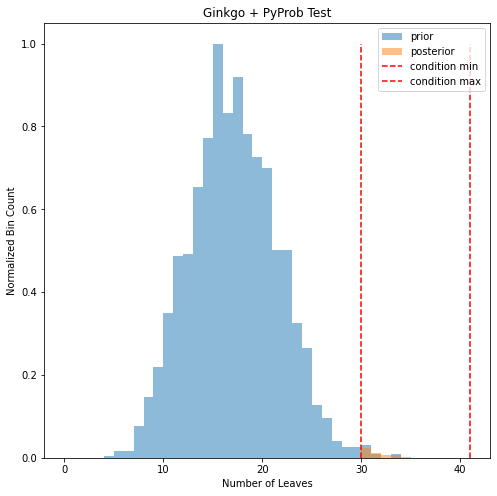

In [49]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
bins = np.linspace(0,40,41)
hist1_data = np.array([len(jet["leaves"]) for jet in prior_jets])
hist2_data = np.array([len(jet["leaves"]) for jet in post_jets])
hist1 = np.histogram(hist1_data, bins=bins)
hist2 = np.histogram(hist2_data, bins=bins)
ix = hist2[0] != 0
factor = hist1[0][ix].sum() / hist2[0][ix].sum()
hist1_max = np.max(hist1[0])
ix = np.argmax(hist2[0])
c1,_,_ = ax.hist(hist1[1][:-1], hist1[1], weights=hist1[0]/hist1_max, alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2[1][:-1], hist2[1], weights=hist2[0]/hist1_max * factor, alpha = 0.5, label = 'posterior');
#ax.vlines(condition['num_leaves']+0.5,0,np.max([c1.max(),c2.max()]), linestyle = 'dashed', color = 'red',
#          label="condition")
ax.vlines(30,0,np.max([c1.max(),c2.max()]), linestyle = 'dashed', color = 'red',
          label="condition min")
ax.vlines(41,0,np.max([c1.max(),c2.max()]), linestyle = 'dashed', color = 'red',
          label="condition max")
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('Number of Leaves')
ax.set_ylabel("Normalized Bin Count")
bins[np.argmax(c2)]

# Try using arbitrary combinations for the condition

In [2]:
jetM = 80. # parent mass -> W
jetdir = np.array([1,1,1]) # direction
jetP = 400. # magnitude
jetvec = jetP * jetdir / np.linalg.norm(jetdir)

jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))

## Define a function that takes (self, jet) and outputs True for the condition we want

In [3]:
def bernoulli_function(self, jet):
    return len(jet["leaves"]) >= 27
    #return (len(jet["leaves"]) <= 7) or (len(jet["leaves"]) >= 27)

In [147]:
def subjet_pT_cut(self, jet):
    subjet_left_4vec = jet["content"][jet["tree"][0][0]]
    subjet_right_4vec = jet["content"][jet["tree"][0][1]]
    subjet_left_pT = np.sqrt(subjet_left_4vec[1]**2 + subjet_left_4vec[2]**2)
    subjet_right_pT= np.sqrt(subjet_right_4vec[1]**2 + subjet_right_4vec[2]**2)
    #return (275 <= subjet_left_pT <= 400) or (275 <= subjet_right_pT <= 400)
    return (subjet_left_pT <= 40) and (270 <= subjet_right_pT)

In [148]:
def get_subjet_pT(jet, side="left"):
    if side == "left":
        subjet_left_4vec = jet["content"][jet["tree"][0][0]]
        subjet_left_pT = np.sqrt(subjet_left_4vec[1]**2 + subjet_left_4vec[2]**2)
        return subjet_left_pT
    elif side == "right":
        subjet_right_4vec = jet["content"][jet["tree"][0][1]]
        subjet_right_pT= np.sqrt(subjet_right_4vec[1]**2 + subjet_right_4vec[2]**2)
        return subjet_right_pT
    return None

In [150]:
simulator = invMass_ginkgo.SimulatorModel(rate=[3, 1.5], # exponential dsitribution rate
                                     jet_p=jet4vec,  # parent particle 4-vector
                                     pt_cut=10.,  # minimum pT for resulting jet
                                     Delta_0=torch.tensor(jetM**2),  # parent particle mass squared -> needs tensor
                                     M_hard=jetM,  # parent particle mass
                                     minLeaves=30,  # minimum number of jet constituents
                                     maxLeaves=40,  # maximum " "
                                     bool_func=subjet_pT_cut,
                                     suppress_output=True)

In [151]:
rate = torch.tensor([3, 1.5])  # Needs to be tensor

In [152]:
jet = simulator(rate)

In [153]:
prior = simulator.prior(num_traces=6000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
------------------------------------------------ |   94/6000 | 8.88       


/home/mdd424/ToyJetsShower/showerSim/invMass_ginkgo.py:297: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------#########--------- | 3427/6000 | 9.74       
------------------------------#########--------- | 3430/6000 | 9.74       
------------------------------##########-------- | 3681/6000 | 9.74       
------------------------------###########------- | 3896/6000 | 9.77       
------------------------------##############---- | 4766/6000 | 9.81       
0d:00:10:09 | 0d:00:00:00 | #################### | 6000/6000 | 9.85       


In [38]:
help(simulator.learn_inference_network)

Help on method learn_inference_network in module pyprob.model:

learn_inference_network(num_traces, num_traces_end=1000000000.0, inference_network=<InferenceNetwork.FEEDFORWARD: 0>, prior_inflation=<PriorInflation.DISABLED: 0>, dataset_dir=None, dataset_valid_dir=None, observe_embeddings={}, batch_size=64, valid_size=None, valid_every=None, optimizer_type=<Optimizer.ADAM: 0>, learning_rate_init=0.001, learning_rate_end=1e-06, learning_rate_scheduler_type=<LearningRateScheduler.NONE: 0>, momentum=0.9, weight_decay=0.0, save_file_name_prefix=None, save_every_sec=600, pre_generate_layers=True, distributed_backend=None, distributed_params_sync_every_iter=10000, distributed_num_buckets=None, dataloader_offline_num_workers=0, stop_with_bad_loss=True, log_file_name=None, lstm_dim=512, lstm_depth=1, proposal_mixture_components=10) method of showerSim.invMass_ginkgo.SimulatorModel instance



In [13]:
simulator.learn_inference_network(
    num_traces=1000,
    observe_embeddings={'bool_func': {'dim': 32, 'depth': 3}}
)

Continuing to train existing inference network...
Total number of parameters: 353,951
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 186__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 230__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 442__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 496__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 181, parameters: 361,883
------------------------------ | +2.73e+01 | +2.71e+01 | +2.71e+01 | 0d:00:00:00 | +1.00e-03 | 12.2 
New layers, address: 186__forward___traverse___traverse_rec___traverse_..., distribution: Uniforme-03 | 1.0                                
New layers, address: 230__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layer

In [154]:
posterior = simulator.posterior(inputs=rate,
                                num_traces=10000,
                                #inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
                                observe={"bool_func": 1})

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
------------------------------------------------ |   186/10000 | 9.26       
------------------------------------------------ |   207/10000 | 9.32       
------------------------------------------------ |   495/10000 | 8.91       
------------------------------------------------ |   910/10000 | 9.30       
------------------------------#####------------- |  3493/10000 | 9.80       
------------------------------#######----------- |  4624/10000 | 9.81       
------------------------------#########--------- |  5639/10000 | 9.75       
------------------------------############------ |  7218/10000 | 9.79       
------------------------------#############----- |  7273/10000 | 9.79       
------------------------------#############----- |  7436/10000 | 9.79       
0d:00:16:54 | 0d:00:00:00 | #################### | 10000/10000 | 9.86       


In [155]:
post_jets  = [posterior.sample().result for i in range(2000)]
prior_jets = [prior.sample().result for i in range(2000)]

## Various Plots

### Plot for number of leaves

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
bins = np.linspace(0,40,41)
hist1_data = np.array([len(jet["leaves"]) for jet in prior_jets])
hist2_data = np.array([len(jet["leaves"]) for jet in post_jets])
hist1 = np.histogram(hist1_data, bins=bins)
hist2 = np.histogram(hist2_data, bins=bins)
ix = hist2[0] != 0
factor = hist1[0][ix].sum() / hist2[0][ix].sum()
c1,_,_ = ax.hist(hist1[1][:-1], hist1[1], weights=hist1[0]/hist1[0].sum(), alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2[1][:-1], hist2[1], weights=hist2[0]/hist1[0].sum() * factor, alpha = 0.5, label = 'posterior');
#ax.vlines(8,0,np.max([c1.max(),c2.max()]), linestyle = 'dashed', color = 'red',
#          label="condition bound")
#ax.vlines(27,0,np.max([c1.max(),c2.max()]), linestyle = 'dashed', color = 'red',
#          label="condition bound")
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('Number of Leaves')
ax.set_ylabel("Normalized Bin Count")
bins[np.argmax(c2)]

### Plots for transverse momentum

In [ ]:
pca = skl.decomposition.PCA(n_components=1)
hist1_data_left = np.array([get_subjet_pT(jet, side="left") for jet in prior_jets])
hist2_data_left = np.array([get_subjet_pT(jet, side="left") for jet in post_jets])
hist1_data_right = np.array([get_subjet_pT(jet, side="right") for jet in prior_jets])
hist2_data_right = np.array([get_subjet_pT(jet, side="right") for jet in post_jets])

hist1_data = np.hstack([hist1_data_left.reshape(-1, 1), hist1_data_right.reshape(-1, 1)])
hist2_data = np.hstack([hist2_data_left.reshape(-1, 1), hist2_data_right.reshape(-1, 1)])

hist1_data_pca = pca.fit_transform(hist1_data)
hist2_data_pca = pca.transform(hist2_data) 

#print(pca.transform(np.mean(hist1_data, axis=0).reshape(1, -1)))

linreg = LinearRegression().fit(hist1_data_left.reshape(-1, 1), hist1_data_right.reshape(-1, 1))
ref_x = np.array([30]).reshape(1, -1)
ref_y = linreg.predict(ref_x)
ref = np.hstack([ref_x, ref_y]).reshape(1, -1)
ref_pca = pca.transform(ref)

In [172]:
pca.components_[0], pca.explained_variance_ratio_, pca.components_[0][1]/pca.components_[0][0], linreg.coef_[0], linreg.intercept_[0]

(array([-0.7057479 ,  0.70846305]),
 array([0.99985612]),
 -1.0038472003851742,
 array([-1.00355721]),
 329.0070521965746)

Text(0, 0.5, 'Normalized Bin Count')

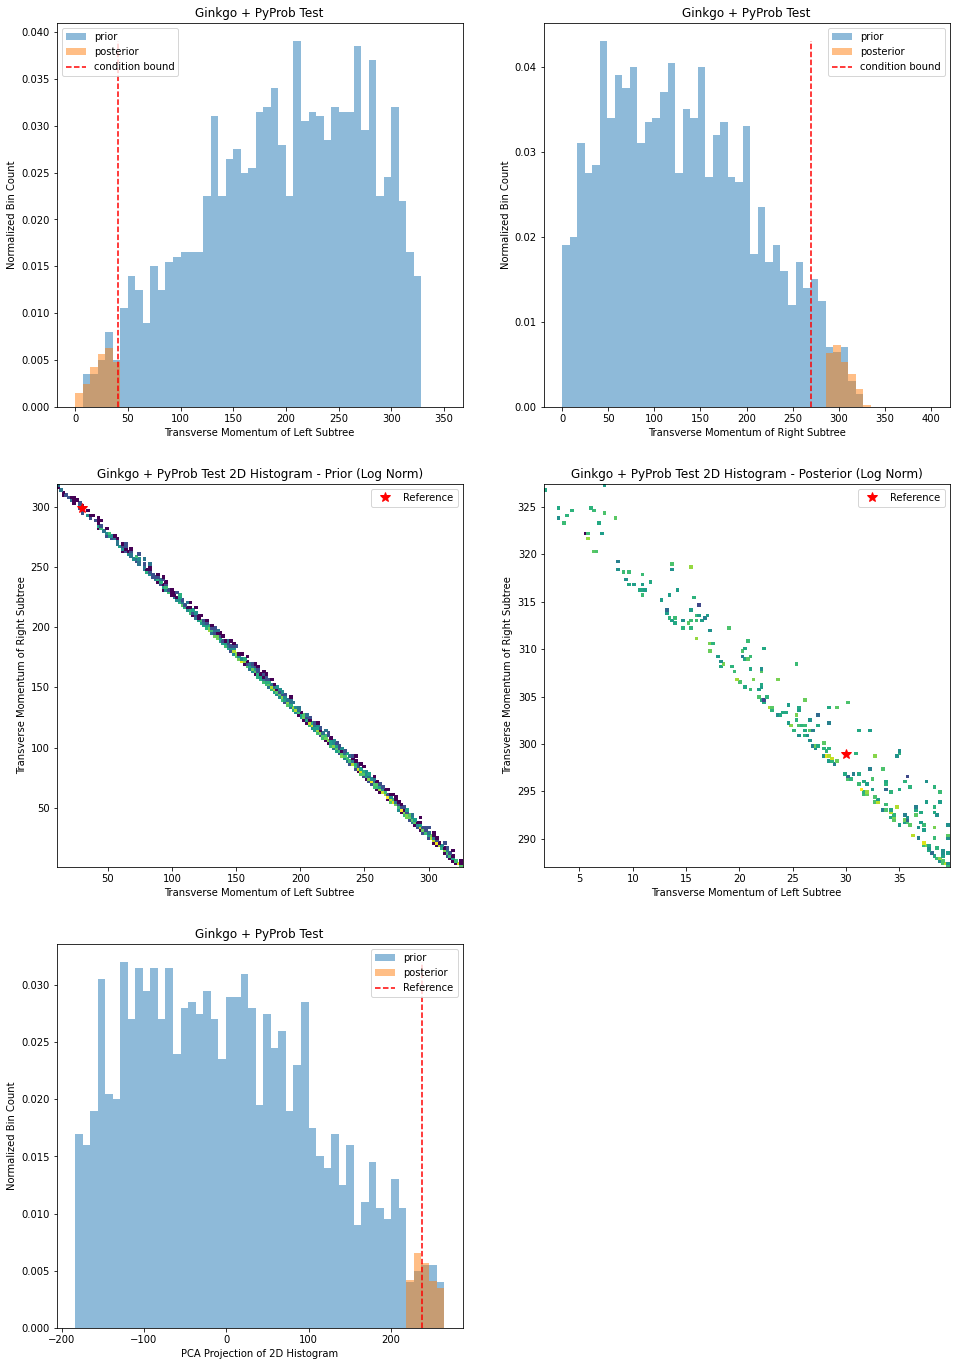

In [174]:
fig = plt.figure()
fig.set_size_inches(16,24)
ax = fig.add_subplot(321)
bins = np.linspace(0,350,50)
hist1_left = np.histogram(hist1_data_left, bins=bins)
hist2_left = np.histogram(hist2_data_left, bins=bins)
ix = hist2_left[0] != 0
factor = hist1_left[0][ix].sum() / hist2_left[0][ix].sum()
hist1_max_left = np.max(hist1_left[0])
c1,_,_ = ax.hist(hist1_left[1][:-1], hist1_left[1], weights=hist1_left[0]/hist1_left[0].sum(), alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2_left[1][:-1], hist2_left[1], weights=hist2_left[0]/hist1_left[0].sum() * factor, alpha = 0.5, label = 'posterior');
ax.vlines(41, 0, np.max([c1.max(), c2.max()]), linestyle = 'dashed', color = 'red', label="condition bound")
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('Transverse Momentum of Left Subtree')
ax.set_ylabel("Normalized Bin Count")

ax = fig.add_subplot(322)
bins = np.linspace(0,400,50)
hist1_right = np.histogram(hist1_data_right, bins=bins)
hist2_right = np.histogram(hist2_data_right, bins=bins)
ix = hist2_right[0] != 0
factor = hist1_right[0][ix].sum() / hist2_right[0][ix].sum()
hist1_max_right = np.max(hist1_right[0])
c1,_,_ = ax.hist(hist1_right[1][:-1], hist1_right[1], weights=hist1_right[0]/hist1_right[0].sum(), alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2_right[1][:-1], hist2_right[1], weights=hist2_right[0]/hist1_right[0].sum() * factor, alpha = 0.5, label = 'posterior');
ax.vlines(270, 0, np.max([c1.max(), c2.max()]), linestyle = 'dashed', color = 'red', label="condition bound")
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('Transverse Momentum of Right Subtree')
ax.set_ylabel("Normalized Bin Count")

ax = fig.add_subplot(323)
ax.hist2d(hist1_data_left, hist1_data_right, bins=150, norm=mpl.colors.LogNorm())#, cmap=mpl_cm.get_cmap('YlOrRd'))
ax.plot(ref[0,0], ref[0,1], '*', color='red', markersize=10, label="Reference")
ax.legend()
ax.set_title("Ginkgo + PyProb Test 2D Histogram - Prior (Log Norm)")
ax.set_xlabel('Transverse Momentum of Left Subtree')
ax.set_ylabel("Transverse Momentum of Right Subtree")

ax = fig.add_subplot(324)
ax.hist2d(hist2_data_left, hist2_data_right, bins=150, norm=mpl.colors.LogNorm())#, cmap=mpl_cm.get_cmap('YlOrRd'))
ax.plot(ref[0,0], ref[0,1], '*', color='red', markersize=10, label="Reference")
ax.legend()
ax.set_title("Ginkgo + PyProb Test 2D Histogram - Posterior (Log Norm)")
ax.set_xlabel('Transverse Momentum of Left Subtree')
ax.set_ylabel("Transverse Momentum of Right Subtree")

bins = np.linspace(hist1_data_pca.min(), hist1_data_pca.max(), 50)
hist1 = np.histogram(hist1_data_pca, bins=bins)
hist2 = np.histogram(hist2_data_pca, bins=bins)
ix = hist2[0] != 0
factor = hist1[0][ix].sum() / hist2[0][ix].sum()

ax = fig.add_subplot(325)
c1,_,_ = ax.hist(hist1[1][:-1], hist1[1], weights=hist1[0]/hist1[0].sum(), alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2[1][:-1], hist2[1], weights=hist2[0]/hist1[0].sum() * factor, alpha = 0.5, label = 'posterior');
ax.vlines(ref_pca, 0, np.max([c1.max(), c2.max()]), linestyle = 'dashed', color = 'red', label="Reference")
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('PCA Projection of 2D Histogram')
ax.set_ylabel("Normalized Bin Count")

### Plots for subtree depth and subtree leaves

In [36]:
def recursive_depth(jet_tree, index):
    rvals = [0, 0]
    if jet_tree[index][0] != -1:
        rvals[0] = recursive_depth(jet_tree, jet_tree[index][0])
    if jet_tree[index][1] != -1:
        rvals[1] = recursive_depth(jet_tree, jet_tree[index][1])
    return max(rvals) + 1

In [37]:
def recursive_leaves(jet_tree, index):
    rvals = [0, 0]
    if jet_tree[index][0] != -1:
        rvals[0] = recursive_leaves(jet_tree, jet_tree[index][0])
    if jet_tree[index][1] != -1:
        rvals[1] = recursive_leaves(jet_tree, jet_tree[index][1])
    if (jet_tree[index] == -1).all():
        return 1
    else:
        return sum(rvals)

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
bins = np.linspace(0,16,17)
hist1_data = np.array([recursive_depth(jet["tree"], 0) for jet in prior_jets])
hist2_data = np.array([recursive_depth(jet["tree"], 0) for jet in post_jets])
hist1 = np.histogram(hist1_data, bins=bins)
hist2 = np.histogram(hist2_data, bins=bins)
ix = hist2[0] != 0
factor = hist1[0][ix].sum() / hist2[0][ix].sum()
c1,_,_ = ax.hist(hist1[1][:-1], hist1[1], weights=hist1[0]/hist1[0].sum(), alpha = 0.5, label='prior');
c2,_,_ = ax.hist(hist2[1][:-1], hist2[1], weights=hist2[0]/hist1[0].sum() * factor, alpha = 0.5, label = 'posterior');
ax.legend()
ax.set_title("Ginkgo + PyProb Test")
ax.set_xlabel('Max Depth of the Tree')
ax.set_ylabel("Normalized Bin Count")
bins[np.argmax(c2)]

In [ ]:
fig = plt.figure()
fig.set_size_inches(16,16)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
bins = np.linspace(0,16,17)
hist11_data = np.array([recursive_depth(jet["tree"], jet["tree"][0][0]) for jet in prior_jets])
hist12_data = np.array([recursive_depth(jet["tree"], jet["tree"][0][1]) for jet in prior_jets])
hist21_data = np.array([recursive_depth(jet["tree"], jet["tree"][0][0]) for jet in post_jets])
hist22_data = np.array([recursive_depth(jet["tree"], jet["tree"][0][0]) for jet in post_jets])

hist11 = np.histogram(hist11_data, bins=bins)
hist12 = np.histogram(hist12_data, bins=bins)
hist21 = np.histogram(hist21_data, bins=bins)
hist22 = np.histogram(hist22_data, bins=bins)
ix = (hist21[0] != 0) | (hist22[0] != 0)
factor = (hist11[0][ix].sum() + hist12[0][ix].sum()) / (hist21[0][ix].sum() + hist22[0][ix].sum())
hist1_max = max(np.max(hist11[0]), np.max(hist12[0]))
ax1.hist(hist11[1][:-1], hist11[1], weights=hist11[0]/hist11[0].sum(), alpha = 0.5, label='prior left',
         histtype='bar');
ax1.hist(hist12[1][:-1], hist12[1], weights=hist12[0]/hist12[0].sum(), alpha = 0.5, label = 'prior right',
         histtype='bar');
ax2.hist(hist21[1][:-1], hist21[1], weights=hist21[0]/hist21[0].sum(), alpha = 0.5, label='posterior left',
         histtype='bar');
ax2.hist(hist22[1][:-1], hist22[1], weights=hist22[0]/hist22[0].sum(), alpha = 0.5, label = 'posterior right',
         histtype='bar');
ax3.hist(hist11[1][:-1], hist11[1], weights=hist11[0]/hist11[0].sum(), alpha = 0.5, label='prior left',
         histtype='bar');
ax3.hist(hist21[1][:-1], hist21[1], weights=hist21[0]/hist21[0].sum(), alpha = 0.5, label='posterior left',
         histtype='bar');
ax4.hist(hist12[1][:-1], hist12[1], weights=hist12[0]/hist12[0].sum(), alpha = 0.5, label = 'prior right',
         histtype='bar');
ax4.hist(hist22[1][:-1], hist22[1], weights=hist22[0]/hist22[0].sum(), alpha = 0.5, label = 'posterior right',
         histtype='bar');

fig.suptitle("Ginkgo + PyProb Test",y=0.92, fontsize=16)
for ax in [ax1,ax2,ax3,ax4]:
    ax.legend()
    ax.set_xlabel('Max Depth of the Tree')
    ax.set_ylabel("Normalized Bin Count")
#bins[np.argmax(c2)]

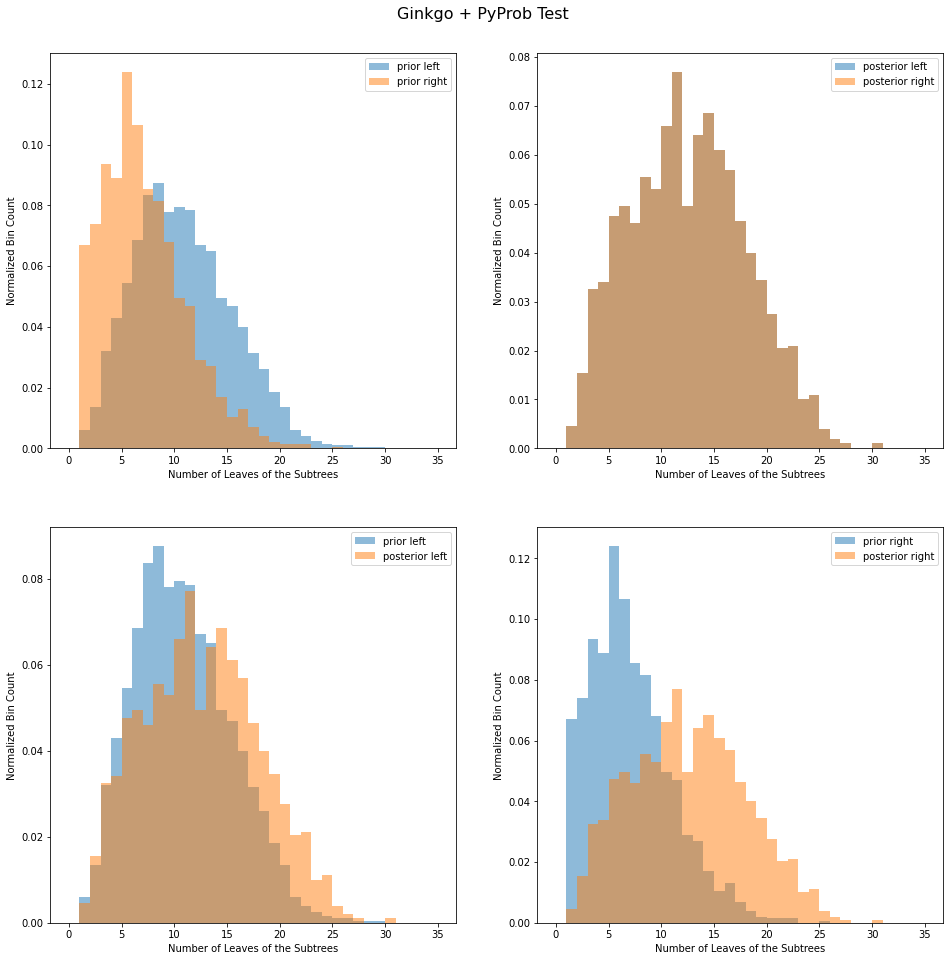

In [137]:
fig = plt.figure()
fig.set_size_inches(16,16)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
bins = np.linspace(0,35,36)
hist11_data = np.array([recursive_leaves(jet["tree"], jet["tree"][0][0]) for jet in prior_jets])
hist12_data = np.array([recursive_leaves(jet["tree"], jet["tree"][0][1]) for jet in prior_jets])
hist21_data = np.array([recursive_leaves(jet["tree"], jet["tree"][0][0]) for jet in post_jets])
hist22_data = np.array([recursive_leaves(jet["tree"], jet["tree"][0][0]) for jet in post_jets])

hist11 = np.histogram(hist11_data, bins=bins)
hist12 = np.histogram(hist12_data, bins=bins)
hist21 = np.histogram(hist21_data, bins=bins)
hist22 = np.histogram(hist22_data, bins=bins)
ix = (hist21[0] != 0) | (hist22[0] != 0)
factor = (hist11[0][ix].sum() + hist12[0][ix].sum()) / (hist21[0][ix].sum() + hist22[0][ix].sum())
hist1_max = max(np.max(hist11[0]), np.max(hist12[0]))
ax1.hist(hist11[1][:-1], hist11[1], weights=hist11[0]/hist11[0].sum(), alpha = 0.5, label='prior left',
         histtype='bar');
ax1.hist(hist12[1][:-1], hist12[1], weights=hist12[0]/hist12[0].sum(), alpha = 0.5, label = 'prior right',
         histtype='bar');
ax2.hist(hist21[1][:-1], hist21[1], weights=hist21[0]/hist21[0].sum(), alpha = 0.5, label='posterior left',
         histtype='bar');
ax2.hist(hist22[1][:-1], hist22[1], weights=hist22[0]/hist22[0].sum(), alpha = 0.5, label = 'posterior right',
         histtype='bar');
ax3.hist(hist11[1][:-1], hist11[1], weights=hist11[0]/hist11[0].sum(), alpha = 0.5, label='prior left',
         histtype='bar');
ax3.hist(hist21[1][:-1], hist21[1], weights=hist21[0]/hist21[0].sum(), alpha = 0.5, label='posterior left',
         histtype='bar');
ax4.hist(hist12[1][:-1], hist12[1], weights=hist12[0]/hist12[0].sum(), alpha = 0.5, label = 'prior right',
         histtype='bar');
ax4.hist(hist22[1][:-1], hist22[1], weights=hist22[0]/hist22[0].sum(), alpha = 0.5, label = 'posterior right',
         histtype='bar');

fig.suptitle("Ginkgo + PyProb Test",y=0.92, fontsize=16)
for ax in [ax1,ax2,ax3,ax4]:
    ax.legend()
    ax.set_xlabel('Number of Leaves of the Subtrees')
    ax.set_ylabel("Normalized Bin Count")
#bins[np.argmax(c2)]

## Viewing latent variables of a trace

In [56]:
sample = posterior.sample()

In [61]:
mydir = lambda x: [y for y in dir(x) if not y.startswith('_')]

In [62]:
mydir(sample)

['add',
 'address_counts',
 'end',
 'execution_time_sec',
 'last_instance',
 'length',
 'length_controlled',
 'log_importance_weight',
 'log_prob',
 'log_prob_observed',
 'named_variables',
 'result',
 'to',
 'variables',
 'variables_controlled',
 'variables_dict_address',
 'variables_dict_address_base',
 'variables_observable',
 'variables_observed',
 'variables_replaced',
 'variables_tagged',
 'variables_uncontrolled']

In [63]:
mydir(sample.variables[0])

['address',
 'address_base',
 'control',
 'distribution',
 'instance',
 'log_importance_weight',
 'log_prob',
 'name',
 'observable',
 'observed',
 'replace',
 'reused',
 'tagged',
 'to',
 'value']

In [65]:
sample.variables[0].name

'phiCM0False'

In [181]:
np.array(['L_decay1True' in posterior.sample().named_variables.keys() for _ in range(1000)]).sum()

991

In [156]:
sample.named_variables.get('L_decay2True').value.item()

0.5971096158027649

### Plot of the exponential prior/posterior of a latent variable at a given index

In [208]:
index = 3

In [209]:
#prior_vars = [prior.sample().named_variables.get('L_decay' + str(index) + 'True') for _ in range(20000)]
#post_vars = [posterior.sample().named_variables.get('L_decay' + str(index) + 'True') for _ in range(20000)]
#prior_expo = np.array([var.value.item() for var in prior_vars if var is not None])
#post_expo = np.array([var.value.item() for var in post_vars if var is not None])
prior_expo = []
post_expo = []
while len(prior_expo) < 10000:
    var = prior.sample().named_variables.get('L_decay' + str(index) + 'True')
    if var is not None:
        prior_expo.append(var.value.item())
eff_sample_size = 0
sample_iweights = np.zeros(0)
while eff_sample_size < 10000:
    sample = posterior.sample()
    var = sample.named_variables.get('L_decay' + str(index) + 'True')
    if var is not None:
        post_expo.append(var.value.item())
        sample_iweights = np.append(sample_iweights, [np.exp(sample.log_importance_weight)])
        eff_sample_size = (sample_iweights.sum()**2) / (sample_iweights**2).sum()
prior_expo = np.array(prior_expo)
post_expo = np.array(post_expo)

Text(0, 0.5, 'Normalized Bin Count')

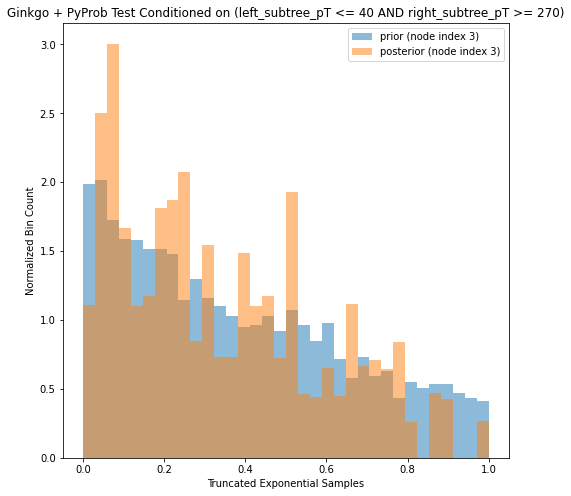

In [210]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
bins = np.linspace(0,1,35)
c1,_,_ = ax.hist(prior_expo, bins=bins, alpha = 0.5, label='prior (node index '+str(index)+')', density=True);
c2,_,_ = ax.hist(post_expo, bins=bins, alpha = 0.5, label = 'posterior (node index '+str(index)+')', density=True);
ax.legend()
ax.set_title("Ginkgo + PyProb Test Conditioned on (left_subtree_pT <= 40 AND right_subtree_pT >= 270)")
ax.set_xlabel('Truncated Exponential Samples')
ax.set_ylabel("Normalized Bin Count")

### Looking at importance weights

In [ ]:
dir(posterior.sample());

In [200]:
np.exp(posterior.sample().log_importance_weight)

0.9999998807907247

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([0.49999988, 0.54999988, 0.59999988, 0.64999988, 0.69999988,
        0.74999988, 0.79999988, 0.84999988, 0.89999988, 0.94999988,
        0.99999988, 1.04999988, 1.09999988, 1.14999988, 1.19999988,
        1.24999988, 1.29999988, 1.34999988, 1.39999988, 1.44999988,
        1.49999988]),
 <BarContainer object of 20 artists>)

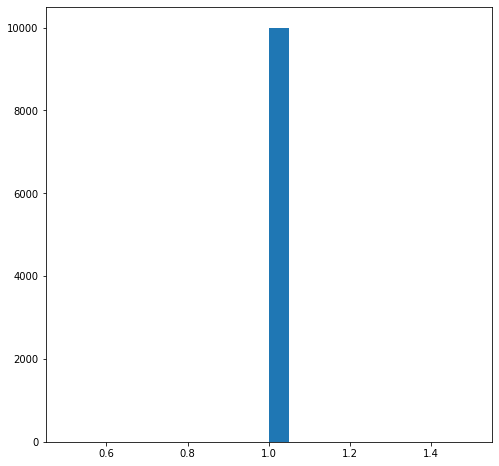

In [214]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
ax.hist(sample_iweights, bins=20)

In [217]:
np.mean(sample_iweights), np.var(sample_iweights)

(0.9999998807907247, 0.0)